In [1]:
#Importing necessary libraries
import numpy as np
import pandas as pd
import re
import nltk
import string
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import itertools
import collections
from textblob import TextBlob
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, average_precision_score, recall_score
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
from google.colab import files
uploaded = files.upload()

Saving hotel_data_final.csv to hotel_data_final.csv


In [3]:
import io
review_df = pd.read_csv(io.BytesIO(uploaded['hotel_data_final.csv']))

In [4]:
review_df.head()


Hotel_id  ... User_id
0         0  ...   15400
1         1  ...   15740
2         1  ...   13760
3         1  ...   11027
4         1  ...   10306

[5 rows x 12 columns]

In [5]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [6]:
# Investigate Data
type(review_df)
review_df.size
review_df.shape
review_df.head()
review_df.tail()

pandas.core.frame.DataFrame

280728

(23394, 12)

Hotel_id  ... User_id
0         0  ...   15400
1         1  ...   15740
2         1  ...   13760
3         1  ...   11027
4         1  ...   10306

[5 rows x 12 columns]

Hotel_id  ... User_id
23389      3128  ...   13911
23390      3129  ...    9306
23391      3129  ...    2888
23392      3130  ...    4949
23393      3130  ...    9807

[5 rows x 12 columns]

In [7]:

# Drop unnecessary columns
df = review_df.drop(['Hotel_Type','Price','Hotel_Category'], axis=1)

In [8]:
# Checking for missing values
pd.isnull(df).any()
pd.isnull(df).sum()

Hotel_id    False
Hotel       False
Address     False
City        False
Title        True
Users       False
Reviews      True
Rating       True
User_id     False
dtype: bool

Hotel_id     0
Hotel        0
Address      0
City         0
Title       52
Users        0
Reviews      1
Rating      29
User_id      0
dtype: int64

In [9]:
# Dropping the missing values
df = df.dropna()
df = df.reset_index(drop=True)
print('Shape of dataset ',df.shape)
print(df.columns)

Shape of dataset  (23341, 9)
Index(['Hotel_id', 'Hotel', 'Address', 'City', 'Title', 'Users', 'Reviews',
       'Rating', 'User_id'],
      dtype='object')


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23341 entries, 0 to 23340
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Hotel_id  23341 non-null  int64  
 1   Hotel     23341 non-null  object 
 2   Address   23341 non-null  object 
 3   City      23341 non-null  object 
 4   Title     23341 non-null  object 
 5   Users     23341 non-null  object 
 6   Reviews   23341 non-null  object 
 7   Rating    23341 non-null  float64
 8   User_id   23341 non-null  int64  
dtypes: float64(1), int64(2), object(6)
memory usage: 1.6+ MB


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Number of Reviews for Top 20 Hotels')

Text(0.5, 0, 'Hotel Name')

Text(0, 0.5, 'Number of Reviews')

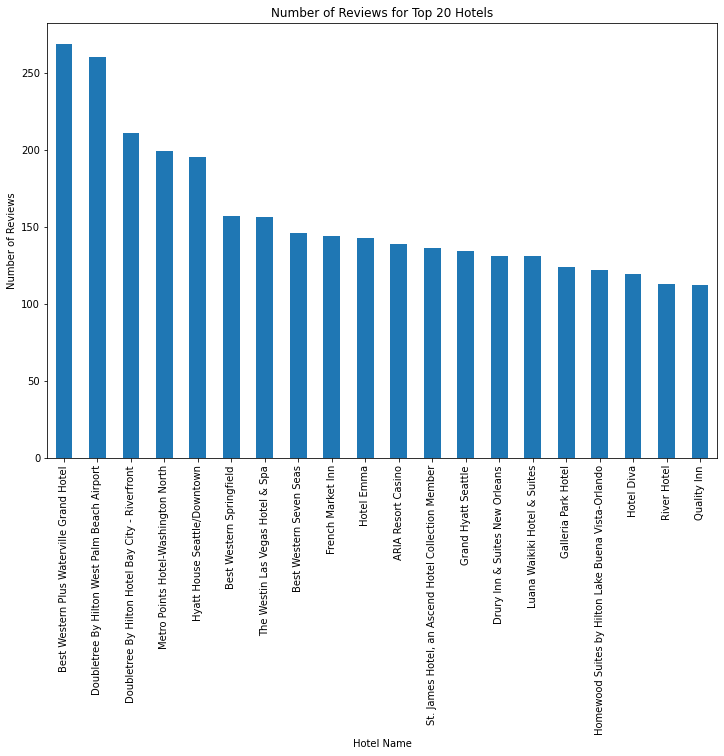

In [39]:
# PLOT FOR NUMBER OF REVIEWS FOR TOP 20 HOTELS  
brands = df["Hotel"].value_counts()
plt.figure(figsize=(12,8))
brands[:20].plot(kind='bar')
plt.title("Number of Reviews for Top 20 Hotels")
plt.xlabel('Hotel Name')
plt.ylabel('Number of Reviews')

<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Number of Reviews for Bottom 20 Brands')

Text(0.5, 0, 'Hotel Name')

Text(0, 0.5, 'Number of Reviews')

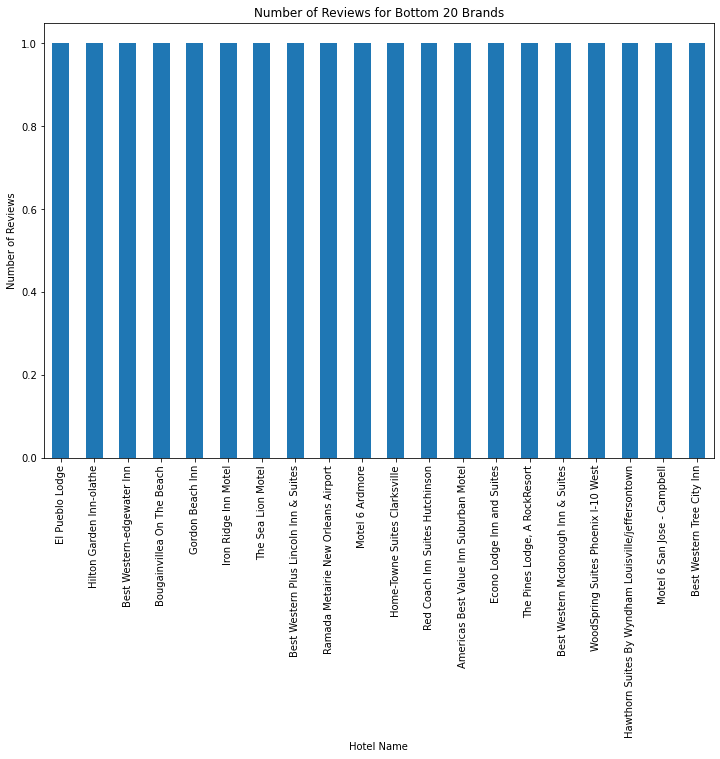

In [40]:
# PLOT FOR NUMBER OF REVIEWS FOR BOTTOM 20 HOTELS  
brands = df["Hotel"].value_counts()
plt.figure(figsize=(12,8))
brands[-20:].plot(kind='bar')
plt.title("Number of Reviews for Bottom 20 Brands")
plt.xlabel('Hotel Name')
plt.ylabel('Number of Reviews')

In [11]:
# Dividing the Sentiment into "Positive" and "Negative" w.r.t to the Rating
df['Sentiment'] = df['Rating'].apply(lambda Rating: 'Positive' if Rating > 3 else 'Negative')
df.head(5)

Hotel_id      Hotel         Address  ... Rating User_id Sentiment
0         0  La Quinta  5820 Walden Rd  ...    1.0   15400  Negative
1         1  The Point     Po Box 1327  ...    5.0   15740  Positive
2         1  The Point     Po Box 1327  ...    5.0   13760  Positive
3         1  The Point     Po Box 1327  ...    5.0   11027  Positive
4         1  The Point     Po Box 1327  ...    5.0   10306  Positive

[5 rows x 10 columns]

In [12]:
# Sentiment Count
df.Sentiment.value_counts()

Positive    17437
Negative     5904
Name: Sentiment, dtype: int64

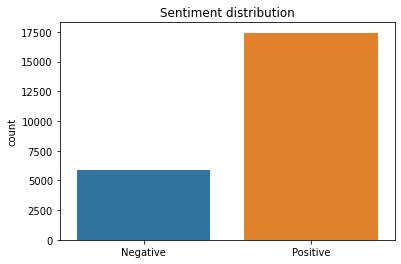

In [13]:
# Plot Showing Sentiment Distribution
f = sns.countplot(x='Sentiment', data=df)
f.set_title("Sentiment distribution")
f.set_xticklabels(['Negative', 'Positive'])
plt.xlabel("");

In [14]:
# The "Positive" Sentiment has been labelled as "1" and the "Negative" as "0"
df['Label'] = df['Sentiment'].apply(lambda Sentiment: '1' if Sentiment is 'Positive' else '0')
df.head(5)

Hotel_id      Hotel         Address  ... User_id Sentiment Label
0         0  La Quinta  5820 Walden Rd  ...   15400  Negative     0
1         1  The Point     Po Box 1327  ...   15740  Positive     1
2         1  The Point     Po Box 1327  ...   13760  Positive     1
3         1  The Point     Po Box 1327  ...   11027  Positive     1
4         1  The Point     Po Box 1327  ...   10306  Positive     1

[5 rows x 11 columns]

In [15]:
df.Rating.value_counts()

5.0    10809
4.0     6628
3.0     3077
2.0     1431
1.0     1396
Name: Rating, dtype: int64

In [16]:
print("Mean rating : {}".format(df['Rating'].mean()))
print("Mean rating standard deviation: {}".format(df['Rating'].std()))

Mean rating : 4.029218970909558
Mean rating standard deviation: 1.1737282797262136


<Figure size 864x576 with 0 Axes>

Text(0.5, 1.0, 'Distribution of Rating')

Text(0.5, 0, 'Rating')

Text(0, 0.5, 'Count')

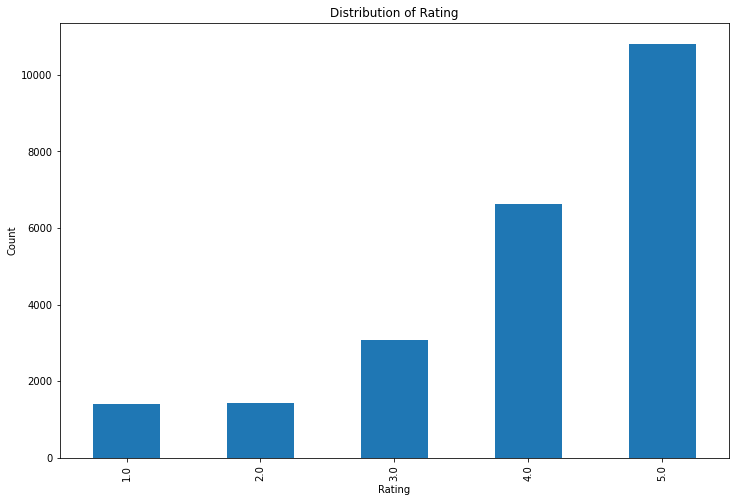

In [17]:
# Plot distribution of rating
plt.figure(figsize=(12,8))
# sns.countplot(df['Rating'])
df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Rating')
plt.xlabel('Rating')
plt.ylabel('Count')

(array([121.,  22.,  97.,  81.,  50., 284., 221., 594., 418., 936.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <a list of 10 Patch objects>)

Text(0.5, 0, 'mean rating given by each reviewer')

Text(0, 0.5, 'number of reviewers')

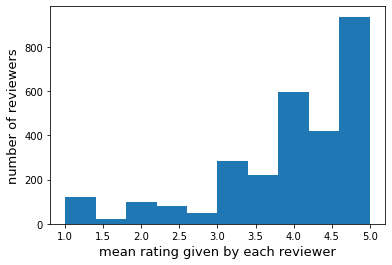

In [18]:
mean_rating_of_user = df.groupby('Hotel').apply(lambda x: x['Rating'].mean())

fig = plt.figure(figsize=(6,4))
ax  = fig.add_subplot(111)
ax.hist(mean_rating_of_user)
ax.set_xlabel('mean rating given by each reviewer', fontsize=13)
ax.set_ylabel('number of reviewers', fontsize=13)

In [19]:
for index,text in enumerate(df['Reviews']):
  print('Review %d:\n'%(index+1),text)


Streaming output truncated to the last 5000 lines.
Review 3094:
 towels too small in pool area and should have longer hours comfortable beds and clean room
Review 3095:
 Bad: If it was not for the staff, my request through booking.com would not have been filled correctly (room type). Good: Everything was very clean and the staff was very professional.
Review 3096:
 Bad: The hotel room did not meet expectations. There was shaved hair in the shower (did not belong to us) and the water did not get hot. It took 10 minutes of running the water to even get to a somewhat comfortable temperature. It was requested for our two rooms to be beside each other and that request was unable to be met. Finally, when my child got sick with the flu, they were unwilling to work with me on the two nights I paid for and lost because she was sick. Good: Location and pool
Review 3097:
 Bad: No frig.
Review 3098:
 Bad: Didn't have refrigerator. Prefer scrambled eggs to Spanish omelets. Good: Bed was comfortable

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
 This is definitely one of our favorite hotels in downtown Seattle. The staff is what sets this hotel above others. The staff was courteous and friendly. The rooms are very clean and roomy. Located in the hotel is one of our favorite restaurants, Ruth Chris Steak House. Both are highly recommended for a weekend stay.
Review 20421:
 ask for a good view- particularly, you can get one of several rooms with a direct view of the space needle. the prices are reasonable for a big city, and the rooms are fairly spacious. the rooms are clean, and the lobby and common areas are quite nice. a ruth's chris in the lobby is a plus. service is great. this is convenient to pioneer square, pike's place market.Thank you for your comments. We are so glad that you enjoyed your stay with us. It's so great that our amenities and location make it easy for our guests to get to restaurants and entertainment. We would love to welcome you back on your next trip 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [20]:
corpus = [] 

In [21]:
# Dictionary of English Contractions
contractions_dict = { "ain't": "are not","'s":" is","aren't": "are not",
                     "can't": "cannot","can't've": "cannot have",
                     "'cause": "because","could've": "could have","couldn't": "could not",
                     "couldn't've": "could not have", "didn't": "did not","doesn't": "does not",
                     "don't": "do not","hadn't": "had not","hadn't've": "had not have",
                     "hasn't": "has not","haven't": "have not","he'd": "he would",
                     "he'd've": "he would have","he'll": "he will", "he'll've": "he will have",
                     "how'd": "how did","how'd'y": "how do you","how'll": "how will",
                     "I'd": "I would", "I'd've": "I would have","I'll": "I will",
                     "I'll've": "I will have","I'm": "I am","I've": "I have", "isn't": "is not",
                     "it'd": "it would","it'd've": "it would have","it'll": "it will",
                     "it'll've": "it will have", "let's": "let us","ma'am": "madam",
                     "mayn't": "may not","might've": "might have","mightn't": "might not", 
                     "mightn't've": "might not have","must've": "must have","mustn't": "must not",
                     "mustn't've": "must not have", "needn't": "need not",
                     "needn't've": "need not have","o'clock": "of the clock","oughtn't": "ought not",
                     "oughtn't've": "ought not have","shan't": "shall not","sha'n't": "shall not",
                     "shan't've": "shall not have","she'd": "she would","she'd've": "she would have",
                     "she'll": "she will", "she'll've": "she will have","should've": "should have",
                     "shouldn't": "should not", "shouldn't've": "should not have","so've": "so have",
                     "that'd": "that would","that'd've": "that would have", "there'd": "there would",
                     "there'd've": "there would have", "they'd": "they would",
                     "they'd've": "they would have","they'll": "they will",
                     "they'll've": "they will have", "they're": "they are","they've": "they have",
                     "to've": "to have","wasn't": "was not","we'd": "we would",
                     "we'd've": "we would have","we'll": "we will","we'll've": "we will have",
                     "we're": "we are","we've": "we have", "weren't": "were not","what'll": "what will",
                     "what'll've": "what will have","what're": "what are", "what've": "what have",
                     "when've": "when have","where'd": "where did", "where've": "where have",
                     "who'll": "who will","who'll've": "who will have","who've": "who have",
                     "why've": "why have","will've": "will have","won't": "will not",
                     "won't've": "will not have", "would've": "would have","wouldn't": "would not",
                     "wouldn't've": "would not have","y'all": "you all", "y'all'd": "you all would",
                     "y'all'd've": "you all would have","y'all're": "you all are",
                     "y'all've": "you all have", "you'd": "you would","you'd've": "you would have",
                     "you'll": "you will","you'll've": "you will have", "you're": "you are",
                     "you've": "you have"}

# Regular expression for finding contractions
contractions_re=re.compile('(%s)' % '|'.join(contractions_dict.keys()))

# Function for expanding contractions
def expand_contractions(text,contractions_dict=contractions_dict):
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, text)

# Expanding Contractions in the reviews
df['Reviews']=df['Reviews'].apply(lambda x:expand_contractions(x))

In [22]:
#Tokenization of the sentences

from nltk.tokenize import word_tokenize
tokens = word_tokenize(text)
print(tokens)


['We', 'spent', '2', 'weeks', 'in', 'this', 'hotel', 'due', 'to', 'the', 'cost', 'of', 'the', 'the', 'normal', 'hotels', 'we', 'stay', 'at', 'were', 'double', 'the', 'normal', 'cost', '.', 'The', 'location', 'of', 'this', 'hotel', 'is', 'GREAT', ',', 'it', 'has', 'a', 'nice', 'good', 'size', 'flat', 'screen', 'TV', 'with', 'cable/Sat', 'TV', ',', 'and', 'both', 'beds', 'were', 'actually', 'pretty', 'comfortable', '-', 'at', 'this', 'poit', 'there', 'is', 'nothing', 'else', 'that', 'I', '...', 'More']


In [23]:
#Lowercase the reviews
df['Text_Clean']=df['Reviews'].apply(lambda x: x.lower())


In [24]:
#Remove digits and words containing digits
df['Text_Clean']=df['Text_Clean'].apply(lambda x: re.sub('\w*\d\w*','', x))


In [25]:
#Remove Punctuations
df['Text_Clean']=df['Text_Clean'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))


In [26]:
# Removing extra spaces
df['Text_Clean']=df['Text_Clean'].apply(lambda x: re.sub(' +',' ',x))

In [27]:
#Reviews after cleaning
for index,text in enumerate(df['Text_Clean'][35:40]):
  print('Review %d:\n'%(index+1),text)

Review 1:
 enjoyed my stay older hotel with character great staff room clean and comfortable parking is an issue but that is for all of seattle key arena and space needle just blocks away same with restaurants and nightlife no elevator stairs only floors
Review 2:
 if you are looking for a modern hotel with all the extras then keep looking but if you need a comfortable bed in a quaint little inn then this is the place for you the hotel is old but has lots of character and the staff is very helpful and friendly our group enjoyed the little courtyard outside to sit and visit the location is perfect for seeing the space needle and other local areas we got into seattle early in the day but the clerk very kindly help our luggage and told us of a local food festival that was happening just two blocks away what a fun afternoon we had we called uber to transport us to the pike is market and back to the hotel again we walked just a little over a block to a wonderful grocery store for our breakf

In [28]:
# Importing spacy
import spacy

# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
df['lemmatized']=df['Text_Clean'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))



In [29]:
corpus.append(df['Text_Clean'])

In [30]:
corpus[0:10]

[0        this hotel is a dump upon checking in was told...
 1        the point is possibly one of our favorite rest...
 2        from the minute you arrive until the minute yo...
 3        that is the name on one of their boats and the...
 4        i was lucky enough to spend nights at the poin...
                                ...                        
 23336    i booked this hotel for mid october months ago...
 23337    we had a one night stay at your hotel sept it ...
 23338    positives location it is on the main strip nex...
 23339    not exactly a fivestar hotel but right in the ...
 23340    we spent weeks in this hotel due to the cost o...
 Name: Text_Clean, Length: 23341, dtype: object]

In [45]:
# Importing the clean dataset to the local
from google.colab import files
df.to_csv('clean_data.csv')
files.download('clean_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
df_grouped=df[['Hotel','lemmatized']].groupby(by='Hotel').agg(lambda x:' '.join(x))
df_grouped.head()

lemmatized
Hotel                                                                          
11th Avenue Hotel Hostel      fianc book night denver look good deal stay ho...
1906 Lodge At Coronado Beach  absolutely delightful stay charming lodge hard...
21c Museum Hotel Lexington    recently stay hotel trip lexington friend grou...
250 Main Hotel                frequent business traveler stay type hotel yea...
402 Hotel #Thebigo            cool spot great lobby renovation lobby room ma...

In [33]:
# Creating the Bag of Words model
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=2500)
data=cv.fit_transform(df_grouped['lemmatized'])
df_dtm = pd.DataFrame(data.toarray(), columns=cv.get_feature_names())
df_dtm.index=df_grouped.index
df_dtm.head(3)

aaa  ability  able  abri  ...  yummy  zaza  zero  zoo
Hotel                                                   ...                        
11th Avenue Hotel Hostel        0        0     0     0  ...      0     0     0    0
1906 Lodge At Coronado Beach    0        0     0     0  ...      0     0     0    0
21c Museum Hotel Lexington      0        0     0     0  ...      0     0     0    0

[3 rows x 2500 columns]

In [34]:
# Creating Document Term Matrix
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words={'english'})
data=vectorizer.fit_transform(df_grouped['lemmatized'])
df_dtm = pd.DataFrame(data.toarray(), columns=vectorizer.get_feature_names())
df_dtm.index=df_grouped.index
df_dtm.head(3)

aa  aaa  aaaa  ...  œthe  œðÿœ  ƒðÿ
Hotel                                         ...                 
11th Avenue Hotel Hostel      0.0  0.0   0.0  ...   0.0   0.0  0.0
1906 Lodge At Coronado Beach  0.0  0.0   0.0  ...   0.0   0.0  0.0
21c Museum Hotel Lexington    0.0  0.0   0.0  ...   0.0   0.0  0.0

[3 rows x 35796 columns]

In [35]:
#Checking the polarity of the Reviews
from textblob import TextBlob
df['polarity']=df['lemmatized'].apply(lambda x:TextBlob(x).sentiment.polarity)

In [36]:
#Checking the highest polarity of reviews

print("3 Random Reviews with Highest Polarity:")
for index,review in enumerate(df.iloc[df['polarity'].sort_values(ascending=False)[:3].index]['Reviews']):
  print('Review {}:\n'.format(index+1),review)

3 Random Reviews with Highest Polarity:
Review 1:
 Everything was Excellent!!! Quality Service! Will be coming Back!!!!
Review 2:
 Excellent
Review 3:
 Perfect getaway after the company party. Convenient to everything downtown Bay City.


In [37]:
#Checking the lowest polarity of reviews

print("3 Random Reviews with Lowest Polarity:")
for index,review in enumerate(df.iloc[df['polarity'].sort_values(ascending=True)[:3].index]['Reviews']):
  print('Review {}:\n'.format(index+1),review)

3 Random Reviews with Lowest Polarity:
Review 1:
 Expedia charged me for the room, but Hotel did not honor the reservation. HJotel sent me to expedia and expedia to hotel TERRIBLE EXPERIENCE with Expedia
Review 2:
 Smells and smells like smoke clueless workers .horrible will not be back
Review 3:
 HORRIBLE HORRIBLE


<Figure size 1152x576 with 0 Axes>

Text(0.5, 0, 'Polarity')

Text(0, 0.5, 'Hotels')

Text(0.5, 1.0, 'Polarity of Different Hotel Reviews')

Text(0.005, -1.4, 'Biddeford Motel')

Text(0.005, -0.4, 'Days Inn Wheelersburg Portsmouth')

Text(0.005, 0.8, 'Budget Inn Express-grand Forks')

Text(0.005, 1.8, 'Lemon Tree Motel')

Text(0.005, 2.9, 'Knights Inn-murfreesboro')

Text(0.005, 3.983333333333333, 'Crossland Economy Studios Denver - Thornton')

Text(0.005, 5.007272727272727, 'Longhorn Motel')

Text(0.005, 6.015, 'Hotel Prince Spafford')

Text(0.005, 7.043749999999999, 'Three Oaks Motel')

Text(0.005, 8.049999999999999, 'Seneca Motel')

Text(0.005, 9.083333333333332, 'Town House Motel')

Text(0.005, 10.096634615384614, 'Heritage Court Motel')

Text(0.005, 11.1, 'Americas Best Value Inn - Medical Center / Lubbock')

Text(0.005, 12.10625, 'Americas Best Value Inn-rialto')

Text(0.005, 13.147916666666667, 'Knights Inn Metairie')

Text(0.005, 14.153333333333332, 'Motel 6-dubuque')

Text(0.005, 15.16, 'Super 8 Delavan Near Lake Geneva')

Text(0.005, 16.16041666666667, 'Hyundae Resort Spa')

Text(0.005, 17.175, 'Crossland Economy Studios Salem - North')

Text(0.005, 18.200000000000003, 'Riviera Motel')

Text(0.005, 19.200892857142858, 'Hartsville Motel')

Text(0.005, 20.206365740740743, 'Red Roof Inn Phoenix North - Bell Road')

Text(0.005, 21.233333333333334, 'Americas Best Value Inn Suites-lexington Park')

Text(0.005, 22.2375, 'Champions Lodge')

Text(0.005, 23.25, 'Park Place Inn')

Text(0.005, 24.255555555555556, 'Gateway Inn')

Text(0.005, 25.274074074074075, "Wyndham Garden Elk Grove Village/o'hare")

Text(0.005, 26.275000000000002, 'Slide Mountain Motel')

Text(0.005, 27.27559523809524, 'Wingate By Wyndham Alpharetta')

Text(0.005, 28.27777777777778, 'Diamond Hotel')

Text(0.005, 29.3, 'Fun City Motel')

Text(0.005, 30.316921768707484, 'Royal Motel')

Text(0.005, 31.31875, 'Holiday Inn Express TulsaWoodland Hills')

Text(0.005, 32.325, 'Motel 6 Watsonville - Monterey Area')

Text(0.005, 33.327777777777776, 'Shadeland Inn')

Text(0.005, 34.33888888888889, 'Holiday Inn Express Marietta - Atlanta Northwest')

Text(0.005, 35.35, 'ECO LUX Inn')

Text(0.005, 36.35, 'Rancher Motel-Cafe')

Text(0.005, 37.35, 'Westchester Hotel')

Text(0.005, 38.35, 'Wingate by Wyndham Frisco')

Text(0.005, 39.352380952380955, 'Comfort Suites University Area')

Text(0.005, 40.353968253968254, 'Hotel 7 Vienna')

Text(0.005, 41.355555555555554, 'M-Star Augusta')

Text(0.005, 42.3692775974026, 'Beach Aire Motel')

Text(0.005, 43.375, 'Budgethost Inn')

Text(0.005, 44.37746913580247, 'Hollywood Inn Express South')

Text(0.005, 45.38055555555556, 'Seaside Inn')

Text(0.005, 46.3864081996435, 'Desert Lodge')

Text(0.005, 47.38666666666667, 'Atlas Motel')

Text(0.005, 48.38809523809524, 'River Rock Hotel')

Text(0.005, 49.39073232323233, 'Red Roof Plus+ Wilmington - Newark')

Text(0.005, 50.39270833333333, 'Days Inn Fayetteville')

Text(0.005, 51.402857142857144, "America's Best Inn Suites")

Text(0.005, 52.42559523809524, 'Wyndham Garden-amarillo')

Text(0.005, 53.42784090909091, 'Wagon Wheel Motel')

Text(0.005, 54.42788461538462, 'Microtel Inn & Suites By Wyndham Augusta/Riverwatch')

Text(0.005, 55.42857142857143, 'Morristown Hotel Suites')

Text(0.005, 56.43265306122449, 'Hyatt Place Chantilly Dulles Airport South')

Text(0.005, 57.4375, 'Residence Inn Jacksonville Butler Boulevard')

Text(0.005, 58.440000000000005, 'LA Hacienda Motel')

Text(0.005, 59.446296296296296, 'Courtyard Houston Hobby Airport')

Text(0.005, 60.45, 'Motel 6 Santa Maria')

Text(0.005, 61.45, 'Best Western Of Alexandria Inn & Suites & Conference Center')

Text(0.005, 62.45, 'Holiday Inn Express Suites Arkadelphia - Caddo Valley')

Text(0.005, 63.45, 'Flamingo Suites')

Text(0.005, 64.45416666666667, 'Best Western Regency Inn')

Text(0.005, 65.45972222222221, 'Americas Best Value Inn New Philadelphia')

Text(0.005, 66.46143707482993, 'DoubleTree by Hilton Golf Resort San Diego')

Text(0.005, 67.46666666666665, 'Admiral Hotel')

Text(0.005, 68.46770833333333, 'Jayhawk Motel')

Text(0.005, 69.46861471861472, 'Crossland Economy Studios-phoenix-west')

Text(0.005, 70.46894841269841, 'Econo Lodge South')

Text(0.005, 71.47222222222221, 'Grand Union Motel')

Text(0.005, 72.47333333333333, 'Dayton Motel')

Text(0.005, 73.47878787878787, 'Granby Motel')

Text(0.005, 74.48162878787878, 'Crossland Economy Studios Spartanburg - Asheville Hwy.')

Text(0.005, 75.48491838023088, 'River Side Motel & Marina')

Text(0.005, 76.48555555555555, 'Ocean Shores Motel')

Text(0.005, 77.49132395382395, 'Best Western Cantebury Inn & Suites')

Text(0.005, 78.49326923076923, 'Quality Inn North')

Text(0.005, 79.5, 'Palmeiras Beach Club at Grove Isle')

Text(0.005, 80.5, 'Half Moon Motel')

Text(0.005, 81.5, 'Best Western Plus Classic Inn Suites')

Text(0.005, 82.5, 'Comfort Inn-lehigh Valley West')

Text(0.005, 83.50568181818181, 'Super 8-Dubois')

Text(0.005, 84.50833333333333, 'Inn Of Knoxville')

Text(0.005, 85.50833333333333, 'Aztec Hotel')

Text(0.005, 86.50914514949716, "Fiddler's Inn")

Text(0.005, 87.5111111111111, 'Wilbraham Inn')

Text(0.005, 88.5111111111111, 'Culver Cove Resort')

Text(0.005, 89.51137566137565, 'Budget Inn The Hiawassee')

Text(0.005, 90.51473214285714, 'Rodeway Inn Boardwalk')

Text(0.005, 91.5160544217687, 'Quality Inn & Suites Nj State Capital Area')

Text(0.005, 92.51684704184703, 'Holiday Inn Hotel Suites Denver Airport')

Text(0.005, 93.521875, 'Extended Stay America - Detroit/Ann Arbor - University South')

Text(0.005, 94.52499999999999, 'Comfort Inn Suites Grinnell')

Text(0.005, 95.53057359307358, 'Hotel Laguna')

Text(0.005, 96.53333333333333, 'Courtyard Bloomington')

Text(0.005, 97.53333333333333, 'Robert Frost Mountain Cabins')

Text(0.005, 98.53333333333333, 'Dungeness Bay Cottages')

Text(0.005, 99.53523208273208, 'Ramada Hialeah Miami Airport')

Text(0.005, 100.53744949494948, 'Inn Der Bach Resort')

Text(0.005, 101.54166666666666, 'Motel Durango')

Text(0.005, 102.54821428571428, 'Fern River Resort Motel')

Text(0.005, 103.54833333333333, 'Courtyard Macon')

Text(0.005, 104.55, 'Scottish Inn')

Text(0.005, 105.55, 'Bryce Canyon Motel')

Text(0.005, 106.55111111111111, 'American Inn')

Text(0.005, 107.553125, 'Pioneer Lodge')

Text(0.005, 108.55323593073592, "America's Best Value Inn")

Text(0.005, 109.55333333333333, 'Bunkhouse Motel')

Text(0.005, 110.55410416666666, 'Daisy Motel')

Text(0.005, 111.554375, 'Ramada-franklin/cool Springs')

Text(0.005, 112.55555555555554, 'Fairway Motor Inn')

Text(0.005, 113.55833333333332, 'Knights Inn Pendleton')

Text(0.005, 114.55833333333332, 'Koloa Landing Resort')

Text(0.005, 115.56125372023808, 'Tokeland Hotel')

Text(0.005, 116.56220861391694, 'Budget Inn')

Text(0.005, 117.5625, 'Extended Stay America - Columbia - Stadium Blvd.')

Text(0.005, 118.5625, 'Americas Best Value Inn Las Vegas')

Text(0.005, 119.56333333333333, 'Arrowhead Motel')

Text(0.005, 120.56454931972789, 'Rodeway Inn Suites')

Text(0.005, 121.565625, "Four Points By Sheraton Chicago O'hare Airport")

Text(0.005, 122.56666666666666, 'Super 8 Fairview Heights, St. Louis')

Text(0.005, 123.56666666666666, 'Super 8 Richfield Area')

Text(0.005, 124.56666666666666, 'Nites Inn')

Text(0.005, 125.5673469387755, 'Courtesy Inn Eugene')

Text(0.005, 126.56875, 'Americas Best Value Inn Jonesville')

Text(0.005, 127.56896258503401, 'Quality Inn at Collins Road')

Text(0.005, 128.57142857142856, 'Worldmark Deer Harbor')

Text(0.005, 129.57251984126984, 'Hotel Del Flores')

Text(0.005, 130.5729375, 'Days Inn-Boardman')

Text(0.005, 131.5736111111111, 'Lodge At Lake Tahoe')

Text(0.005, 132.575, 'Wyndham Ka Eo Kai')

Text(0.005, 133.575, 'Desoto Inn & Suites')

Text(0.005, 134.57571428571427, 'Stage Stop Hotel')

Text(0.005, 135.5767857142857, 'Chalet Inn')

Text(0.005, 136.57708333333332, 'The Bertram Inn & Conference Center')

Text(0.005, 137.57863053613053, 'Rodeway Inn Oceanview')

Text(0.005, 138.57916666666665, 'Rancho Tee Motel')

Text(0.005, 139.57963636363635, 'Super 8-Midland')

Text(0.005, 140.57999999999998, 'Howard Johnson Inn - Flagstaff')

Text(0.005, 141.58055555555555, 'Morongo Casino Resort & Spa')

Text(0.005, 142.58431216931217, 'Clarion Hotel Anaheim Resort')

Text(0.005, 143.585, 'Quality Inn & Suites Jefferson City')

Text(0.005, 144.58523847853536, 'Economy Inn')

Text(0.005, 145.58530651255552, 'Seattle Pacific Hotel')

Text(0.005, 146.58666666666667, "Alicia's Eagle Rock Lodge")

Text(0.005, 147.5875, 'Motel 6 San Bernardino North')

Text(0.005, 148.5875, 'Best Western Plus Inntowner Madison')

Text(0.005, 149.58888888888887, 'Discovery Inn')

Text(0.005, 150.59122023809525, 'Sage Motel')

Text(0.005, 151.59339285714285, 'Suburban Extended Stay Hotel')

Text(0.005, 152.59375, 'Cool City Motel')

Text(0.005, 153.59478114478114, 'Days Inn Elk Grove Village/chicago/ohare Airport West')

Text(0.005, 154.59826292142202, 'Civic Center Inn')

Text(0.005, 155.6, 'Hotel Occidental')

Text(0.005, 156.6, 'Motel 6 Salinas South - Monterey Area')

Text(0.005, 157.6, 'Bel-Aire Cove Motel')

Text(0.005, 158.6, 'Americas Best Value Inn - Greeley/Evans')

Text(0.005, 159.6, 'Microtel Inn Suites By Wyndham Lexington')

Text(0.005, 160.6, 'Pavilion Inn')

Text(0.005, 161.6, 'Budget Inn North Kingstown')

Text(0.005, 162.6, 'Dover Inn')

Text(0.005, 163.6, 'Americas Best Value Inn Louisville')

Text(0.005, 164.6, 'Dolphyn Motel')

Text(0.005, 165.6, 'Castle Inn')

Text(0.005, 166.6, 'Best Western Riverside Inn')

Text(0.005, 167.6, 'The Eastland Hotel')

Text(0.005, 168.6, 'Ramada Metairie New Orleans Airport')

Text(0.005, 169.6, 'Residence Inn Cincinnati Airport')

Text(0.005, 170.6, 'Geneva Motel')

Text(0.005, 171.6, 'WoodSpring Suites Jackson South')

Text(0.005, 172.6, 'Microtel Inn Suites By Wyndham Culpeper')

Text(0.005, 173.6, 'Hawthorn Suites By Wyndham Louisville/jeffersontown')

Text(0.005, 174.6, 'Microtel Inn Suites By Wyndham Pleasanton')

Text(0.005, 175.6, 'Apple Tree Inn')

Text(0.005, 176.6, 'Days Inn-buckeye')

Text(0.005, 177.6, 'Wingate by Wyndham - Joliet')

Text(0.005, 178.6, 'Van Landingham Estate')

Text(0.005, 179.6, 'Days Inn-Ku Lawrence')

Text(0.005, 180.6, 'Baymont Inn & Suites Crestview')

Text(0.005, 181.60041987333653, 'Milwaukee Airport Inn')

Text(0.005, 182.60125, 'High Desert Motel')

Text(0.005, 183.60208333333333, 'Bogue Inlet Motel')

Text(0.005, 184.6032490079365, 'Red Roof Inn')

Text(0.005, 185.6035052910053, 'Motel 6 Santa Fe - Cerrillos Road South')

Text(0.005, 186.60421349206348, 'Haltom Inn')

Text(0.005, 187.60565476190476, 'Windjammer Condominiums')

Text(0.005, 188.60753968253968, 'Holiday Inn Express & Suites Los Angeles Downtown West')

Text(0.005, 189.60794146825396, 'Extended Stay America Atlanta - Duluth')

Text(0.005, 190.60833333333332, 'Motel 6 Grand Rapids - Airport')

Text(0.005, 191.60965277777777, 'Baymont Inn & Suites Springfield')

Text(0.005, 192.60972222222222, 'Red Rooster Lodge')

Text(0.005, 193.60999999999999, 'Motel 6 Oakland Airport')

Text(0.005, 194.61111111111111, 'Relax Inn Altoona')

Text(0.005, 195.61111111111111, 'Mesa View Inn')

Text(0.005, 196.61111111111111, 'Days Inn Princeton')

Text(0.005, 197.61180555555555, 'Red Lion Inn Suites')

Text(0.005, 198.61203703703703, 'Santas Lodge')

Text(0.005, 199.61249999999998, 'Lido Islander')

Text(0.005, 200.61314261418852, 'Lincoln Plaza Hotel')

Text(0.005, 201.61325925925925, 'Super 8')

Text(0.005, 202.61454545454544, 'Best Western Plus Woodland Hills Hotel & Suites')

Text(0.005, 203.6159090909091, 'Budget Host Inn NAU / Downtown Flagstaff')

Text(0.005, 204.6169763107263, 'Wild River Inn')

Text(0.005, 205.61791666666667, 'Americas Best Value Inn Clear Lake')

Text(0.005, 206.6186111111111, 'Wyndham Santa Monica At The Pier')

Text(0.005, 207.61972789115646, 'Intown Suites Piedmont')

Text(0.005, 208.62, 'Sunset Inn')

Text(0.005, 209.62060606060606, 'Plaza Motel')

Text(0.005, 210.62362276612276, 'Empress Hotel')

Text(0.005, 211.62416666666667, 'Best Western Radford Inn')

Text(0.005, 212.625, 'Hampton Inn Lancaster')

Text(0.005, 213.625, 'Salt Creek Lodge')

Text(0.005, 214.625, 'Red Cedar Lodge')

Text(0.005, 215.62541666666667, 'Corporate Inn Sunnyvale')

Text(0.005, 216.62619047619046, 'King George Hotel')

Text(0.005, 217.6263558201058, 'Hometown Inn Suites')

Text(0.005, 218.62678626928627, 'Relax Inn')

Text(0.005, 219.6290625, 'Motel 6 Norfolk')

Text(0.005, 220.62929292929292, 'Oak Tree Inn')

Text(0.005, 221.63171768707483, 'Days Inn Perry Near Fairgrounds')

Text(0.005, 222.6319128787879, 'Mosley Motel')

Text(0.005, 223.63248299319727, 'Motel 6 Mason')

Text(0.005, 224.63333333333333, 'Red Roof Inn Lansing East - Michigan State University')

Text(0.005, 225.63333333333333, "Leeper's Motel")

Text(0.005, 226.63333333333333, 'Residence Inn Mobile')

Text(0.005, 227.63333333333333, 'Fairfield Inn Davenport')

Text(0.005, 228.63333333333333, 'Microtel Inn & Suites By Wyndham Baton Rouge')

Text(0.005, 229.63333333333333, 'Super 8 Franklin')

Text(0.005, 230.63392857142856, 'Loggerhead Inn')

Text(0.005, 231.63527777777776, 'Ramada Mesa Phoenix East Area')

Text(0.005, 232.63583333333332, 'Courtyard Chicago Deerfield')

Text(0.005, 233.63666666666666, 'Motel 6-perry')

Text(0.005, 234.63714285714286, 'Western Hills Motel')

Text(0.005, 235.63743386243385, 'Four Points by Sheraton Orlando International Drive')

Text(0.005, 236.6375, 'The Herrick Lodge')

Text(0.005, 237.6375, 'EconoLodge')

Text(0.005, 238.6375, 'Comfort Inn-green Valley')

Text(0.005, 239.6375, 'Red Roof Inn Cleveland-medina')

Text(0.005, 240.63839436026936, 'Hotel Aiken')

Text(0.005, 241.63888888888889, 'Holiday Inn Garland')

Text(0.005, 242.64, 'Japan House Suites')

Text(0.005, 243.6431878994022, 'Howard Johnson Express Inn/Airport')

Text(0.005, 244.64410353535354, 'Sugar Maple Inn')

Text(0.005, 245.64545454545453, 'Cozy Villa Motel')

Text(0.005, 246.64666666666665, 'University Inn')

Text(0.005, 247.64801996258726, 'Days Inn Chincoteague Island')

Text(0.005, 248.6490434259103, 'Historic Streetcar Inn')

Text(0.005, 249.65, 'Carroll House')

Text(0.005, 250.65, 'WoodSpring Suites Miami Southwest')

Text(0.005, 251.65, 'Best Western Logan Inn')

Text(0.005, 252.651875, 'Red Roof Inn Fresno - Yosemite Gateway')

Text(0.005, 253.65217712842713, 'Hawthorn Suites By Wyndham Dayton North')

Text(0.005, 254.6525, 'Route 66 inn')

Text(0.005, 255.653125, 'Days Inn-jfk Airport')

Text(0.005, 256.65555555555557, 'Chase Suite Hotel Overland Park')

Text(0.005, 257.65625, 'Northern Rail Traincar Inn')

Text(0.005, 258.6562925170068, 'Extended Stay America Fort Worth - Southwest')

Text(0.005, 259.65803571428575, 'Travelodge-beckley')

Text(0.005, 260.65833333333336, 'Courtyard Boston Marlborough')

Text(0.005, 261.65876159554733, 'Bluegreen Vacations Patrick Henry Sqr, Ascend Resort Collection')

Text(0.005, 262.6588888888889, 'Island Country Inn')

Text(0.005, 263.65909090909093, 'Thunderbird Executive Inn and Conference Center')

Text(0.005, 264.66041666666666, 'Quality Inn & Suites Anaheim Maingate')

Text(0.005, 265.6605333092833, 'Norfolk Country Inn & Suites')

Text(0.005, 266.6611621398315, 'Rodeway Inn')

Text(0.005, 267.66193494005995, 'Americas Best Value Astoria Inn and Suites')

Text(0.005, 268.66296502976195, 'Best Western Markland Hotel')

Text(0.005, 269.66333333333336, 'Studio 6-vernal')

Text(0.005, 270.66339285714287, 'Brookhurst Plaza Inn')

Text(0.005, 271.6639384920635, 'Motel 6-albert Lea')

Text(0.005, 272.665703995079, 'Hotel Indigo Napa Valley')

Text(0.005, 273.66609268707487, 'New Orleans Inn')

Text(0.005, 274.66627553558055, 'The Annex at The Chelsea')

Text(0.005, 275.6666666666667, 'Anglers Inn')

Text(0.005, 276.6666666666667, 'Aloft Bolingbrook')

Text(0.005, 277.66818181818184, 'Baymont Inn Suites Normal Bloomington')

Text(0.005, 278.6686688311689, 'Holiday Inn Express Clermont')

Text(0.005, 279.6703698478631, 'Days Inn By Wyndham Orlando/International Drive')

Text(0.005, 280.671875, 'W Los Angeles - West Beverly Hills')

Text(0.005, 281.6727272727273, 'Golden Plains Motel')

Text(0.005, 282.6731866883117, 'The Redbury New York')

Text(0.005, 283.67380952380955, 'Motel 6 Tucson North')

Text(0.005, 284.67383432539685, 'Motel 6 Jaiden & Jiya LLC')

Text(0.005, 285.67450525664816, 'Hotel Tropica')

Text(0.005, 286.675, 'Ramada Louisville Expo Center')

Text(0.005, 287.6753869047619, "Top's Motel")

Text(0.005, 288.6771428571429, 'Ocean Park Hotel')

Text(0.005, 289.6777777777778, 'Drury Plaza Hotel Cleveland Downtown')

Text(0.005, 290.68, 'John Day Motel')

Text(0.005, 291.68039021164026, 'High Point World Resort')

Text(0.005, 292.6804410414922, 'Super 8 Columbia Dwntwn Sc')

Text(0.005, 293.68055132275134, 'Red Roof Inn Hampton Coliseum Convention Center')

Text(0.005, 294.68104064542484, 'Casa LOMA Hotel')

Text(0.005, 295.68150252525254, 'Fairfield Inn Bozeman')

Text(0.005, 296.6816666666667, 'Key West Inn')

Text(0.005, 297.6820181405896, 'Americas Best Value Inn-corpus Christi North/airport')

Text(0.005, 298.68321463482755, 'Wyndham Garden Baronne Plaza New Orleans')

Text(0.005, 299.68333333333334, 'Americas Best Value Inn Albert Lea')

Text(0.005, 300.68333333333334, 'Mega Inn')

Text(0.005, 301.68351461038964, 'Courtyard Gainesville')

Text(0.005, 302.68414502164507, 'Econo Lodge Inn and Suites')

Text(0.005, 303.68452380952385, 'Village Inn & Suites')

Text(0.005, 304.6849702380953, "Inn Port D'vino")

Text(0.005, 305.68529684601117, 'Ocean Breeze Motel Apts')

Text(0.005, 306.68611111111113, 'Days Inn & Suites Logan')

Text(0.005, 307.68645833333335, 'Mountain View Hotel')

Text(0.005, 308.68661228513207, 'Hotel 502')

Text(0.005, 309.68666666666667, 'Hotel Rosedale')

Text(0.005, 310.68666666666667, 'Crown Reef Beach Resort and Waterpark')

Text(0.005, 311.6872159090909, 'Sunny Rest Lodge')

Text(0.005, 312.6875, 'The Niantic Inn')

Text(0.005, 313.6888888888889, 'Americas Best Value Inn-phoenix/i-10 West')

Text(0.005, 314.6888888888889, 'Terrace Towers Lodge')

Text(0.005, 315.6904960317461, 'Days Inn & Suites Milwaukee Airport')

Text(0.005, 316.6908530457638, 'Super 8 Port Royal/beaufort')

Text(0.005, 317.69107142857143, 'Daniel Boone Motor Inn')

Text(0.005, 318.69166666666666, 'Hampton Inn-atlanta/fairburn')

Text(0.005, 319.69166666666666, 'Best Western Appleton Inn')

Text(0.005, 320.69166666666666, 'The Bunkhouse Lodge')

Text(0.005, 321.69166666666666, "Scotty's Motel")

Text(0.005, 322.69166666666666, 'Holiday Inn Express Suites Northwood')

Text(0.005, 323.69241071428576, 'Red Roof Inn Salem')

Text(0.005, 324.6928571428572, 'Hyatt Place Atlanta Buckhead')

Text(0.005, 325.6933625584942, 'Barclay Hotel Atlanta Downtown')

Text(0.005, 326.69375, 'Blue Gables Motel')

Text(0.005, 327.69375, 'Hampton Inn Carrollton')

Text(0.005, 328.69444444444446, 'Cave Mountain Motel')

Text(0.005, 329.69500000000005, 'Crooked Hook Resort')

Text(0.005, 330.6958333333334, 'Homewood Suites by Hilton Sacramento-Roseville')

Text(0.005, 331.6958333333334, 'Hilton Garden Inn Chicago/Oakbrook Terrace')

Text(0.005, 332.6976686507937, 'Holiday Inn Express & Suites Port Richey')

Text(0.005, 333.69824810606065, 'Best Western Alvin Inn')

Text(0.005, 334.6984895382396, 'Red Roof Inn Tallahassee')

Text(0.005, 335.6987878787879, 'DOR Cros Inn')

Text(0.005, 336.6992013888889, 'Best Western Plus Franklin Square Inn TroyAlbany')

Text(0.005, 337.6993154761905, 'Comfort Suites Kings Bay Naval Base Area')

Text(0.005, 338.69952380952384, 'Hampton Inn Suites Conroe I45 North')

Text(0.005, 339.70000000000005, 'Best Western Eden Prairie Inn')

Text(0.005, 340.70000000000005, 'Comfort Suites Airport')

Text(0.005, 341.70000000000005, 'Mt Vernon Motel')

Text(0.005, 342.70000000000005, 'Pine Point Lodge')

Text(0.005, 343.70000000000005, 'Motel West Bend')

Text(0.005, 344.70000000000005, 'Quincy Inn and Suites')

Text(0.005, 345.70000000000005, 'Vali Vu Motel')

Text(0.005, 346.70000000000005, 'Motel 6 Ellensburg')

Text(0.005, 347.70000000000005, 'Courtyard Charlottesville North')

Text(0.005, 348.7008405483406, 'Red Roof Inn Dayton North Airport')

Text(0.005, 349.7011904761905, 'Super 8 Freeport')

Text(0.005, 350.7016666666667, 'Best Western Yuba City Inn')

Text(0.005, 351.7020738636364, 'Extended Stay America Hampton - Coliseum')

Text(0.005, 352.70208333333335, 'Walsh Motel')

Text(0.005, 353.70208333333335, 'Central Park West Hostel')

Text(0.005, 354.70250000000004, 'Schleichers Landing')

Text(0.005, 355.7027777777778, 'Groveland Hotel')

Text(0.005, 356.70290577274034, 'Days Inn Brookings')

Text(0.005, 357.7031060606061, 'North Star Lodge')

Text(0.005, 358.7035714285715, 'Dairyland Motel LLC')

Text(0.005, 359.7041666666667, 'Holiday Inn Nashville Airport')

Text(0.005, 360.70602824784646, 'Montage Beverly Hills')

Text(0.005, 361.7062770562771, 'National 9 Inn-sand Canyon')

Text(0.005, 362.70750000000004, 'Howard Johnson Express Inn-beckley')

Text(0.005, 363.7080496933622, 'Inn Of The Dove')

Text(0.005, 364.708125, 'Charleston Plaza Hotel')

Text(0.005, 365.7083265692641, 'Litson Villas')

Text(0.005, 366.70833333333337, 'Tourest Motel')

Text(0.005, 367.70833333333337, 'Best Western Hilliard Inn Suites')

Text(0.005, 368.7084776334776, 'Regency Inn')

Text(0.005, 369.70897867564537, 'The Lexington Hotel, Autograph Collection')

Text(0.005, 370.70959595959596, 'Fiesta Henderson Hotel & Casino')

Text(0.005, 371.70972222222224, 'Econo Lodge-san Angelo')

Text(0.005, 372.7110544217687, 'Quality Inn Bedford')

Text(0.005, 373.7113095238095, 'Best Western Surf City')

Text(0.005, 374.711402288188, 'Hilton Garden Inn Uniontown')

Text(0.005, 375.71222222222224, 'Barn Motor Inn')

Text(0.005, 376.7123579545455, 'Courtyard Ogden')

Text(0.005, 377.7129298941799, 'Solvang Inn Cottages')

Text(0.005, 378.71307267514624, 'San Francisco International Hostel')

Text(0.005, 379.7135372639607, 'Red Roof Inn & Suites Newark-university')

Text(0.005, 380.7136734693878, "Ferrari's Crown Resort")

Text(0.005, 381.7136904761905, 'Hotel Luxe')

Text(0.005, 382.71375, 'Birchwood Motel')

Text(0.005, 383.7137773998488, 'Red Carpet Inn')

Text(0.005, 384.7138888888889, 'Motel 6 Naperville')

Text(0.005, 385.7140625, 'Hilton Los Angeles/Universal City')

Text(0.005, 386.7142857142857, 'Travelodge Los Banos')

Text(0.005, 387.7147943722944, 'Econo Lodge Inn Suites')

Text(0.005, 388.7160045836517, 'The Bay Motel')

Text(0.005, 389.71607142857147, 'The Summit Of Gatlinburg')

Text(0.005, 390.7166666666667, 'Sands Resort')

Text(0.005, 391.7166666666667, 'Quiet Haven Motel')

Text(0.005, 392.71761363636364, 'The Cartwright Hotel - Union Square, BW Premier Collection')

Text(0.005, 393.71781194885364, 'Red Roof Inn Hardeeville')

Text(0.005, 394.7178661616162, 'Hilton Garden Inn Buffalo Downtown')

Text(0.005, 395.71865530303035, "Admiral's Ocean Inn")

Text(0.005, 396.71882034632034, 'Famous Shores Motel')

Text(0.005, 397.7190151515152, 'St George Motor Inn')

Text(0.005, 398.7194444444445, 'Holiday Inn Express Portland Se - Clackamas Area')

Text(0.005, 399.7197916666667, 'Partridge Inn')

Text(0.005, 400.72012750386784, 'Ambassadors Inn and Suites')

Text(0.005, 401.72024306746175, 'Residence Inn Atlanta Midtown/Peachtree at 17th')

Text(0.005, 402.72035052910053, 'Holiday Inn Express Wilkes-barre/scranton (airport)')

Text(0.005, 403.72036154248815, 'Fremont Hotel & Casino')

Text(0.005, 404.720670995671, 'Motel 6 Silver City')

Text(0.005, 405.72083333333336, 'Days Inn-Easton')

Text(0.005, 406.72083333333336, 'Econo Lodge Inn Suites Near Legoland')

Text(0.005, 407.72086805555557, 'Home2 Suites by Hilton Baltimore Downtown')

Text(0.005, 408.7214384920635, 'Microtel Inn by Wyndham Henrietta/Rochester')

Text(0.005, 409.7215625, "Cattlemen's Inn")

Text(0.005, 410.7216666666667, 'Econo Lodge Inn & Suites Carrollton Smithfield')

Text(0.005, 411.72178086419757, 'Microtel Inn & Suites Orlando (Universal Studios)')

Text(0.005, 412.72196769280106, 'Americas Best Value Inn Texarkana')

Text(0.005, 413.72222222222223, 'Pelican Place')

Text(0.005, 414.72261904761905, 'Ramada-kingman')

Text(0.005, 415.7234070294785, 'Fairview Inn Suites')

Text(0.005, 416.72369002525255, 'Wyndham Garden Pittsburgh Airport')

Text(0.005, 417.7244444444445, 'Oak Island Inn')

Text(0.005, 418.725, 'Pine Cone Motel')

Text(0.005, 419.725, 'Tropicana Motel')

Text(0.005, 420.725, "MacRae's Of Homosassa Inc")

Text(0.005, 421.725, 'Holiday Inn Express Albuquerque (I-40 Eubank)')

Text(0.005, 422.725, 'State Street Mansion Bed and Breakfast')

Text(0.005, 423.7255050505051, 'La Quinta Inn Suites Canton')

Text(0.005, 424.7255651755652, 'Super 8 Monticello')

Text(0.005, 425.72702153813265, 'Best Western Plus Newark/christiana Inn')

Text(0.005, 426.727159992785, 'Executive Inn')

Text(0.005, 427.72771524771525, 'Americana Hotel')

Text(0.005, 428.7283482787054, 'Super 8 Crawfordsville')

Text(0.005, 429.72857142857146, 'Liberty Inn')

Text(0.005, 430.72870370370373, 'Baton Rouge Marriott')

Text(0.005, 431.7287878787879, 'Best Western Inn Florence')

Text(0.005, 432.72886904761907, 'Sterling Gardens Hotel')

Text(0.005, 433.7290445302095, 'Baymont By Wyndham Florida Mall')

Text(0.005, 434.7291666666667, 'Lamplight Motel')

Text(0.005, 435.7291666666667, 'Sunset Motel')

Text(0.005, 436.7292619047619, 'Best Western Black Hills Lodge')

Text(0.005, 437.7296831955923, 'Margaritaville Island Hotel')

Text(0.005, 438.73018518518523, 'The Inn At Crested Butte')

Text(0.005, 439.73035714285714, 'Home2 Suites by Hilton Salt Lake City / West Valley City, UT')

Text(0.005, 440.73190972222227, 'Days Inn Portage')

Text(0.005, 441.7319444444445, 'M -37 Motel')

Text(0.005, 442.7322301136364, 'Super 8 By Wyndham Phoenix Metro North')

Text(0.005, 443.7326488095238, 'Best Western Kennesaw Inn')

Text(0.005, 444.7328914141414, 'Days Inn Nashville North Opryland / Grand Ole Opry Area')

Text(0.005, 445.73303571428573, 'Coronado Island Inn')

Text(0.005, 446.73313492063494, 'Inn At Philipsburg')

Text(0.005, 447.73333333333335, 'The Lodge At Russell')

Text(0.005, 448.73333333333335, 'C H Motel')

Text(0.005, 449.73333333333335, 'Econo Lodge Downtown')

Text(0.005, 450.73375000000004, 'Hotel Galaxy')

Text(0.005, 451.7353174603175, 'Courtyard by Marriott San Antonio Downtown/Market Square')

Text(0.005, 452.7354166666667, 'Pakalana Inn')

Text(0.005, 453.7355178571429, 'Naples Courtyard Inn')

Text(0.005, 454.7357142857143, 'Aloft Denver Downtown')

Text(0.005, 455.73611111111114, 'Rodeway Inn & Suites Boulder Broker')

Text(0.005, 456.73625000000004, 'Kimberling Oaks Resort')

Text(0.005, 457.73630952380955, 'Neu Lodge Motel')

Text(0.005, 458.73636363636365, 'Home-Towne Suites Clarksville')

Text(0.005, 459.73636363636365, 'Hawthorn Suites By Wyndham Augusta')

Text(0.005, 460.73636363636365, 'Suburban Extended Stay')

Text(0.005, 461.7366026334777, 'Daytona Shores Inn & Suites')

Text(0.005, 462.7368945868946, 'Super 8-dover')

Text(0.005, 463.7371238425926, 'Best Western Luxury Inn')

Text(0.005, 464.73754581529585, 'Microtel Inn Suites by Wyndham Columbus/Near Fort Benning')

Text(0.005, 465.73796296296297, 'Days Inn Jackson')

Text(0.005, 466.7382575757576, '21c Museum Hotel Lexington')

Text(0.005, 467.73833333333334, 'Motel 6 Big Bear')

Text(0.005, 468.73875000000004, 'Route 66 Motel')

Text(0.005, 469.73892045454545, 'Element Basalt - Aspen')

Text(0.005, 470.7390009469697, 'Quality Hotel & Suites "At The Falls"')

Text(0.005, 471.7393501194349, 'Extended Stay America - Chicago - Westmont - Oak Brook')

Text(0.005, 472.7400729006129, 'Polynesian Plaza')

Text(0.005, 473.7402102431882, 'Knights Inn Market Center')

Text(0.005, 474.7402777777778, 'SpringHill Suites Lafayette South at River Ranch')

Text(0.005, 475.7404761904762, 'Heidelberg Lodges')

Text(0.005, 476.7404761904762, 'Budget Inn Suites')

Text(0.005, 477.7408357487923, 'Extended Stay America San Diego - Carlsbad Village By The Sea')

Text(0.005, 478.74111111111114, 'Best Western Plus Burleson Inn Suites')

Text(0.005, 479.7416666666667, "Best Western Lee's Motor Inn")

Text(0.005, 480.7416666666667, 'Motel 6 Ardmore')

Text(0.005, 481.7416666666667, 'Urbana Landmark Hotel')

Text(0.005, 482.7420746753247, 'La Quinta Inn & Suites Butte')

Text(0.005, 483.7428571428572, 'Historic Hotel Bethlehem')

Text(0.005, 484.7433221099888, 'Travelodge Inn And Suites Gardena CA')

Text(0.005, 485.74365079365083, 'Four Points by Sheraton San Jose - Silicon Valley')

Text(0.005, 486.74375000000003, 'Magnuson Hotel Nashville North')

Text(0.005, 487.7439814814815, 'Country Inn&Suites By Carlson')

Text(0.005, 488.74414682539685, 'Big T Motel')

Text(0.005, 489.74424603174606, 'Super 8 Alton')

Text(0.005, 490.74444444444447, 'Friendship Inn')

Text(0.005, 491.7453418109668, 'Best Western-valencia Inn')

Text(0.005, 492.7453869047619, 'Sheraton Portland Airport Hotel')

Text(0.005, 493.74583333333334, 'Carter Iva')

Text(0.005, 494.7464153439154, 'Hampton Inn Suites Kansas City-Country Club Plaza')

Text(0.005, 495.7465114379085, 'Ramada Oklahoma City Near Bricktown')

Text(0.005, 496.74722222222226, 'Welcome Inn')

Text(0.005, 497.74751388888893, 'Hampton Inn and Suites Williamsburg-Central')

Text(0.005, 498.7476239669422, 'Americas Best Value Inn & Suites Canon City')

Text(0.005, 499.7480654761905, 'Hotel Riverside Studios')

Text(0.005, 500.7482142857143, 'The Westport Inn')

Text(0.005, 501.748253968254, 'Holiday Inn Express & Suites Newport South')

Text(0.005, 502.7483852258853, 'The Westin Chicago River North')

Text(0.005, 503.74993386243386, 'Richland Inn - Lewisburg')

Text(0.005, 504.75, 'Inn On The Bayou')

Text(0.005, 505.7504712301588, 'Grand Prix Motel')

Text(0.005, 506.75061026936027, 'Minna Hotel')

Text(0.005, 507.7507527657528, 'Quality Inn Suites-sequim')

Text(0.005, 508.75089715492845, 'Moxy Chicago Downtown')

Text(0.005, 509.75095486111115, 'Hyatt Place Atlanta-East/Lithonia')

Text(0.005, 510.75101921887637, 'Riverside Tower Hotel')

Text(0.005, 511.75107142857144, 'Hampton Inn Horse Cave')

Text(0.005, 512.7513636363636, 'Best Western Plus Salinas Valley Inn & Suites')

Text(0.005, 513.7513888888889, 'Fairfield Inn Corbin')

Text(0.005, 514.7513888888889, 'Dreamers Lodge')

Text(0.005, 515.7519179667992, 'Fitzgerald Hotel')

Text(0.005, 516.7520202020203, 'Skyline Motel')

Text(0.005, 517.7524828296704, 'Fairfield Inn and Suites by Marriott Virginia Beach Oceanfront')

Text(0.005, 518.7525, 'Motel 6 Lafayette - University Ave')

Text(0.005, 519.7525694444445, 'Rodeway Inn Suites Downtowner-Rte 66')

Text(0.005, 520.7528571428571, 'Bass Harbor Cottages and Country Inn')

Text(0.005, 521.7533333333333, 'Americas Best Value Inn-alva')

Text(0.005, 522.7534415584416, 'Red Roof Plus+& Suites Guilford')

Text(0.005, 523.753970549992, 'Nob Hill Hotel')

Text(0.005, 524.754761904762, 'University Inn Corvallis')

Text(0.005, 525.7548611111112, 'Wiebe Motel')

Text(0.005, 526.7549006889168, 'Lemon Tree Hotel Suites')

Text(0.005, 527.7552083333334, 'Hilltop Motel')

Text(0.005, 528.7553571428572, 'Six South St Hotel')

Text(0.005, 529.7555555555556, 'Knights Inn Enid')

Text(0.005, 530.7556998556998, 'Motel 6 Globe')

Text(0.005, 531.7560959939532, 'Baymont Inn & Suites Bowling Green')

Text(0.005, 532.7570454545455, 'Canyons Boutique Hotel, a Canyons Collection Property')

Text(0.005, 533.7572916666667, "Git's Big Sky Motel")

Text(0.005, 534.757891342619, 'Econo Lodge')

Text(0.005, 535.7580222552941, 'City Center Inn & Suites-San Francisco')

Text(0.005, 536.7582112332112, 'Quality Inn & Suites Airport')

Text(0.005, 537.7589015151516, 'Residence Inn Nashville Brentwood')

Text(0.005, 538.7590909090909, 'Aloft Dallas Downtown')

Text(0.005, 539.7591666666667, 'Best Western Desert Inn')

Text(0.005, 540.7599747474748, 'Holiday Inn Express & Suites Mobile West - I-10')

Text(0.005, 541.76, 'Ashland Motel')

Text(0.005, 542.7601298701298, 'Clarion Resort Waterpark')

Text(0.005, 543.7608333333334, '250 Main Hotel')

Text(0.005, 544.7610930735931, 'Holiday Inn Express & Suites Houston Space Ctr - Clear Lake')

Text(0.005, 545.7618084866523, 'Dillon Motel')

Text(0.005, 546.7621804178846, 'Wyndham Garden-dallas North')

Text(0.005, 547.7622037037037, 'La Fon Motel')

Text(0.005, 548.7622715247716, 'Red Carpet Inn Unadilla')

Text(0.005, 549.7625, 'Pilot House Inn')

Text(0.005, 550.7625, 'Flamingo Motel')

Text(0.005, 551.7633333333333, 'Mountvernon Motel')

Text(0.005, 552.7638458823205, 'Holiday Inn North Phoenix')

Text(0.005, 553.7638683109219, 'Days Inn Baltimore South/Glen Burnie')

Text(0.005, 554.7639930852861, 'Orlando Continental Plaza Hotel')

Text(0.005, 555.7640625, 'The Carlyle, A Rosewood Hotel')

Text(0.005, 556.7645833333333, 'Hard Rock Hotel Palm Springs')

Text(0.005, 557.7652777777778, 'Colonial Inn Dyersville')

Text(0.005, 558.765365511735, 'Baymont Inn & Suites Tampa near Busch Gardens / USF')

Text(0.005, 559.7655555555556, 'Holiday Inn Express Ramsey-Mahwah')

Text(0.005, 560.7657828282828, 'Best Nights Inn')

Text(0.005, 561.7657914462081, 'Millennium Hotel Cincinnati')

Text(0.005, 562.7666666666667, 'The Parkside Inn')

Text(0.005, 563.7666666666667, 'AC Hotel by Marriott Boston Downtown')

Text(0.005, 564.7677083333333, 'Smoky Mountain Motor Lodge')

Text(0.005, 565.767803481241, 'Days Inn Orange ParkJacksonville')

Text(0.005, 566.7678395061729, 'Best Western Plus Hotel & Suites Airport South')

Text(0.005, 567.7679166666667, 'Hampton Inn Columbus/Taylorsville/Edinburgh')

Text(0.005, 568.7680735930736, 'Royal Resort')

Text(0.005, 569.7680952380953, 'Hampton Inn Suites Red Bluff')

Text(0.005, 570.7682291666667, 'Blackwater Inn Milton')

Text(0.005, 571.7685185185186, 'Hampton Inn Houston Deer Park Ship Area')

Text(0.005, 572.7687500000001, 'Best Western Riverview Inn & Suites')

Text(0.005, 573.7687789351852, 'Best Western Sandman Motel')

Text(0.005, 574.7692460317461, 'Holiday Inn Express Suites Foley')

Text(0.005, 575.7698214285715, 'Ramada Limited San Francisco Airport North')

Text(0.005, 576.77, 'Motel Etna')

Text(0.005, 577.7701121695765, 'McMenamins Kennedy School')

Text(0.005, 578.7710159632035, 'Pear Tree Inn St Louis Airport')

Text(0.005, 579.7713383838384, 'Holiday Inn Express Pembroke')

Text(0.005, 580.7716138523487, 'The Westin Las Vegas Hotel & Spa')

Text(0.005, 581.7720833333334, 'Super 8-lincoln West')

Text(0.005, 582.772101010101, 'Residence Inn By Marriott Las Vegas South')

Text(0.005, 583.7724684343434, 'Days Inn-Reading Wyomissing')

Text(0.005, 584.7727272727273, 'Hampton Inn & Suites Columbus')

Text(0.005, 585.7729166666667, 'Oceanfront Inn')

Text(0.005, 586.7733581923128, 'La Cuesta Inn')

Text(0.005, 587.7734632034633, 'Hyatt Regency Orlando International Airport')

Text(0.005, 588.7734880869984, 'Extended Stay America-dallas-market Center')

Text(0.005, 589.7736309523809, 'Super 8 Augusta')

Text(0.005, 590.7739490327381, 'Hotel La Jolla')

Text(0.005, 591.7740476190477, 'Hampton Inn Selma/smithfield I-95')

Text(0.005, 592.7741659580499, 'Grand Coulee Center Lodge')

Text(0.005, 593.7749392736893, 'The Cub Motel')

Text(0.005, 594.7749799107489, 'Days Inn El Reno Ok')

Text(0.005, 595.775, 'Hampton Inn Suites Adairsville-Calhoun Area')

Text(0.005, 596.7755952380952, 'National Trail Motel')

Text(0.005, 597.7760877841295, 'Comfort Inn Atlanta Downtown South')

Text(0.005, 598.7765822835605, 'Buena Vista Palace')

Text(0.005, 599.7767857142858, 'Allstate Inn')

Text(0.005, 600.7769367283951, 'Chase Suite Hotel Tampa')

Text(0.005, 601.7775005630631, 'Homewood Suites by Hilton Chicago-Downtown')

Text(0.005, 602.7776984126984, 'Hampton Inn & Suites Fremont')

Text(0.005, 603.7777750220458, 'Comfort Inn Suites San Francisco Airport North')

Text(0.005, 604.7777777777778, 'Americas Best Value Inn-weatherford')

Text(0.005, 605.7777777777778, 'Ramada Urbana/champaign')

Text(0.005, 606.778672771877, 'Howard Johnson Inn Columbia')

Text(0.005, 607.7790043290044, 'Courtyard by Marriott Lafayette')

Text(0.005, 608.7793686868687, 'Cannon Mountain View Motel')

Text(0.005, 609.7798611111111, 'Best Western El Grande Inn')

Text(0.005, 610.7799047619047, 'Candlewood Suites Somerset')

Text(0.005, 611.78, 'Best Western Plus North Odessa Inn Suites')

Text(0.005, 612.780090007215, 'Quality Suites')

Text(0.005, 613.780376984127, 'Comfort Suites Fresno River Park')

Text(0.005, 614.780753968254, 'Rodeway Inn Silver Creek Inn')

Text(0.005, 615.7813434343435, 'Best Western Plus Wilmington/Carolina Beach')

Text(0.005, 616.7815859487735, 'Red Roof Inn Allentown Airport')

Text(0.005, 617.7816558441559, 'Red Roof Inn Detroit - Southfield')

Text(0.005, 618.7819110750361, 'Janmere Motel')

Text(0.005, 619.7823489909011, 'La Quinta Inn Norfolk Virginia Beach')

Text(0.005, 620.7830357142857, 'Ocotillo Lodge')

Text(0.005, 621.7833247586799, 'Extended Stay America San Diego - Fashion Valley')

Text(0.005, 622.7833333333333, 'The Pines Lodge, A RockResort')

Text(0.005, 623.7833333333333, 'My Place Hotel-dickinson Nd')

Text(0.005, 624.7833333333333, 'Bancroft Hotel')

Text(0.005, 625.7833333333333, 'Hampton Inn Sulphur/Lake Charles Area')

Text(0.005, 626.7833333333333, 'Voyageur Motel')

Text(0.005, 627.7833333333333, 'Halcyon Hotel')

Text(0.005, 628.784004884005, 'Wedge Mountain Inn')

Text(0.005, 629.7841666666667, 'Hampton San Diego-Kearny Mesa')

Text(0.005, 630.7846296296296, 'Americas Best Value Inn Suites')

Text(0.005, 631.7846483801624, 'The Francisco Bay Inn')

Text(0.005, 632.7847222222223, 'Ojai Rancho Inn')

Text(0.005, 633.7849203588362, 'Home2 Suites by Hilton Erie, PA')

Text(0.005, 634.7857142857143, 'Hotel Stebbins')

Text(0.005, 635.7862322201609, 'Wattstull Inn')

Text(0.005, 636.7862554112554, 'Western Inn Motel')

Text(0.005, 637.7866362488522, 'Wood Spring Suites-orlando East')

Text(0.005, 638.7871632996633, 'Spartan Inn')

Text(0.005, 639.7880952380953, 'SpringHill Suites Norfolk Old Dominion University')

Text(0.005, 640.7881944444445, 'Thunderbird Motel')

Text(0.005, 641.788787878788, 'La Quinta')

Text(0.005, 642.7888888888889, "Headrick's River Breeze Motel")

Text(0.005, 643.789571737786, 'Kiowa Motel')

Text(0.005, 644.7895875420876, 'Vagabond Inn Sunnyvale')

Text(0.005, 645.7896149311998, 'Best Western Cityplace Inn')

Text(0.005, 646.7898448773449, 'TownePlace Suites Omaha West')

Text(0.005, 647.7900000000001, 'Juniper Springs Resort')

Text(0.005, 648.7900000000001, 'Hampton Inn Myrtle Beach-Northwood')

Text(0.005, 649.7902566964286, 'Mariposa Inn and Suites')

Text(0.005, 650.7904563492064, 'Orange City Motel')

Text(0.005, 651.7907407407407, "Jack Huff's")

Text(0.005, 652.7907407407407, 'Best Western Plus Easton Inn Suites')

Text(0.005, 653.7912037037037, 'Courtyard Annapolis')

Text(0.005, 654.7912059450324, "Comfort Inn and Suites O'fallon")

Text(0.005, 655.7912481924589, 'Hampton Inn and Suites Baltimore Inner Harbor')

Text(0.005, 656.7915731131009, 'Best Western Courtesy Inn')

Text(0.005, 657.7916666666667, 'El Toro Motel')

Text(0.005, 658.7916666666667, 'Americas Best Value Inn-knoxville East-strawberry Plains')

Text(0.005, 659.7916666666667, 'Oak Tree Inn Irvine')

Text(0.005, 660.7916666666667, 'WoodSpring Suites Virginia Beach')

Text(0.005, 661.7916755726912, 'Red Roof Inn Rockford')

Text(0.005, 662.7917301587302, 'Hampton Inn-athens')

Text(0.005, 663.7918470418471, 'Hampton Inn Suites PortlandVancouver')

Text(0.005, 664.7921428571428, 'The Capri Hotel')

Text(0.005, 665.7921759259259, 'Americas Best Value Inn Batesville')

Text(0.005, 666.7926488095238, 'Ambassador Hotel')

Text(0.005, 667.7926587301588, 'Sportsman Lodge')

Text(0.005, 668.7933234126984, 'Cougar Land Motel')

Text(0.005, 669.7933333333334, 'Hiway Inn Express')

Text(0.005, 670.7933802308803, 'Midtown Western Inn')

Text(0.005, 671.7935763888889, 'WoodSpring Suites Allentown')

Text(0.005, 672.7940476190477, 'Comfort Suites Bakersfield')

Text(0.005, 673.7941774891775, "Best Western Carmel's Town House Lodge")

Text(0.005, 674.7942927170868, 'Hilton San Francisco Financial District')

Text(0.005, 675.7943619227995, 'The Eleven Inn')

Text(0.005, 676.7944444444445, 'Surrey Inn')

Text(0.005, 677.7944444444445, 'Best Western Mt. Vernon Inn')

Text(0.005, 678.7944444444445, 'Friday Harbor Suites')

Text(0.005, 679.7944841269841, 'Ocean Breeze Motel')

Text(0.005, 680.7946279761906, 'Motel 6 Lawrence Ks')

Text(0.005, 681.7952380952381, 'Red Roof Inn Lafayette')

Text(0.005, 682.7952583874459, 'Austin Motel')

Text(0.005, 683.7954166666667, 'Siesta Motel')

Text(0.005, 684.7960497835498, 'Holiday Inn Sarasota-Airport')

Text(0.005, 685.7972222222222, 'Americinn Hotel Suites Pella')

Text(0.005, 686.7972222222222, 'Holiday Inn Savannah Historic District')

Text(0.005, 687.7977158278511, 'The Monarch Hotel')

Text(0.005, 688.7982839105339, 'Comfort Inn Lucky Lane')

Text(0.005, 689.7984693877552, 'Hampton Inn & Suites Holly Springs')

Text(0.005, 690.7986111111111, 'Heritage Suites')

Text(0.005, 691.7988095238095, 'Holiday Inn Express Suites Lander')

Text(0.005, 692.7993353420012, 'Chablis Inn')

Text(0.005, 693.7996031746032, 'Welcome Home Inn Bed and Breakfast')

Text(0.005, 694.7998103938545, 'Days Inn')

Text(0.005, 695.8000000000001, 'Holiday Inn Express Suites Denver Sw-Littleton')

Text(0.005, 696.8000000000001, 'Wingate by Wyndham Lake Charles Casino Area')

Text(0.005, 697.8000000000001, 'Holiday Inn Express White House')

Text(0.005, 698.8000000000001, 'Cliffs At Princeville')

Text(0.005, 699.8000000000001, 'Bed and Breakfast Inn Seattle')

Text(0.005, 700.8000000000001, 'The Baroness Hotel')

Text(0.005, 701.8000000000001, 'Circle B Motor Lodge')

Text(0.005, 702.8000000000001, 'Holiday Inn Express & Suites Greenville')

Text(0.005, 703.8001358826359, 'Baymont Inn & Suites Pueblo')

Text(0.005, 704.8001587301587, 'Country Lodge Motel')

Text(0.005, 705.8001785714285, 'Bunk House Motel')

Text(0.005, 706.8008465608466, 'Hampton Inn Suites Las Cruces I-10')

Text(0.005, 707.8013888888889, 'Village Inn Motel')

Text(0.005, 708.8013888888889, 'Courtyard by Marriott Greenbelt')

Text(0.005, 709.8014550264551, 'Courtyard Birmingham Downtown at UAB')

Text(0.005, 710.8017361111112, 'Kozy Rest Motel')

Text(0.005, 711.8018518518519, 'Bertram Inn & Conference Center')

Text(0.005, 712.8020833333334, 'Americas Best Value Inn Suites-Abilene Mall')

Text(0.005, 713.8021825396826, 'Northwoods Resort')

Text(0.005, 714.8026237373738, 'Pear Tree Inn St. Louis Near Union Station')

Text(0.005, 715.8026868790342, 'Best Western Capital Beltway')

Text(0.005, 716.8027777777778, 'Ramada Plaza Hawthorne/LAX')

Text(0.005, 717.8035244047619, 'Villa Paradiso')

Text(0.005, 718.803564841273, 'Hotel Zetta San Francisco')

Text(0.005, 719.8041666666667, 'Sea Captain Resort On the Bay')

Text(0.005, 720.8045642823803, 'Greenwich Inn')

Text(0.005, 721.8049319727892, 'Red Roof Inn Atlanta Smyrna')

Text(0.005, 722.8049733445567, 'Best Western Plus San Marcos Inn')

Text(0.005, 723.8050099206349, 'Royal Inn-hudson')

Text(0.005, 724.8052380952381, 'Silver Sands Oceanfront Motel')

Text(0.005, 725.8052525252525, 'Hilton Garden Inn Winchester')

Text(0.005, 726.8053977272727, 'Ramada Medford Hotel And Conference Center')

Text(0.005, 727.8056197691197, 'Blue Harbor Resort')

Text(0.005, 728.805925925926, 'Hampton Inn Suites Mishawaka/south Bend At Heritage Square')

Text(0.005, 729.8059523809524, 'Kangaroo Lake Resort')

Text(0.005, 730.80625, 'Park Motel')

Text(0.005, 731.80625, 'Innkeeper Roxboro')

Text(0.005, 732.8063131313131, 'Holiday Inn Express Suites Clinton')

Text(0.005, 733.8065158347545, 'Hotel St. Augustine')

Text(0.005, 734.8070412708433, 'NYLO Plano at Legacy')

Text(0.005, 735.8070959595959, 'Americas Best Value Inn Grand Junction')

Text(0.005, 736.8070967111593, 'Best Western Continental Inn')

Text(0.005, 737.8071428571429, 'Residence Inn Decatur Forsyth')

Text(0.005, 738.8071428571429, 'Mohican Motel')

Text(0.005, 739.8078125000001, 'Best Western Plus Nashville Airport Hotel')

Text(0.005, 740.8078523328523, 'Red Roof Inn & Suites Muskegon Heights')

Text(0.005, 741.8079861111112, 'Salem Motel')

Text(0.005, 742.8081511855491, 'Red Roof Plus+ Washington, DC - Alexandria')

Text(0.005, 743.8083333333334, 'Staybridge Suites Omaha 80th And Dodge')

Text(0.005, 744.8083333333334, 'Red Roof Inn Toledo-holland')

Text(0.005, 745.8083333333334, 'Hampton Inn Baton Rouge/Denham Springs')

Text(0.005, 746.808630952381, 'Americas Best Value Inn Suites Carrollton')

Text(0.005, 747.8090331196581, 'Best Western Northwest Inn')

Text(0.005, 748.8091128117914, 'Avalon Hotel & Conference Center')

Text(0.005, 749.8091348521581, 'Freehand Chicago')

Text(0.005, 750.809869949495, 'The Roosevelt Hotel')

Text(0.005, 751.8100315303882, 'Quality Inn Suites')

Text(0.005, 752.8103202845073, 'Extended Stay America - Atlanta - Perimeter - Hammond Drive')

Text(0.005, 753.8104166666667, 'Best Western Plus The Inn Suites at Muskogee')

Text(0.005, 754.8111111111111, 'Indianhead Motel')

Text(0.005, 755.8112673611112, 'Residence Inn Camarillo')

Text(0.005, 756.811525974026, 'Motel 6 Ridgecrest')

Text(0.005, 757.812380952381, 'North Port Motel')

Text(0.005, 758.8126742159938, 'The Charlesmark Hotel')

Text(0.005, 759.8128787878788, 'Ramada Costa Mesa/Newport Beach')

Text(0.005, 760.8129402597402, 'Comfort Suites Tampa / Brandon')

Text(0.005, 761.8136458333333, 'Baymont Inn & Suites Goodlettsville')

Text(0.005, 762.8136621315193, 'Hampton Inn & Suites Raleigh/Crabtree Valley')

Text(0.005, 763.8141233766233, 'Grant Park Hotel')

Text(0.005, 764.8144246031746, 'Americas Best Value Inn - Executive Suite Airport')

Text(0.005, 765.8146875, 'The Dunes On The Waterfront')

Text(0.005, 766.8147186147187, 'Hampton Inn Suites Ardmore')

Text(0.005, 767.8148797925721, 'Buena Vista Motor Inn')

Text(0.005, 768.8151785714286, 'Holiday Inn Express & Suites Bethlehem')

Text(0.005, 769.8153571428571, 'Red Roof Inn Durham-duke University Medical Center')

Text(0.005, 770.8155555555555, 'Theater Motel')

Text(0.005, 771.8159525276651, 'Miyako Hotel Los Angeles')

Text(0.005, 772.8160037878788, 'Red Roof Plus+ Baltimore Washington Dc/bw Parkway')

Text(0.005, 773.8165973280574, 'Ramada BWI Airport/Arundel Mills')

Text(0.005, 774.8166666666667, 'Virginian Hotel')

Text(0.005, 775.8166666666667, 'Crossland Economy Studios Tacoma - Puyallup')

Text(0.005, 776.8166666666667, 'Roscoe Motor Inn')

Text(0.005, 777.8166666666667, 'Hampton Inn Atlanta-Mall Of Georgia')

Text(0.005, 778.8166666666667, 'Best Western Tree City Inn')

Text(0.005, 779.8166666666667, 'Best Western Hospitality Hotel and Suites')

Text(0.005, 780.8166666666667, 'Best Western Tolleson Hotel')

Text(0.005, 781.8166666666667, 'Motel 6 Redmond')

Text(0.005, 782.8167256985439, 'Larchmont Hotel')

Text(0.005, 783.8167568542568, 'Baymont Inn & Suites Kissimmee')

Text(0.005, 784.8170138888889, 'Best Western Manhattan Inn')

Text(0.005, 785.8171717171717, 'Motel 6 Lake Charles, LA')

Text(0.005, 786.817301948052, 'Riverside Inn')

Text(0.005, 787.8174242424243, 'Wisconsin -Aire Motel')

Text(0.005, 788.8176069325847, 'The Boxer')

Text(0.005, 789.8178155178156, 'Hotel Vier Jahreszeiten KÃƒÅ“hlungsborn')

Text(0.005, 790.8179215712188, 'Sleep Inn')

Text(0.005, 791.8179924242424, 'Motel 6 Tupelo')

Text(0.005, 792.818163998175, 'Holiday Inn Express Prince Frederick')

Text(0.005, 793.8181798941799, 'Courtyard Chapel Hill')

Text(0.005, 794.8184260010822, 'Hampton Inn Lexington Medical Center')

Text(0.005, 795.8189153439154, 'Plantation Inn & Suites')

Text(0.005, 796.8190151515151, 'The Fargo Inn Suites')

Text(0.005, 797.8191412152981, 'Rodeway Inn San Diego Near Qualcomm Stadium')

Text(0.005, 798.8193103250916, 'Blue Sky Lodge')

Text(0.005, 799.8194444444445, 'Island View Motel')

Text(0.005, 800.8196076410362, 'Alpine Motel')

Text(0.005, 801.8196428571429, 'Bowen Motel')

Text(0.005, 802.82, 'Best Western Of Hope')

Text(0.005, 803.82, 'Shaver Lake Village Hotel')

Text(0.005, 804.82, 'Hampton Inn Galax')

Text(0.005, 805.8201376004947, 'My Place Hotel-pasco Wa')

Text(0.005, 806.8204613095238, 'Saddle Surrey Motel')

Text(0.005, 807.8205633094717, 'The National Conference Center')

Text(0.005, 808.8212301587301, 'Bluewater Inn And Suites')

Text(0.005, 809.8212373737374, 'Hampton Inn Orlando-Maingate South')

Text(0.005, 810.8215538847118, 'Washington Jefferson Hotel')

Text(0.005, 811.8216666666667, 'Best Western')

Text(0.005, 812.8218589466089, 'Hotel Zelos')

Text(0.005, 813.82193001443, 'Aloft Arundel Mills')

Text(0.005, 814.8220486111111, 'Motel 6 Bakersfield Airport')

Text(0.005, 815.8222222222222, 'Watertown Budget Inn')

Text(0.005, 816.8229390476347, 'Horton Grand Hotel')

Text(0.005, 817.8231481481482, 'Reedley Inn')

Text(0.005, 818.8232142857144, 'Comfort Inn Lacey')

Text(0.005, 819.8232323232323, "Jen's Motel")

Text(0.005, 820.8234118967453, 'Best Western Springfield West Inn')

Text(0.005, 821.8236111111112, 'Ramada Plaza Albany')

Text(0.005, 822.8238159308122, 'Days Inn Branson / Near The Strip')

Text(0.005, 823.823872588317, 'Wyndham Garden San Jose Silicon Valley')

Text(0.005, 824.823906926407, 'Hotel At Waterwalk')

Text(0.005, 825.823939198222, 'Sf Plaza Hotel')

Text(0.005, 826.824090909091, 'Sunshine Motel')

Text(0.005, 827.8243783068783, 'Hilton Garden Inn')

Text(0.005, 828.8245983996027, 'W Boston')

Text(0.005, 829.8247029592982, 'dana hotel and spa')

Text(0.005, 830.825, 'Residence Inn Provo')

Text(0.005, 831.825, 'Carlyle Motel')

Text(0.005, 832.8252196088135, 'Inn At Lincoln Park')

Text(0.005, 833.8252544423996, 'Americas Best Value Inn')

Text(0.005, 834.8261309523809, 'Hampton Inn-elmira/horseheads')

Text(0.005, 835.8261904761905, 'Knights Inn-mt Gilead')

Text(0.005, 836.8264554127337, 'Holiday Inn Canyon De Chelly')

Text(0.005, 837.8266164692783, 'Best Western Envoy Inn')

Text(0.005, 838.8266873278237, 'Prince Conti Hotel')

Text(0.005, 839.8277777777778, 'Caboose Motel')

Text(0.005, 840.8277777777778, 'Mamaroneck Motel')

Text(0.005, 841.8279365079366, 'Beach House Inn')

Text(0.005, 842.8282242063492, 'Springhill Suites-fairbanks')

Text(0.005, 843.8282866161617, 'Hilton Garden Inn Edison/Raritan Center')

Text(0.005, 844.8283333333334, 'Crossland Economy Studios Shreveport - Bossier City')

Text(0.005, 845.8285478595479, 'Best Western Owasso Inn & Suites')

Text(0.005, 846.8286111111112, 'Hampton Inn Suites McAllen')

Text(0.005, 847.8289384920636, 'Ramada Flagstaff East')

Text(0.005, 848.8291116307635, 'Courtyard Santa Fe')

Text(0.005, 849.8291666666667, 'Dolphin Key Resort')

Text(0.005, 850.8291666666667, 'Travelodge Cortez')

Text(0.005, 851.8291666666667, "Schweich's Hotel Bar & Restaurant")

Text(0.005, 852.829218524531, 'Hampton Inn Kingsland')

Text(0.005, 853.8294444444444, 'Westport Inn')

Text(0.005, 854.8303571428571, 'Motel 6 Texarkana TX')

Text(0.005, 855.8310901219992, 'Hampton Inn Omaha Midtown-Aksarben Area')

Text(0.005, 856.8312500000001, 'Country Inn & Suites By Carlson, Marinette, WI')

Text(0.005, 857.8313263888889, 'Hampton Inn Suites Woodstock Va')

Text(0.005, 858.8313624338624, 'Best Western Merrimack Valley')

Text(0.005, 859.8315024599318, 'Bridgetown Mill House Restaurant Inn')

Text(0.005, 860.8323572029823, 'Hampton Inn & Suites Tulsa South-bixby')

Text(0.005, 861.8325, 'Courtyard by Marriott Mechanicsburg Gym')

Text(0.005, 862.8332242664743, "Disney's Saratoga Springs Resort & Spa")

Text(0.005, 863.833263888889, 'Wingate By Wyndham Oklahoma City Airport')

Text(0.005, 864.8333333333334, 'Hampton Inn Muskegon')

Text(0.005, 865.8333333333334, 'Best Western Plus-macomb Inn')

Text(0.005, 866.8333333333334, 'Cinnamon Morning Bed & Breakfast')

Text(0.005, 867.8333333333334, 'Best Western Pinedale Inn')

Text(0.005, 868.8333333333334, 'Super 8 Columbia')

Text(0.005, 869.8333333333334, 'Red Roof Inn Suites Danville')

Text(0.005, 870.8333333333334, "Dollinger's Motel")

Text(0.005, 871.8333333333334, 'Quality Inn Suites Oceanside Near Camp Pendleton')

Text(0.005, 872.8336552028219, 'MainStay Suites')

Text(0.005, 873.8337797619048, 'Comfort Inn Palo Alto')

Text(0.005, 874.833980972731, 'Hometown Inn')

Text(0.005, 875.834090909091, 'BEST WESTERN El Rancho')

Text(0.005, 876.8341611499972, 'Candlewood Suites West Springfield')

Text(0.005, 877.834374299464, 'Quality Inn & Suites Anaheim at the Park')

Text(0.005, 878.8347222222222, 'Redwood Motel')

Text(0.005, 879.835, 'The Bunkhouse Inn')

Text(0.005, 880.8350277777778, 'Four Points by Sheraton Jacksonville Baymeadows')

Text(0.005, 881.8352272727273, 'Wild Goose Lodge')

Text(0.005, 882.8352514430014, 'Pacific Inn')

Text(0.005, 883.8352528258779, 'La Quinta Inn & Suites Dallas Grand Prairie South')

Text(0.005, 884.8354702799411, 'Metro Points Hotel-Washington North')

Text(0.005, 885.8360416666667, 'Ramada Albuquerque East')

Text(0.005, 886.8365197467876, 'Fairfield Inn & Suites Indianapolis Downtown')

Text(0.005, 887.8365773809523, 'Wheels Motel')

Text(0.005, 888.8371442851067, 'Courtyard San Francisco Union Square')

Text(0.005, 889.8372727272728, 'Intown Suites Richmond South')

Text(0.005, 890.8373556813557, 'SpringHill Suites Minneapolis Eden Prairie')

Text(0.005, 891.8375, 'Hampton Inn Savannah-I-95/Richmond Hill')

Text(0.005, 892.8375, 'Courtyard Atlanta Airport South/Sullivan Road')

Text(0.005, 893.8378374938161, 'Comfort Suites Suffolk - Chesapeake')

Text(0.005, 894.8378543996513, 'Holiday Inn Express & Suites Lenoir City (knoxville Area)')

Text(0.005, 895.8380101890446, 'Wingate By Wyndham Atlanta Galleria Center')

Text(0.005, 896.8380208333333, 'Bedtime Inn')

Text(0.005, 897.8393097643097, 'Travel Inn')

Text(0.005, 898.839393939394, 'Americas Best Value Inn-north Capital')

Text(0.005, 899.8393999519, 'Holiday Inn Express Suites RichmondBrandermillHull St')

Text(0.005, 900.8396429843123, 'Quality Suites San Diego SeaWorld Area')

Text(0.005, 901.8399838705324, 'Maple Leaf Motel')

Text(0.005, 902.84, 'Courtyard by Marriott Newport News Airport')

Text(0.005, 903.8400793650794, 'Bluewater Resort Casino')

Text(0.005, 904.8401041666667, 'Bullock Hotel')

Text(0.005, 905.8401388888889, 'Red Mill Inn')

Text(0.005, 906.8402777777778, 'Best Western Executive Inn Suites')

Text(0.005, 907.840306122449, 'Hampton Inn Champaign Urbana')

Text(0.005, 908.8404528293345, 'Holiday Inn Express Charleston Dwtn - Ashley River')

Text(0.005, 909.840625, 'Days Inn College Park Airport Best Road')

Text(0.005, 910.840625, 'Holiday Inn Ames Conference Center At Isu')

Text(0.005, 911.8409836570762, 'Quality Inn & Suites')

Text(0.005, 912.8413786114679, 'The Cornstalk Hotel')

Text(0.005, 913.8417052469136, 'Hyatt Regency-valencia')

Text(0.005, 914.8421768707483, 'Coho Motel')

Text(0.005, 915.8423245851371, 'Element Denver Park Meadows')

Text(0.005, 916.8423611111111, 'Everett Street Guest House')

Text(0.005, 917.8424777913059, 'Baymont Inn & Suites Celebration')

Text(0.005, 918.8424929728836, 'Hilton Garden Inn Williamsburg')

Text(0.005, 919.8426587301587, 'Capri Motel')

Text(0.005, 920.8427565343504, 'Room Mate Lord Balfour')

Text(0.005, 921.8432390873016, 'Fairfield Inn Scranton')

Text(0.005, 922.8433333333334, 'Ramada Limited - Port Allen')

Text(0.005, 923.8433862433862, 'Best Western Plus Rama Inn')

Text(0.005, 924.8434466859435, 'Main Street Station Casino Brewery Hotel')

Text(0.005, 925.8434548289013, 'Sea Captain Resort On The Bay')

Text(0.005, 926.8436408730159, 'Best Western Gardens Hotel At Joshua Tree National Park')

Text(0.005, 927.8438095238096, 'Home2 Suites by Hilton Buffalo Airport/Galleria Mall')

Text(0.005, 928.8444444444444, 'Hampton Inn New Bedford/Fairhaven')

Text(0.005, 929.8457758394666, 'Inn At Queen Anne')

Text(0.005, 930.8459163059164, 'Courtyard by Marriott Sioux Falls')

Text(0.005, 931.845992091228, 'Best Western Seven Seas')

Text(0.005, 932.8459999583749, 'Breeze Suites')

Text(0.005, 933.84625, 'Motel 6 Atlanta Tucker Northeast')

Text(0.005, 934.8472710113961, 'Hampton Inn & Suites Denver Tech Center')

Text(0.005, 935.8478042328043, 'Clubhouse Oakbrook Inn & Suites')

Text(0.005, 936.8479166666667, 'Holiday Inn Express Lompoc')

Text(0.005, 937.8480158730159, 'Hampton Inn Suites Dallas-Arlington North-Entertainment District')

Text(0.005, 938.8481511544012, 'Baymont Inn & Suites-holland')

Text(0.005, 939.8484848484849, 'Henry Howard Hotel')

Text(0.005, 940.8485475051265, 'Comfort Inn Suites-lynchburg')

Text(0.005, 941.8487193362193, 'Element Las Vegas Summerlin')

Text(0.005, 942.8491515151516, 'Holiday Inn Express & Suites Lakeland North - I-4')

Text(0.005, 943.8493596681097, 'Laura Lodge')

Text(0.005, 944.849503968254, 'Magnuson Grand Hotel')

Text(0.005, 945.85, 'Best Western at OHare')

Text(0.005, 946.85, 'Comfort Suites-dodge City')

Text(0.005, 947.85, 'Carter Lodge')

Text(0.005, 948.85, 'Sheraton Gateway Los Angeles Hotel')

Text(0.005, 949.8500198412698, 'Park Inn By Radisson Sharon')

Text(0.005, 950.8502886002886, 'Americas Best Value Inn-La Crosse')

Text(0.005, 951.8504761904762, 'Days Inn Seattle North Of Downtown')

Text(0.005, 952.8506356077785, 'Hotel Sausalito')

Text(0.005, 953.8514269179894, 'Fairfield Inn Great Falls')

Text(0.005, 954.8514880952381, 'Flamingo Inn Rosemead')

Text(0.005, 955.8517821067821, 'The Norwood Inn')

Text(0.005, 956.8524074074074, 'Super 8 Forney')

Text(0.005, 957.8527529761905, 'Nordic Lodge')

Text(0.005, 958.8527777777778, 'Days Inn Milledgeville')

Text(0.005, 959.8529305555555, 'Ramada Naples')

Text(0.005, 960.8533062034338, 'Best Western Danville Inn')

Text(0.005, 961.8533333333334, 'Ballinger Inn')

Text(0.005, 962.8533333333334, 'Chalet Motel')

Text(0.005, 963.8538185425685, 'Red Roof Inn Flint-bishop Airport')

Text(0.005, 964.8539393939394, 'Comfort Inn Yosemite Area')

Text(0.005, 965.8540633116884, 'The Point')

Text(0.005, 966.8541666666667, 'Hiway House Motel')

Text(0.005, 967.8542244668912, 'Fairfield Inn Suites Naples')

Text(0.005, 968.854257062947, 'Super 8 Ithaca')

Text(0.005, 969.854285632297, 'Pittsburgh Marriott City Center')

Text(0.005, 970.8543363727243, 'Hampton Inn & Suites Dallas/Cockrell Hill I-30')

Text(0.005, 971.8544770622896, 'Courtyard San Diego Sorrento Valley')

Text(0.005, 972.8552206160242, 'Indigo Inn')

Text(0.005, 973.8552272727273, '1906 Lodge At Coronado Beach')

Text(0.005, 974.8552910052911, 'Rode Inn')

Text(0.005, 975.8553734893579, 'Extended Stay America Washington, D.C. - Alexandria-Landmark')

Text(0.005, 976.8555555555556, 'Best Western Harker Heights')

Text(0.005, 977.8555555555556, 'Appletree Inn')

Text(0.005, 978.8555555555556, 'Ponderosa Gardens Motel')

Text(0.005, 979.8558080808081, 'Days Inn-Ames')

Text(0.005, 980.8560400132276, 'Days Inn Mattoon')

Text(0.005, 981.8560768325005, 'The College Club of Boston')

Text(0.005, 982.8561111111111, 'Otsego Motel')

Text(0.005, 983.8561342592593, 'Best Western Skyline Motor Lodge')

Text(0.005, 984.8563051584587, 'Aloft Atlanta Downtown')

Text(0.005, 985.8565235690236, 'Fairfield Inn Suites Buffalo Airport')

Text(0.005, 986.8566666666667, 'Mayberry Motor Inn')

Text(0.005, 987.856698863719, 'Virginia Beach Resort Hotel Conference Center')

Text(0.005, 988.8568584656085, 'Best Western Shadow Inn')

Text(0.005, 989.8570238095239, "Buchan's Landing Resort")

Text(0.005, 990.8571428571429, 'Crescent Suites & Hotel')

Text(0.005, 991.8574074074074, 'Scottish Inns')

Text(0.005, 992.8574652777778, 'Extended Stay America-salt Lake City-union Park')

Text(0.005, 993.8583333333333, 'Nobu Hotel at Caesars Palace')

Text(0.005, 994.8583333333333, 'Sleep inn')

Text(0.005, 995.8583333333333, 'Chalet High Resort')

Text(0.005, 996.8586111111111, 'Royal Anchor Resort')

Text(0.005, 997.8590652737286, 'Best Western Plus Bandana Square')

Text(0.005, 998.8592471446378, 'Best Western Plus Eau Claire Conference Center')

Text(0.005, 999.859375, 'Hampton Inn-longmont')

Text(0.005, 1000.85953125, 'Days Inn Apple Valley Sevierville')

Text(0.005, 1001.859694132181, 'Kinzie Hotel')

Text(0.005, 1002.8597916666666, 'Hampton Inn Brentwood')

Text(0.005, 1003.8598484848485, 'Red Roof Inn Hagerstown Williamsport,')

Text(0.005, 1004.8598553086961, 'Embassy Suites by Hilton Baltimore at BWI Airport')

Text(0.005, 1005.8599404761904, 'Timber Creek Chalets')

Text(0.005, 1006.8599492754432, 'Fairfield Inn & Suites by Marriott Atlanta Buckhead')

Text(0.005, 1007.86, 'Shalimar Cottages Motel')

Text(0.005, 1008.86, 'Courtyard Fort Worth Fossil Creek')

Text(0.005, 1009.86, "Thompson's Motel Inc")

Text(0.005, 1010.8600082325082, 'The Maritime Hotel')

Text(0.005, 1011.8601426467052, 'GrandStay Residential Suites Hotel Sheboygan')

Text(0.005, 1012.8602735690235, 'Lyttleton Inn')

Text(0.005, 1013.8603174603174, 'Alakai Hotel & Suites')

Text(0.005, 1014.8603273809524, 'Little Bluff Inn')

Text(0.005, 1015.8611111111111, 'Falls Motel')

Text(0.005, 1016.861202458256, "Governor's Inn")

Text(0.005, 1017.8614702581369, 'Royal Pacific Motor Inn')

Text(0.005, 1018.8616243214458, 'Catskill Rose Lodging Dining')

Text(0.005, 1019.8617630299414, 'Suncoast Hotel and Casino')

Text(0.005, 1020.8627590707549, 'Quality Inn')

Text(0.005, 1021.8627976190477, 'Best Western Plus Edgewater Hotel')

Text(0.005, 1022.863121768278, 'Delano Las Vegas')

Text(0.005, 1023.8632962119965, 'Ballard Inn')

Text(0.005, 1024.863445229539, 'Extended Stay America - Atlanta - Perimeter - Peachtree Dunwoody')

Text(0.005, 1025.8634555435308, 'Vagabond Hotel Miami')

Text(0.005, 1026.863567406129, 'Galt House Hotel')

Text(0.005, 1027.8638888888888, 'Best Western Ramkota Hotel')

Text(0.005, 1028.8639492900777, 'Hotel Felix')

Text(0.005, 1029.8640873015872, 'Towpath Motel')

Text(0.005, 1030.8641666666665, 'Holiday Inn Express & Suites Helena')

Text(0.005, 1031.8642658730157, 'Hampton Inn Phoenix Anthem')

Text(0.005, 1032.8643349026363, 'Comfort Inn')

Text(0.005, 1033.8643643247342, 'Grand Imperial Hotel')

Text(0.005, 1034.8643969456468, 'The Chateau Motel')

Text(0.005, 1035.8645838940956, 'Pier 5 Hotel Baltimore, Curio Collection by Hilton')

Text(0.005, 1036.8647172619046, 'Motel Del Rogue')

Text(0.005, 1037.8650905605027, 'Best Western Springfield')

Text(0.005, 1038.865096200096, 'Great View Motel')

Text(0.005, 1039.8653218725717, 'Melange Astris')

Text(0.005, 1040.8657209861897, 'Red Coach Motor Lodge')

Text(0.005, 1041.8657385741287, 'Virgin Hotels Chicago')

Text(0.005, 1042.8659722222221, 'Quality Inn East')

Text(0.005, 1043.86598457294, 'Hampton Inn & Suites Atlanta - Downtown')

Text(0.005, 1044.8660714285713, 'Residence Inn Fort Worth Cultural District')

Text(0.005, 1045.866130952381, 'Clarion Inn Suites-virginia Beach')

Text(0.005, 1046.866158234127, 'Fairfield Inn & Suites Louisville Downtown')

Text(0.005, 1047.8665343915343, 'Hilton Garden Inn Oakland-San Leandro')

Text(0.005, 1048.8666666666666, 'Ocean Villa Inn')

Text(0.005, 1049.8666666666666, 'Best Western Rose Garden Inn')

Text(0.005, 1050.8666666666666, 'Hampton Inn Wilkesboro')

Text(0.005, 1051.8666666666666, 'Fairfield Inn Suites Austin-University Area')

Text(0.005, 1052.8666666666666, 'Castle Mountain Lodge')

Text(0.005, 1053.8667604617604, 'San Ramon Marriott')

Text(0.005, 1054.8668016420581, 'French Quarter Suites Hotel')

Text(0.005, 1055.8672619047618, 'Port Motel')

Text(0.005, 1056.8674056895484, 'Deer Crest Resort')

Text(0.005, 1057.8674603174602, 'Homewood Suites By Hilton Columbus')

Text(0.005, 1058.8675543530542, 'Hampton Inn Middletown')

Text(0.005, 1059.8679166666666, 'MOXY New Orleans Downtown/French Quarter Area')

Text(0.005, 1060.8680555555554, 'Holiday Inn Express & Suites Lake Placid')

Text(0.005, 1061.868095238095, 'City Center Motel')

Text(0.005, 1062.8682539682538, 'La Quinta Inn & Suites Westminster Promenade')

Text(0.005, 1063.8683390033545, 'The San Remo Hotel')

Text(0.005, 1064.8684115287035, 'Hampton Inn Philadelphia-International Airport')

Text(0.005, 1065.8687499999999, 'Best Western Greentree Inn & Suites')

Text(0.005, 1066.8688917332665, 'The Hotel of South Beach')

Text(0.005, 1067.8689709262624, 'Best Western Plus Virginia Beach')

Text(0.005, 1068.8691468253967, 'Hawthorn Suites By Wyndham Oshkosh')

Text(0.005, 1069.8692227636234, "Chicago Marriott O'Hare")

Text(0.005, 1070.869318181818, 'Kai Aloha Apartment Hotel')

Text(0.005, 1071.8694275149453, 'Microtel Inn Suites by Wyndham Marietta')

Text(0.005, 1072.8694444444443, 'Holiday Inn Express & Suites Chicago South Lansing')

Text(0.005, 1073.8698412698411, 'Fireside Motel')

Text(0.005, 1074.87, 'Holiday Inn Laguna Beach')

Text(0.005, 1075.87, 'Red Roof Inn & Suites Dekalb')

Text(0.005, 1076.870068027211, 'Serenity Bay Resort')

Text(0.005, 1077.870198813532, 'Microtel Inn Suites By Wyndham Prairie Du Chien')

Text(0.005, 1078.870238095238, 'Best Western Plus Cutting Horse Inn Suites')

Text(0.005, 1079.8703125, 'Browns Hill Tavern Motel')

Text(0.005, 1080.8704140667753, 'Sheraton Kansas City Hotel at Crown Center')

Text(0.005, 1081.8704545454545, 'Red Roof Plus+ Phoenix West')

Text(0.005, 1082.870897593589, 'Quality Inn and Suites By The Parks')

Text(0.005, 1083.8709986772485, 'Sunshine Inn')

Text(0.005, 1084.8710853509585, 'Hilton Garden Inn Burlington Downtown')

Text(0.005, 1085.8711061507936, 'Viking Motel')

Text(0.005, 1086.8713100133816, 'Kensington Park Hotel')

Text(0.005, 1087.8715277777776, 'hotel le bleu')

Text(0.005, 1088.8718749999998, 'Sunrise Inn')

Text(0.005, 1089.8719324379324, 'Holiday Inn Express & Suites Hamburg')

Text(0.005, 1090.872033214801, 'Best Western Canal Winchester Inn - Columbus South East')

Text(0.005, 1091.8721064814813, 'Shawnee Motel')

Text(0.005, 1092.872222222222, 'Hampton Inn Suites Richmond')

Text(0.005, 1093.872222222222, 'M-Star Cedar City')

Text(0.005, 1094.8724929353054, 'Extended Stay America Washington, D.C. - Springfield')

Text(0.005, 1095.872655122655, 'Aloft Cleveland Downtown')

Text(0.005, 1096.8726666666666, 'Drury Inn St Louis Collinsville')

Text(0.005, 1097.8727142857142, 'The Ritz-Carlton, Boston')

Text(0.005, 1098.872792929293, 'Best Western Plus Lockport Hotel')

Text(0.005, 1099.8728256285372, 'Motel 6 Atlanta Downtown')

Text(0.005, 1100.8729117063492, 'Harborside Inn')

Text(0.005, 1101.872937984753, 'Anaheim Del Sol Inn')

Text(0.005, 1102.873116161616, 'Vividus Hotel')

Text(0.005, 1103.873148148148, 'Days Inn-Altus')

Text(0.005, 1104.8732798041517, 'Renaissance Atlanta Waverly Hotel & Convention Center')

Text(0.005, 1105.873519064269, 'Mayflower Park Hotel')

Text(0.005, 1106.8735897108843, 'Wyndham Canterbury at San Francisco')

Text(0.005, 1107.8736111111111, 'Best Western Dallas Inn & Suites')

Text(0.005, 1108.8736111111111, 'Hampton Inn Suites Cincinnati/Uptown-University Area')

Text(0.005, 1109.8736607142857, 'Holiday Inn Express')

Text(0.005, 1110.8736772486773, 'Holiday Inn Express and Suites Exmore, Eastern Shore')

Text(0.005, 1111.8739583333333, 'La Quinta Inn Mcallen')

Text(0.005, 1112.8739583333333, 'El Rancho Motel')

Text(0.005, 1113.8739767195766, 'Drury Inn Suites San Antonio Riverwalk')

Text(0.005, 1114.8740277777777, 'Sleep Inn and Suites')

Text(0.005, 1115.8743357898713, 'Crowne Plaza Columbus-Downtown')

Text(0.005, 1116.8744376803752, 'Courtyard Scranton Wilkes-Barre')

Text(0.005, 1117.874466352513, 'Best Western Inn & Suites At Discovery Kingdom')

Text(0.005, 1118.8744791666666, 'Wingate by Wyndham LaGrange-Callaway')

Text(0.005, 1119.8745535714286, 'Bumbleberry Inn')

Text(0.005, 1120.8746142421596, 'Hampton Inn Atlanta-Perimeter Center')

Text(0.005, 1121.874716553288, 'Holiday Inn Express & Suites Tacoma Downtown')

Text(0.005, 1122.8749671091982, 'Holiday Inn Express New York City Times Square')

Text(0.005, 1123.875, 'Maplelag')

Text(0.005, 1124.875, 'Lake Allatoona Inn')

Text(0.005, 1125.875, 'Pike Motel')

Text(0.005, 1126.8751453988618, 'Comfort Suites Downtown')

Text(0.005, 1127.875284735106, 'Best Western Palo Duro Canyon Inn Suites')

Text(0.005, 1128.8756563131815, 'Best Western Cabrillo Garden Inn')

Text(0.005, 1129.8756944444444, 'Harbourfront Motel')

Text(0.005, 1130.8757143203552, 'Habitat Residence')

Text(0.005, 1131.8761428571427, 'Best Western Airport Inn')

Text(0.005, 1132.8761904761905, 'Log Cabin Motel')

Text(0.005, 1133.8763867845116, 'Hampton Inn-elkhorn')

Text(0.005, 1134.8766468253968, 'Comfort Suites-independence')

Text(0.005, 1135.8766666666666, 'Hampton Inn Bedford')

Text(0.005, 1136.8767290678898, 'Red Roof Inn - Richmond South')

Text(0.005, 1137.8771825396825, 'Courtyard Newport News Airport')

Text(0.005, 1138.8774963924964, 'Westgate Inn & Suites')

Text(0.005, 1139.877541007745, 'Econo Lodge St Robert')

Text(0.005, 1140.8776657196968, 'Candlelight Inn Bed & Breakfast')

Text(0.005, 1141.8776740486283, "Marriott's Imperial Palms Villas")

Text(0.005, 1142.8778799235743, 'Crowne Plaza Hotel Nashua')

Text(0.005, 1143.8779761904761, 'Candlewood Suites Orange County/Irvine East')

Text(0.005, 1144.8783482142856, 'Holiday Inn Express & Suites Carmel-north Indianapolis')

Text(0.005, 1145.8785714285714, 'Four Winds Motel')

Text(0.005, 1146.878849206349, 'Best Western Plus Carriage Inn')

Text(0.005, 1147.8789434523808, 'Best Western Plus Chalmette Hotel')

Text(0.005, 1148.8791666666666, 'Lakewoods Resort')

Text(0.005, 1149.879301973104, 'Microtel Inn & Suites By Wyndham Dickson City/scranton')

Text(0.005, 1150.8793300189393, 'Sonesta ES Suites Flagstaff')

Text(0.005, 1151.8794823232322, 'Best Western Casino Inn')

Text(0.005, 1152.8795833333331, 'Aloft Houston by the Galleria')

Text(0.005, 1153.8799814713764, 'The Ritz-Carlton, Atlanta')

Text(0.005, 1154.8802895021645, 'Four Points by Sheraton Columbus Ohio Airport')

Text(0.005, 1155.8803253968254, 'Days Inn Greeley')

Text(0.005, 1156.8805394076821, 'Hampton Inn Newark-Airport')

Text(0.005, 1157.8805420128706, 'The Virginian Suites, an Ascend Hotel Collection Member')

Text(0.005, 1158.8805555555555, 'Schooner Creek Resort')

Text(0.005, 1159.8809608092524, 'Hilton Garden Inn Chesapeake/Suffolk')

Text(0.005, 1160.8810984848483, 'Baymont Inn & Suites Bridgeport/frankenmuth')

Text(0.005, 1161.881104713762, 'Hotel Rex San Francisco')

Text(0.005, 1162.8813009259259, 'Aloft Jacksonville Tapestry Park')

Text(0.005, 1163.8813888888888, 'Hyatt Place HoustonSugar Land')

Text(0.005, 1164.8814181538776, 'SpringHill Suites by Marriott Virginia Beach Oceanfront')

Text(0.005, 1165.8814814814814, 'Indian Lodge')

Text(0.005, 1166.8815409827441, 'NOPSI Hotel New Orleans')

Text(0.005, 1167.8822247416595, 'Four Points by Sheraton San Diego - SeaWorld')

Text(0.005, 1168.8825757575758, "Dock's Motel Cabins")

Text(0.005, 1169.8828571428571, 'Park Lane Motel')

Text(0.005, 1170.8829493368423, 'Homewood Suites by Hilton Lake Buena Vista-Orlando')

Text(0.005, 1171.8833333333332, 'Rawhide Motel')

Text(0.005, 1172.8833333333332, 'Motel 6 Willows')

Text(0.005, 1173.8833333333332, 'Four Flags Inn')

Text(0.005, 1174.8833333333332, 'Super 8 St Cloud')

Text(0.005, 1175.8836963383837, 'Hotel Sutter')

Text(0.005, 1176.8837840255758, 'Hotel Diva')

Text(0.005, 1177.8838383838383, 'Hollywood Motel')

Text(0.005, 1178.8838764880952, 'Candlewood Suites Ft. Lauderdale Airport/Cruise')

Text(0.005, 1179.8840029761905, 'Fairfield Inn and Suites Ashland')

Text(0.005, 1180.8842013888889, 'Wilderness On The Lake')

Text(0.005, 1181.8842343503056, 'Wyndham Garden Lafayette')

Text(0.005, 1182.8843063186812, 'Snowshoe Motel')

Text(0.005, 1183.8844303936803, 'Homewood Suites by Hilton Baltimore')

Text(0.005, 1184.8845034976596, 'Best Western Plus Richmond Inn & Suites-Baton Rouge')

Text(0.005, 1185.8845238095237, 'Courtyard Monroe Airport')

Text(0.005, 1186.8845283172327, 'Hotel Zephyr')

Text(0.005, 1187.8845833333332, 'Best Western Plus Cascade Inn & Suites')

Text(0.005, 1188.885119047619, 'Best Western Brentwood')

Text(0.005, 1189.885119047619, 'Jensen\'s "On the Gulf"')

Text(0.005, 1190.8852878787877, 'Maxwell Inn')

Text(0.005, 1191.885307482399, 'The Inn At Virginia Mason')

Text(0.005, 1192.8854166666665, 'Quality Inn Suites Canton')

Text(0.005, 1193.8855494628826, 'Canary Sapphire - CRN')

Text(0.005, 1194.8855654761903, 'BEST WESTERN PLUS Greentree Inn & Suites')

Text(0.005, 1195.8856018518518, 'Estes Park Condos')

Text(0.005, 1196.8857142857141, 'Best Western Plus Lincoln Inn & Suites')

Text(0.005, 1197.8857142857141, 'Sea Horse Oceanfront Lodging')

Text(0.005, 1198.8858333333333, 'Hilton Garden Inn Los Angeles Montebello')

Text(0.005, 1199.8859305555554, 'Days Inn Oklahoma City/Moore')

Text(0.005, 1200.8860416666666, 'Courtyard Harrisburg Hershey')

Text(0.005, 1201.8860750179097, 'Comfort Suites')

Text(0.005, 1202.886093073593, 'My Place Hotel-Brookings, SD')

Text(0.005, 1203.886111111111, 'Days Inn Moose Lake')

Text(0.005, 1204.8861431760204, 'Esmeralda Inn')

Text(0.005, 1205.8864285714285, 'Country Inn Suites By Carlson, Richmond I-95 South')

Text(0.005, 1206.8866244142355, 'Four Points by Sheraton French Quarter')

Text(0.005, 1207.8866666666665, 'Chariot Inn')

Text(0.005, 1208.886872979798, 'Best Western Plus Tupelo Inn & Suites')

Text(0.005, 1209.8870498672952, 'The Varden Hotel')

Text(0.005, 1210.8870966457055, 'Hampton Inn & Suites New Orleans Downtown (French Quarter Area)')

Text(0.005, 1211.8871428571429, 'Midland Railroad Hotel')

Text(0.005, 1212.8871469172007, 'Wyndham Philadelphia-Historic District')

Text(0.005, 1213.8872767857142, 'Hotel Nichols')

Text(0.005, 1214.887351190476, 'Best Western Empire Towers')

Text(0.005, 1215.8874531099457, 'Four Points by Sheraton Miami Beach')

Text(0.005, 1216.8874645643841, 'Best Western Plus French Quarter Landmark Hotel')

Text(0.005, 1217.8876047038973, 'Hotel Vertigo')

Text(0.005, 1218.8878615768078, 'The Whitney Hotel')

Text(0.005, 1219.8879230442176, 'Budget Host Inn Tombstone')

Text(0.005, 1220.8879365079365, 'Robbins Motel')

Text(0.005, 1221.88795995671, 'Silver Cloud Inn - Seattle Lake Union')

Text(0.005, 1222.8881944444443, 'Soho Grand Hotel')

Text(0.005, 1223.8883333333333, 'Holiday Inn Resort Fort Walton Beach')

Text(0.005, 1224.8883333333333, 'Courtyard Sunnyvale Mountain View')

Text(0.005, 1225.888480429293, 'Days Inn Gillette')

Text(0.005, 1226.8886904761903, 'The Mountain Inn')

Text(0.005, 1227.8888888888887, 'Best Inn Suites')

Text(0.005, 1228.8888888888887, "Uncle Gabby's Motel")

Text(0.005, 1229.8888888888887, 'Prairie Winds Motel')

Text(0.005, 1230.8888888888887, 'Microtel Inn Suites By Wyndham Bloomington/minneapolis')

Text(0.005, 1231.88891184573, 'Element Fargo')

Text(0.005, 1232.888914141414, 'Fairfield Inn Suites Frederick')

Text(0.005, 1233.889223585057, 'Hampton Inn & Suites Little Rock-downtown')

Text(0.005, 1234.8892255892256, 'Sandy Neck Motel')

Text(0.005, 1235.8896957917366, 'Hilton Garden Inn Athens Downtown')

Text(0.005, 1236.8897369356832, 'Wingate By Wyndham Erie')

Text(0.005, 1237.8899999999999, 'Mountain View Inn')

Text(0.005, 1238.8902760934825, 'Ramada Limited San Diego/Near SeaWorld')

Text(0.005, 1239.8902777777778, 'Wingate by Wyndham Tuscaloosa')

Text(0.005, 1240.890289115646, 'Best Western Paradise Inn')

Text(0.005, 1241.890303030303, 'Brentwood Lodging')

Text(0.005, 1242.890709400553, 'Motel 6')

Text(0.005, 1243.8908257867179, 'Fairfield Inn By Marriott Binghamton')

Text(0.005, 1244.8908437641721, 'Hyatt Place West Palm Beach/Downtown')

Text(0.005, 1245.8909206161802, 'The Armstrong Hotel')

Text(0.005, 1246.8909831762564, 'Best Western Orlando Gateway Hotel')

Text(0.005, 1247.8910260770974, 'Drury Inn Suites Dayton North')

Text(0.005, 1248.8911706349206, 'Residence Inn Lexington North')

Text(0.005, 1249.8913098326755, 'Chicago Marriott at Medical District/UIC')

Text(0.005, 1250.8916666666667, 'Boon Hotel & Spa')

Text(0.005, 1251.8916666666667, 'Hampton Inn Suites Camp Springs/Andrews AFB')

Text(0.005, 1252.8917597121492, 'Hampton Inn Bowling Green')

Text(0.005, 1253.892028968254, 'Holiday Inn Express & Suites Florence I-95 & I-20 Civic Ctr')

Text(0.005, 1254.8920436507935, 'Hyatt House Parsippany/Whippany')

Text(0.005, 1255.8920863095236, 'Country Inn & Suites By Carlson, Bowling Green, KY')

Text(0.005, 1256.8922377243084, 'Residence Inn by Marriott Dallas Market Center')

Text(0.005, 1257.8922676187315, 'Quality Suites Buckhead Village')

Text(0.005, 1258.8923946171672, 'Hampton Inn Suites Orangeburg')

Text(0.005, 1259.892616096025, 'Aloft Detroit at The David Whitney')

Text(0.005, 1260.892857142857, 'Americas Best Value Inn Suites Mont Belvieu Houston')

Text(0.005, 1261.892857142857, 'Comfort Suites-lombard')

Text(0.005, 1262.8933046450902, 'Best Western Plus Yacht Harbor Inn')

Text(0.005, 1263.8933769354983, 'Royal Lotus View Resotel')

Text(0.005, 1264.893720238095, 'Pousada Suites')

Text(0.005, 1265.89375, 'Best Western Adena Inn')

Text(0.005, 1266.8939150790404, 'Best Western Orlando East Inn & Suites')

Text(0.005, 1267.8941287878788, 'Motel Mediteran')

Text(0.005, 1268.8942857142856, 'Aloft Louisville Downtown')

Text(0.005, 1269.8943055555555, 'Comfort Inn I-10 West at 51st Ave')

Text(0.005, 1270.8944444444444, 'Hampton Inn Gatlinburg Historic Nature Trail')

Text(0.005, 1271.8944444444444, 'The House on Old Mill Road')

Text(0.005, 1272.8945301077097, 'Clarion Inn & Suites')

Text(0.005, 1273.8947880435321, 'Comfort Suites Southport')

Text(0.005, 1274.8949134199133, 'Beacon Hill Hotel and Bistro')

Text(0.005, 1275.895, 'Hostelling International Truro')

Text(0.005, 1276.8950162337662, 'Aqua Waikiki Pearl')

Text(0.005, 1277.8950876675656, 'TownePlace Suites Anaheim Maingate Near Angel Stadium')

Text(0.005, 1278.8953703703703, 'Motel 6 Ventura South')

Text(0.005, 1279.8954467830058, 'Omni Royal Orleans')

Text(0.005, 1280.8955913299662, 'Hilton Garden Inn Jacksonville Downtown Southbank')

Text(0.005, 1281.8958333333333, 'Motel 6 San Jose - Campbell')

Text(0.005, 1282.8960622970778, 'Drury Inn Bowling Green')

Text(0.005, 1283.8962293222917, 'SpringHill Suites San Diego Downtown/Bayfront')

Text(0.005, 1284.896436955534, 'Sea Shore Motel')

Text(0.005, 1285.8965908730158, 'Hotel Royal Orchid Regenta Bangalore')

Text(0.005, 1286.8966006384187, 'Best Western Mesquite Inn')

Text(0.005, 1287.8966164021163, 'Hampton Inn & Suites Newport/Middletown')

Text(0.005, 1288.8966825396824, 'Value Host Motor Inn')

Text(0.005, 1289.89682791195, 'Tryp Dusseldorf Krefeld Hotel')

Text(0.005, 1290.8969114874321, 'Club Quarters Hotel in Houston')

Text(0.005, 1291.8969696969696, 'Bear Creek Lodge')

Text(0.005, 1292.8970238095237, 'Sequoia Inn')

Text(0.005, 1293.897333829365, 'Super 8 Vandalia/dayton International Airport')

Text(0.005, 1294.8974999999998, 'Super 8-Dover')

Text(0.005, 1295.8974999999998, 'Silver Sands Beach Resort')

Text(0.005, 1296.897619047619, 'Americas Best Value Inn-arkansas City')

Text(0.005, 1297.8979166666666, 'Aqua Soleil Hotel And Mineral Water Spa')

Text(0.005, 1298.89799279124, 'Hotel Abri')

Text(0.005, 1299.8980268959435, 'La Conner Country Inn')

Text(0.005, 1300.8984375, 'Park Plaza Motel')

Text(0.005, 1301.8986607142856, 'Countryside Suites')

Text(0.005, 1302.8986683498433, 'French Market Inn')

Text(0.005, 1303.8986742424242, 'National 9 Inn')

Text(0.005, 1304.8987144025807, 'Sheraton Suites Orlando Airport')

Text(0.005, 1305.8989251070798, 'Drury Plaza Hotel St Louis At The Arch')

Text(0.005, 1306.8989583333332, 'The Sea Lion Motel')

Text(0.005, 1307.8990259740258, 'Arizona Mountain Inn & Cabins')

Text(0.005, 1308.8990646258503, 'Vagabond Inn Fresno')

Text(0.005, 1309.899160273232, 'Best Western Plus St Charles Inn')

Text(0.005, 1310.8993209876542, 'Birch Bay Get Away')

Text(0.005, 1311.8993809523809, 'Hilton Garden Inn Akron')

Text(0.005, 1312.8994444444443, 'Residence Inn Allentown Bethlehem/Lehigh Valley Airport')

Text(0.005, 1313.8995039682538, 'Circa 39 Hotel')

Text(0.005, 1314.8995833333333, 'Best Western Old Mill Inn')

Text(0.005, 1315.8997172405075, 'SpringHill Suites Seattle Downtown/South Lake Union')

Text(0.005, 1316.8997642496392, 'Best Western Fort Lauderdale Airport/Cruise Port')

Text(0.005, 1317.8999494949494, 'Holiday Inn Express Suites Manhattan')

Text(0.005, 1318.8999999999999, 'The Willcox')

Text(0.005, 1319.8999999999999, 'Hampton Inn-lincolnton')

Text(0.005, 1320.8999999999999, 'Holiday Inn Express Suites Newton')

Text(0.005, 1321.8999999999999, 'Holiday Inn Express & Suites Columbus Univ Area - Osu')

Text(0.005, 1322.8999999999999, 'East Liverpool Motor Lodge')

Text(0.005, 1323.9001018308556, 'My Place Hotel-Grand Forks, ND')

Text(0.005, 1324.9001719576718, 'Beachcomber By The Sea')

Text(0.005, 1325.900238095238, 'Econo Lodge-garibaldi')

Text(0.005, 1326.9002645502644, 'Sleep Inn & Suites Central/I-44')

Text(0.005, 1327.9004081462754, 'Best Western Country Inn')

Text(0.005, 1328.900505050505, 'Hilton Garden Inn Nashville Brentwood')

Text(0.005, 1329.900902157738, "Best Western Cooper's Mill Hotel")

Text(0.005, 1330.9009157717283, 'Hilton Garden Inn Hampton Coliseum Central')

Text(0.005, 1331.9009837962963, 'Best Western University Inn')

Text(0.005, 1332.901004088504, 'Extended Stay America - Atlanta - Clairmont')

Text(0.005, 1333.9010101010101, 'Quality Inn-palm Bay')

Text(0.005, 1334.9010611572069, 'The Westin San Diego Gaslamp Quarter')

Text(0.005, 1335.901066693723, 'Four Points by Sheraton Manhattan SoHo Village')

Text(0.005, 1336.9011224728124, 'The Westin Poinsett, Greenville')

Text(0.005, 1337.901223895703, 'Radisson Hotel Freehold')

Text(0.005, 1338.9013227513226, 'Ocean View Terrace Motel')

Text(0.005, 1339.9013939393938, 'Staybridge Suites Chantilly Dulles Airport')

Text(0.005, 1340.9015118929515, 'Osage Village Inn')

Text(0.005, 1341.901515151515, 'Comfort Inn-lone Pine')

Text(0.005, 1342.9016124532034, 'Signature Club Resort')

Text(0.005, 1343.9017275361628, 'Pacific Shores Inn')

Text(0.005, 1344.9017693351102, 'Hilton Garden Inn San Diego Rancho Bernardo')

Text(0.005, 1345.9018229166666, 'Holiday Inn Express Harrisburg East')

Text(0.005, 1346.9020408163265, 'Ramada')

Text(0.005, 1347.9021164021162, 'Best Western Plus Lake Elsinore Inn & Suites')

Text(0.005, 1348.9021740840826, 'La Quinta Inn and Suites Tucson - Reid Park')

Text(0.005, 1349.902288961039, 'Bardessono')

Text(0.005, 1350.9023809523808, 'Homewood Suites By Hilton Jackson-ridgeland')

Text(0.005, 1351.902435372035, 'Drury Inn & Suites New Orleans')

Text(0.005, 1352.9025708473623, 'Best Western Dayton')

Text(0.005, 1353.902587968268, 'Best Western Pioneer Inn')

Text(0.005, 1354.9027777777776, 'SpringHill Suites Phoenix Chandler/Fashion Center')

Text(0.005, 1355.902857142857, 'Days Inn-Hampton')

Text(0.005, 1356.9030501852944, 'DoubleTree Suites by Hilton Naples')

Text(0.005, 1357.9030785880784, 'The Westin Atlanta Airport')

Text(0.005, 1358.9033333333332, 'Motel 6-opelika')

Text(0.005, 1359.9033564814813, 'Mt Washington Conference Center')

Text(0.005, 1360.9035606060604, 'Mills Park Hotel')

Text(0.005, 1361.9035681490227, 'Agate Beach Motel')

Text(0.005, 1362.9041198979592, 'Hampton Inn Hilton Head')

Text(0.005, 1363.9045042110047, 'Courtyard by Marriott San Diego Old Town')

Text(0.005, 1364.9046533221242, "Baker's Sunset Bay Resort")

Text(0.005, 1365.904761904762, 'Econo Lodge Lewiston')

Text(0.005, 1366.904784722222, 'Sheraton Mission Valley San Diego Hotel')

Text(0.005, 1367.9048611111111, 'Best Way Inn')

Text(0.005, 1368.9048677248677, 'Days Inn Maui Oceanfront')

Text(0.005, 1369.904925595238, 'Hampton Inn Suites Deland')

Text(0.005, 1370.9050273226082, 'Best Western Plus Waterville Grand Hotel')

Text(0.005, 1371.9051190476189, 'Chelsea Savoy Hotel')

Text(0.005, 1372.9052777777777, 'La Quinta Inn Roanoke Salem')

Text(0.005, 1373.9053174603173, 'Hampton Inn-janesville')

Text(0.005, 1374.905349344283, 'Colorado Belle Hotel And Casino')

Text(0.005, 1375.9053720882291, 'Courtyard Lexington North')

Text(0.005, 1376.905427188552, 'Red Roof Inn Suites Scottsboro')

Text(0.005, 1377.905888455397, 'Best Western San Diego/Miramar Hotel')

Text(0.005, 1378.9061868686867, 'Courtyard Boston Andover')

Text(0.005, 1379.9062698412697, 'Econolodge')

Text(0.005, 1380.9067767169997, 'La Quinta Inn & Suites Dublin')

Text(0.005, 1381.9067803030302, 'Moonstone Beach Motel')

Text(0.005, 1382.9068506493506, 'My Place Hotel-rock Springs, Wy')

Text(0.005, 1383.9070181121037, 'Hampton Inn San Diego Del Mar')

Text(0.005, 1384.9071428571428, 'Riverside Inn Racine')

Text(0.005, 1385.9071825396825, 'Hampton Inn Lacrosse/Onalaska')

Text(0.005, 1386.9071969696968, 'Super 8-wytheville')

Text(0.005, 1387.9072949735448, 'Days Inn St. Louis - Lindbergh Boulevard')

Text(0.005, 1388.9073083508595, 'Inn by the Lake')

Text(0.005, 1389.9073302469135, 'The Westin Washington Dulles Airport')

Text(0.005, 1390.9073578042328, 'Residence Inn Sacramento Airport Natomas')

Text(0.005, 1391.90748494561, 'BEST WESTERN Canoga Park Motor Inn')

Text(0.005, 1392.9075753196319, 'Hilton Garden Inn Miami Airport West')

Text(0.005, 1393.9075892857143, 'Golden North Motel')

Text(0.005, 1394.9077335858585, 'Home2 Suites By Hilton Gainesville')

Text(0.005, 1395.908, 'Millennium Hotel Durham')

Text(0.005, 1396.9081844869017, 'Hilton Baltimore BWI Airport')

Text(0.005, 1397.9081852175602, 'Hotel Lincoln')

Text(0.005, 1398.9081854256854, 'Maison de Macarty')

Text(0.005, 1399.9082215007213, 'Best Western Plus Independence Inn & Suites')

Text(0.005, 1400.908606492826, 'Best Western Yacht Harbor Hotel')

Text(0.005, 1401.908611111111, 'Country Inn & Suites By Carlson, Ames, IA')

Text(0.005, 1402.9087023809523, 'Inn At Cross Keys Station')

Text(0.005, 1403.908712121212, 'Hampton Inn-bainbridge')

Text(0.005, 1404.9089634472668, 'The Charles Hotel')

Text(0.005, 1405.9090909090908, 'Mainstay Suites-fort Campbell')

Text(0.005, 1406.9090909090908, 'The Joy Motel')

Text(0.005, 1407.9090909090908, '11th Avenue Hotel Hostel')

Text(0.005, 1408.9091161459992, 'InterContinental San Francisco')

Text(0.005, 1409.9092208581499, 'Hotel Nikko San Francisco')

Text(0.005, 1410.9093326247164, 'Keys Select Hotel Hosur Road')

Text(0.005, 1411.909375, 'Savanna Inn & Suites')

Text(0.005, 1412.909398148148, 'Hampton Inn Greenville/simpsonville')

Text(0.005, 1413.9095191498316, 'Best Western Suites Near Opryland')

Text(0.005, 1414.9096468253967, 'Hilton Garden Inn Tallahassee Central')

Text(0.005, 1415.9096520829623, 'Best Western Plus Dallas Hotel & Conference Center')

Text(0.005, 1416.9097726521163, 'Warwick Seattle Hotel')

Text(0.005, 1417.9097734888567, 'Cameo Bar at Viceroy Santa Monica')

Text(0.005, 1418.9098571428572, 'Courtyard Chattanooga Downtown')

Text(0.005, 1419.9099074074072, 'Red Lion Inn & Suites McMinnville')

Text(0.005, 1420.9099999999999, 'Kelleys Island Venture Resort')

Text(0.005, 1421.9102476190476, 'Norwalk Inn & Conference Center')

Text(0.005, 1422.9102610930736, 'Comfort Inn Suites West - Medical Center')

Text(0.005, 1423.9102660374756, 'Country Inn and Suites By Carlson Corbin')

Text(0.005, 1424.9104007948672, 'Drury Inn & Suites Atlanta Airport')

Text(0.005, 1425.9104166666666, 'Old Colonial Motel')

Text(0.005, 1426.9104166666666, 'Comfort Suites-lexington')

Text(0.005, 1427.9104940025252, 'Atlantic Cove')

Text(0.005, 1428.910589569161, 'Turner Falls Inn')

Text(0.005, 1429.9106300929905, 'The St. Regis New York')

Text(0.005, 1430.91066017316, 'Country Vintage Inn')

Text(0.005, 1431.9107738095238, 'Fairfield Inn Tulsa Woodland Hills')

Text(0.005, 1432.9109722222222, 'Holiday Inn Express Windsor Sonoma Wine Country')

Text(0.005, 1433.911111111111, 'La Quinta Inn Suites Weatherford')

Text(0.005, 1434.911111111111, 'Best Western Plus Forest Park Inn')

Text(0.005, 1435.911111111111, 'Hilton Garden Inn Key West / The Keys Collection')

Text(0.005, 1436.911174242424, 'Best Western Plus Stevens County Inn')

Text(0.005, 1437.9112499999999, 'Cobblestone Hotel Suites')

Text(0.005, 1438.9112969660566, 'DoubleTree by Hilton Hotel Washington DC - Silver Spring')

Text(0.005, 1439.9116953753316, 'The Brookshire Suites Inner Harbor, BW Premier Collection')

Text(0.005, 1440.9117168277546, 'The Saint Hotel Key West, Autograph Collection')

Text(0.005, 1441.9119334440124, 'Best Western Mt. Pleasant Inn')

Text(0.005, 1442.9121428571427, 'Motel 6 Atlanta Northwest - Marietta')

Text(0.005, 1443.9121760754213, 'Days Inn Warren')

Text(0.005, 1444.912185943205, 'Residence Inn Seattle Downtown/Lake Union')

Text(0.005, 1445.9125, 'Best Western Plus Swiss Chalet Hotel Suites')

Text(0.005, 1446.9125, 'Americas Best Value Inn Suburban Motel')

Text(0.005, 1447.9125099206349, 'Best Western Plus Universal Inn')

Text(0.005, 1448.9126909722222, 'Best Western-woodstock Inn')

Text(0.005, 1449.9127986722121, 'Comfort Inn Suites')

Text(0.005, 1450.912811791383, 'BEST WESTERN Westfield Inn')

Text(0.005, 1451.9128659326157, 'Little Paradise Hotel')

Text(0.005, 1452.9129256102692, 'Home2 Suites by Hilton Lexington University / Medical Center')

Text(0.005, 1453.9130833333331, 'The Colonial Hotel')

Text(0.005, 1454.9130952380951, 'Bay Pointe Inn Restaurant')

Text(0.005, 1455.9131349206348, 'Courtyard Philadelphia Plymouth Meeting')

Text(0.005, 1456.9131919406302, 'Hampton Inn San Diego/Mission Valley')

Text(0.005, 1457.9131944444443, 'Sonesta Es Suites St Louis')

Text(0.005, 1458.913277597695, 'Aloft New Orleans Downtown')

Text(0.005, 1459.9133333333332, 'Best Western Lake Okeechobee')

Text(0.005, 1460.9133333333332, 'Courtyard by Marriott Clemson')

Text(0.005, 1461.9133928571428, 'Holiday Inn Express & Suites Carpinteria')

Text(0.005, 1462.9135761459345, 'Hyatt Place AtlantaDowntown')

Text(0.005, 1463.9136666411569, 'Hyatt House DallasUptown')

Text(0.005, 1464.9138422919673, 'Best Western Plus Clearfield')

Text(0.005, 1465.9140972222222, 'Ambassador Hotel Oklahoma City, Autograph Collection')

Text(0.005, 1466.9142857142856, 'Hampton Inn & Suites Pasco/tri-cities')

Text(0.005, 1467.9142857142856, 'Extended Stay America Washington D.C. - Fairfax')

Text(0.005, 1468.9142929292927, 'Fairfield Inn and Suites North Platte')

Text(0.005, 1469.914536626984, 'Martin Mason Hotel')

Text(0.005, 1470.9145778566221, 'W Seattle')

Text(0.005, 1471.9145833333332, 'Econo Lodge Inn & Suites')

Text(0.005, 1472.9146142547927, 'Hampton Inn Suites Lynchburg')

Text(0.005, 1473.914704861111, 'Hampton Inn Memphis/Southaven')

Text(0.005, 1474.915, 'El Pueblo Lodge')

Text(0.005, 1475.9153273809522, 'Apple Creek Cottages')

Text(0.005, 1476.915372088229, 'La Quinta Inn & Suites Warner Robins - Robins AFB')

Text(0.005, 1477.9156249999999, 'Red Lion Inn Suites Denver Airport')

Text(0.005, 1478.915724206349, 'Holiday Inn Express Alpharetta - Roswell')

Text(0.005, 1479.9161938672437, 'Vivanta Bengaluru Residency Road')

Text(0.005, 1480.9163227513227, 'Ramada Platte City KCI Airport')

Text(0.005, 1481.9163265306122, 'Scottsdale Links Resort')

Text(0.005, 1482.916369047619, 'Tawas Bay Beach Resort')

Text(0.005, 1483.9165144275028, 'Hampton Inn & Suites Orlando at SeaWorld')

Text(0.005, 1484.9166666666665, 'Wyndham Garden Midland')

Text(0.005, 1485.9168215007803, 'Best Western Plus Arlington North Hotel and Suites')

Text(0.005, 1486.9172111992943, 'Best Western Plus Kelly Inn Suites')

Text(0.005, 1487.9172619047617, 'Travelodge Chambersburg')

Text(0.005, 1488.9172727272726, 'Garrison Inn')

Text(0.005, 1489.9172764679763, 'The Ritz-Carlton New York, Central Park')

Text(0.005, 1490.9173743386243, 'Hampton Inn Suites Lake Mary At Colonial Townpark')

Text(0.005, 1491.9174089856901, 'Aloft Buffalo Airport')

Text(0.005, 1492.9175802669552, 'Fairfield Inn by Marriott Huntsville')

Text(0.005, 1493.9176388888889, 'Holiday Inn Express Atlanta-kennesaw')

Text(0.005, 1494.9177083333332, 'Golden West Motel')

Text(0.005, 1495.917857142857, 'Sleep Inn And Suites Danville')

Text(0.005, 1496.917970208136, 'Embassy Suites by Hilton Crystal City National Airport')

Text(0.005, 1497.9181818181817, 'Motel 6 Santa Barbara - Carpinteria North')

Text(0.005, 1498.9183035714284, 'Sleep Inn Suites Tyler South')

Text(0.005, 1499.9187436623913, 'Fairfield Inn Philadelphia Airport')

Text(0.005, 1500.9187499999998, 'Campus Inn Motel')

Text(0.005, 1501.9187499999998, 'My Place Hotel-south Omaha/la Vista Ne')

Text(0.005, 1502.9187499999998, 'Hampton Inn & Suites Grenada')

Text(0.005, 1503.9187499999998, 'Song of the Sea')

Text(0.005, 1504.9189114397457, 'Best Western Plus Bayside Inn')

Text(0.005, 1505.9190773809523, 'Hotel Cape Charles')

Text(0.005, 1506.9191440704633, 'Best Western Orlando Convention Center Hotel')

Text(0.005, 1507.919249398272, 'Ramada Plaza By Wyndham Waikiki')

Text(0.005, 1508.9193500348856, 'Wyndham Resort At Fairfield Mountains')

Text(0.005, 1509.9194444444443, 'Hampton Inn Suites Pauls Valley')

Text(0.005, 1510.919471385134, 'Coconut Waikiki Hotel')

Text(0.005, 1511.920076738473, 'Hawthorn Suites By Wyndham Dallas Park Central')

Text(0.005, 1512.9201388888887, 'SpringHill Suites Los Angeles LAX/Manhattan Beach')

Text(0.005, 1513.9201704545453, 'Home2 Suites by Hilton Canton')

Text(0.005, 1514.9203333333332, 'Hampton Inn-lindale/tyler')

Text(0.005, 1515.9205357142857, 'Extended Stay America Destin - US 98 - Emerald Coast Pkwy.')

Text(0.005, 1516.9206439393938, 'Little Creel Resort')

Text(0.005, 1517.9207287157287, 'Quality Inn Oklahoma City Airport')

Text(0.005, 1518.921111111111, 'Travelodge-lax South')

Text(0.005, 1519.921212121212, 'Argosy Casino Hotel Spa')

Text(0.005, 1520.9214074839301, 'Hawthorn Suites By Wyndham Livermore Wine Country')

Text(0.005, 1521.9214281881311, 'Best Western Plus Raton Hotel')

Text(0.005, 1522.9214285714286, 'Coconut Palm Inn')

Text(0.005, 1523.921814058957, 'Courtyard Myrtle Beach Barefoot Landing')

Text(0.005, 1524.9221824136139, 'Hampton Inn Atlanta - Cumberland Mall / NW')

Text(0.005, 1525.9222222222222, 'Carousel Inn')

Text(0.005, 1526.9222767857143, 'Gateway Lodge')

Text(0.005, 1527.9222771937057, 'Plantation suites')

Text(0.005, 1528.9224069940476, 'BEST WESTERN Garden Inn')

Text(0.005, 1529.9224788989668, 'Best Western Inn of Nacogdoches')

Text(0.005, 1530.9224997540337, 'Holiday Inn Secaucus Meadowlands')

Text(0.005, 1531.9228741496597, 'Hilton Garden Inn Anaheim-Garden Grove')

Text(0.005, 1532.9229790249433, 'Staybridge Suites')

Text(0.005, 1533.923029471838, 'Four Points By Sheraton Downtown Seattle Center')

Text(0.005, 1534.923066405327, 'Home2 Suites By Hilton Philadelphia-Convention Center, Pa')

Text(0.005, 1535.9230853174602, 'Microtel Inn Suites By Wyndham Caldwell')

Text(0.005, 1536.9237582958267, 'Super 8 Bloomington/Airport')

Text(0.005, 1537.9237979067889, 'The London West Hollywood')

Text(0.005, 1538.9238725692296, 'Hyatt Place Dallas Plano')

Text(0.005, 1539.9239583333333, 'Americas Best Value Inn Pryor')

Text(0.005, 1540.9239684648683, 'The Royale Senate')

Text(0.005, 1541.924074074074, 'Sleep Inn & Suites')

Text(0.005, 1542.9241489228511, 'Fairfield Inn & Suites by Marriott Key West at The Keys Collection')

Text(0.005, 1543.9241654795821, 'Best Western Central Inn')

Text(0.005, 1544.9242710279345, 'Shore Hotel')

Text(0.005, 1545.9245535714285, 'Country Inn & Suites By Carlson, Ithaca, NY')

Text(0.005, 1546.924595640543, 'River Hotel')

Text(0.005, 1547.9247409611992, 'Best Western Adirondack Inn')

Text(0.005, 1548.924778310314, 'Red Roof Inn Boardman')

Text(0.005, 1549.9248446446027, 'Aloft Philadelphia Airport')

Text(0.005, 1550.9249030483404, 'Drury Plaza Hotel Nashville Franklin')

Text(0.005, 1551.925, 'Best Western Plus Rama Inn Suites')

Text(0.005, 1552.925, 'Ramada Bordentown')

Text(0.005, 1553.925, 'Residence Inn Macon')

Text(0.005, 1554.9251092596082, 'Best Western Mission Bay')

Text(0.005, 1555.925476190476, "America's Best Value Inn Suites")

Text(0.005, 1556.9255050505049, 'Best Western Inn of Chandler')

Text(0.005, 1557.925591713181, 'Chart House Suites On Clearwater Bay')

Text(0.005, 1558.9264999999998, 'Siena Suites')

Text(0.005, 1559.9266633838613, 'La Quinta Inn & Suites Auburn')

Text(0.005, 1560.9266666666665, 'Western Skies Motor Inn')

Text(0.005, 1561.9266666666665, 'The L.A. Hotel Downtown')

Text(0.005, 1562.926746031746, 'BEST WESTERN PLUS Walla Walla Suites Inn')

Text(0.005, 1563.9267857142856, 'Extended Stay America - Chicago - Rolling Meadows')

Text(0.005, 1564.9268748747606, 'Galleria Park Hotel')

Text(0.005, 1565.9269782925796, 'Sense Beach House')

Text(0.005, 1566.927053275098, 'Best Western Of Walterboro')

Text(0.005, 1567.9273076176169, 'Highland Inn')

Text(0.005, 1568.9274242424242, 'Four Points By Sheraton Mall Of America Minneapolis Airport')

Text(0.005, 1569.9275008267196, 'Kimpton Hotel Monaco Philadelphia')

Text(0.005, 1570.927606060606, 'Hampton Inn Suites Indianapolis-Keystone')

Text(0.005, 1571.9277083333332, 'Sleep Inn Suites Harbour Pointe')

Text(0.005, 1572.9278015900288, 'Hilton Garden Inn San Diego Mission Valley/stadium')

Text(0.005, 1573.9278846153845, 'XV Beacon')

Text(0.005, 1574.9282092752926, 'Four Points by Sheraton Punta Gorda Harborside')

Text(0.005, 1575.9283333333333, 'BEST WESTERN PLUS Gadsden Hotel & Suites')

Text(0.005, 1576.9284202569916, 'Hotel Warner')

Text(0.005, 1577.928463203463, 'Best Western Of Whitmore Lake')

Text(0.005, 1578.9285037878788, 'Hilton Cleveland Downtown')

Text(0.005, 1579.928630952381, 'Sanibel Inn')

Text(0.005, 1580.928719604377, 'King Charles Inn')

Text(0.005, 1581.9289166666665, 'Holiday Inn Express Suites Jackson Northeast')

Text(0.005, 1582.9291666666666, 'Holiday Inn Express Washington Dc Sw - Springfield')

Text(0.005, 1583.9291666666666, 'TownePlace Suites Seattle Everett/Mukilteo')

Text(0.005, 1584.9291666666666, 'The Wilderness Inn')

Text(0.005, 1585.929425286787, 'Best Western Plus Hacienda Hotel Old Town')

Text(0.005, 1586.9294791666666, 'Sea Oats Motel')

Text(0.005, 1587.9294965986394, 'Flying Arrow Resort')

Text(0.005, 1588.929506666128, 'Courtyard San Diego Rancho Bernardo')

Text(0.005, 1589.929796273685, 'Pacific View Inn')

Text(0.005, 1590.9298088026835, 'The Pearl Hotel')

Text(0.005, 1591.929901824366, 'Royal Pines Inn')

Text(0.005, 1592.929919217687, 'Homewood Suites by Hilton Macon-North')

Text(0.005, 1593.9299999999998, 'The Surfjack Hotel Swim Club')

Text(0.005, 1594.9300354881009, 'Best Western Premier Miami International Airport Hotel Suites')

Text(0.005, 1595.9302728496632, 'Best Western Plus Inn At The Vines')

Text(0.005, 1596.9304837920015, 'Best Western Plus Lake Front Hotel')

Text(0.005, 1597.9305555555554, 'Americas Best Value Inn-east Syracuse')

Text(0.005, 1598.9306967275343, 'Hyatt Place Atlanta Airport-South')

Text(0.005, 1599.93082010582, 'Best Western Clermont')

Text(0.005, 1600.9308333333333, 'Quality Inn-rexburg')

Text(0.005, 1601.9309523809522, 'Aerostay Hotel')

Text(0.005, 1602.931038690476, 'Hampton Inn Las Vegas North Speedway')

Text(0.005, 1603.9311447811447, 'Hampton Inn Olive Branch')

Text(0.005, 1604.9311746031744, 'Holiday Inn Express & Suites Sioux Falls At Empire Mall')

Text(0.005, 1605.9312499999999, 'Hilton Concord')

Text(0.005, 1606.9314393939394, 'Blue Jay Motel')

Text(0.005, 1607.9315506253006, 'Quality Inn Suites Near University')

Text(0.005, 1608.9315861742423, 'Quality Suites Otay Mesa')

Text(0.005, 1609.9317723583936, 'Hyatt House Seattle/Downtown')

Text(0.005, 1610.9319170604022, 'Orchid Key Inn')

Text(0.005, 1611.9325626653438, 'The Ritz-Carlton, Dove Mountain')

Text(0.005, 1612.9326636904761, 'Lyndon Motor Lodge')

Text(0.005, 1613.9327675244008, 'St. James Hotel, an Ascend Hotel Collection Member')

Text(0.005, 1614.932857142857, 'West Bank Inn')

Text(0.005, 1615.9328763828762, 'Drury Inn Suites Sikeston')

Text(0.005, 1616.9330046296295, 'Hampton Inn Springfield')

Text(0.005, 1617.9331447627617, 'Doubletree By Hilton West Palm Beach Airport')

Text(0.005, 1618.9333333333332, 'Homewood Suites by Hilton Orlando-Nearest to Univ Studios')

Text(0.005, 1619.9333333333332, 'Hawthorn Suites By Wyndham Tyler')

Text(0.005, 1620.9333333333332, 'Residence Inn by Marriott New York The Bronx at Metro Center Atrium')

Text(0.005, 1621.9333333333332, 'Sleep Inn & Suites Van Buren')

Text(0.005, 1622.933487654321, 'Hyatt Place-Reno/Tahoe Airport')

Text(0.005, 1623.9335542053523, 'Best Western Lamplighter Inn Suites at SDSU')

Text(0.005, 1624.9337683795482, 'Residence Inn Billings')

Text(0.005, 1625.9338383838383, 'Best Western Plus-concordville Hotel')

Text(0.005, 1626.9338461538462, 'Holiday Inn Express & Suites Portland-Jantzen Beach')

Text(0.005, 1627.9338744588745, 'Bricco Suites')

Text(0.005, 1628.9342857142856, 'Cupertino Inn')

Text(0.005, 1629.9345436507936, 'Park Vue Inn')

Text(0.005, 1630.9345568783067, 'Hillcrest Motel')

Text(0.005, 1631.9348245879041, 'Best Western Plus Pavilions')

Text(0.005, 1632.9348248918975, 'Best Western Plus Columbia North East')

Text(0.005, 1633.9349750481, 'Collection O 30018 Ramee Strand Electronic City')

Text(0.005, 1634.935, 'Wyndham Houston - Medical Center Hotel and Suites')

Text(0.005, 1635.9351388888888, 'SpringHill Suites San Diego Rancho Bernardo/Scripps Poway')

Text(0.005, 1636.9354969765684, "Christy's Motel")

Text(0.005, 1637.9356122448978, 'Staybridge Suites-colorado Springs')

Text(0.005, 1638.9357103174602, 'Comfort Suites Outlet Center')

Text(0.005, 1639.9361111111111, 'Cobblestone Inn Suites-holyoke')

Text(0.005, 1640.9361111111111, 'Blue Haven Motor Court')

Text(0.005, 1641.9363756613757, 'Mattituck Motel')

Text(0.005, 1642.9364285714285, 'Best Western The Inn At Rochester Airport')

Text(0.005, 1643.936535655929, 'Hampton Inn & Suites Rochester/Victor')

Text(0.005, 1644.936755952381, 'Baymont Inn Suites - Tullahoma')

Text(0.005, 1645.9371527777778, 'The Polynesian Resort')

Text(0.005, 1646.9373697916665, 'Best Western Lake Conroe Inn')

Text(0.005, 1647.937426046176, 'Palace Inn Kemah')

Text(0.005, 1648.9375, 'Cloverleaf Residence Suites')

Text(0.005, 1649.9377888023087, 'Hampton Inn & Suites By Hilton Miami/Brickell-Downtown')

Text(0.005, 1650.937970521542, 'Best Western Post Oak Inn')

Text(0.005, 1651.9384752897868, 'Hampton Inn & Suites St. Louis/South I-55')

Text(0.005, 1652.9385416666667, 'Days Inn-ellis')

Text(0.005, 1653.9385576975262, 'Springhill Suites Columbia')

Text(0.005, 1654.9386904761905, 'Courtyard Roseville')

Text(0.005, 1655.9388359788359, 'Marv Herzog Hotel')

Text(0.005, 1656.9389446924602, 'Best Western Premier Energy Corridor')

Text(0.005, 1657.939126984127, 'AC Hotel Chicago Downtown')

Text(0.005, 1658.939193877551, 'Residence Inn Naples')

Text(0.005, 1659.9392857142857, 'The London West Hollywood at Beverly Hills')

Text(0.005, 1660.9397469561688, 'Hilton Garden Inn Valley ForgeOaks')

Text(0.005, 1661.9397520661157, 'Courtyard by Marriott Houston Brookhollow')

Text(0.005, 1662.9399999999998, 'Best Western Plus South Coast Inn')

Text(0.005, 1663.9399999999998, 'Best Western Marble Falls Inn')

Text(0.005, 1664.9399999999998, 'Falling Waters River Resort')

Text(0.005, 1665.9400793650793, 'Fairwinds Inn')

Text(0.005, 1666.9401695526694, "Harvey's Motel")

Text(0.005, 1667.9401782708032, 'Courtyard Seattle Federal Way')

Text(0.005, 1668.9401998766525, 'Hampton Inn Gloucester')

Text(0.005, 1669.9403439153439, 'Country Inn Suites By Carlson, Princeton, WV')

Text(0.005, 1670.9403561316628, 'Hampton Inn & Suites Jackson')

Text(0.005, 1671.9404434454434, 'Hampton Inn & Suites Fort Myers Beach/Sanibel Gateway')

Text(0.005, 1672.940668044077, 'DoubleTree by Hilton Hotel Metropolitan - New York City')

Text(0.005, 1673.9407516277981, 'The Restoration')

Text(0.005, 1674.940909090909, 'Chebeague Island Inn')

Text(0.005, 1675.9409915123456, 'Comfort Inn Suites Virginia Beach Oceanfront')

Text(0.005, 1676.9409970238094, 'Homewood Suites by Hilton Saratoga Springs')

Text(0.005, 1677.9410145539712, 'Kimpton Hotel Allegro')

Text(0.005, 1678.9413082640463, 'Greybull Motel')

Text(0.005, 1679.941349206349, 'Blue Sands Motel')

Text(0.005, 1680.941369047619, 'Hampton Inn Lebanon')

Text(0.005, 1681.9413934570864, 'Soniat House')

Text(0.005, 1682.9414075232949, 'The Troubadour Hotel New Orleans, Tapestry Collection by Hilton')

Text(0.005, 1683.9416666666666, 'The Historic Elk Mountain Hotel')

Text(0.005, 1684.9416666666666, 'Auburn Travelodge Inn & Suites')

Text(0.005, 1685.9416666666666, 'Acadia Suites')

Text(0.005, 1686.9416666666666, 'Hilton Garden Inn San Bernardino')

Text(0.005, 1687.9416666666666, 'Paxton Inn Motel')

Text(0.005, 1688.9419642857142, 'Hotel Nauvoo')

Text(0.005, 1689.9420694586972, 'ARIA Resort Casino')

Text(0.005, 1690.9421092796092, 'Days Inn Faribault')

Text(0.005, 1691.9422045068027, 'Quality Inn & Suites Airport/Cruise Port South')

Text(0.005, 1692.9424537037037, 'Hotel Indigo Atlanta Downtown')

Text(0.005, 1693.9425507674864, 'Loews Philadelphia Hotel')

Text(0.005, 1694.9426791564033, 'Hotel Renew')

Text(0.005, 1695.942857142857, 'Days Inn Hotel Spencer IA')

Text(0.005, 1696.9428891093473, 'Hampton Inn Suites Bremerton')

Text(0.005, 1697.9428968253967, 'Hampton Inn Suites California University-Pittsburgh')

Text(0.005, 1698.9429160577529, 'Hampton Inn & Suites Palestine')

Text(0.005, 1699.9430459355458, 'Hotel Finial')

Text(0.005, 1700.943068375936, 'Mt Gardner Inn')

Text(0.005, 1701.9431687338233, 'SpringHill Suites Naples')

Text(0.005, 1702.9434325436468, 'Shangri-La Hotel Bengaluru')

Text(0.005, 1703.9434489795917, 'La Quinta Inn Suites San Antonio Northwest')

Text(0.005, 1704.9434523809523, 'Willows Motel')

Text(0.005, 1705.9438892513906, 'JW Marriott Atlanta Buckhead')

Text(0.005, 1706.9440476190475, 'Extended Stay America Charlotte - Pineville - Pineville Matthews Rd.')

Text(0.005, 1707.9441478162703, 'Bienville House')

Text(0.005, 1708.944237753925, 'Waikiki Resort Hotel')

Text(0.005, 1709.9443686868685, 'Best Western War Bonnet Inn')

Text(0.005, 1710.9444444444443, 'Residence Inn By Marriott Denver Cherry Creek')

Text(0.005, 1711.9444444444443, 'Red Roof Inn & Suites Oxford')

Text(0.005, 1712.9444444444443, 'Econo Lodge-sheboygan')

Text(0.005, 1713.9447023809523, 'Park 75 Lounge and Terrace')

Text(0.005, 1714.944761904762, 'Hilton Garden Inn Lincoln Downtown Haymarket')

Text(0.005, 1715.94476521164, 'Best Western Plus Heritage Inn Rancho Cucamonga/Ontario')

Text(0.005, 1716.9448663836163, 'Aqua Beach Inn')

Text(0.005, 1717.945, 'Algoma Beach Motel')

Text(0.005, 1718.945238095238, 'Holiday Inn Express & Suites Atlanta East - Lithonia')

Text(0.005, 1719.9453125, 'Ocean Drive Villas')

Text(0.005, 1720.945447210197, 'Home2 Suites by Hilton Albuquerque/Downtown-University')

Text(0.005, 1721.9456547619047, 'Best Western Orchard Inn')

Text(0.005, 1722.9456624949726, 'Holiday Inn Ft. Lauderdale-Airport')

Text(0.005, 1723.9458333333332, 'Best Western West Hills Inn')

Text(0.005, 1724.9458333333332, 'Americas Best Value Inn Bighorn Lodge')

Text(0.005, 1725.9459077380952, 'Best Western Pasadena Royale')

Text(0.005, 1726.9459532828282, 'Courtyard Richland Columbia Point')

Text(0.005, 1727.946114853896, 'Best Western Plus Encina Inn & Suites')

Text(0.005, 1728.946212121212, 'Hilton Garden Inn Myrtle Beach/Coastal Grand Mall')

Text(0.005, 1729.946248196248, 'Hampton Inn Orange City')

Text(0.005, 1730.9462962962962, 'Midway Motel')

Text(0.005, 1731.946496703074, 'Grand Hyatt Seattle')

Text(0.005, 1732.9466447711238, 'Best Western Plus Skagit Valley Inn and Convention Center')

Text(0.005, 1733.9466609162685, 'Marriott Vacation Club Pulse, San Diego')

Text(0.005, 1734.9466666666665, 'Signature Inn Abilene')

Text(0.005, 1735.9468457105063, 'Hampton Inn Indianapolis/carmel')

Text(0.005, 1736.9468580708847, 'Courtyard Seattle Downtown/Lake Union')

Text(0.005, 1737.9468713924964, 'Le Meridien Atlanta Perimeter')

Text(0.005, 1738.9470238095237, 'Loews Portofino Bay Hotel at Universal Orlando')

Text(0.005, 1739.9470899470898, 'Disneyland Hotel')

Text(0.005, 1740.9472667112796, 'Columbus Motor Inn')

Text(0.005, 1741.9472727272725, 'Holiday Inn Express & Suites Denver Northeast - Brighton')

Text(0.005, 1742.9472727272725, 'The Herbert Hotel')

Text(0.005, 1743.9473958333333, 'Celina Motel')

Text(0.005, 1744.9474206349205, 'Hotel Settles')

Text(0.005, 1745.9475667039542, 'Holiday Inn Express Baltimore-Bwi Airport West')

Text(0.005, 1746.947619047619, 'Courtyard by Marriott Medford Airport')

Text(0.005, 1747.947744360902, 'Margaritaville Island Inn')

Text(0.005, 1748.9478174603173, 'Best Western Plus Concordville Hotel')

Text(0.005, 1749.947840909091, 'Colony Hotel')

Text(0.005, 1750.947857142857, 'Americas Best Value Inn - Corpus Christi/Port Aransas')

Text(0.005, 1751.9481235351243, 'Hilton Garden Inn DallasMarket Center')

Text(0.005, 1752.9482142857141, 'Hampton Inn & Suites Bradenton Downtown Historic District')

Text(0.005, 1753.9482302179963, 'Hampton Inn & Suites St Louis at Forest Park')

Text(0.005, 1754.9482575757575, 'Best Western River Terrace')

Text(0.005, 1755.9483576088262, 'The Inn @ St. Botolph')

Text(0.005, 1756.9484039695424, 'Courtyard Boston Woburn/Boston North')

Text(0.005, 1757.9484921863188, 'The Monarch Luxur')

Text(0.005, 1758.9485858585858, 'SpringHill Suites Denver North/Westminster')

Text(0.005, 1759.9488095238094, 'Golden Eagle Motel')

Text(0.005, 1760.9488095238094, 'BEST WESTERN PLUS Castlerock Inn & Suites')

Text(0.005, 1761.9488343253968, 'Four Points by Sheraton Plainview Long Island')

Text(0.005, 1762.9488549262887, 'La Quinta Inn & Suites Phoenix I-10 West')

Text(0.005, 1763.949149659864, 'Budget Inn Motel')

Text(0.005, 1764.949167718855, 'Hyatt Place Milford')

Text(0.005, 1765.949252164502, 'Mainstay Suites-sidney')

Text(0.005, 1766.949558080808, 'Best Western Mulberry Hotel')

Text(0.005, 1767.949603174603, 'SpringHill Suites Boise Parkcenter')

Text(0.005, 1768.9496428571429, 'Fairfield Inn by Marriott Owensboro')

Text(0.005, 1769.9497428743648, 'Mandarin Oriental, Miami')

Text(0.005, 1770.9498015873014, 'The Roxbury Motel')

Text(0.005, 1771.9498772589843, 'Best Western Dutch Valley Inn')

Text(0.005, 1772.9499999999998, 'Cliffside Resort Suites')

Text(0.005, 1773.9499999999998, 'Quality Inn Suites at Dollywood Lane')

Text(0.005, 1774.9499999999998, 'Best Western Gardens Hotel at Joshua Tree National Park')

Text(0.005, 1775.9499999999998, 'Manistee Hotel')

Text(0.005, 1776.9499999999998, 'Lexington Inn At Jfk Airport')

Text(0.005, 1777.9499999999998, 'Residence Inn Chicago Deerfield')

Text(0.005, 1778.9501262559768, 'Ocean Park Inn')

Text(0.005, 1779.9502698412698, 'Best Western Cordelia Inn')

Text(0.005, 1780.9502976190474, 'Adobe Hacienda Motel')

Text(0.005, 1781.9503787878787, 'Drury Inn Suites Austin North')

Text(0.005, 1782.950646008633, 'Hilton Garden Inn Atlanta Downtown')

Text(0.005, 1783.9508928571427, 'Hampton Inn Augusta/Gordon Highway')

Text(0.005, 1784.9510416666665, 'Western Motel')

Text(0.005, 1785.9510700682235, 'Hilton Garden Inn Atlanta Midtown')

Text(0.005, 1786.9510890331674, 'Quality Inn Spearfish')

Text(0.005, 1787.9514285714286, 'Mountainside Inn')

Text(0.005, 1788.9514583333332, 'Howard Johnson')

Text(0.005, 1789.951510491823, 'Maxwell Hotel')

Text(0.005, 1790.951521164021, 'Staybridge Suites Rockford')

Text(0.005, 1791.9516360028858, 'Hilton Garden Inn Shreveport Bossier City')

Text(0.005, 1792.9518175734097, 'Oxford Suites Boise')

Text(0.005, 1793.9518377224626, 'Ace Hotel New Orleans')

Text(0.005, 1794.9521494260441, 'Honua Kai Resort Spa')

Text(0.005, 1795.952380952381, 'Country Inn & Suites By Carlson, Carlisle, PA')

Text(0.005, 1796.9524966931217, 'Eldorado Suites Hotel')

Text(0.005, 1797.9526472943414, 'Hampton Inn and Suites Napa')

Text(0.005, 1798.952687487116, 'Taj West End')

Text(0.005, 1799.9527777777778, 'Kings Hotel')

Text(0.005, 1800.9531799020233, 'Central Loop Hotel')

Text(0.005, 1801.9531904761905, 'Staybridge Suites Indianapolis-Carmel')

Text(0.005, 1802.9533054445553, 'TownePlace Suites by Marriott Suffolk Chesapeake')

Text(0.005, 1803.9534457671957, 'Hilton Garden Inn Richmond Airport')

Text(0.005, 1804.9535134555738, 'Iris - The Business Hotel and Spa')

Text(0.005, 1805.9535714285714, 'Mainstay Suites')

Text(0.005, 1806.9535714285714, 'Home2 Suites by Hilton Rock Hill')

Text(0.005, 1807.9535714285714, 'Best Western Sunland Park Inn')

Text(0.005, 1808.9536673553719, 'Hampton Inn Suites Oklahoma City Airport')

Text(0.005, 1809.9537306740876, 'Pasea Hotel & Spa')

Text(0.005, 1810.9538916446206, 'Hyatt Place Dallas/Las Colinas')

Text(0.005, 1811.954131393298, 'Best Western Webster Hotel Nasa')

Text(0.005, 1812.9541666666667, 'The Villa Toscana')

Text(0.005, 1813.9541666666667, 'Budget Inn of America')

Text(0.005, 1814.9542599341323, 'Best Western Kings Quarters')

Text(0.005, 1815.9544642857143, 'Stonebrook Lodge')

Text(0.005, 1816.954479587542, 'Residence Inn Omaha Downtown/Old Market Area')

Text(0.005, 1817.9547222222222, 'Hyatt Regency Monterey Hotel and Spa on Del Monte Golf Course')

Text(0.005, 1818.954861111111, 'Sonoran Suites of San Diego')

Text(0.005, 1819.9550690749088, 'The Orchard Garden Hotel')

Text(0.005, 1820.9555083458208, 'Residence Inn by Marriott Dallas Central Expressway')

Text(0.005, 1821.9555555555555, 'Hampton Inn Springfield South')

Text(0.005, 1822.955634018759, 'The Leela Palace Bengaluru')

Text(0.005, 1823.9557233044732, 'Hilton Garden Inn Kankakee')

Text(0.005, 1824.9557959464776, 'Hotel Royal Orchid Suites, Whitefield, Bangalore')

Text(0.005, 1825.9564903846153, 'Best Western Plus Ruidoso Inn')

Text(0.005, 1826.9566666666665, 'Residence Inn Laredo Del Mar')

Text(0.005, 1827.957095313597, 'Fairfield Inn & Suites by Marriott Destin')

Text(0.005, 1828.9571428571428, 'Holliday inn Folly Beach')

Text(0.005, 1829.9572502192407, 'Hyatt Place Baltimore/Inner Harbor')

Text(0.005, 1830.9574074074073, 'Comfort Inn Traverse City')

Text(0.005, 1831.9575757575756, 'Embassy Suites by Hilton Philadelphia - Center City')

Text(0.005, 1832.9576388888888, 'Fairfield Inn Kankakee Bourbonnais')

Text(0.005, 1833.9576388888888, 'Hampton Inn Pittsburgh/West Mifflin')

Text(0.005, 1834.957695305229, 'Best Western Plus Abbey Inn')

Text(0.005, 1835.957903922583, 'Residence Inn By Marriott Irvine John Wayne Airport')

Text(0.005, 1836.9579276502266, 'Best Western Plus Glenview-Chicagoland Inn Suites')

Text(0.005, 1837.9582142857141, 'Harbor Resort')

Text(0.005, 1838.9586349206347, 'Residence Inn Kansas City Olathe')

Text(0.005, 1839.9587230725622, 'Pioneer Motel and Cottages')

Text(0.005, 1840.9587648809522, 'Hampton Inn Portland East')

Text(0.005, 1841.9588888888889, 'Best Western Plus Springfield Airport Inn')

Text(0.005, 1842.958919850407, 'The St. Regis San Francisco')

Text(0.005, 1843.9589743589743, 'Hearthside Village Cottage Motel')

Text(0.005, 1844.9590277777777, 'Lasso Motel')

Text(0.005, 1845.9595238095237, 'Motel 6 Scottsdale')

Text(0.005, 1846.9595696295046, 'Holiday Inn Express & Suites Anaheim Resort Area')

Text(0.005, 1847.9596825396825, 'The Saga Motor Hotel')

Text(0.005, 1848.9597751322751, 'Concord Suites')

Text(0.005, 1849.9599999999998, 'Quality Inn Suites Medical Park')

Text(0.005, 1850.9601313963813, 'Hilton Garden Inn BWI Airport')

Text(0.005, 1851.9603174603174, 'Best Western Plus Lake County Inn & Suites')

Text(0.005, 1852.960335854828, 'Best Western Dunkirk & Fredonia Inn')

Text(0.005, 1853.9603504267864, 'Hotel Sorrento')

Text(0.005, 1854.9603574971654, 'Hampton Inn & Suites Dodge City')

Text(0.005, 1855.9604617604616, 'Element Harrison - Newark')

Text(0.005, 1856.960625, 'Hampton Inn Oxford-West')

Text(0.005, 1857.9608484504913, 'Hotel Phillips')

Text(0.005, 1858.9622023809522, 'SpringHill Suites Indianapolis Downtown')

Text(0.005, 1859.9624999999999, 'Oxford Inn Silverdale')

Text(0.005, 1860.9626020227336, 'The Ocean Lodge')

Text(0.005, 1861.962803030303, 'Desert Inn Motel')

Text(0.005, 1862.9628912052858, 'Town Country Motel')

Text(0.005, 1863.9630740528535, 'Best Western Premier The Central Hotel & Conference Center')

Text(0.005, 1864.963095238095, 'Hampton Inn-medford')

Text(0.005, 1865.9631386828376, 'Kimpton Solamar Hotel')

Text(0.005, 1866.963148148148, 'Inn At Turning Stone Casino')

Text(0.005, 1867.9631746031746, 'Buccaneer Beach Motel')

Text(0.005, 1868.9631825396825, 'Best Western Territorial Inn Suites')

Text(0.005, 1869.9632648766576, 'Centennial Bed and Breakfast')

Text(0.005, 1870.9633928571427, 'Enchanted Isle Resort')

Text(0.005, 1871.9636629068293, 'The Lalit Ashok')

Text(0.005, 1872.9639705215418, 'Comfort Suites Columbia Gateway')

Text(0.005, 1873.963972208559, 'The Bellevue Hotel')

Text(0.005, 1874.963988095238, "America's Best Inn Annandale")

Text(0.005, 1875.9641898148147, 'Kalispell Grand Hotel')

Text(0.005, 1876.964471915155, 'Hotel Red')

Text(0.005, 1877.9645723104056, 'Best Western Orange Plaza')

Text(0.005, 1878.964816164561, 'Travelodge Knoxville West')

Text(0.005, 1879.9649654652915, 'Shoreline Hotel Waikiki')

Text(0.005, 1880.9651785714284, 'Pelican Shores Inn')

Text(0.005, 1881.9652214635853, 'The Grand Highland Hotel')

Text(0.005, 1882.9652646887855, 'Hilton Garden Inn Orlando Airport')

Text(0.005, 1883.9652777777776, 'Ramada Bozeman')

Text(0.005, 1884.9654265873014, 'Broadway Hotel')

Text(0.005, 1885.9656249999998, 'Hurd La Rinconada Gallery Guest Homes')

Text(0.005, 1886.9656420636436, 'Aloft Philadelphia Downtown')

Text(0.005, 1887.9656565656564, 'Wyndham Shearwater')

Text(0.005, 1888.9660218253966, 'Economy Inn Suites')

Text(0.005, 1889.9661458333333, 'Best Western Plus Grand Island Inn Suites')

Text(0.005, 1890.9663078703702, 'Hampton Inn Macomb')

Text(0.005, 1891.9663619614512, 'Best Western Plus Mid Nebraska Inn & Suites')

Text(0.005, 1892.9665002576787, 'Courtyard Hattiesburg')

Text(0.005, 1893.9666666666665, 'Desert Eclipse Resort')

Text(0.005, 1894.9666666666665, 'Hampton Inn Suites Phenix City-Columbus Area')

Text(0.005, 1895.9666666666665, 'Bluegreen Parkside Williamsburg, Ascend Resort Collection')

Text(0.005, 1896.9666666666665, 'Motel 6 Euless DFW West')

Text(0.005, 1897.9666666666665, 'Hyatt Place Indianapolis/keystone')

Text(0.005, 1898.9666666666665, 'Chateau Mar Beach Resort')

Text(0.005, 1899.9666666666665, "Kafka's Resort")

Text(0.005, 1900.9666666666665, 'Hampton Baltimore/White Marsh')

Text(0.005, 1901.9666666666665, 'Harrison Street Inn')

Text(0.005, 1902.9666666666665, 'Hilton Garden Inn Colorado Springs Airport')

Text(0.005, 1903.9666666666665, 'Veranda House')

Text(0.005, 1904.9667130488558, 'Hotel Dylan')

Text(0.005, 1905.9670995670995, 'Holiday Inn Express & Suites Eureka')

Text(0.005, 1906.9671772687134, 'The Westin San Diego')

Text(0.005, 1907.967603114478, 'Hampton Inn Suites Hudson')

Text(0.005, 1908.9678571428572, 'Best Western Santa Fe')

Text(0.005, 1909.967911255411, 'Washington Motel')

Text(0.005, 1910.968005952381, 'Homewood Suites by Hilton Austin Arboretum / NW')

Text(0.005, 1911.9680555555556, 'Trails End Motel')

Text(0.005, 1912.9682756132754, 'Fairfield Inn Saginaw')

Text(0.005, 1913.9683333333332, 'Days Inn Savannah')

Text(0.005, 1914.9683333333332, 'All Seasons Resort')

Text(0.005, 1915.9684523809524, 'Lake Pleasant Lodge')

Text(0.005, 1916.96875, 'Orange Motel')

Text(0.005, 1917.96875, 'Hampton Inn Suites Lansing West')

Text(0.005, 1918.9688888888888, 'Chelsea Motor Inn')

Text(0.005, 1919.969074074074, 'Days Inn - Wytheville')

Text(0.005, 1920.9692063492062, 'Residence Inn By Marriott Phoenix Nw/surprise')

Text(0.005, 1921.9696969696968, 'Comfort Inn Suites-dover')

Text(0.005, 1922.9696969696968, 'Deer Trail Motel')

Text(0.005, 1923.9698441043083, 'Best Western Plus-prairie Inn')

Text(0.005, 1924.9699999999998, 'SpringHill Suites Chesapeake Greenbrier')

Text(0.005, 1925.9704761904761, 'Holiday Inn Express & Suites Raton')

Text(0.005, 1926.9708333333333, 'Fairfield Inn Suites By Marriott Traverse City')

Text(0.005, 1927.971069109462, 'Home2 Suites by Hilton Edmond')

Text(0.005, 1928.9711028439153, 'Best Western Executive Inn')

Text(0.005, 1929.9712817911254, 'Best Western Plus Hotel At The Convention Center')

Text(0.005, 1930.9713541666665, 'Hampton Inn-saco/biddeford')

Text(0.005, 1931.9713801393855, 'Best Western Plus Midwest Inn & Suites')

Text(0.005, 1932.9714285714285, 'Hampton Inn Plant City')

Text(0.005, 1933.971626984127, 'Hilton Garden Inn Bowling Green')

Text(0.005, 1934.9716580086579, 'Hilton Garden Inn-pigeon Forge')

Text(0.005, 1935.9716666666666, 'Hampton Inn & Suites Brookings')

Text(0.005, 1936.9717329545454, 'Regency Inn Suites')

Text(0.005, 1937.9719719516593, 'Hampton Inn & Suites Denver Ap Gateway Park')

Text(0.005, 1938.972095959596, 'Primrose Motel')

Text(0.005, 1939.9721331811463, 'Best Western Ambassador Inn & Suites')

Text(0.005, 1940.972341269841, 'Hilton Garden Inn Columbus Dublin')

Text(0.005, 1941.9724074074072, 'Best Western Paradise Inn of Nephi')

Text(0.005, 1942.9724925330402, 'Best Western Plus Lacey Inn & Suites')

Text(0.005, 1943.972619047619, 'Husker Inn')

Text(0.005, 1944.9726831183862, 'Hampton Inn Erie-South')

Text(0.005, 1945.972727272727, 'Glendale Gaslight Inn')

Text(0.005, 1946.9728787878787, 'Hampton Inn Suites Blythe')

Text(0.005, 1947.9729166666666, 'Hampton Inn Tomah')

Text(0.005, 1948.9730519480518, 'Bluffside Motel')

Text(0.005, 1949.973148148148, 'Simmons Suites')

Text(0.005, 1950.9732330246914, 'Hampton Inn & Suites Indianapolis/brownsburg')

Text(0.005, 1951.9732954545455, 'Riviera Resort & Marina')

Text(0.005, 1952.97330990538, 'Estancia La Jolla Hotel and Spa')

Text(0.005, 1953.9733333333331, 'Shamrock Country Inn')

Text(0.005, 1954.973611111111, 'Royal Palm Motel')

Text(0.005, 1955.9737467532466, 'The Pontchartrain Hotel')

Text(0.005, 1956.9740031233796, 'McMenamins Hotel Oregon')

Text(0.005, 1957.9740239898988, 'Fairfield by Marriott Bengaluru Outer Ring Road')

Text(0.005, 1958.9742066698732, 'Candlewood Suites Norfolk Airport')

Text(0.005, 1959.9745867317206, 'Holiday Village')

Text(0.005, 1960.9747476551227, 'The Old No. 77 Hotel & Chandlery')

Text(0.005, 1961.9748243098275, 'The Mills House Wyndham Grand Hotel')

Text(0.005, 1962.9749455868205, 'Home2 Suites By Hilton Greenville Airport')

Text(0.005, 1963.975, 'Frederick Hotel Cafe')

Text(0.005, 1964.975, 'Hotel Bentley')

Text(0.005, 1965.975, 'The James New York â€šÃ„Ã¬ NoMad')

Text(0.005, 1966.975, 'MET Troy')

Text(0.005, 1967.975, 'Springs Motel LLC')

Text(0.005, 1968.975, 'Park City Peaks Hotel')

Text(0.005, 1969.975, 'Paola Best Western Htl')

Text(0.005, 1970.975357142857, 'Hampton Inn Suites Crawfordsville')

Text(0.005, 1971.975741648874, 'Angsana Oasis Spa & Resort')

Text(0.005, 1972.9758804750882, 'Comfort Suites Michigan Avenue - Loop')

Text(0.005, 1973.9759300595238, 'Hilton Garden Inn Tampa East/Brandon')

Text(0.005, 1974.9759379839736, 'Riverbend Motel Cabins')

Text(0.005, 1975.9760569423174, 'Best Western Plus Arroyo Roble Hotel & Creekside Villas')

Text(0.005, 1976.97609375, 'Ace Hotel Chicago')

Text(0.005, 1977.9763888888888, 'Holiday Pines Motel')

Text(0.005, 1978.9766898148148, 'Comfort Inn Suites Airport and Expo')

Text(0.005, 1979.9768518518517, 'Quality Inn-alcoa')

Text(0.005, 1980.9768662045626, 'Eden Roc Inn & Suites')

Text(0.005, 1981.976884337068, 'Best Western Plus Inn at Valley View')

Text(0.005, 1982.9770833333332, 'Homewood Suites By Hilton Lancaster')

Text(0.005, 1983.9771340101697, 'Sheraton Grand Bengaluru Whitefield Hotel & Convention Center')

Text(0.005, 1984.9772888321995, 'The Inn At Virginia Tech And Skelton Conference Center')

Text(0.005, 1985.9773809523808, 'Travelodge')

Text(0.005, 1986.9774369839643, 'Best Western Twin Islands')

Text(0.005, 1987.977962962963, 'Portland Harbor Hotel')

Text(0.005, 1988.978279040404, 'Home2 Suites by Hilton Tallahassee State Capitol')

Text(0.005, 1989.9785714285713, "Hampton Inn & Suites Coeur d'Alene")

Text(0.005, 1990.9785714285713, 'Motel 6 Denver Central - Federal Boulevard')

Text(0.005, 1991.9789153439153, 'Holiday Inn Express & Suites Amarillo West')

Text(0.005, 1992.9791666666665, 'Caribbean Resort By The Ocean')

Text(0.005, 1993.9791666666665, 'Homewood Suites By Hilton Phoenix-biltmore')

Text(0.005, 1994.9791666666665, 'Hampton Inn Suites Minooka')

Text(0.005, 1995.97948855713, 'Country Inn Walker')

Text(0.005, 1996.979494047619, 'Best Western Plus Denton Inn & Suites')

Text(0.005, 1997.9795255050503, 'The Elanza Hotel')

Text(0.005, 1998.9799292328041, 'Waterfront Place Hotel')

Text(0.005, 1999.98, 'Best Western Plus Crown Colony Inn Suites')

Text(0.005, 2000.9802083333332, 'Holiday Inn Express Hotel & Suites Defiance')

Text(0.005, 2001.9803248556998, 'Springs Hotel & Spa')

Text(0.005, 2002.980357142857, 'Best Western Plus Murray Hill Hotel & Suites')

Text(0.005, 2003.980435003188, 'Drury Inn Suites Phoenix Happy Valley')

Text(0.005, 2004.9811100481859, 'Fairmont Grand Del Mar')

Text(0.005, 2005.981111111111, 'Hotel Indigo Pittsburgh East Liberty')

Text(0.005, 2006.9812499999998, 'Best Western Kelly Inn')

Text(0.005, 2007.98153648088, 'Hampton Inn Suites Pigeon Forge On The Parkway')

Text(0.005, 2008.9816732804231, 'Residence Inn Tysons Corner')

Text(0.005, 2009.9819062900833, 'Homewood Suites by Hilton Virginia Beach/Norfolk Airport')

Text(0.005, 2010.982, "Smith's Hotel")

Text(0.005, 2011.9820767195765, 'Hampton Inn Columbia')

Text(0.005, 2012.9822792658729, 'Hampton Inn GadsdenAttalla')

Text(0.005, 2013.9825520833333, 'Park Hyatt Beaver Creek Resort and Spa')

Text(0.005, 2014.9826388888887, 'Toadlily House')

Text(0.005, 2015.982663690476, 'Courtyard Las Vegas Convention Center')

Text(0.005, 2016.9833333333333, 'Comfort Inn South')

Text(0.005, 2017.9833333333333, 'Super 8-dalton')

Text(0.005, 2018.9833333333333, 'Ramada Frisco')

Text(0.005, 2019.9833333333333, 'Four Seasons Hotel New York Downtown')

Text(0.005, 2020.9833333333333, 'Hampton Inn-warrenton')

Text(0.005, 2021.9837499999999, 'Hampton Inn-fairfax City')

Text(0.005, 2022.9837962962963, 'Comfort Suites-regency Park')

Text(0.005, 2023.9838383838382, 'Diamond Inn')

Text(0.005, 2024.9840724659862, 'SpringHill Suites by Marriott Norfolk Virginia Beach')

Text(0.005, 2025.9841063698207, 'Marquee Suites')

Text(0.005, 2026.984126984127, 'Hummingbird Inn')

Text(0.005, 2027.984375, 'Magnuson Hotel Heritage Inn')

Text(0.005, 2028.9844047619047, 'Heritage Inn')

Text(0.005, 2029.9847222222222, 'Homewood Suites By Hilton San Jose Airport-silicon Valley')

Text(0.005, 2030.9848214285714, 'Wildflower Inn')

Text(0.005, 2031.9848698565743, 'Best Western Plus Executive Suites')

Text(0.005, 2032.9851791726792, 'Fairfield Inn Tuscaloosa')

Text(0.005, 2033.9854166666667, 'Residence Inn Baltimore BWI Airport')

Text(0.005, 2034.9857142857143, 'Comfort Inn Midtown')

Text(0.005, 2035.9857142857143, 'Covered Bridge Motel Apartments')

Text(0.005, 2036.9858776968035, 'Hyatt Centric Waikiki Beach')

Text(0.005, 2037.9858843537413, 'Holiday Inn Express San Diego Sea World - Beach Area')

Text(0.005, 2038.9859022516835, 'Holiday Inn Express & Suites Fresno (River Park) Hwy 41')

Text(0.005, 2039.9860463776558, 'Oxford Suites Redding')

Text(0.005, 2040.986111111111, 'The Stardust Motel')

Text(0.005, 2041.986125, 'Comfort Suites Redmond Airport')

Text(0.005, 2042.986507936508, 'Hampton Inn Suites Duluth North/Mall Area')

Text(0.005, 2043.9866666666667, 'Carroll Motel Cottages')

Text(0.005, 2044.9868803418804, 'Comfort Inn & Suites Seattle')

Text(0.005, 2045.986903111929, 'Hampton Inn Suites National HarborAlexandria Area')

Text(0.005, 2046.9871279761903, 'Fairway Inn')

Text(0.005, 2047.9872727272727, 'Lakeview Motel & Cottage')

Text(0.005, 2048.987283272283, 'Travelodge By Wyndham Phoenix Downtown')

Text(0.005, 2049.987708333333, 'Holiday Inn Express Suites Fort Worth Downtown')

Text(0.005, 2050.9880665713254, 'Lexington Inn - Ardmore')

Text(0.005, 2051.988084415584, 'Hampton Inn & Suites Springfield/Downtown')

Text(0.005, 2052.9881222943723, 'Brown Hotel')

Text(0.005, 2053.9883027597402, 'Grand Mercure Bangalore')

Text(0.005, 2054.9884722222223, 'Courtyard San Antonio SeaWorldÃ‚Â®Lackland')

Text(0.005, 2055.9886111511946, 'Zone by the Park Electronic City')

Text(0.005, 2056.988826530612, 'Hampton Inn Suites Detroit-Canton')

Text(0.005, 2057.9888888888886, 'Red Roof Inn Cookeville Tennessee Tech')

Text(0.005, 2058.989074074074, 'Home2 Suites by Hilton Murfreesboro')

Text(0.005, 2059.9892545828657, 'Hilton Garden Inn Oklahoma City-Bricktown')

Text(0.005, 2060.9892857142854, 'Hilton Americas-Houston')

Text(0.005, 2061.989530052379, 'Homewood Suites by Hilton RaleighDurham APResearch Triangle')

Text(0.005, 2062.9897308401473, 'Hampton Inn Chicago Downtown/N Loop/Michigan Ave')

Text(0.005, 2063.99, 'Best Western Beach Dunes Inn')

Text(0.005, 2064.9901041666667, 'Ludlow Village Inn & Suites')

Text(0.005, 2065.990317681921, 'Drury Inn & Suites Charlotte Northlake')

Text(0.005, 2066.990773809524, 'Hotel Rose')

Text(0.005, 2067.9907953042325, 'Best Western Route 66 Rail Haven')

Text(0.005, 2068.9908967743113, 'The Benson Hotel')

Text(0.005, 2069.990909090909, 'Prospector Motel')

Text(0.005, 2070.990909090909, 'Best Western Thunderbird Motel')

Text(0.005, 2071.991025623265, 'Sonesta ES Suites Columbia Baltimore')

Text(0.005, 2072.9910511148905, 'Beach Retreat & Lodge at Tahoe')

Text(0.005, 2073.9910873015874, 'Budget Host Inn')

Text(0.005, 2074.9912247474745, 'Best Western Plus River Escape Inn Suites')

Text(0.005, 2075.991369047619, 'Rimrock Hotel Inc')

Text(0.005, 2076.9915476190477, 'Duchamp Hotel')

Text(0.005, 2077.991554232804, 'Residence Inn Phoenix North Happy Valley')

Text(0.005, 2078.991666666667, 'Tarpon Inn')

Text(0.005, 2079.991666666667, 'Winterton Suites, Duchesne')

Text(0.005, 2080.991666666667, 'Grey Gables Mansion')

Text(0.005, 2081.991836419753, 'Hampton Inn Suites Tampa Northwest Oldsmar')

Text(0.005, 2082.992023659211, 'Best Western Plus Sikeston')

Text(0.005, 2083.9922760770974, 'Century Hotel')

Text(0.005, 2084.9924603174604, 'Americas Best Value Inn - Charlotte')

Text(0.005, 2085.992658730159, 'Wingate By Wyndham Round Rock Hotel Conference Center')

Text(0.005, 2086.992661564626, 'Hilton Garden Inn Yuma Pivot Point')

Text(0.005, 2087.992708333333, 'Aviator Hotel Anchorage')

Text(0.005, 2088.9928667628665, 'Sleep Inn Suites-marshall')

Text(0.005, 2089.992953823954, 'Best Western Dartmouth Inn')

Text(0.005, 2090.99303030303, 'Hampton Inn Texarkana Arkansas')

Text(0.005, 2091.993033310468, "The Westin Nanea Ocean Villas, Ka'anapali")

Text(0.005, 2092.9930363062263, 'Hotel Zaza Dallas')

Text(0.005, 2093.993056866686, 'Hampton Inn Hampton-Newport News')

Text(0.005, 2094.9931645021643, 'Holiday Inn Express & Suites Bloomington')

Text(0.005, 2095.9933305411255, 'Hotel Maya - a DoubleTree by Hilton Hotel')

Text(0.005, 2096.9935185185186, 'Sea-Aire Motel')

Text(0.005, 2097.9935416666667, 'Hampton Inn Union City')

Text(0.005, 2098.99365530303, 'The Winnfield Lodge')

Text(0.005, 2099.99375, 'Hampton Inn Waynesboro/Stuarts Draft')

Text(0.005, 2100.9938981592636, 'BEST WESTERN PLUS The Inn At King Of Prussia')

Text(0.005, 2101.9939484126985, "Best Western Grandma's Feather Bed")

Text(0.005, 2102.9941287878787, 'Magnuson Hotel On The Lake')

Text(0.005, 2103.9943048855903, 'Outrigger Reef Waikiki Beach Resort')

Text(0.005, 2104.9944444444445, 'Bendel Executive Suites')

Text(0.005, 2105.99465523044, 'Seacrest Oceanfront Hotel')

Text(0.005, 2106.9949684343433, 'Newark Garden Hotel')

Text(0.005, 2107.995, 'Holiday Inn Express Murrysville-Delmont')

Text(0.005, 2108.995238095238, 'Hampton Inn Suites Minneapolis/Downtown')

Text(0.005, 2109.9954545454543, 'Beavers Bend Lodging')

Text(0.005, 2110.995543981481, 'Courtyard Tuscaloosa')

Text(0.005, 2111.9957123967956, 'Luana Waikiki Hotel & Suites')

Text(0.005, 2112.9958333333334, 'Cobblestone Hotel Suites-knoxville Ia')

Text(0.005, 2113.9958333333334, 'Courtyard By Marriott Gaithersburg Washingtonian Center')

Text(0.005, 2114.9962499999997, 'Residence Inn St. Louis Galleria')

Text(0.005, 2115.9964846117505, 'Hotel De La Ville')

Text(0.005, 2116.996527777778, 'Braidwood Motel')

Text(0.005, 2117.9966666666664, 'Meadowlands Plaza Hotel')

Text(0.005, 2118.996990740741, 'Jameson Inn - Perry')

Text(0.005, 2119.9971347869373, 'Inn San Francisco')

Text(0.005, 2120.9973214285715, 'Comfort Suites-old Town')

Text(0.005, 2121.997482638889, 'Hilton Garden Inn Oklahoma City Airport')

Text(0.005, 2122.9976136363634, 'Americas Best Value Inn Green River')

Text(0.005, 2123.9979166666667, 'Best Western Spooner Riverplace')

Text(0.005, 2124.9980208676902, 'Hollander Hotel')

Text(0.005, 2125.9981208893946, 'Courtyard by Marriott Philadelphia Downtown')

Text(0.005, 2126.9981894841267, 'Hampton Inn West Palm Beach Central Airport')

Text(0.005, 2127.9983333333334, 'Sunbeam Motel')

Text(0.005, 2128.998402205433, 'Country Inn & Suites By Carlson, Athens, Ga')

Text(0.005, 2129.9986047619045, 'Best Western Premier Crown Chase Inn & Suites')

Text(0.005, 2130.9988095238095, 'Best Western Plus Suites-Greenville')

Text(0.005, 2131.99886656746, 'Comfort Suites East Broad At 270')

Text(0.005, 2132.998946882086, 'Sheraton Grand Bangalore Hotel at Brigade Gateway')

Text(0.005, 2133.998958333333, 'Mesa Verde Motel')

Text(0.005, 2134.999087752525, 'The Blennerhassett Hotel')

Text(0.005, 2135.9991209501477, 'Comfort Inn Evansville-Casper')

Text(0.005, 2136.9991666666665, 'Best Western Allatoona Inn Suites')

Text(0.005, 2137.999170445956, 'Hampton Inn Concord/Bow')

Text(0.005, 2138.9992103575437, 'Holiday Inn Express & Suites Fond Du Lac')

Text(0.005, 2139.9998436748438, 'Best Western Plus Hawthorne Terrace Hotel')

Text(0.005, 2141.0, 'Lakes-N-Trails Motel')

Text(0.005, 2142.0, 'The Pecos Trail Inn')

Text(0.005, 2143.0, 'Cedar Falls Motel')

Text(0.005, 2144.0, 'Hemlock Hall')

Text(0.005, 2145.0, 'Baymont Inn Suites Grand Rapids SW/Byron Center')

Text(0.005, 2146.0, 'Days Inn Newton')

Text(0.005, 2147.0, 'Kodiak Island Resort')

Text(0.005, 2148.0, 'Comfort Suites Kansas City-Liberty')

Text(0.005, 2149.0, 'Springhill Suites Cincinnati Midtown')

Text(0.005, 2150.0, 'Downsville Motel')

Text(0.005, 2151.0, 'Guerneville Lodge')

Text(0.005, 2152.0, 'Clear Water Lakeshore Motel')

Text(0.005, 2153.0, 'Blue Gentian Lodge')

Text(0.005, 2154.000068392256, 'Holiday Inn San Diego-Bayside')

Text(0.005, 2155.0003551136365, 'Pelican Post Motel')

Text(0.005, 2156.000446428571, 'Best Western Granbury Inn & Suites')

Text(0.005, 2157.000505050505, 'Holiday Inn Express & Suites Des Moines Downtown')

Text(0.005, 2158.000529100529, 'Hampton Inn St LouisDowntown At the Gateway Arch')

Text(0.005, 2159.0006597222223, 'Ponderosa Motel')

Text(0.005, 2160.0008073429094, 'Hilton Garden Inn Columbus/Grove City')

Text(0.005, 2161.000833333333, 'Ocean Sands Resort')

Text(0.005, 2162.0010416666664, 'Best Western Shenandoah Inn')

Text(0.005, 2163.0012987012988, 'The Roosevelt New Orleans, A Waldorf Astoria Hotel')

Text(0.005, 2164.001633470696, 'Capital O 11252 Grand Regency')

Text(0.005, 2165.0016666666666, 'Residence Inn Portland North Vancouver')

Text(0.005, 2166.001974914966, 'Howard Johnson by Wyndham Bengaluru Hebbal')

Text(0.005, 2167.0021825396825, 'Hotel 414 Anaheim')

Text(0.005, 2168.0023418803416, 'Drury Inn Suites Jackson, MO')

Text(0.005, 2169.002380952381, 'Countryside Cottages')

Text(0.005, 2170.00238343254, 'Atlantis Oceanfront Inn')

Text(0.005, 2171.002556818182, 'The Beekman, A Thompson Hotel')

Text(0.005, 2172.0026785714285, 'Best Western Tomah Hotel')

Text(0.005, 2173.003111111111, 'Stone Brook Resort')

Text(0.005, 2174.0032407407407, 'Best Western Plus University Inn')

Text(0.005, 2175.0032605820106, 'Hampton Inn Newport News-Yorktown')

Text(0.005, 2176.003333333333, 'Drury Inn Suites Terre Haute')

Text(0.005, 2177.003463203463, 'Red Roof Inn Denver')

Text(0.005, 2178.0035353535354, 'The Nolitan Hotel')

Text(0.005, 2179.0036764705883, 'Hotel Beverly Terrace')

Text(0.005, 2180.0036904761905, 'Courtyard Rockaway-Mt. Arlington')

Text(0.005, 2181.0038893534916, 'The Resort at Longboat Key Club')

Text(0.005, 2182.003896103896, 'Hilton Garden Inn Chesterton')

Text(0.005, 2183.0041666666666, 'Onalaska Inn')

Text(0.005, 2184.0041666666666, 'La Quinta Inn Lufkin')

Text(0.005, 2185.004342927038, 'Circle D Motel')

Text(0.005, 2186.004344397708, 'Doubletree By Hilton Hotel Bay City - Riverfront')

Text(0.005, 2187.0044444444443, 'Hilton Garden Inn Oxnard/Camarillo')

Text(0.005, 2188.004545454545, 'Hampton Inn-seattle/everett')

Text(0.005, 2189.0046085858585, 'Quality Inn Pittsburgh Airport')

Text(0.005, 2190.004677922078, 'Radisson Bengaluru City Center')

Text(0.005, 2191.004820936639, 'Microtel Inn Suites By Wyndham Kearney')

Text(0.005, 2192.0050099206346, 'Best Western Wapakoneta Inn')

Text(0.005, 2193.0050793650794, 'Home2 Suites by Hilton Austin North/Near the Domain')

Text(0.005, 2194.005357142857, 'Hilton Garden Inn Phoenix Airport')

Text(0.005, 2195.0054487179486, 'Lofts on Pearl')

Text(0.005, 2196.005476190476, 'Ponderosa Lodge')

Text(0.005, 2197.005847838504, 'Bar Harbor Motel')

Text(0.005, 2198.0059126984124, 'Briar Rose Inn')

Text(0.005, 2199.0061363636364, 'Staybridge Suites Lincoln Northeast')

Text(0.005, 2200.0065175565173, 'Residence Inn Lexington South Hamburg Place')

Text(0.005, 2201.0065367965367, 'Aloft Sarasota')

Text(0.005, 2202.006676187999, 'Conrad Chicago')

Text(0.005, 2203.006835858586, 'The Press Hotel, Autograph Collection')

Text(0.005, 2204.0069083379462, 'Hyatt Place Chicago Downtown/The Loop')

Text(0.005, 2205.0071428571428, 'Hotel Floyd')

Text(0.005, 2206.007392857143, 'Hampton Inn & Suites Chapel Hill/Durham, Area')

Text(0.005, 2207.0074999999997, 'APPLE Inn')

Text(0.005, 2208.0078703703703, 'Best Western Plus Rivershore Hotel')

Text(0.005, 2209.0079454365077, 'The Park Bangalore')

Text(0.005, 2210.008333333333, 'Comfort Inn Corydon')

Text(0.005, 2211.008439153439, 'Holiday Inn Express & Suites Sioux Falls Southwest')

Text(0.005, 2212.00867003367, 'Courtyard Las Vegas Henderson/Green Valley')

Text(0.005, 2213.0088512205384, 'The Paul Bangalore')

Text(0.005, 2214.008916635027, 'Pantai Inn')

Text(0.005, 2215.009058090829, 'Portland Regency Hotel & Spa')

Text(0.005, 2216.0092149918887, 'Treebo Trend Rajathadri Palace')

Text(0.005, 2217.009215121136, 'ITC Gardenia, Bengaluru - a Luxury Collection Hotel')

Text(0.005, 2218.0094345238094, 'Hampton Inn & Suites Bend')

Text(0.005, 2219.0095238095237, 'Deluxe 6 Inn Suites')

Text(0.005, 2220.009680059524, 'Copperleaf Hotel')

Text(0.005, 2221.0100198412697, 'Best Western Fostoria Inn Suites')

Text(0.005, 2222.0100405683106, 'Hampton Inn & Suites Dupont')

Text(0.005, 2223.0100595238096, 'Super 8-el Centro')

Text(0.005, 2224.0104166666665, 'Crystal Beach Hotel')

Text(0.005, 2225.0104166666665, 'Longwood Inn')

Text(0.005, 2226.0106336805557, 'Comfort Inn Ballston')

Text(0.005, 2227.010714285714, 'Behind The Fence Bed & Breakfast Inn')

Text(0.005, 2228.010798611111, 'Inn At San Luis Obispo')

Text(0.005, 2229.010901255564, 'PG Waterfront Hotel and Suites')

Text(0.005, 2230.011111111111, 'Best Western Plus Hotel at the Convention Center')

Text(0.005, 2231.011111111111, 'Americas Best Value Inn Macon')

Text(0.005, 2232.011111111111, 'Brick Lodge Atlanta/Norcross')

Text(0.005, 2233.0111666666667, 'Hampton Inn & Suites Seattle/federal Way')

Text(0.005, 2234.0113333333334, 'Tradewinds Restaurant')

Text(0.005, 2235.011792671614, 'ibis Bengaluru Outer Ring Road Hotel')

Text(0.005, 2236.0119047619046, 'Hilton Garden Inn St. Louis/Chesterfield')

Text(0.005, 2237.012142857143, 'Holiday Inn Express Grove City (Outlet Center)')

Text(0.005, 2238.01238961838, 'Courtyard by Marriott Orlando Downtown')

Text(0.005, 2239.0124851190476, 'Quality Inn Downtown Historic District')

Text(0.005, 2240.0125, 'Clevedale Historic Inn And Gardens')

Text(0.005, 2241.012544642857, 'Wilderness Lodge')

Text(0.005, 2242.0127551020405, 'Fairfield Inn and Suites Asheboro')

Text(0.005, 2243.0128472222223, 'Best Western Milwaukee West')

Text(0.005, 2244.0129734848483, 'The Green Tree Inn')

Text(0.005, 2245.0131855413106, 'Country Inn Suites By Radisson Phoenix Airport Az')

Text(0.005, 2246.0133333333333, 'Days Inn & Suites Madison')

Text(0.005, 2247.0133333333333, 'Z Bar Motel')

Text(0.005, 2248.0135416666667, 'Residence Inn By Marriott Waldorf')

Text(0.005, 2249.013564213564, 'Hampton Inn & Suites Cedar Rapids North')

Text(0.005, 2250.0137452790127, 'Found Re Phoenix')

Text(0.005, 2251.013876262626, 'Best Western Plus ArlingtonMarysville')

Text(0.005, 2252.013902868468, 'Grand Hyatt Tampa Bay')

Text(0.005, 2253.013906926407, 'La Quinta Inn & Suites Corsicana')

Text(0.005, 2254.014074074074, 'Fossil Butte Motel')

Text(0.005, 2255.0144699546486, 'Biltmore Hotel')

Text(0.005, 2256.014537301587, 'Sai Vishram Business Hotel')

Text(0.005, 2257.0145454545454, 'Hampton Inn Suites Columbus/University Area')

Text(0.005, 2258.0145968065253, 'The Ritz-Carlton, Pentagon City')

Text(0.005, 2259.0146528696355, 'Hotel Russo Palace')

Text(0.005, 2260.015128968254, 'Emerald Isle Hotel')

Text(0.005, 2261.015450680272, 'SpringHill Suites Las Vegas Convention Center')

Text(0.005, 2262.0157287157285, "Pomaika'i Lucky Farm BB")

Text(0.005, 2263.0157407407405, 'Drury Inn Suites San Antonio North Stone Oak')

Text(0.005, 2264.016193181818, 'Aloft Durham Downtown')

Text(0.005, 2265.0163392857144, 'Best Western Premier The Central Hotel Conference Center')

Text(0.005, 2266.0166645622894, 'Hilton Garden Inn Jonesboro')

Text(0.005, 2267.0166666666664, 'Best Western Arizonian Inn')

Text(0.005, 2268.0166666666664, 'Best Western Anthony/West El Paso')

Text(0.005, 2269.0168125084792, "Marriott's Grand Chateau")

Text(0.005, 2270.016875, 'Holiday Inn Express & Suites Frankenmuth')

Text(0.005, 2271.017638888889, 'Best Western Country Suites')

Text(0.005, 2272.0177777777776, 'Aspen Extended Stay Suites')

Text(0.005, 2273.0180555555553, 'Hampton Inn Suites Yonkers')

Text(0.005, 2274.0187499999997, 'Country Inn & Suites By Carlson, Rocky Mount, NC')

Text(0.005, 2275.0187499999997, 'Hyatt Place San Diego/vista-carlsbad')

Text(0.005, 2276.0192517006803, 'Hampton Inn Suites Leesburg')

Text(0.005, 2277.019464285714, 'Best Western Plus Redondo Beach Inn')

Text(0.005, 2278.0195190746754, 'PVC at The Roundhouse Resort')

Text(0.005, 2279.0196428571426, 'One South Lumina')

Text(0.005, 2280.0199697606313, 'Hampton Inn Suites Columbia/South')

Text(0.005, 2281.02, 'Grant House Hotel Eatery')

Text(0.005, 2282.02, 'Phoenix Motel Oregon')

Text(0.005, 2283.020238095238, 'Hampton Inn Elkins')

Text(0.005, 2284.0212249478914, 'Best Western Inn')

Text(0.005, 2285.022113095238, 'Baymont Inn & Suites Boone')

Text(0.005, 2286.0222222222224, 'Ocean Breeze Lodge')

Text(0.005, 2287.0222222222224, 'Best Western Inn At Palm Springs')

Text(0.005, 2288.022364177489, 'Aloft Bengaluru Cessna Business Park')

Text(0.005, 2289.0227820294785, 'Hampton Inn & Suites Philadelphia Montgomeryville')

Text(0.005, 2290.0229591836733, 'Home2 Suites by Hilton AlbuquerqueDowntownUniversity')

Text(0.005, 2291.022972825978, 'Hampton Inn & Suites Camarillo')

Text(0.005, 2292.023333333333, 'Comfort Suites-elgin')

Text(0.005, 2293.023611111111, 'Best Western Plus Stevenson Manor')

Text(0.005, 2294.0238095238096, 'Desert Hills Motel')

Text(0.005, 2295.024074074074, 'Best Western Plus Fresno Inn')

Text(0.005, 2296.0242301464596, 'Berney Fly Bed and Breakfast')

Text(0.005, 2297.0242493698, 'Grand Hyatt Kauai Resort & Spa')

Text(0.005, 2298.024921673444, 'Horizon Inn Motel')

Text(0.005, 2299.025, 'Microtel Inn Suites by Wyndham Pigeon Forge')

Text(0.005, 2300.025, 'Cooper Hill Inn')

Text(0.005, 2301.025, 'Four Points By Sheraton Jacksonville Baymeadows')

Text(0.005, 2302.0251322751324, 'Walkabout Beach Resort')

Text(0.005, 2303.0252645502646, 'Comfort Inn Humboldt Bay')

Text(0.005, 2304.0254365079363, 'Hilton Garden Inn Fayetteville')

Text(0.005, 2305.0254381613754, 'Silverstone Inn & Suites')

Text(0.005, 2306.025493145743, 'Hyatt Regency Grand Cypress')

Text(0.005, 2307.0255952380953, 'Waldo Arms Hotel')

Text(0.005, 2308.0257936507937, 'Hilton Garden Inn-waldorf')

Text(0.005, 2309.0259764309762, 'Courtyard Columbia')

Text(0.005, 2310.0265476190475, 'Aston Waikiki Circle Hotel')

Text(0.005, 2311.0269696969694, 'Days Inn & Suites Spokane Airport Airway Heights')

Text(0.005, 2312.027056277056, 'Appomattox Inn Suites')

Text(0.005, 2313.027084982478, 'The Hideout Lodge Guest Ranch')

Text(0.005, 2314.0273788555864, 'Georgia Tech Hotel Conference Center')

Text(0.005, 2315.027777777778, 'Granzellas Inn')

Text(0.005, 2316.0281084656085, 'Hotel Royal')

Text(0.005, 2317.028333333333, 'Best Western Plus Goodman Inn & Suites')

Text(0.005, 2318.0285026455026, 'Best Western Plus Fort Wayne Inn Suites North')

Text(0.005, 2319.0287926957963, 'The_Oterra')

Text(0.005, 2320.028800041853, 'Conrad Bengaluru')

Text(0.005, 2321.0290043290042, 'Iron Ridge Inn Motel')

Text(0.005, 2322.0290334988017, 'Gran Melia Victoria')

Text(0.005, 2323.029098274411, 'Royal Orchid Central')

Text(0.005, 2324.0291666666667, 'The Monte Vista Hotel')

Text(0.005, 2325.0291666666667, 'BEST WESTERN PLUS West I-64')

Text(0.005, 2326.0291666666667, 'Seven Gables Inn')

Text(0.005, 2327.029356060606, "Olivia's Bridge Street Inn")

Text(0.005, 2328.0295238095237, 'Brewster By The Sea')

Text(0.005, 2329.0296145124717, 'Hilton Garden Inn Ithaca')

Text(0.005, 2330.029644300189, 'The Houstonian Hotel')

Text(0.005, 2331.0297520661156, 'Hilton Miami Airport Blue Lagoon')

Text(0.005, 2332.029924242424, 'Best Western Designer Inn & Suites')

Text(0.005, 2333.0299999999997, 'Hampton Inn-rawlins')

Text(0.005, 2334.0299999999997, 'My Place Suites')

Text(0.005, 2335.030208333333, 'Four Points By Sheraton Charlotte-pineville')

Text(0.005, 2336.0303174603173, 'Hampton Inn & Suites Wilmington Christiana')

Text(0.005, 2337.030357142857, 'Country Inn & Suites By Carlson, Prairie du Chien')

Text(0.005, 2338.0304067460315, 'The Gables Inn Sausalito')

Text(0.005, 2339.0305442329136, 'DoubleTree Suites By Hilton Bangalore')

Text(0.005, 2340.0305555555556, "Shilo Inn Suites - Coeur d'Alene")

Text(0.005, 2341.030653860029, 'Hampton Inn Columbus/South-Fort Benning')

Text(0.005, 2342.0309151785714, 'Basecamp Hotel')

Text(0.005, 2343.0309523809524, 'Dolphin Cove Motel')

Text(0.005, 2344.0309722222223, 'The Broome')

Text(0.005, 2345.031597222222, 'Econo Lodge Inn Suites Central')

Text(0.005, 2346.031746031746, 'The Parisian Courtyard Inn')

Text(0.005, 2347.031818181818, 'Comfort Inn & Suites West')

Text(0.005, 2348.0321875, 'Mark Twain Hotel')

Text(0.005, 2349.0323105158727, 'Halcyon Condominiums')

Text(0.005, 2350.032745825603, 'Aloft Greenville Downtown')

Text(0.005, 2351.032801151395, 'Hampton Inn Suites Fort Myers-Colonial Blvd.')

Text(0.005, 2352.033204365079, 'Sleep Inn Suites')

Text(0.005, 2353.0333333333333, 'Comfort Inn Suites Savannah Airport')

Text(0.005, 2354.0333333333333, 'Best Western Corvallis')

Text(0.005, 2355.034028719737, 'Shreyas Yoga Retreat')

Text(0.005, 2356.0341666666664, 'Comfort Inn North')

Text(0.005, 2357.0341666666664, 'Hill Country Equestrian Lodge')

Text(0.005, 2358.034206349206, 'Hilton Garden Inn Clovis')

Text(0.005, 2359.0344859307356, 'Holiday Inn Express & Suites Butte')

Text(0.005, 2360.0344962522045, 'Hyatt Place San Antonio-Northwest/Medical Center')

Text(0.005, 2361.034722222222, 'Days Inn Columbus East')

Text(0.005, 2362.035, 'Our Place Hotel')

Text(0.005, 2363.035270487614, 'The Modern Hotel and Bar')

Text(0.005, 2364.0354624200836, 'Sterlings Mac Hotel & Suites')

Text(0.005, 2365.03547979798, 'SpringHill Suites Atlanta Buckhead')

Text(0.005, 2366.035736111111, 'Hampton Inn Potomac Mills/Woodbridge')

Text(0.005, 2367.0358333333334, 'Holiday Inn Express & Suites Tupelo')

Text(0.005, 2368.035925288171, 'Hyatt House CharlotteCenter City')

Text(0.005, 2369.036111111111, 'Orcas Suites At Rosario')

Text(0.005, 2370.036652236652, 'Best Western Silver Fox Inn')

Text(0.005, 2371.0367740910183, 'Courtyard by Marriott Bengaluru')

Text(0.005, 2372.0370064279155, 'Hyatt Place Charlotte Airport/lake Pointe')

Text(0.005, 2373.0370590828925, 'Best Western Plus Southpark Inn & Suites')

Text(0.005, 2374.037381389654, 'Best Western Old Colony Inn')

Text(0.005, 2375.0375, 'Courtyard Phoenix North Happy Valley')

Text(0.005, 2376.0376983114675, 'Staybridge Suites Tyler University Area')

Text(0.005, 2377.038095238095, 'Cotulla Motel')

Text(0.005, 2378.038095238095, 'Best Western Beacon Inn')

Text(0.005, 2379.0381944444443, 'Willow Brook Lodge')

Text(0.005, 2380.0384325396826, 'Quality Inn And Suites')

Text(0.005, 2381.03850511063, 'Comfort Inn & Suites')

Text(0.005, 2382.0387698412696, 'W Austin')

Text(0.005, 2383.039078282828, 'Best Western Bowery Hanbee Hotel')

Text(0.005, 2384.039660493827, 'Drury Inn Suites St. Louis Convention Center')

Text(0.005, 2385.04, 'Hampton Inn Suites San Antonio-Downtown/Market Square')

Text(0.005, 2386.04, 'Blue Mountain Inn Suites')

Text(0.005, 2387.0401360544215, 'Best Western Mission Inn')

Text(0.005, 2388.0402974918597, 'Hilton Garden Inn Harrisburg East')

Text(0.005, 2389.040396825397, 'Hampton Inn Atlanta Buckhead')

Text(0.005, 2390.0416666666665, 'Vail Racquet Club Mountain Resort')

Text(0.005, 2391.041964285714, 'Hampton Inn Roanoke/Hollins - I-81')

Text(0.005, 2392.0423127104377, 'Days Inn & Suites Trinidad')

Text(0.005, 2393.042424242424, 'Best Western Plus Executive Hotel Suites')

Text(0.005, 2394.0424476911976, 'Hampton Inn Suites Greenville/Spartanburg I-85')

Text(0.005, 2395.0426785113036, 'Citrus Cunningham')

Text(0.005, 2396.0431515151513, 'Days Inn Suites Big Spring')

Text(0.005, 2397.043333333333, 'Residence Inn by Marriott Memphis Southaven')

Text(0.005, 2398.043442093621, 'Zion - A Luxurious Hotel')

Text(0.005, 2399.043563217206, 'New Victorian Inn Suites Sioux City')

Text(0.005, 2400.04375, 'AC Hotel Miami Beach')

Text(0.005, 2401.04375, 'Quality Inn Colchester - Burlington')

Text(0.005, 2402.0438095238096, 'Hilton Garden Inn-olathe')

Text(0.005, 2403.0439582289055, 'Hampton Inn Norfolk/Virginia Beach')

Text(0.005, 2404.044277030509, 'Taj MG Road, Bengaluru')

Text(0.005, 2405.0444444444443, 'Best Western Plus Deridder Inn & Suites')

Text(0.005, 2406.044995590829, 'The Oaks Hotel')

Text(0.005, 2407.045238095238, 'Embassy Suites by Hilton Boston at Logan Airport')

Text(0.005, 2408.0455489417986, 'Himalaya By Monarch')

Text(0.005, 2409.0459810606058, 'Residence Inn Springfield South')

Text(0.005, 2410.046388888889, 'Red Roof Plus+ Long Island-garden City')

Text(0.005, 2411.0464285714284, 'Magnuson Hotel Norfolk Airport')

Text(0.005, 2412.0464935064933, 'Bricktown Hotel & Convention Center')

Text(0.005, 2413.046825396825, 'Hampton Inn Kalispell')

Text(0.005, 2414.046875, 'The Park On Main Hotel')

Text(0.005, 2415.0472727272727, 'Berry Pond Motel')

Text(0.005, 2416.047321428571, "Eagle's Nest Resort")

Text(0.005, 2417.047619047619, 'Hampton Inn Colorado Springs-airport')

Text(0.005, 2418.0478192306578, 'Azul Beach Hotel By Karisma Gourmet Inclusive')

Text(0.005, 2419.0479325396823, 'Lemon Tree Hotel Whitefield')

Text(0.005, 2420.048148148148, 'Gaia Hotel Spa Redding an Ascend Hotel Collection Member')

Text(0.005, 2421.048577441077, 'Courtyard By Marriott Montvale')

Text(0.005, 2422.049640376984, 'Best Western Plus Arlington North Hotel Suites')

Text(0.005, 2423.049755952381, 'Regenta Place By Royal Orchid Hotel')

Text(0.005, 2424.049844322344, 'Comfort Inn Duncansville - Altoona')

Text(0.005, 2425.0499999999997, 'Holiday Inn Express & Suites Columbus - Polaris Parkway')

Text(0.005, 2426.0499999999997, 'Hilton Garden Inn Napa')

Text(0.005, 2427.0499999999997, 'Holiday On Texoma Motel')

Text(0.005, 2428.0499999999997, 'Coral Beach Resort and Suites')

Text(0.005, 2429.0499999999997, 'Comfort Suites-Texarkana')

Text(0.005, 2430.0499999999997, 'Best Western Plus Kingston Hotel and Conference Center')

Text(0.005, 2431.0499999999997, 'The Mercantile Hotel')

Text(0.005, 2432.0499999999997, 'Baymont Inn & Suites Amarillo East')

Text(0.005, 2433.050054112554, 'Best Western Plus Downtown Tulsa/Route 66 Hotel')

Text(0.005, 2434.0501457173777, 'Renaissance Bengaluru Race Course Hotel')

Text(0.005, 2435.0503970718723, 'Hampton Inn Suites Chincoteague-waterfront')

Text(0.005, 2436.0505555555555, 'Marigot Beach Suites')

Text(0.005, 2437.050709578776, 'Hotel Emma')

Text(0.005, 2438.0509626773687, 'Welcomhotel Bengaluru')

Text(0.005, 2439.0514285714285, 'Hotel Damici Ristorante')

Text(0.005, 2440.0518518518516, 'Best Western Governors Inn & Suites')

Text(0.005, 2441.052083333333, 'Motel 6 Cave City Ky')

Text(0.005, 2442.0525156325157, 'Waikiki Gateway Hotel')

Text(0.005, 2443.053703703704, 'The Star Inn')

Text(0.005, 2444.053760822511, "Audrey's Motel")

Text(0.005, 2445.0540404040403, 'Tyee Motel')

Text(0.005, 2446.0546296296297, 'Best Western Kenosha Inn')

Text(0.005, 2447.054861111111, 'Fairfield Inn by Marriott Port Huron')

Text(0.005, 2448.0549141618094, 'Bengaluru Marriott Hotel Whitefield')

Text(0.005, 2449.055, 'The Harkness Hotel')

Text(0.005, 2450.0551651785713, 'The Carneros Inn')

Text(0.005, 2451.0553237170816, 'Americinn Lodge Suites Oscoda - Ausable River')

Text(0.005, 2452.0555555555557, 'Bardstown Parkview Motel')

Text(0.005, 2453.0555555555557, 'Quality Inn Suites Conference Center')

Text(0.005, 2454.055707070707, 'Holiday Inn Express & Suites Austin South')

Text(0.005, 2455.0562444169586, 'Black Bear Cove Resort')

Text(0.005, 2456.056964285714, 'Sleepy Valley Inn')

Text(0.005, 2457.057142857143, 'Toledo Town Inn')

Text(0.005, 2458.0573055555556, 'Best Western Superstition Springs Inn')

Text(0.005, 2459.0579166666666, 'Hyatt Place Pittsburgh North Shore')

Text(0.005, 2460.0579253764495, 'The Chocolate Turtle Bed & Breakfast')

Text(0.005, 2461.0580029407597, 'Days Inn Kokopelli Sedona')

Text(0.005, 2462.0580555555553, 'Residence Inn Dallas Richardson')

Text(0.005, 2463.0583333333334, 'Saratoga Resort Spa')

Text(0.005, 2464.0583333333334, 'Country Inn & Suites By Carlson, Annapolis,')

Text(0.005, 2465.0583333333334, 'Courtyard by Marriott Westbury Long Island')

Text(0.005, 2466.0583333333334, 'Home2 Suites by Hilton Clarksville/Ft. Campbell')

Text(0.005, 2467.0590909090906, 'Martinique Motel')

Text(0.005, 2468.0597222222223, 'Lifts West Condominium Hotel')

Text(0.005, 2469.06, 'Hangar Hotel')

Text(0.005, 2470.0601962081128, 'Silver Baron Lodge')

Text(0.005, 2471.060505952381, 'Residence Inn Annapolis')

Text(0.005, 2472.0606948953823, 'Fairfield Inn & Suites Spokane Downtown')

Text(0.005, 2473.0611631944444, 'Hampton Inn Lafayette')

Text(0.005, 2474.0612688473657, 'Best Western Intracoastal Inn')

Text(0.005, 2475.061712284629, 'Grande Colonial La Jolla')

Text(0.005, 2476.0622222222223, 'Pacific Terrace Hotel')

Text(0.005, 2477.0624206349207, 'Hyatt House Pleasanton')

Text(0.005, 2478.0625, 'Quillayute River Resort LLC')

Text(0.005, 2479.0625, 'Ocean Suites')

Text(0.005, 2480.0627777777777, 'Comfort Inn-green River')

Text(0.005, 2481.063354697251, 'Gokulam Grand Hotel & Spa')

Text(0.005, 2482.063647842057, 'Cobblestone Inn Suites-eads')

Text(0.005, 2483.064083694084, 'Holiday Inn Express Suites Deming Mimbres Valley')

Text(0.005, 2484.064107457798, 'Comfort Suites Alamo/River walk')

Text(0.005, 2485.0642857142857, 'Campfire Lodge Resort')

Text(0.005, 2486.064995941558, 'Hampton Inn-toledo/oregon')

Text(0.005, 2487.0652525252526, 'Best Western Plus Carousel Inn Suites')

Text(0.005, 2488.065282186949, 'Dunes Village Resort')

Text(0.005, 2489.065340909091, 'Oxford Suites Silverdale')

Text(0.005, 2490.066374458874, 'Best Western Blackwell Inn')

Text(0.005, 2491.0666666666666, 'Hilton Garden Inn Bettendorf/quad Cities')

Text(0.005, 2492.0666666666666, 'Island Time Inn')

Text(0.005, 2493.0666666666666, 'Quality Inn Suites At Olympic National Park')

Text(0.005, 2494.0666666666666, 'Inn At Nye Beach')

Text(0.005, 2495.0666666666666, 'Chateau Orleans')

Text(0.005, 2496.0666666666666, 'Best Florida Resort')

Text(0.005, 2497.0666666666666, "Neal's Court")

Text(0.005, 2498.0666666666666, 'Best Western-edgewater Inn')

Text(0.005, 2499.0666893424036, 'SpringHill Suites Coeur dAlene')

Text(0.005, 2500.066796467972, 'Drury Inn Suites Colorado Springs Near The Air Force Academy')

Text(0.005, 2501.067045454545, 'Hampton Inn & Suites Altoona-des Moines')

Text(0.005, 2502.067373015873, 'Miles City Hotel Suites')

Text(0.005, 2503.0674242424243, 'Knights Inn North Platte')

Text(0.005, 2504.0681818181815, 'Queen Ann Motel')

Text(0.005, 2505.068333333333, 'Innkeeper Danville West')

Text(0.005, 2506.0685185185184, 'Best Western Plus Executive Inn')

Text(0.005, 2507.0690221088435, 'Hampton Inn Springfield-southeast')

Text(0.005, 2508.0691578907204, 'Holiday Inn Anaheim-Resort Area')

Text(0.005, 2509.069281462585, 'Hampton Inn Easton')

Text(0.005, 2510.069562377768, 'The Oberoi, Bengaluru')

Text(0.005, 2511.0699999999997, 'Silverland Inn & Suites')

Text(0.005, 2512.070833333333, 'Lollye On The Beach')

Text(0.005, 2513.07155006105, 'ibis Bengaluru Hosur Road')

Text(0.005, 2514.072222222222, 'Fairfield Inn Appleton')

Text(0.005, 2515.0723018879266, 'Hilton Garden Inn Wichita')

Text(0.005, 2516.0727976190474, 'Brisas del Mar, Inn at the Beach')

Text(0.005, 2517.073611111111, 'Hampton Inn Suites Sioux City/South')

Text(0.005, 2518.073636363636, 'Margaritaville Resort Gatlinburg')

Text(0.005, 2519.0739583333334, 'Holiday Inn Express Suites Madison Central')

Text(0.005, 2520.0741666666668, 'Residence Inn San Diego Central')

Text(0.005, 2521.0748412698413, 'Top Hat Motel')

Text(0.005, 2522.075, 'Super 8 Lavonia')

Text(0.005, 2523.075, 'Ye Olde Danish Inn')

Text(0.005, 2524.075, 'St George Inn Suites St George')

Text(0.005, 2525.075, "Smitty's On Snowbank")

Text(0.005, 2526.075, 'Wingate By Wyndham-Miramar')

Text(0.005, 2527.0761904761903, 'Edge Hotel')

Text(0.005, 2528.0768775853776, 'Neptune Hollywood Beach Hotel')

Text(0.005, 2529.0768898809524, 'Lake View Resort')

Text(0.005, 2530.077353852925, 'Sonesta Resort Hilton Head Island')

Text(0.005, 2531.0773809523807, 'The Cabins At Pinehaven')

Text(0.005, 2532.0777777777776, 'Best Western-rambler')

Text(0.005, 2533.0777777777776, 'Days Inn-henryetta')

Text(0.005, 2534.078374655647, 'Hat City Tavern')

Text(0.005, 2535.0796580888245, 'Hampton Inn & Suites Warren')

Text(0.005, 2536.0801587301585, 'Courtyard Louisville Airport')

Text(0.005, 2537.0801944444443, 'West Street Hotel')

Text(0.005, 2538.0802862811793, 'Quality Inn Midway Airport')

Text(0.005, 2539.080580357143, 'Americas Best Value Inn Mackinaw City')

Text(0.005, 2540.0808441558443, 'Residence Inn Indianapolis Carmel')

Text(0.005, 2541.080952380952, 'Best Western Plus Columbia River Inn')

Text(0.005, 2542.080952380952, 'Ramada-ankeny')

Text(0.005, 2543.0811904761904, 'Best Western Plus Main Street Inn')

Text(0.005, 2544.081376984127, 'Larkspur Landing Renton')

Text(0.005, 2545.0814393939395, 'Tupper Lake Motel')

Text(0.005, 2546.0818398268398, 'Royal Orchid Resort & Convention Centre')

Text(0.005, 2547.0821428571426, 'Comfort Inn Airport')

Text(0.005, 2548.0822916666666, 'The Sheeley House Bed Breakfast')

Text(0.005, 2549.082993197279, 'Nauvoo Grand Bed Breakfast')

Text(0.005, 2550.0831547619046, "Ka'anapali Beach Club")

Text(0.005, 2551.083207070707, 'Holiday Inn Hotel & Suites Tampa North-busch Gardens Area')

Text(0.005, 2552.083333333333, 'Luray Caverns Motel East')

Text(0.005, 2553.083333333333, 'Elmwood Motor Court')

Text(0.005, 2554.083333333333, 'Seaward Inn')

Text(0.005, 2555.083333333333, 'Red Coach Inn Suites Hutchinson')

Text(0.005, 2556.083333333333, 'Stonersville Hotel')

Text(0.005, 2557.0836363636363, 'Hampton Inn Suites Knoxville Papermill Drive')

Text(0.005, 2558.083712121212, 'Courtyard Cleveland Beachwood')

Text(0.005, 2559.0840909090907, 'Holiday Inn Express & Suites Baton Rouge East')

Text(0.005, 2560.084375, 'Super 8 Anderson')

Text(0.005, 2561.0845833333333, 'Hotel Flora and Fauna')

Text(0.005, 2562.0851851851853, 'Island Inn')

Text(0.005, 2563.0853535353535, 'Dauphine Orleans Hotel')

Text(0.005, 2564.08544973545, 'Best Western-ashburn Inn')

Text(0.005, 2565.0856004489337, 'Church Landing at Mill Falls')

Text(0.005, 2566.0857142857144, 'Hampton Inn Odessa')

Text(0.005, 2567.0857142857144, 'Best Western Plus-portage Hotel & Suites')

Text(0.005, 2568.0864994449994, 'Daffodil Delight')

Text(0.005, 2569.0865836683156, 'Vivanta Bengaluru, Whitefield')

Text(0.005, 2570.086830357143, 'Foothills Motel')

Text(0.005, 2571.0870932539683, 'Sailor Jack Ocean Front Motel')

Text(0.005, 2572.0875, 'Hotel Indigo-los Angeles Downtown')

Text(0.005, 2573.0875, 'The Westin San Jose')

Text(0.005, 2574.088888888889, 'Hotel Storyville')

Text(0.005, 2575.0889285714284, 'Comfort Suites At Eglin Air Force Base')

Text(0.005, 2576.089285714286, 'Bougainvillea On The Beach')

Text(0.005, 2577.089351851852, 'Indian Trail Motel')

Text(0.005, 2578.089991341991, 'Rancho Valencia Resort Spa')

Text(0.005, 2579.0899999999997, 'Garden Place Suites')

Text(0.005, 2580.090277777778, 'Days Inn Fort Wayne')

Text(0.005, 2581.0910714285715, 'Hilton Garden Inn Charlotte Pineville')

Text(0.005, 2582.0916666666667, 'Working Girls Hotel')

Text(0.005, 2583.0916666666667, 'Hampton Inn Knoxville/Clinton I-75')

Text(0.005, 2584.0916666666667, 'Solstice Motorcoach Resort')

Text(0.005, 2585.09329004329, 'Hampton Inn El Reno')

Text(0.005, 2586.093298509113, 'Oxford Hotel')

Text(0.005, 2587.0933333333332, 'The Nest Palo Alto')

Text(0.005, 2588.0942857142854, 'Home2 Suites by Hilton Florence Cincinnati Airport South')

Text(0.005, 2589.0944444444444, 'Grand Inn')

Text(0.005, 2590.095011904762, 'Austria Haus Hotel')

Text(0.005, 2591.095238095238, 'Courtyard Indianapolis Castleton')

Text(0.005, 2592.0955729166667, 'Best Western University Inn & Suites')

Text(0.005, 2593.0958333333333, 'Hampton Inn Suites West Des Moines/SW Mall Area')

Text(0.005, 2594.0961904761903, 'Renwick Clifton House')

Text(0.005, 2595.0961921768708, 'ITC Windsor, Bengaluru - a Luxury Collection Hotel')

Text(0.005, 2596.0964583333334, 'Best Western Inn & Suites')

Text(0.005, 2597.097393320965, 'The St. Regis Atlanta')

Text(0.005, 2598.0980519480518, 'Hampton Inn Suites Lavonia')

Text(0.005, 2599.099603174603, 'The Rose & Thistle Bed & Breakfast')

Text(0.005, 2600.1, 'Alamo Motel')

Text(0.005, 2601.1, 'TownePlace Suites Pensacola')

Text(0.005, 2602.1, 'Microtel Inn Suites By Wyndham Mesquite/dallas At I-30')

Text(0.005, 2603.1, 'Comfort Suites Historic District')

Text(0.005, 2604.1, 'The Historic Jefferson Hotel')

Text(0.005, 2605.1006944444443, 'Hampton Inn & Suites El Paso-Airport')

Text(0.005, 2606.1009560185184, 'Homewood Suites by Hilton Concord Charlotte')

Text(0.005, 2607.10101010101, 'Hampton Inn & Suites New Albany Columbus')

Text(0.005, 2608.101388888889, 'Hampton Inn Suites Springdale')

Text(0.005, 2609.1018518518517, 'WoodSpring Suites Phoenix I-10 West')

Text(0.005, 2610.102736291486, 'Table Mountain Inn')

Text(0.005, 2611.1027777777776, 'Ramada Limited Little Rock')

Text(0.005, 2612.102962962963, 'Howard Johnson Marina at Monterey Bay')

Text(0.005, 2613.102976190476, 'Hampton Inn & Suites Salisbury Fruitland')

Text(0.005, 2614.1032142857143, 'Courtyard by Marriott Scottsdale Salt River')

Text(0.005, 2615.1046825396825, 'Capitola Venetian Hotel')

Text(0.005, 2616.104742815055, 'Fortune Park JP Celestial')

Text(0.005, 2617.1064908326966, 'The Den')

Text(0.005, 2618.1069444444443, 'Super 8 Indio')

Text(0.005, 2619.1078271103897, 'Radisson Blu Bengaluru Outer Ring Road')

Text(0.005, 2620.108333333333, 'Inn On Ferry Street')

Text(0.005, 2621.1085654761905, 'Southend by TGI')

Text(0.005, 2622.1085978835977, 'Inn At The 5th')

Text(0.005, 2623.1098687532703, 'Novotel Bengaluru Outer Ring Road')

Text(0.005, 2624.1101166666667, 'Ramada Encore by Wyndham Bangalore Domlur')

Text(0.005, 2625.110692331478, 'Courtyard Bengaluru Outer Ring Road')

Text(0.005, 2626.110714285714, 'The Westin Houston Memorial City')

Text(0.005, 2627.111111111111, 'Courtyard St. Louis Creve Coeur')

Text(0.005, 2628.1129629629627, 'Red Bud Valley Resort')

Text(0.005, 2629.1133333333332, 'The Flagstone Motel')

Text(0.005, 2630.113492063492, "Ludlow's Island Resort")

Text(0.005, 2631.1136363636365, 'The Kahala Hotel & Resort')

Text(0.005, 2632.11369047619, 'Best Western Lakewood Inn')

Text(0.005, 2633.1137895322267, 'Wonderla Resort')

Text(0.005, 2634.1142857142854, 'Hampton Inn & Suites Big Spring')

Text(0.005, 2635.115, 'Courtyard Oakland Airport')

Text(0.005, 2636.116666666667, 'Royal Grove Hotel')

Text(0.005, 2637.116666666667, 'High Country Lodge')

Text(0.005, 2638.116666666667, 'Lighthouse Inn')

Text(0.005, 2639.116666666667, 'Drury Plaza Hotel Indianapolis Carmel')

Text(0.005, 2640.116666666667, 'SpringHill Suites Paso Robles Atascadero')

Text(0.005, 2641.117123015873, 'White Sands Beach Resort')

Text(0.005, 2642.1185185185186, 'Americas Best Value Inn & Suites-eureka')

Text(0.005, 2643.1189285714286, 'Fairfield Inn Suites Austin NorthwestResearch Blvd')

Text(0.005, 2644.1191964285713, 'Red Parrot Cafe @ Breakers Resort')

Text(0.005, 2645.1198437499997, 'Refuge Inn')

Text(0.005, 2646.12, 'Fieldhouse Inn')

Text(0.005, 2647.12, 'Hampton Inn Suites Redding')

Text(0.005, 2648.1204166666666, 'Home2 Suites by Hilton Waco')

Text(0.005, 2649.120918367347, 'Hacienda Hot Springs Inn')

Text(0.005, 2650.1214285714286, 'Alamar Resort Inn')

Text(0.005, 2651.1222222222223, 'Four Points By Sheraton Oklahoma City Quail Springs')

Text(0.005, 2652.1222222222223, 'Boulders Inn & Suites')

Text(0.005, 2653.1222222222223, 'Quality Inn Troy')

Text(0.005, 2654.1222222222223, 'My Place Hotel-Billings, MT')

Text(0.005, 2655.1223660714286, 'Hampton Inn-kearney')

Text(0.005, 2656.1224735449737, 'Fairfield Inn Suites Tyler')

Text(0.005, 2657.1227272727274, 'Ramona Lake Cabins')

Text(0.005, 2658.122857142857, 'Whispering Woods Resort')

Text(0.005, 2659.1229166666667, 'Comfort Suites-marietta')

Text(0.005, 2660.123521925605, 'Inn at Middletown')

Text(0.005, 2661.123611111111, 'Hampton Inn Suites Asheville Biltmore Village')

Text(0.005, 2662.1236607142855, 'Residence Inn Chicago Bloomingdale')

Text(0.005, 2663.12392039442, 'Fairfield by Marriott Bengaluru Whitefield')

Text(0.005, 2664.123968253968, 'Sheraton Suites Key West')

Text(0.005, 2665.1243055555556, 'Inn At Cannon Beach')

Text(0.005, 2666.125, 'Hyatt Regency Sacramento')

Text(0.005, 2667.125, 'Comfort Inn Columbia Gorge Gateway')

Text(0.005, 2668.125, 'Chalet Moosehead Lakefront Motel')

Text(0.005, 2669.1251883718132, 'Davanam Sarovar Portico Suites')

Text(0.005, 2670.125625, 'Hyatt Place Charlottesville')

Text(0.005, 2671.1257407407406, 'Home2 Suites by Hilton St. Louis/ Forest Park')

Text(0.005, 2672.125833333333, 'Embassy Suites by Hilton Tuscaloosa Alabama Downtown')

Text(0.005, 2673.125925925926, 'Days Inn MaumeeToledo')

Text(0.005, 2674.1266666666666, 'Hampton Inn & Suites Ashland')

Text(0.005, 2675.1295365646256, 'Radisson Hotel-Portland Airport')

Text(0.005, 2676.129595959596, 'Hilton Garden Inn Grand Rapids East')

Text(0.005, 2677.1301666666664, 'Drury Inn Suites Birmingham Southeast')

Text(0.005, 2678.1309523809523, 'Le Merigot At Tropicana')

Text(0.005, 2679.1327202380953, 'Palm Meadows Club')

Text(0.005, 2680.133333333333, 'Sky Harbor Bavarian Inn')

Text(0.005, 2681.133333333333, 'Fairfield Inn')

Text(0.005, 2682.133333333333, 'Kaanapali Alii')

Text(0.005, 2683.133333333333, 'Springhill Suites Pensacola')

Text(0.005, 2684.133333333333, 'Parkview Motel')

Text(0.005, 2685.1336363636365, 'Best Western Plus Vermilion River Suites Hotel')

Text(0.005, 2686.134907287157, 'Gardeenia Comforts Suites')

Text(0.005, 2687.1364512471655, 'Comfort Suites Highlands Ranch Denver Tech Center Area')

Text(0.005, 2688.1375, 'Fairfield Inn Helena')

Text(0.005, 2689.1375, '402 Hotel #Thebigo')

Text(0.005, 2690.1379495614033, 'Inn at El Gaucho')

Text(0.005, 2691.1399691697193, 'Keys Select Whitefield - By Lemon Tree Hotels')

Text(0.005, 2692.1402777777776, 'Best Western Rose City Conference Center Inn')

Text(0.005, 2693.141617063492, 'Sonesta Es Suites Charlotte')

Text(0.005, 2694.1416666666664, 'Hotel Marshfield, BW Premier Collection')

Text(0.005, 2695.144444444444, 'Hampton Inn Oxford')

Text(0.005, 2696.1447916666666, 'Yakutat Lodge')

Text(0.005, 2697.1453333333334, 'Urbana Inn & Suites')

Text(0.005, 2698.1457142857143, 'Radisson Hotel Valley Forge')

Text(0.005, 2699.1464126984124, 'Fairfield by Marriott Bengaluru Rajajinagar')

Text(0.005, 2700.1492424242424, 'Hampton Inn & Suites Grand Rapids Downtown')

Text(0.005, 2701.15, 'Dover Garden Suite')

Text(0.005, 2702.15, 'DoubleTree by Hilton Hotel Orlando at SeaWorld')

Text(0.005, 2703.15, 'Super 8-Los Angeles Downtown')

Text(0.005, 2704.150277777778, 'Rittenhouse Motor Lodge')

Text(0.005, 2705.1505050505048, 'Super 8-Colorado City')

Text(0.005, 2706.1505102040815, 'Ocean Beach Hotel')

Text(0.005, 2707.152738095238, 'Hampton Inn Alice')

Text(0.005, 2708.153448773449, 'Extended Stay America Syracuse - Dewitt')

Text(0.005, 2709.1535714285715, 'Hampton Inn Suites Monroe')

Text(0.005, 2710.1541666666667, "Hampton Inn & Suites Rosemont Chicago O'hare")

Text(0.005, 2711.1555555555556, 'The Cedars Motel')

Text(0.005, 2712.15625, 'Worldmark New Braunfels')

Text(0.005, 2713.1569444444444, 'The Dana On Mission Bay, BW Premier Collection')

Text(0.005, 2714.1583333333333, 'Hampton Inn Indianola')

Text(0.005, 2715.1598148148146, 'Wyndham Garden Tallahassee Capitol')

Text(0.005, 2716.159818722944, 'The Lodge at Pebble Beach')

Text(0.005, 2717.160119047619, 'Beach Comber Inn')

Text(0.005, 2718.1601921768706, 'Taj Yeshwantpur, Bengaluru')

Text(0.005, 2719.160303030303, 'Worldmark Estes Park')

Text(0.005, 2720.1604166666666, 'The Lodge Hotel')

Text(0.005, 2721.1625, 'Embassy Suites by Hilton Nashville Airport')

Text(0.005, 2722.1625, 'Best Western I-5 Inn & Suites')

Text(0.005, 2723.163005050505, 'Comfort Inn Red Hook')

Text(0.005, 2724.163095238095, 'Best Western Plus Williston Hotel & Suites')

Text(0.005, 2725.165, 'Northgate Motel')

Text(0.005, 2726.1651785714284, 'Spur Of The Moment Ranch')

Text(0.005, 2727.1652874902875, 'San Francisco Marriott Marquis')

Text(0.005, 2728.1666666666665, 'Hampton Inn Chicago North-loyola Station')

Text(0.005, 2729.1666666666665, 'Fairfield Inn Tracy')

Text(0.005, 2730.168181818182, 'Microtel Inn & Suites By Wyndham Shelbyville')

Text(0.005, 2731.1694444444443, 'Can Am Inn')

Text(0.005, 2732.1697069597067, 'Omni San Diego Hotel')

Text(0.005, 2733.171875, 'Motel 6 York North')

Text(0.005, 2734.174494949495, 'Hampton Inn Suites by Hilton Owensboro Downtown Waterfront')

Text(0.005, 2735.1749999999997, 'Hampton Inn Cartersville')

Text(0.005, 2736.1749999999997, 'Red Roof Inn Columbus-ohio State Fairgrounds')

Text(0.005, 2737.1749999999997, 'Best Western Plus Gadsden Hotel Suites')

Text(0.005, 2738.1753968253965, 'Hampton Inn Ashtabula')

Text(0.005, 2739.1754563492063, 'La Marvella, Bengaluru - A Sarovar Premiere Hotel')

Text(0.005, 2740.179966329966, 'Best Western Mcdonough Inn & Suites')

Text(0.005, 2741.18, 'The Chalet Motel Of Mequon')

Text(0.005, 2742.18, "Roseberry's Inn")

Text(0.005, 2743.18, 'Echo Sails Motel')

Text(0.005, 2744.18, 'Hampton Inn & Suites Pittsburgh/Waterfront-West Homestead')

Text(0.005, 2745.18, 'SpringHill Suites Boise')

Text(0.005, 2746.180208333333, 'Americas Best Value Inn Suites Grand Island')

Text(0.005, 2747.1833333333334, 'Nine Pines Motel')

Text(0.005, 2748.1854166666667, 'Mountain View Motel Campground')

Text(0.005, 2749.1854166666667, 'Hampton Inn & Suites Yuma')

Text(0.005, 2750.1857142857143, 'Hampton Inn Owensboro South')

Text(0.005, 2751.1863095238095, 'Staybridge Suites El Paso Airport Area')

Text(0.005, 2752.1880952380952, 'Ramada Limited Bakersfield North')

Text(0.005, 2753.1884166666664, "The Captain's Manor Inn")

Text(0.005, 2754.188888888889, 'Super 8-Fernley')

Text(0.005, 2755.188888888889, 'Best Western Plus University Inn Suites')

Text(0.005, 2756.1907407407407, 'The Siena Hotel, Autograph Collection')

Text(0.005, 2757.194074074074, 'Alpine Inn')

Text(0.005, 2758.2, 'Hyatt Place Fort Worth-Cityview')

Text(0.005, 2759.2, 'Holiday Inn Express and Suites')

Text(0.005, 2760.2, 'Fairfield Inn Roseville')

Text(0.005, 2761.2, 'Days Inn Columbus Airport')

Text(0.005, 2762.2008333333333, 'FishUn Time Resort')

Text(0.005, 2763.201085858586, 'Tmi Hospitality')

Text(0.005, 2764.2013888888887, 'Wyndham Garden Chinatown')

Text(0.005, 2765.202083333333, 'Hampton Inn Baltimore/white Marsh')

Text(0.005, 2766.203765432099, 'McCloud Mercantile Hotel')

Text(0.005, 2767.2055555555553, 'Beverly Garden Suites')

Text(0.005, 2768.206222222222, 'The INN at Europa Village')

Text(0.005, 2769.208333333333, 'Best Western Hampton Coliseum Inn')

Text(0.005, 2770.208333333333, 'Hilton Garden Inn Auburn/Opelika')

Text(0.005, 2771.211111111111, 'Best Western Inn Suites')

Text(0.005, 2772.2125, 'Hotel Evernia')

Text(0.005, 2773.213333333333, 'Best Western Plus Peoria')

Text(0.005, 2774.2166666666667, 'Courtyard Austin South')

Text(0.005, 2775.2178933658934, 'Lemon Tree Hotel Electronics City Bengaluru')

Text(0.005, 2776.2194805194804, 'EVEN Hotel Brooklyn')

Text(0.005, 2777.22, 'Ocean House Hotel')

Text(0.005, 2778.222222222222, 'Courtyard Oklahoma City Northwest')

Text(0.005, 2779.225, 'Central Park Hotel')

Text(0.005, 2780.225, 'Klondike Ranch')

Text(0.005, 2781.2285714285713, 'Grand Summit Hotel')

Text(0.005, 2782.2319986772486, 'Ginger Bangalore (Whitefield)')

Text(0.005, 2783.241666666667, 'The Academy Hotel Colorado Springs')

Text(0.005, 2784.2425, 'Hotel Manor')

Text(0.005, 2785.2430555555557, 'Hampton Inn Suites Greenville Downtown River Place')

Text(0.005, 2786.24375, 'Drury Inn & Suites St Louis Fenton')

Text(0.005, 2787.2444444444445, 'Alpine River Suites')

Text(0.005, 2788.246111111111, 'Pine Barn Inn')

Text(0.005, 2789.247619047619, 'Carolina Lodge')

Text(0.005, 2790.2483333333334, 'Best Western Park Crest Inn')

Text(0.005, 2791.25, 'Hampton Inn Suites Knoxville-turkey Creek/farragut')

Text(0.005, 2792.25, 'The Inn at Solvang')

Text(0.005, 2793.2515476190474, 'Doubletree by Hilton Hotel Reading')

Text(0.005, 2794.253333333333, 'Quality Inn-decherd')

Text(0.005, 2795.253333333333, 'Teal Point Resort')

Text(0.005, 2796.2599999999998, 'Landmark Hotel')

Text(0.005, 2797.2599999999998, 'Lydia Johnson Inn')

Text(0.005, 2798.261111111111, 'Hampton Inn Suites McAlester')

Text(0.005, 2799.2644300144298, 'Comfort Suites Lexington')

Text(0.005, 2800.2666666666664, 'Mendocino Inn Spa')

Text(0.005, 2801.270064102564, 'The Bryant Park Hotel')

Text(0.005, 2802.275, 'WoodSpring Suites Columbus Urbancrest')

Text(0.005, 2803.275, 'Courtyard Orlando Lake Mary North')

Text(0.005, 2804.2833333333333, 'Tall Winds Motel')

Text(0.005, 2805.2833333333333, 'Huddle Bay Motel Cottages')

Text(0.005, 2806.288888888889, 'Best Western Sawmill Inn')

Text(0.005, 2807.29, 'Arizona Inn Suites')

Text(0.005, 2808.292424242424, 'Boulder Creek Lodge Montana')

Text(0.005, 2809.29375, 'Comfort Inn Buckhead North')

Text(0.005, 2810.2999999999997, 'Renaissance Tulsa Hotel & Convention Center')

Text(0.005, 2811.2999999999997, 'Comfort Inn-louisville')

Text(0.005, 2812.2999999999997, 'Imperial Waters')

Text(0.005, 2813.2999999999997, 'Super 8 Bakersfield')

Text(0.005, 2814.2999999999997, 'Hampton Inn & Suites Dickinson')

Text(0.005, 2815.2999999999997, "Marco Polo's @ The Viana Hotel & Spa")

Text(0.005, 2816.3458333333333, 'Fairfield Inn Chicago Gurnee')

Text(0.005, 2817.35, 'Klondike Motel')

Text(0.005, 2818.35, 'Hampton Inn Bremen-I-20 (Carrollton Area)')

Text(0.005, 2819.38125, 'South Congress Hotel')

Text(0.005, 2820.4, 'Gordon Beach Inn')

Text(0.005, 2821.5, 'Atlantic Inn')

Text(0.005, 2822.5499999999997, 'The Lodge At Lolo Hot Springs')

Text(0.005, 2823.6, 'Wingate by Wyndham San Marcos')

Text(-0.999, -1.4, '-1.000')

Text(-0.999, -0.4, '-1.000')

Text(-0.799, 0.8, '-0.800')

Text(-0.799, 1.8, '-0.800')

Text(-0.6990000000000001, 2.9, '-0.700')

Text(-0.6156666666666667, 3.983333333333333, '-0.617')

Text(-0.5917272727272727, 5.007272727272727, '-0.593')

Text(-0.584, 6.015, '-0.585')

Text(-0.55525, 7.043749999999999, '-0.556')

Text(-0.5489999999999999, 8.049999999999999, '-0.550')

Text(-0.5156666666666666, 9.083333333333332, '-0.517')

Text(-0.5023653846153846, 10.096634615384614, '-0.503')

Text(-0.499, 11.1, '-0.500')

Text(-0.49275, 12.10625, '-0.494')

Text(-0.45108333333333334, 13.147916666666667, '-0.452')

Text(-0.44566666666666666, 14.153333333333332, '-0.447')

Text(-0.43899999999999995, 15.16, '-0.440')

Text(-0.4385833333333332, 16.16041666666667, '-0.440')

Text(-0.424, 17.175, '-0.425')

Text(-0.39899999999999997, 18.200000000000003, '-0.400')

Text(-0.3981071428571429, 19.200892857142858, '-0.399')

Text(-0.39263425925925927, 20.206365740740743, '-0.394')

Text(-0.3656666666666667, 21.233333333333334, '-0.367')

Text(-0.3615, 22.2375, '-0.362')

Text(-0.34900000000000003, 23.25, '-0.350')

Text(-0.3434444444444445, 24.255555555555556, '-0.344')

Text(-0.32492592592592584, 25.274074074074075, '-0.326')

Text(-0.32399999999999995, 26.275000000000002, '-0.325')

Text(-0.3234047619047618, 27.27559523809524, '-0.324')

Text(-0.3212222222222222, 28.27777777777778, '-0.322')

Text(-0.299, 29.3, '-0.300')

Text(-0.28207823129251697, 30.316921768707484, '-0.283')

Text(-0.28025, 31.31875, '-0.281')

Text(-0.27399999999999997, 32.325, '-0.275')

Text(-0.2712222222222222, 33.327777777777776, '-0.272')

Text(-0.2601111111111111, 34.33888888888889, '-0.261')

Text(-0.249, 35.35, '-0.250')

Text(-0.249, 36.35, '-0.250')

Text(-0.249, 37.35, '-0.250')

Text(-0.249, 38.35, '-0.250')

Text(-0.24661904761904763, 39.352380952380955, '-0.248')

Text(-0.24503174603174602, 40.353968253968254, '-0.246')

Text(-0.24344444444444444, 41.355555555555554, '-0.244')

Text(-0.2297224025974025, 42.3692775974026, '-0.231')

Text(-0.22399999999999998, 43.375, '-0.225')

Text(-0.2215308641975309, 44.37746913580247, '-0.223')

Text(-0.21844444444444444, 45.38055555555556, '-0.219')

Text(-0.21259180035650616, 46.3864081996435, '-0.214')

Text(-0.2123333333333333, 47.38666666666667, '-0.213')

Text(-0.2109047619047619, 48.38809523809524, '-0.212')

Text(-0.20826767676767674, 49.39073232323233, '-0.209')

Text(-0.20629166666666665, 50.39270833333333, '-0.207')

Text(-0.1961428571428571, 51.402857142857144, '-0.197')

Text(-0.17340476190476192, 52.42559523809524, '-0.174')

Text(-0.17115909090909087, 53.42784090909091, '-0.172')

Text(-0.1711153846153846, 54.42788461538462, '-0.172')

Text(-0.17042857142857143, 55.42857142857143, '-0.171')

Text(-0.16634693877551018, 56.43265306122449, '-0.167')

Text(-0.16149999999999995, 57.4375, '-0.162')

Text(-0.15899999999999997, 58.440000000000005, '-0.160')

Text(-0.15270370370370367, 59.446296296296296, '-0.154')

Text(-0.149, 60.45, '-0.150')

Text(-0.149, 61.45, '-0.150')

Text(-0.149, 62.45, '-0.150')

Text(-0.14899999999999994, 63.45, '-0.150')

Text(-0.14483333333333331, 64.45416666666667, '-0.146')

Text(-0.13927777777777778, 65.45972222222221, '-0.140')

Text(-0.13756292517006802, 66.46143707482993, '-0.139')

Text(-0.13233333333333333, 67.46666666666665, '-0.133')

Text(-0.1312916666666667, 68.46770833333333, '-0.132')

Text(-0.1303852813852814, 69.46861471861472, '-0.131')

Text(-0.13005158730158728, 70.46894841269841, '-0.131')

Text(-0.1267777777777778, 71.47222222222221, '-0.128')

Text(-0.12566666666666665, 72.47333333333333, '-0.127')

Text(-0.12021212121212116, 73.47878787878787, '-0.121')

Text(-0.11737121212121215, 74.48162878787878, '-0.118')

Text(-0.11408161976911979, 75.48491838023088, '-0.115')

Text(-0.11344444444444443, 76.48555555555555, '-0.114')

Text(-0.10767604617604613, 77.49132395382395, '-0.109')

Text(-0.10573076923076924, 78.49326923076923, '-0.107')

Text(-0.09900000000000002, 79.5, '-0.100')

Text(-0.099, 80.5, '-0.100')

Text(-0.099, 81.5, '-0.100')

Text(-0.09899999999999999, 82.5, '-0.100')

Text(-0.09331818181818181, 83.50568181818181, '-0.094')

Text(-0.09066666666666667, 84.50833333333333, '-0.092')

Text(-0.09066666666666666, 85.50833333333333, '-0.092')

Text(-0.08985485050283902, 86.50914514949716, '-0.091')

Text(-0.08788888888888889, 87.5111111111111, '-0.089')

Text(-0.08788888888888889, 88.5111111111111, '-0.089')

Text(-0.08762433862433863, 89.51137566137565, '-0.089')

Text(-0.08426785714285714, 90.51473214285714, '-0.085')

Text(-0.08294557823129253, 91.5160544217687, '-0.084')

Text(-0.08215295815295817, 92.51684704184703, '-0.083')

Text(-0.07712499999999997, 93.521875, '-0.078')

Text(-0.07399999999999998, 94.52499999999999, '-0.075')

Text(-0.06842640692640693, 95.53057359307358, '-0.069')

Text(-0.06566666666666668, 96.53333333333333, '-0.067')

Text(-0.06566666666666666, 97.53333333333333, '-0.067')

Text(-0.06566666666666666, 98.53333333333333, '-0.067')

Text(-0.06376791726791724, 99.53523208273208, '-0.065')

Text(-0.061550505050505064, 100.53744949494948, '-0.063')

Text(-0.05733333333333334, 101.54166666666666, '-0.058')

Text(-0.05078571428571427, 102.54821428571428, '-0.052')

Text(-0.05066666666666667, 103.54833333333333, '-0.052')

Text(-0.04899999999999999, 104.55, '-0.050')

Text(-0.04899999999999999, 105.55, '-0.050')

Text(-0.04788888888888884, 106.55111111111111, '-0.049')

Text(-0.045875, 107.553125, '-0.047')

Text(-0.04576406926406926, 108.55323593073592, '-0.047')

Text(-0.0456666666666666, 109.55333333333333, '-0.047')

Text(-0.04489583333333332, 110.55410416666666, '-0.046')

Text(-0.044624999999999984, 111.554375, '-0.046')

Text(-0.04344444444444443, 112.55555555555554, '-0.044')

Text(-0.04066666666666667, 113.55833333333332, '-0.042')

Text(-0.040666666666666657, 114.55833333333332, '-0.042')

Text(-0.0377462797619047, 115.56125372023808, '-0.039')

Text(-0.03679138608305275, 116.56220861391694, '-0.038')

Text(-0.0365, 117.5625, '-0.037')

Text(-0.03649999999999998, 118.5625, '-0.037')

Text(-0.035666666666666645, 119.56333333333333, '-0.037')

Text(-0.03445068027210883, 120.56454931972789, '-0.035')

Text(-0.03337499999999999, 121.565625, '-0.034')

Text(-0.03233333333333333, 122.56666666666666, '-0.033')

Text(-0.032333333333333325, 123.56666666666666, '-0.033')

Text(-0.03233333333333332, 124.56666666666666, '-0.033')

Text(-0.03165306122448979, 125.5673469387755, '-0.033')

Text(-0.03024999999999997, 126.56875, '-0.031')

Text(-0.030037414965986414, 127.56896258503401, '-0.031')

Text(-0.02757142857142857, 128.57142857142856, '-0.029')

Text(-0.0264801587301587, 129.57251984126984, '-0.027')

Text(-0.02606249999999999, 130.5729375, '-0.027')

Text(-0.025388888888888895, 131.5736111111111, '-0.026')

Text(-0.02400000000000001, 132.575, '-0.025')

Text(-0.023999999999999994, 133.575, '-0.025')

Text(-0.023285714285714285, 134.57571428571427, '-0.024')

Text(-0.02221428571428569, 135.5767857142857, '-0.023')

Text(-0.021916666666666668, 136.57708333333332, '-0.023')

Text(-0.020369463869463877, 137.57863053613053, '-0.021')

Text(-0.019833333333333286, 138.57916666666665, '-0.021')

Text(-0.019363636363636347, 139.57963636363635, '-0.020')

Text(-0.019000000000000003, 140.57999999999998, '-0.020')

Text(-0.018444444444444416, 141.58055555555555, '-0.019')

Text(-0.01468783068783069, 142.58431216931217, '-0.016')

Text(-0.013999999999999992, 143.585, '-0.015')

Text(-0.013761521464646428, 144.58523847853536, '-0.015')

Text(-0.013693487444470808, 145.58530651255552, '-0.015')

Text(-0.012333333333333332, 146.58666666666667, '-0.013')

Text(-0.011499999999999982, 147.5875, '-0.012')

Text(-0.0114999999999999, 148.5875, '-0.012')

Text(-0.010111111111111092, 149.58888888888887, '-0.011')

Text(-0.007779761904761901, 150.59122023809525, '-0.009')

Text(-0.005607142857142839, 151.59339285714285, '-0.007')

Text(-0.005249999999999974, 152.59375, '-0.006')

Text(-0.004218855218855221, 153.59478114478114, '-0.005')

Text(-0.0007370785779876406, 154.59826292142202, '-0.002')

Text(0.001, 155.6, '0.000')

Text(0.001, 156.6, '0.000')

Text(0.001, 157.6, '0.000')

Text(0.001, 158.6, '0.000')

Text(0.001, 159.6, '0.000')

Text(0.001, 160.6, '0.000')

Text(0.001, 161.6, '0.000')

Text(0.001, 162.6, '0.000')

Text(0.001, 163.6, '0.000')

Text(0.001, 164.6, '0.000')

Text(0.001, 165.6, '0.000')

Text(0.001, 166.6, '0.000')

Text(0.001, 167.6, '0.000')

Text(0.001, 168.6, '0.000')

Text(0.001, 169.6, '0.000')

Text(0.001, 170.6, '0.000')

Text(0.001, 171.6, '0.000')

Text(0.001, 172.6, '0.000')

Text(0.001, 173.6, '0.000')

Text(0.001, 174.6, '0.000')

Text(0.001, 175.6, '0.000')

Text(0.001, 176.6, '0.000')

Text(0.001, 177.6, '0.000')

Text(0.001, 178.6, '0.000')

Text(0.001, 179.6, '0.000')

Text(0.001, 180.6, '0.000')

Text(0.001419873336539993, 181.60041987333653, '0.000')

Text(0.0022500000000000068, 182.60125, '0.001')

Text(0.0030833333333333502, 183.60208333333333, '0.002')

Text(0.004249007936507932, 184.6032490079365, '0.003')

Text(0.004505291005291002, 185.6035052910053, '0.004')

Text(0.005213492063492073, 186.60421349206348, '0.004')

Text(0.006654761904761885, 187.60565476190476, '0.006')

Text(0.008539682539682606, 188.60753968253968, '0.008')

Text(0.008941468253968306, 189.60794146825396, '0.008')

Text(0.00933333333333336, 190.60833333333332, '0.008')

Text(0.01065277777777782, 191.60965277777777, '0.010')

Text(0.010722222222222206, 192.60972222222222, '0.010')

Text(0.011, 193.60999999999999, '0.010')

Text(0.0121111111111111, 194.61111111111111, '0.011')

Text(0.012111111111111118, 195.61111111111111, '0.011')

Text(0.012111111111111156, 196.61111111111111, '0.011')

Text(0.012805555555555556, 197.61180555555555, '0.012')

Text(0.013037037037037034, 198.61203703703703, '0.012')

Text(0.013499999999999998, 199.61249999999998, '0.012')

Text(0.014142614188532576, 200.61314261418852, '0.013')

Text(0.014259259259259277, 201.61325925925925, '0.013')

Text(0.015545454545454564, 202.61454545454544, '0.015')

Text(0.016909090909090915, 203.6159090909091, '0.016')

Text(0.017976310726310715, 204.6169763107263, '0.017')

Text(0.018916666666666682, 205.61791666666667, '0.018')

Text(0.019611111111111114, 206.6186111111111, '0.019')

Text(0.020727891156462563, 207.61972789115646, '0.020')

Text(0.020999999999999998, 208.62, '0.020')

Text(0.021606060606060608, 209.62060606060606, '0.021')

Text(0.024622766122766166, 210.62362276612276, '0.024')

Text(0.025166666666666667, 211.62416666666667, '0.024')

Text(0.025999999999999995, 212.625, '0.025')

Text(0.026000000000000002, 213.625, '0.025')

Text(0.026000000000000006, 214.625, '0.025')

Text(0.02641666666666668, 215.62541666666667, '0.025')

Text(0.0271904761904762, 216.62619047619046, '0.026')

Text(0.027355820105820116, 217.6263558201058, '0.026')

Text(0.027786269286269354, 218.62678626928627, '0.027')

Text(0.03006250000000002, 219.6290625, '0.029')

Text(0.03029292929292927, 220.62929292929292, '0.029')

Text(0.032717687074829915, 221.63171768707483, '0.032')

Text(0.03291287878787877, 222.6319128787879, '0.032')

Text(0.033482993197278925, 223.63248299319727, '0.032')

Text(0.03433333333333333, 224.63333333333333, '0.033')

Text(0.03433333333333333, 225.63333333333333, '0.033')

Text(0.034333333333333334, 226.63333333333333, '0.033')

Text(0.034333333333333334, 227.63333333333333, '0.033')

Text(0.03433333333333335, 228.63333333333333, '0.033')

Text(0.034333333333333355, 229.63333333333333, '0.033')

Text(0.03492857142857143, 230.63392857142856, '0.034')

Text(0.03627777777777776, 231.63527777777776, '0.035')

Text(0.036833333333333315, 232.63583333333332, '0.036')

Text(0.037666666666666675, 233.63666666666666, '0.037')

Text(0.03814285714285715, 234.63714285714286, '0.037')

Text(0.03843386243386245, 235.63743386243385, '0.037')

Text(0.038499999999999986, 236.6375, '0.037')

Text(0.0385, 237.6375, '0.037')

Text(0.038500000000000006, 238.6375, '0.038')

Text(0.038500000000000034, 239.6375, '0.038')

Text(0.03939436026936027, 240.63839436026936, '0.038')

Text(0.0398888888888889, 241.63888888888889, '0.039')

Text(0.04099999999999998, 242.64, '0.040')

Text(0.04418789940218513, 243.6431878994022, '0.043')

Text(0.04510353535353539, 244.64410353535354, '0.044')

Text(0.04645454545454545, 245.64545454545453, '0.045')

Text(0.0476666666666667, 246.64666666666665, '0.047')

Text(0.04901996258727029, 247.64801996258726, '0.048')

Text(0.050043425910309025, 248.6490434259103, '0.049')

Text(0.051000000000000004, 249.65, '0.050')

Text(0.05100000000000002, 250.65, '0.050')

Text(0.051000000000000045, 251.65, '0.050')

Text(0.052875000000000026, 252.651875, '0.052')

Text(0.05317712842712844, 253.65217712842713, '0.052')

Text(0.053500000000000006, 254.6525, '0.053')

Text(0.054125000000000006, 255.653125, '0.053')

Text(0.05655555555555556, 256.65555555555557, '0.056')

Text(0.05725000000000001, 257.65625, '0.056')

Text(0.05729251700680278, 258.6562925170068, '0.056')

Text(0.0590357142857143, 259.65803571428575, '0.058')

Text(0.05933333333333333, 260.65833333333336, '0.058')

Text(0.05976159554730988, 261.65876159554733, '0.059')

Text(0.0598888888888889, 262.6588888888889, '0.059')

Text(0.06009090909090909, 263.65909090909093, '0.059')

Text(0.061416666666666675, 264.66041666666666, '0.060')

Text(0.0615333092833093, 265.6605333092833, '0.061')

Text(0.062162139831494684, 266.6611621398315, '0.061')

Text(0.06293494005994005, 267.66193494005995, '0.062')

Text(0.06396502976190477, 268.66296502976195, '0.063')

Text(0.06433333333333333, 269.66333333333336, '0.063')

Text(0.06439285714285715, 270.66339285714287, '0.063')

Text(0.06493849206349207, 271.6639384920635, '0.064')

Text(0.0667039950789951, 272.665703995079, '0.066')

Text(0.06709268707482995, 273.66609268707487, '0.066')

Text(0.06727553558050738, 274.66627553558055, '0.066')

Text(0.06766666666666667, 275.6666666666667, '0.067')

Text(0.0676666666666667, 276.6666666666667, '0.067')

Text(0.06918181818181818, 277.66818181818184, '0.068')

Text(0.0696688311688312, 278.6686688311689, '0.069')

Text(0.0713698478631141, 279.6703698478631, '0.070')

Text(0.07287500000000001, 280.671875, '0.072')

Text(0.07372727272727275, 281.6727272727273, '0.073')

Text(0.07418668831168834, 282.6731866883117, '0.073')

Text(0.0748095238095238, 283.67380952380955, '0.074')

Text(0.07483432539682539, 284.67383432539685, '0.074')

Text(0.07550525664811383, 285.67450525664816, '0.075')

Text(0.076, 286.675, '0.075')

Text(0.07638690476190477, 287.6753869047619, '0.075')

Text(0.07814285714285715, 288.6771428571429, '0.077')

Text(0.07877777777777778, 289.6777777777778, '0.078')

Text(0.08100000000000003, 290.68, '0.080')

Text(0.08139021164021162, 291.68039021164026, '0.080')

Text(0.08144104149217785, 292.6804410414922, '0.080')

Text(0.08155132275132276, 293.68055132275134, '0.081')

Text(0.08204064542483662, 294.68104064542484, '0.081')

Text(0.08250252525252527, 295.68150252525254, '0.082')

Text(0.08266666666666667, 296.6816666666667, '0.082')

Text(0.08301814058956918, 297.6820181405896, '0.082')

Text(0.08421463482753805, 298.68321463482755, '0.083')

Text(0.08433333333333333, 299.68333333333334, '0.083')

Text(0.08433333333333334, 300.68333333333334, '0.083')

Text(0.08451461038961039, 301.68351461038964, '0.084')

Text(0.08514502164502162, 302.68414502164507, '0.084')

Text(0.08552380952380954, 303.68452380952385, '0.085')

Text(0.0859702380952381, 304.6849702380953, '0.085')

Text(0.0862968460111317, 305.68529684601117, '0.085')

Text(0.0871111111111111, 306.68611111111113, '0.086')

Text(0.08745833333333333, 307.68645833333335, '0.086')

Text(0.08761228513202196, 308.68661228513207, '0.087')

Text(0.08766666666666664, 309.68666666666667, '0.087')

Text(0.08766666666666667, 310.68666666666667, '0.087')

Text(0.0882159090909091, 311.6872159090909, '0.087')

Text(0.08850000000000002, 312.6875, '0.088')

Text(0.08988888888888898, 313.6888888888889, '0.089')

Text(0.08988888888888898, 314.6888888888889, '0.089')

Text(0.09149603174603173, 315.6904960317461, '0.090')

Text(0.09185304576376008, 316.6908530457638, '0.091')

Text(0.09207142857142857, 317.69107142857143, '0.091')

Text(0.09266666666666665, 318.69166666666666, '0.092')

Text(0.09266666666666667, 319.69166666666666, '0.092')

Text(0.09266666666666667, 320.69166666666666, '0.092')

Text(0.09266666666666667, 321.69166666666666, '0.092')

Text(0.09266666666666667, 322.69166666666666, '0.092')

Text(0.09341071428571432, 323.69241071428576, '0.092')

Text(0.09385714285714286, 324.6928571428572, '0.093')

Text(0.09436255849413745, 325.6933625584942, '0.093')

Text(0.09475, 326.69375, '0.094')

Text(0.09475, 327.69375, '0.094')

Text(0.09544444444444444, 328.69444444444446, '0.094')

Text(0.096, 329.69500000000005, '0.095')

Text(0.09683333333333333, 330.6958333333334, '0.096')

Text(0.09683333333333341, 331.6958333333334, '0.096')

Text(0.09866865079365084, 332.6976686507937, '0.098')

Text(0.09924810606060605, 333.69824810606065, '0.098')

Text(0.09948953823953822, 334.6984895382396, '0.098')

Text(0.0997878787878788, 335.6987878787879, '0.099')

Text(0.10020138888888888, 336.6992013888889, '0.099')

Text(0.10031547619047619, 337.6993154761905, '0.099')

Text(0.10052380952380953, 338.69952380952384, '0.100')

Text(0.10099999999999999, 339.70000000000005, '0.100')

Text(0.101, 340.70000000000005, '0.100')

Text(0.101, 341.70000000000005, '0.100')

Text(0.101, 342.70000000000005, '0.100')

Text(0.101, 343.70000000000005, '0.100')

Text(0.101, 344.70000000000005, '0.100')

Text(0.101, 345.70000000000005, '0.100')

Text(0.10100000000000002, 346.70000000000005, '0.100')

Text(0.10100000000000002, 347.70000000000005, '0.100')

Text(0.10184054834054834, 348.7008405483406, '0.101')

Text(0.10219047619047619, 349.7011904761905, '0.101')

Text(0.10266666666666666, 350.7016666666667, '0.102')

Text(0.10307386363636363, 351.7020738636364, '0.102')

Text(0.10308333333333335, 352.70208333333335, '0.102')

Text(0.10308333333333336, 353.70208333333335, '0.102')

Text(0.10350000000000001, 354.70250000000004, '0.103')

Text(0.10377777777777779, 355.7027777777778, '0.103')

Text(0.10390577274033155, 356.70290577274034, '0.103')

Text(0.10410606060606062, 357.7031060606061, '0.103')

Text(0.10457142857142857, 358.7035714285715, '0.104')

Text(0.10516666666666669, 359.7041666666667, '0.104')

Text(0.10702824784642967, 360.70602824784646, '0.106')

Text(0.1072770562770563, 361.7062770562771, '0.106')

Text(0.1085, 362.70750000000004, '0.107')

Text(0.10904969336219336, 363.7080496933622, '0.108')

Text(0.10912499999999999, 364.708125, '0.108')

Text(0.10932656926406928, 365.7083265692641, '0.108')

Text(0.10933333333333332, 366.70833333333337, '0.108')

Text(0.10933333333333337, 367.70833333333337, '0.108')

Text(0.10947763347763347, 368.7084776334776, '0.108')

Text(0.10997867564534232, 369.70897867564537, '0.109')

Text(0.11059595959595962, 370.70959595959596, '0.110')

Text(0.11072222222222224, 371.70972222222224, '0.110')

Text(0.11205442176870747, 372.7110544217687, '0.111')

Text(0.11230952380952382, 373.7113095238095, '0.111')

Text(0.11240228818800248, 374.711402288188, '0.111')

Text(0.11322222222222225, 375.71222222222224, '0.112')

Text(0.11335795454545454, 376.7123579545455, '0.112')

Text(0.11392989417989419, 377.7129298941799, '0.113')

Text(0.11407267514620453, 378.71307267514624, '0.113')

Text(0.11453726396065107, 379.7135372639607, '0.114')

Text(0.1146734693877551, 380.7136734693878, '0.114')

Text(0.11469047619047619, 381.7136904761905, '0.114')

Text(0.11475, 382.71375, '0.114')

Text(0.11477739984882844, 383.7137773998488, '0.114')

Text(0.11488888888888889, 384.7138888888889, '0.114')

Text(0.1150625, 385.7140625, '0.114')

Text(0.11528571428571426, 386.7142857142857, '0.114')

Text(0.11579437229437231, 387.7147943722944, '0.115')

Text(0.11700458365164247, 388.7160045836517, '0.116')

Text(0.11707142857142853, 389.71607142857147, '0.116')

Text(0.11766666666666667, 390.7166666666667, '0.117')

Text(0.11766666666666667, 391.7166666666667, '0.117')

Text(0.11861363636363638, 392.71761363636364, '0.118')

Text(0.11881194885361554, 393.71781194885364, '0.118')

Text(0.1188661616161616, 394.7178661616162, '0.118')

Text(0.11965530303030303, 395.71865530303035, '0.119')

Text(0.1198203463203463, 396.71882034632034, '0.119')

Text(0.1200151515151515, 397.7190151515152, '0.119')

Text(0.12044444444444447, 398.7194444444445, '0.119')

Text(0.12079166666666666, 399.7197916666667, '0.120')

Text(0.12112750386783895, 400.72012750386784, '0.120')

Text(0.12124306746172071, 401.72024306746175, '0.120')

Text(0.12135052910052913, 402.72035052910053, '0.120')

Text(0.12136154248811153, 403.72036154248815, '0.120')

Text(0.12167099567099564, 404.720670995671, '0.121')

Text(0.12183333333333334, 405.72083333333336, '0.121')

Text(0.12183333333333334, 406.72083333333336, '0.121')

Text(0.12186805555555559, 407.72086805555557, '0.121')

Text(0.12243849206349207, 408.7214384920635, '0.121')

Text(0.1225625, 409.7215625, '0.122')

Text(0.12266666666666667, 410.7216666666667, '0.122')

Text(0.1227808641975309, 411.72178086419757, '0.122')

Text(0.12296769280102615, 412.72196769280106, '0.122')

Text(0.12322222222222223, 413.72222222222223, '0.122')

Text(0.12361904761904763, 414.72261904761905, '0.123')

Text(0.12440702947845811, 415.7234070294785, '0.123')

Text(0.12469002525252525, 416.72369002525255, '0.124')

Text(0.12544444444444441, 417.7244444444445, '0.124')

Text(0.126, 418.725, '0.125')

Text(0.126, 419.725, '0.125')

Text(0.126, 420.725, '0.125')

Text(0.126, 421.725, '0.125')

Text(0.126, 422.725, '0.125')

Text(0.1265050505050505, 423.7255050505051, '0.126')

Text(0.12656517556517557, 424.7255651755652, '0.126')

Text(0.12802153813264927, 425.72702153813265, '0.127')

Text(0.12815999278499277, 426.727159992785, '0.127')

Text(0.1287152477152477, 427.72771524771525, '0.128')

Text(0.12934827870542157, 428.7283482787054, '0.128')

Text(0.12957142857142856, 429.72857142857146, '0.129')

Text(0.12970370370370374, 430.72870370370373, '0.129')

Text(0.12978787878787879, 431.7287878787879, '0.129')

Text(0.12986904761904766, 432.72886904761907, '0.129')

Text(0.130044530209469, 433.7290445302095, '0.129')

Text(0.13016666666666668, 434.7291666666667, '0.129')

Text(0.13016666666666668, 435.7291666666667, '0.129')

Text(0.13026190476190475, 436.7292619047619, '0.129')

Text(0.1306831955922865, 437.7296831955923, '0.130')

Text(0.1311851851851852, 438.73018518518523, '0.130')

Text(0.1313571428571429, 439.73035714285714, '0.130')

Text(0.13290972222222222, 440.73190972222227, '0.132')

Text(0.13294444444444448, 441.7319444444445, '0.132')

Text(0.13323011363636364, 442.7322301136364, '0.132')

Text(0.13364880952380956, 443.7326488095238, '0.133')

Text(0.13389141414141414, 444.7328914141414, '0.133')

Text(0.1340357142857143, 445.73303571428573, '0.133')

Text(0.1341349206349206, 446.73313492063494, '0.133')

Text(0.13433333333333333, 447.73333333333335, '0.133')

Text(0.13433333333333333, 448.73333333333335, '0.133')

Text(0.13433333333333336, 449.73333333333335, '0.133')

Text(0.13475, 450.73375000000004, '0.134')

Text(0.1363174603174603, 451.7353174603175, '0.135')

Text(0.13641666666666666, 452.7354166666667, '0.135')

Text(0.13651785714285716, 453.7355178571429, '0.136')

Text(0.1367142857142857, 454.7357142857143, '0.136')

Text(0.13711111111111116, 455.73611111111114, '0.136')

Text(0.13725, 456.73625000000004, '0.136')

Text(0.13730952380952383, 457.73630952380955, '0.136')

Text(0.13736363636363635, 458.73636363636365, '0.136')

Text(0.13736363636363635, 459.73636363636365, '0.136')

Text(0.13736363636363635, 460.73636363636365, '0.136')

Text(0.1376026334776335, 461.7366026334777, '0.137')

Text(0.1378945868945869, 462.7368945868946, '0.137')

Text(0.1381238425925926, 463.7371238425926, '0.137')

Text(0.13854581529581528, 464.73754581529585, '0.138')

Text(0.13896296296296295, 465.73796296296297, '0.138')

Text(0.13925757575757575, 466.7382575757576, '0.138')

Text(0.13933333333333334, 467.73833333333334, '0.138')

Text(0.13975, 468.73875000000004, '0.139')

Text(0.13992045454545454, 469.73892045454545, '0.139')

Text(0.14000094696969698, 470.7390009469697, '0.139')

Text(0.1403501194348652, 471.7393501194349, '0.139')

Text(0.14107290061286662, 472.7400729006129, '0.140')

Text(0.14121024318818434, 473.7402102431882, '0.140')

Text(0.14127777777777775, 474.7402777777778, '0.140')

Text(0.14147619047619048, 475.7404761904762, '0.140')

Text(0.14147619047619048, 476.7404761904762, '0.140')

Text(0.14183574879227054, 477.7408357487923, '0.141')

Text(0.14211111111111116, 478.74111111111114, '0.141')

Text(0.14266666666666666, 479.7416666666667, '0.142')

Text(0.14266666666666666, 480.7416666666667, '0.142')

Text(0.14266666666666666, 481.7416666666667, '0.142')

Text(0.14307467532467533, 482.7420746753247, '0.142')

Text(0.14385714285714285, 483.7428571428572, '0.143')

Text(0.14432210998877662, 484.7433221099888, '0.143')

Text(0.14465079365079364, 485.74365079365083, '0.144')

Text(0.14475, 486.74375000000003, '0.144')

Text(0.14498148148148152, 487.7439814814815, '0.144')

Text(0.1451468253968254, 488.74414682539685, '0.144')

Text(0.14524603174603176, 489.74424603174606, '0.144')

Text(0.14544444444444446, 490.74444444444447, '0.144')

Text(0.14634181096681098, 491.7453418109668, '0.145')

Text(0.1463869047619048, 492.7453869047619, '0.145')

Text(0.14683333333333337, 493.74583333333334, '0.146')

Text(0.14741534391534394, 494.7464153439154, '0.146')

Text(0.14751143790849672, 495.7465114379085, '0.147')

Text(0.14822222222222223, 496.74722222222226, '0.147')

Text(0.1485138888888889, 497.74751388888893, '0.148')

Text(0.14862396694214874, 498.7476239669422, '0.148')

Text(0.1490654761904762, 499.7480654761905, '0.148')

Text(0.14921428571428572, 500.7482142857143, '0.148')

Text(0.14925396825396825, 501.748253968254, '0.148')

Text(0.1493852258852259, 502.7483852258853, '0.148')

Text(0.15093386243386245, 503.74993386243386, '0.150')

Text(0.15100000000000002, 504.75, '0.150')

Text(0.15147123015873018, 505.7504712301588, '0.150')

Text(0.15161026936026936, 506.75061026936027, '0.151')

Text(0.15175276575276578, 507.7507527657528, '0.151')

Text(0.15189715492840491, 508.75089715492845, '0.151')

Text(0.15195486111111112, 509.75095486111115, '0.151')

Text(0.15201921887636172, 510.75101921887637, '0.151')

Text(0.15207142857142858, 511.75107142857144, '0.151')

Text(0.15236363636363637, 512.7513636363636, '0.151')

Text(0.15238888888888888, 513.7513888888889, '0.151')

Text(0.15238888888888888, 514.7513888888889, '0.151')

Text(0.15291796679912273, 515.7519179667992, '0.152')

Text(0.15302020202020203, 516.7520202020203, '0.152')

Text(0.15348282967032972, 517.7524828296704, '0.152')

Text(0.1535, 518.7525, '0.152')

Text(0.15356944444444443, 519.7525694444445, '0.153')

Text(0.15385714285714286, 520.7528571428571, '0.153')

Text(0.15433333333333332, 521.7533333333333, '0.153')

Text(0.15444155844155844, 522.7534415584416, '0.153')

Text(0.15497054999193044, 523.753970549992, '0.154')

Text(0.1557619047619048, 524.754761904762, '0.155')

Text(0.15586111111111112, 525.7548611111112, '0.155')

Text(0.15590068891681796, 526.7549006889168, '0.155')

Text(0.1562083333333333, 527.7552083333334, '0.155')

Text(0.15635714285714286, 528.7553571428572, '0.155')

Text(0.1565555555555556, 529.7555555555556, '0.156')

Text(0.1566998556998557, 530.7556998556998, '0.156')

Text(0.1570959939531368, 531.7560959939532, '0.156')

Text(0.15804545454545454, 532.7570454545455, '0.157')

Text(0.15829166666666666, 533.7572916666667, '0.157')

Text(0.15889134261902113, 534.757891342619, '0.158')

Text(0.15902225529404806, 535.7580222552941, '0.158')

Text(0.1592112332112332, 536.7582112332112, '0.158')

Text(0.15990151515151516, 537.7589015151516, '0.159')

Text(0.16009090909090912, 538.7590909090909, '0.159')

Text(0.16016666666666668, 539.7591666666667, '0.159')

Text(0.16097474747474746, 540.7599747474748, '0.160')

Text(0.16099999999999998, 541.76, '0.160')

Text(0.16112987012987012, 542.7601298701298, '0.160')

Text(0.16183333333333333, 543.7608333333334, '0.161')

Text(0.16209307359307357, 544.7610930735931, '0.161')

Text(0.16280848665223668, 545.7618084866523, '0.162')

Text(0.16318041788458457, 546.7621804178846, '0.162')

Text(0.16320370370370368, 547.7622037037037, '0.162')

Text(0.16327152477152473, 548.7622715247716, '0.162')

Text(0.1635, 549.7625, '0.163')

Text(0.1635, 550.7625, '0.163')

Text(0.16433333333333333, 551.7633333333333, '0.163')

Text(0.16484588232056513, 552.7638458823205, '0.164')

Text(0.16486831092188234, 553.7638683109219, '0.164')

Text(0.16499308528602655, 554.7639930852861, '0.164')

Text(0.1650625, 555.7640625, '0.164')

Text(0.16558333333333336, 556.7645833333333, '0.165')

Text(0.16627777777777777, 557.7652777777778, '0.165')

Text(0.16636551173499706, 558.765365511735, '0.165')

Text(0.1665555555555556, 559.7655555555556, '0.166')

Text(0.16678282828282828, 560.7657828282828, '0.166')

Text(0.16679144620811287, 561.7657914462081, '0.166')

Text(0.16766666666666666, 562.7666666666667, '0.167')

Text(0.16766666666666669, 563.7666666666667, '0.167')

Text(0.16870833333333335, 564.7677083333333, '0.168')

Text(0.16880348124098124, 565.767803481241, '0.168')

Text(0.1688395061728395, 566.7678395061729, '0.168')

Text(0.16891666666666666, 567.7679166666667, '0.168')

Text(0.1690735930735931, 568.7680735930736, '0.168')

Text(0.16909523809523808, 569.7680952380953, '0.168')

Text(0.16922916666666665, 570.7682291666667, '0.168')

Text(0.16951851851851854, 571.7685185185186, '0.169')

Text(0.16975, 572.7687500000001, '0.169')

Text(0.1697789351851852, 573.7687789351852, '0.169')

Text(0.17024603174603176, 574.7692460317461, '0.169')

Text(0.17082142857142857, 575.7698214285715, '0.170')

Text(0.17099999999999999, 576.77, '0.170')

Text(0.17111216957645534, 577.7701121695765, '0.170')

Text(0.1720159632034632, 578.7710159632035, '0.171')

Text(0.17233838383838385, 579.7713383838384, '0.171')

Text(0.17261385234859944, 580.7716138523487, '0.172')

Text(0.17308333333333337, 581.7720833333334, '0.172')

Text(0.17310101010101006, 582.772101010101, '0.172')

Text(0.17346843434343434, 583.7724684343434, '0.172')

Text(0.17372727272727273, 584.7727272727273, '0.173')

Text(0.17391666666666666, 585.7729166666667, '0.173')

Text(0.17435819231273778, 586.7733581923128, '0.173')

Text(0.1744632034632035, 587.7734632034633, '0.173')

Text(0.17448808699838972, 588.7734880869984, '0.173')

Text(0.1746309523809524, 589.7736309523809, '0.174')

Text(0.17494903273809526, 590.7739490327381, '0.174')

Text(0.1750476190476191, 591.7740476190477, '0.174')

Text(0.17516595804988663, 592.7741659580499, '0.174')

Text(0.17593927368927373, 593.7749392736893, '0.175')

Text(0.17597991074891997, 594.7749799107489, '0.175')

Text(0.17600000000000007, 595.775, '0.175')

Text(0.1765952380952381, 596.7755952380952, '0.176')

Text(0.1770877841294508, 597.7760877841295, '0.176')

Text(0.1775822835605202, 598.7765822835605, '0.177')

Text(0.1777857142857143, 599.7767857142858, '0.177')

Text(0.17793672839506172, 600.7769367283951, '0.177')

Text(0.17850056306306314, 601.7775005630631, '0.178')

Text(0.1786984126984127, 602.7776984126984, '0.178')

Text(0.1787750220458554, 603.7777750220458, '0.178')

Text(0.17877777777777779, 604.7777777777778, '0.178')

Text(0.17877777777777779, 605.7777777777778, '0.178')

Text(0.17967277187707173, 606.778672771877, '0.179')

Text(0.180004329004329, 607.7790043290044, '0.179')

Text(0.18036868686868687, 608.7793686868687, '0.179')

Text(0.18086111111111114, 609.7798611111111, '0.180')

Text(0.1809047619047619, 610.7799047619047, '0.180')

Text(0.181, 611.78, '0.180')

Text(0.18109000721500723, 612.780090007215, '0.180')

Text(0.18137698412698414, 613.780376984127, '0.180')

Text(0.18175396825396828, 614.780753968254, '0.181')

Text(0.1823434343434343, 615.7813434343435, '0.181')

Text(0.18258594877344872, 616.7815859487735, '0.182')

Text(0.18265584415584415, 617.7816558441559, '0.182')

Text(0.18291107503607507, 618.7819110750361, '0.182')

Text(0.18334899090107426, 619.7823489909011, '0.182')

Text(0.1840357142857143, 620.7830357142857, '0.183')

Text(0.1843247586798723, 621.7833247586799, '0.183')

Text(0.18433333333333332, 622.7833333333333, '0.183')

Text(0.18433333333333332, 623.7833333333333, '0.183')

Text(0.18433333333333332, 624.7833333333333, '0.183')

Text(0.18433333333333335, 625.7833333333333, '0.183')

Text(0.18433333333333335, 626.7833333333333, '0.183')

Text(0.18433333333333335, 627.7833333333333, '0.183')

Text(0.18500488400488402, 628.784004884005, '0.184')

Text(0.18516666666666667, 629.7841666666667, '0.184')

Text(0.18562962962962964, 630.7846296296296, '0.185')

Text(0.18564838016239038, 631.7846483801624, '0.185')

Text(0.18572222222222223, 632.7847222222223, '0.185')

Text(0.18592035883617514, 633.7849203588362, '0.185')

Text(0.18671428571428572, 634.7857142857143, '0.186')

Text(0.18723222016079155, 635.7862322201609, '0.186')

Text(0.18725541125541129, 636.7862554112554, '0.186')

Text(0.18763624885215796, 637.7866362488522, '0.187')

Text(0.18816329966329967, 638.7871632996633, '0.187')

Text(0.1890952380952381, 639.7880952380953, '0.188')

Text(0.18919444444444444, 640.7881944444445, '0.188')

Text(0.18978787878787884, 641.788787878788, '0.189')

Text(0.18988888888888888, 642.7888888888889, '0.189')

Text(0.19057173778602352, 643.789571737786, '0.190')

Text(0.19058754208754206, 644.7895875420876, '0.190')

Text(0.19061493119975262, 645.7896149311998, '0.190')

Text(0.19084487734487735, 646.7898448773449, '0.190')

Text(0.191, 647.7900000000001, '0.190')

Text(0.191, 648.7900000000001, '0.190')

Text(0.19125669642857143, 649.7902566964286, '0.190')

Text(0.1914563492063492, 650.7904563492064, '0.190')

Text(0.19174074074074077, 651.7907407407407, '0.191')

Text(0.19174074074074077, 652.7907407407407, '0.191')

Text(0.19220370370370368, 653.7912037037037, '0.191')

Text(0.19220594503233393, 654.7912059450324, '0.191')

Text(0.1922481924588018, 655.7912481924589, '0.191')

Text(0.1925731131008909, 656.7915731131009, '0.192')

Text(0.19266666666666665, 657.7916666666667, '0.192')

Text(0.19266666666666668, 658.7916666666667, '0.192')

Text(0.19266666666666668, 659.7916666666667, '0.192')

Text(0.1926666666666667, 660.7916666666667, '0.192')

Text(0.19267557269119767, 661.7916755726912, '0.192')

Text(0.19273015873015872, 662.7917301587302, '0.192')

Text(0.19284704184704185, 663.7918470418471, '0.192')

Text(0.19314285714285714, 664.7921428571428, '0.192')

Text(0.19317592592592592, 665.7921759259259, '0.192')

Text(0.1936488095238095, 666.7926488095238, '0.193')

Text(0.19365873015873014, 667.7926587301588, '0.193')

Text(0.1943234126984127, 668.7933234126984, '0.193')

Text(0.19433333333333333, 669.7933333333334, '0.193')

Text(0.1943802308802309, 670.7933802308803, '0.193')

Text(0.19457638888888892, 671.7935763888889, '0.194')

Text(0.19504761904761908, 672.7940476190477, '0.194')

Text(0.19517748917748917, 673.7941774891775, '0.194')

Text(0.19529271708683474, 674.7942927170868, '0.194')

Text(0.19536192279942283, 675.7943619227995, '0.194')

Text(0.19544444444444442, 676.7944444444445, '0.194')

Text(0.19544444444444445, 677.7944444444445, '0.194')

Text(0.19544444444444445, 678.7944444444445, '0.194')

Text(0.19548412698412698, 679.7944841269841, '0.194')

Text(0.1956279761904762, 680.7946279761906, '0.195')

Text(0.19623809523809524, 681.7952380952381, '0.195')

Text(0.19625838744588744, 682.7952583874459, '0.195')

Text(0.19641666666666668, 683.7954166666667, '0.195')

Text(0.19704978354978356, 684.7960497835498, '0.196')

Text(0.1982222222222222, 685.7972222222222, '0.197')

Text(0.19822222222222222, 686.7972222222222, '0.197')

Text(0.19871582785112324, 687.7977158278511, '0.198')

Text(0.19928391053391054, 688.7982839105339, '0.198')

Text(0.19946938775510203, 689.7984693877552, '0.198')

Text(0.19961111111111116, 690.7986111111111, '0.199')

Text(0.1998095238095238, 691.7988095238095, '0.199')

Text(0.2003353420011583, 692.7993353420012, '0.199')

Text(0.20060317460317462, 693.7996031746032, '0.200')

Text(0.2008103938545115, 694.7998103938545, '0.200')

Text(0.20099999999999998, 695.8000000000001, '0.200')

Text(0.20099999999999998, 696.8000000000001, '0.200')

Text(0.201, 697.8000000000001, '0.200')

Text(0.201, 698.8000000000001, '0.200')

Text(0.201, 699.8000000000001, '0.200')

Text(0.201, 700.8000000000001, '0.200')

Text(0.201, 701.8000000000001, '0.200')

Text(0.201, 702.8000000000001, '0.200')

Text(0.20113588263588264, 703.8001358826359, '0.200')

Text(0.20115873015873015, 704.8001587301587, '0.200')

Text(0.20117857142857143, 705.8001785714285, '0.200')

Text(0.20184656084656086, 706.8008465608466, '0.201')

Text(0.2023888888888889, 707.8013888888889, '0.201')

Text(0.20238888888888892, 708.8013888888889, '0.201')

Text(0.20245502645502647, 709.8014550264551, '0.201')

Text(0.20273611111111112, 710.8017361111112, '0.202')

Text(0.20285185185185184, 711.8018518518519, '0.202')

Text(0.20308333333333334, 712.8020833333334, '0.202')

Text(0.2031825396825397, 713.8021825396826, '0.202')

Text(0.20362373737373737, 714.8026237373738, '0.203')

Text(0.20368687903423682, 715.8026868790342, '0.203')

Text(0.20377777777777778, 716.8027777777778, '0.203')

Text(0.20452440476190478, 717.8035244047619, '0.204')

Text(0.20456484127291885, 718.803564841273, '0.204')

Text(0.20516666666666666, 719.8041666666667, '0.204')

Text(0.20556428238021648, 720.8045642823803, '0.205')

Text(0.20593197278911562, 721.8049319727892, '0.205')

Text(0.20597334455667785, 722.8049733445567, '0.205')

Text(0.20600992063492066, 723.8050099206349, '0.205')

Text(0.20623809523809522, 724.8052380952381, '0.205')

Text(0.20625252525252524, 725.8052525252525, '0.205')

Text(0.20639772727272732, 726.8053977272727, '0.205')

Text(0.20661976911976912, 727.8056197691197, '0.206')

Text(0.20692592592592593, 728.805925925926, '0.206')

Text(0.20695238095238097, 729.8059523809524, '0.206')

Text(0.20725, 730.80625, '0.206')

Text(0.20725, 731.80625, '0.206')

Text(0.20731313131313134, 732.8063131313131, '0.206')

Text(0.2075158347544711, 733.8065158347545, '0.207')

Text(0.20804127084335414, 734.8070412708433, '0.207')

Text(0.2080959595959596, 735.8070959595959, '0.207')

Text(0.2080967111592111, 736.8070967111593, '0.207')

Text(0.20814285714285716, 737.8071428571429, '0.207')

Text(0.20814285714285716, 738.8071428571429, '0.207')

Text(0.2088125, 739.8078125000001, '0.208')

Text(0.20885233285233284, 740.8078523328523, '0.208')

Text(0.20898611111111112, 741.8079861111112, '0.208')

Text(0.20915118554914472, 742.8081511855491, '0.208')

Text(0.20933333333333334, 743.8083333333334, '0.208')

Text(0.20933333333333334, 744.8083333333334, '0.208')

Text(0.20933333333333334, 745.8083333333334, '0.208')

Text(0.2096309523809524, 746.808630952381, '0.209')

Text(0.21003311965811966, 747.8090331196581, '0.209')

Text(0.2101128117913832, 748.8091128117914, '0.209')

Text(0.21013485215802494, 749.8091348521581, '0.209')

Text(0.21086994949494947, 750.809869949495, '0.210')

Text(0.21103153038820643, 751.8100315303882, '0.210')

Text(0.21132028450728318, 752.8103202845073, '0.210')

Text(0.21141666666666664, 753.8104166666667, '0.210')

Text(0.21211111111111117, 754.8111111111111, '0.211')

Text(0.2122673611111111, 755.8112673611112, '0.211')

Text(0.21252597402597403, 756.811525974026, '0.212')

Text(0.21338095238095242, 757.812380952381, '0.212')

Text(0.21367421599374348, 758.8126742159938, '0.213')

Text(0.2138787878787879, 759.8128787878788, '0.213')

Text(0.21394025974025974, 760.8129402597402, '0.213')

Text(0.2146458333333333, 761.8136458333333, '0.214')

Text(0.21466213151927438, 762.8136621315193, '0.214')

Text(0.21512337662337666, 763.8141233766233, '0.214')

Text(0.21542460317460316, 764.8144246031746, '0.214')

Text(0.2156875, 765.8146875, '0.215')

Text(0.21571861471861473, 766.8147186147187, '0.215')

Text(0.21587979257210027, 767.8148797925721, '0.215')

Text(0.21617857142857144, 768.8151785714286, '0.215')

Text(0.21635714285714286, 769.8153571428571, '0.215')

Text(0.21655555555555558, 770.8155555555555, '0.216')

Text(0.2169525276651065, 771.8159525276651, '0.216')

Text(0.21700378787878788, 772.8160037878788, '0.216')

Text(0.21759732805733253, 773.8165973280574, '0.217')

Text(0.21766666666666665, 774.8166666666667, '0.217')

Text(0.21766666666666667, 775.8166666666667, '0.217')

Text(0.21766666666666667, 776.8166666666667, '0.217')

Text(0.21766666666666667, 777.8166666666667, '0.217')

Text(0.21766666666666667, 778.8166666666667, '0.217')

Text(0.21766666666666667, 779.8166666666667, '0.217')

Text(0.21766666666666667, 780.8166666666667, '0.217')

Text(0.2176666666666667, 781.8166666666667, '0.217')

Text(0.21772569854388035, 782.8167256985439, '0.217')

Text(0.21775685425685426, 783.8167568542568, '0.217')

Text(0.21801388888888892, 784.8170138888889, '0.217')

Text(0.2181717171717172, 785.8171717171717, '0.217')

Text(0.21830194805194802, 786.817301948052, '0.217')

Text(0.21842424242424244, 787.8174242424243, '0.217')

Text(0.2186069325846112, 788.8176069325847, '0.218')

Text(0.21881551781551783, 789.8178155178156, '0.218')

Text(0.21892157121878436, 790.8179215712188, '0.218')

Text(0.21899242424242424, 791.8179924242424, '0.218')

Text(0.21916399817502757, 792.818163998175, '0.218')

Text(0.21917989417989417, 793.8181798941799, '0.218')

Text(0.21942600108225108, 794.8184260010822, '0.218')

Text(0.21991534391534395, 795.8189153439154, '0.219')

Text(0.22001515151515152, 796.8190151515151, '0.219')

Text(0.22014121529813668, 797.8191412152981, '0.219')

Text(0.2203103250915751, 798.8193103250916, '0.219')

Text(0.22044444444444444, 799.8194444444445, '0.219')

Text(0.22060764103621244, 800.8196076410362, '0.220')

Text(0.22064285714285714, 801.8196428571429, '0.220')

Text(0.22100000000000003, 802.82, '0.220')

Text(0.22100000000000003, 803.82, '0.220')

Text(0.22100000000000003, 804.82, '0.220')

Text(0.22113760049474335, 805.8201376004947, '0.220')

Text(0.22146130952380955, 806.8204613095238, '0.220')

Text(0.22156330947171962, 807.8205633094717, '0.221')

Text(0.22223015873015875, 808.8212301587301, '0.221')

Text(0.2222373737373738, 809.8212373737374, '0.221')

Text(0.22255388471177945, 810.8215538847118, '0.222')

Text(0.22266666666666668, 811.8216666666667, '0.222')

Text(0.22285894660894662, 812.8218589466089, '0.222')

Text(0.22293001443001445, 813.82193001443, '0.222')

Text(0.2230486111111111, 814.8220486111111, '0.222')

Text(0.22322222222222224, 815.8222222222222, '0.222')

Text(0.22393904763466452, 816.8229390476347, '0.223')

Text(0.22414814814814815, 817.8231481481482, '0.223')

Text(0.2242142857142857, 818.8232142857144, '0.223')

Text(0.22423232323232323, 819.8232323232323, '0.223')

Text(0.22441189674523013, 820.8234118967453, '0.223')

Text(0.22461111111111112, 821.8236111111112, '0.224')

Text(0.22481593081222462, 822.8238159308122, '0.224')

Text(0.2248725883170328, 823.823872588317, '0.224')

Text(0.2249069264069264, 824.823906926407, '0.224')

Text(0.22493919822195688, 825.823939198222, '0.224')

Text(0.2250909090909091, 826.824090909091, '0.224')

Text(0.22537830687830687, 827.8243783068783, '0.224')

Text(0.22559839960268033, 828.8245983996027, '0.225')

Text(0.22570295929819742, 829.8247029592982, '0.225')

Text(0.226, 830.825, '0.225')

Text(0.226, 831.825, '0.225')

Text(0.22621960881354, 832.8252196088135, '0.225')

Text(0.22625444239953169, 833.8252544423996, '0.225')

Text(0.2271309523809524, 834.8261309523809, '0.226')

Text(0.22719047619047622, 835.8261904761905, '0.226')

Text(0.22745541273370026, 836.8264554127337, '0.226')

Text(0.2276164692782594, 837.8266164692783, '0.227')

Text(0.22768732782369147, 838.8266873278237, '0.227')

Text(0.22877777777777777, 839.8277777777778, '0.228')

Text(0.2287777777777778, 840.8277777777778, '0.228')

Text(0.22893650793650797, 841.8279365079366, '0.228')

Text(0.22922420634920634, 842.8282242063492, '0.228')

Text(0.22928661616161616, 843.8282866161617, '0.228')

Text(0.22933333333333333, 844.8283333333334, '0.228')

Text(0.22954785954785953, 845.8285478595479, '0.229')

Text(0.2296111111111111, 846.8286111111112, '0.229')

Text(0.2299384920634921, 847.8289384920636, '0.229')

Text(0.23011163076341645, 848.8291116307635, '0.229')

Text(0.23016666666666666, 849.8291666666667, '0.229')

Text(0.23016666666666669, 850.8291666666667, '0.229')

Text(0.23016666666666669, 851.8291666666667, '0.229')

Text(0.23021852453102454, 852.829218524531, '0.229')

Text(0.23044444444444442, 853.8294444444444, '0.229')

Text(0.2313571428571429, 854.8303571428571, '0.230')

Text(0.23209012199921294, 855.8310901219992, '0.231')

Text(0.23225, 856.8312500000001, '0.231')

Text(0.23232638888888887, 857.8313263888889, '0.231')

Text(0.23236243386243385, 858.8313624338624, '0.231')

Text(0.23250245993184304, 859.8315024599318, '0.232')

Text(0.23335720298220297, 860.8323572029823, '0.232')

Text(0.2335, 861.8325, '0.233')

Text(0.23422426647426647, 862.8332242664743, '0.233')

Text(0.23426388888888888, 863.833263888889, '0.233')

Text(0.2343333333333333, 864.8333333333334, '0.233')

Text(0.2343333333333333, 865.8333333333334, '0.233')

Text(0.23433333333333334, 866.8333333333334, '0.233')

Text(0.23433333333333334, 867.8333333333334, '0.233')

Text(0.23433333333333334, 868.8333333333334, '0.233')

Text(0.23433333333333334, 869.8333333333334, '0.233')

Text(0.23433333333333334, 870.8333333333334, '0.233')

Text(0.23433333333333334, 871.8333333333334, '0.233')

Text(0.2346552028218695, 872.8336552028219, '0.234')

Text(0.2347797619047619, 873.8337797619048, '0.234')

Text(0.2349809727309727, 874.833980972731, '0.234')

Text(0.23509090909090907, 875.834090909091, '0.234')

Text(0.235161149997189, 876.8341611499972, '0.234')

Text(0.2353742994639376, 877.834374299464, '0.234')

Text(0.23572222222222225, 878.8347222222222, '0.235')

Text(0.236, 879.835, '0.235')

Text(0.23602777777777775, 880.8350277777778, '0.235')

Text(0.23622727272727273, 881.8352272727273, '0.235')

Text(0.23625144300144305, 882.8352514430014, '0.235')

Text(0.23625282587782587, 883.8352528258779, '0.235')

Text(0.23647027994107145, 884.8354702799411, '0.235')

Text(0.23704166666666665, 885.8360416666667, '0.236')

Text(0.2375197467876039, 886.8365197467876, '0.237')

Text(0.23757738095238096, 887.8365773809523, '0.237')

Text(0.23814428510668428, 888.8371442851067, '0.237')

Text(0.2382727272727273, 889.8372727272728, '0.237')

Text(0.23835568135568136, 890.8373556813557, '0.237')

Text(0.2385, 891.8375, '0.237')

Text(0.2385, 892.8375, '0.237')

Text(0.23883749381607777, 893.8378374938161, '0.238')

Text(0.2388543996512746, 894.8378543996513, '0.238')

Text(0.2390101890445871, 895.8380101890446, '0.238')

Text(0.23902083333333338, 896.8380208333333, '0.238')

Text(0.24030976430976428, 897.8393097643097, '0.239')

Text(0.2403939393939394, 898.839393939394, '0.239')

Text(0.2403999518999519, 899.8393999519, '0.239')

Text(0.24064298431221806, 900.8396429843123, '0.240')

Text(0.24098387053233997, 901.8399838705324, '0.240')

Text(0.241, 902.84, '0.240')

Text(0.24107936507936506, 903.8400793650794, '0.240')

Text(0.24110416666666665, 904.8401041666667, '0.240')

Text(0.24113888888888887, 905.8401388888889, '0.240')

Text(0.24127777777777773, 906.8402777777778, '0.240')

Text(0.2413061224489796, 907.840306122449, '0.240')

Text(0.24145282933440823, 908.8404528293345, '0.240')

Text(0.24162499999999998, 909.840625, '0.241')

Text(0.24162500000000003, 910.840625, '0.241')

Text(0.24198365707619734, 911.8409836570762, '0.241')

Text(0.2423786114678972, 912.8413786114679, '0.241')

Text(0.24270524691358025, 913.8417052469136, '0.242')

Text(0.24317687074829933, 914.8421768707483, '0.242')

Text(0.2433245851370851, 915.8423245851371, '0.242')

Text(0.2433611111111111, 916.8423611111111, '0.242')

Text(0.2434777913059163, 917.8424777913059, '0.242')

Text(0.2434929728835979, 918.8424929728836, '0.242')

Text(0.24365873015873019, 919.8426587301587, '0.243')

Text(0.24375653435046227, 920.8427565343504, '0.243')

Text(0.24423908730158733, 921.8432390873016, '0.243')

Text(0.24433333333333335, 922.8433333333334, '0.243')

Text(0.2443862433862434, 923.8433862433862, '0.243')

Text(0.24444668594349717, 924.8434466859435, '0.243')

Text(0.2444548289012575, 925.8434548289013, '0.243')

Text(0.244640873015873, 926.8436408730159, '0.244')

Text(0.24480952380952384, 927.8438095238096, '0.244')

Text(0.2454444444444444, 928.8444444444444, '0.244')

Text(0.2467758394665374, 929.8457758394666, '0.246')

Text(0.24691630591630587, 930.8459163059164, '0.246')

Text(0.24699209122802018, 931.845992091228, '0.246')

Text(0.24699995837495842, 932.8459999583749, '0.246')

Text(0.24725, 933.84625, '0.246')

Text(0.24827101139601143, 934.8472710113961, '0.247')

Text(0.2488042328042328, 935.8478042328043, '0.248')

Text(0.24891666666666665, 936.8479166666667, '0.248')

Text(0.24901587301587302, 937.8480158730159, '0.248')

Text(0.2491511544011544, 938.8481511544012, '0.248')

Text(0.24948484848484848, 939.8484848484849, '0.248')

Text(0.24954750512645252, 940.8485475051265, '0.249')

Text(0.2497193362193362, 941.8487193362193, '0.249')

Text(0.2501515151515151, 942.8491515151516, '0.249')

Text(0.25035966810966814, 943.8493596681097, '0.249')

Text(0.2505039682539682, 944.849503968254, '0.250')

Text(0.251, 945.85, '0.250')

Text(0.251, 946.85, '0.250')

Text(0.251, 947.85, '0.250')

Text(0.251, 948.85, '0.250')

Text(0.2510198412698412, 949.8500198412698, '0.250')

Text(0.2512886002886003, 950.8502886002886, '0.250')

Text(0.25147619047619046, 951.8504761904762, '0.250')

Text(0.2516356077784649, 952.8506356077785, '0.251')

Text(0.252426917989418, 953.8514269179894, '0.251')

Text(0.25248809523809523, 954.8514880952381, '0.251')

Text(0.2527821067821068, 955.8517821067821, '0.252')

Text(0.2534074074074074, 956.8524074074074, '0.252')

Text(0.25375297619047615, 957.8527529761905, '0.253')

Text(0.25377777777777777, 958.8527777777778, '0.253')

Text(0.25393055555555555, 959.8529305555555, '0.253')

Text(0.25430620343375443, 960.8533062034338, '0.253')

Text(0.2543333333333333, 961.8533333333334, '0.253')

Text(0.25433333333333336, 962.8533333333334, '0.253')

Text(0.2548185425685426, 963.8538185425685, '0.254')

Text(0.25493939393939397, 964.8539393939394, '0.254')

Text(0.2550633116883117, 965.8540633116884, '0.254')

Text(0.2551666666666667, 966.8541666666667, '0.254')

Text(0.25522446689113354, 967.8542244668912, '0.254')

Text(0.2552570629470216, 968.854257062947, '0.254')

Text(0.25528563229699597, 969.854285632297, '0.254')

Text(0.25533637272432036, 970.8543363727243, '0.254')

Text(0.2554770622895623, 971.8544770622896, '0.254')

Text(0.2562206160241875, 972.8552206160242, '0.255')

Text(0.2562272727272727, 973.8552272727273, '0.255')

Text(0.25629100529100535, 974.8552910052911, '0.255')

Text(0.25637348935786436, 975.8553734893579, '0.255')

Text(0.25655555555555554, 976.8555555555556, '0.256')

Text(0.25655555555555554, 977.8555555555556, '0.256')

Text(0.2565555555555556, 978.8555555555556, '0.256')

Text(0.2568080808080808, 979.8558080808081, '0.256')

Text(0.25704001322751324, 980.8560400132276, '0.256')

Text(0.25707683250048624, 981.8560768325005, '0.256')

Text(0.2571111111111111, 982.8561111111111, '0.256')

Text(0.2571342592592593, 983.8561342592593, '0.256')

Text(0.25730515845862034, 984.8563051584587, '0.256')

Text(0.25752356902356904, 985.8565235690236, '0.257')

Text(0.25766666666666665, 986.8566666666667, '0.257')

Text(0.25769886371895295, 987.856698863719, '0.257')

Text(0.25785846560846565, 988.8568584656085, '0.257')

Text(0.2580238095238095, 989.8570238095239, '0.257')

Text(0.2581428571428572, 990.8571428571429, '0.257')

Text(0.2584074074074075, 991.8574074074074, '0.257')

Text(0.2584652777777778, 992.8574652777778, '0.257')

Text(0.25933333333333336, 993.8583333333333, '0.258')

Text(0.25933333333333336, 994.8583333333333, '0.258')

Text(0.25933333333333336, 995.8583333333333, '0.258')

Text(0.2596111111111111, 996.8586111111111, '0.259')

Text(0.26006527372853905, 997.8590652737286, '0.259')

Text(0.26024714463776966, 998.8592471446378, '0.259')

Text(0.260375, 999.859375, '0.259')

Text(0.26053125, 1000.85953125, '0.260')

Text(0.26069413218093057, 1001.859694132181, '0.260')

Text(0.2607916666666667, 1002.8597916666666, '0.260')

Text(0.2608484848484849, 1003.8598484848485, '0.260')

Text(0.2608553086960084, 1004.8598553086961, '0.260')

Text(0.2609404761904762, 1005.8599404761904, '0.260')

Text(0.2609492754432433, 1006.8599492754432, '0.260')

Text(0.261, 1007.86, '0.260')

Text(0.261, 1008.86, '0.260')

Text(0.26100000000000007, 1009.86, '0.260')

Text(0.2610082325082325, 1010.8600082325082, '0.260')

Text(0.2611426467051468, 1011.8601426467052, '0.260')

Text(0.2612735690235691, 1012.8602735690235, '0.260')

Text(0.26131746031746034, 1013.8603174603174, '0.260')

Text(0.26132738095238095, 1014.8603273809524, '0.260')

Text(0.26211111111111113, 1015.8611111111111, '0.261')

Text(0.26220245825602967, 1016.861202458256, '0.261')

Text(0.2624702581369248, 1017.8614702581369, '0.261')

Text(0.26262432144575004, 1018.8616243214458, '0.262')

Text(0.26276302994137674, 1019.8617630299414, '0.262')

Text(0.26375907075492533, 1020.8627590707549, '0.263')

Text(0.263797619047619, 1021.8627976190477, '0.263')

Text(0.26412176827801825, 1022.863121768278, '0.263')

Text(0.2642962119965288, 1023.8632962119965, '0.263')

Text(0.26444522953897953, 1024.863445229539, '0.263')

Text(0.2644555435309294, 1025.8634555435308, '0.263')

Text(0.26456740612911833, 1026.863567406129, '0.264')

Text(0.26488888888888884, 1027.8638888888888, '0.264')

Text(0.2649492900777384, 1028.8639492900777, '0.264')

Text(0.2650873015873016, 1029.8640873015872, '0.264')

Text(0.26516666666666666, 1030.8641666666665, '0.264')

Text(0.26526587301587307, 1031.8642658730157, '0.264')

Text(0.26533490263644477, 1032.8643349026363, '0.264')

Text(0.26536432473422267, 1033.8643643247342, '0.264')

Text(0.26539694564694566, 1034.8643969456468, '0.264')

Text(0.2655838940956787, 1035.8645838940956, '0.265')

Text(0.26571726190476186, 1036.8647172619046, '0.265')

Text(0.2660905605028944, 1037.8650905605027, '0.265')

Text(0.2660962000962001, 1038.865096200096, '0.265')

Text(0.26632187257187256, 1039.8653218725717, '0.265')

Text(0.26672098618973616, 1040.8657209861897, '0.266')

Text(0.266738574128925, 1041.8657385741287, '0.266')

Text(0.26697222222222217, 1042.8659722222221, '0.266')

Text(0.266984572940107, 1043.86598457294, '0.266')

Text(0.26707142857142857, 1044.8660714285713, '0.266')

Text(0.2671309523809524, 1045.866130952381, '0.266')

Text(0.2671582341269841, 1046.866158234127, '0.266')

Text(0.26753439153439157, 1047.8665343915343, '0.267')

Text(0.26766666666666666, 1048.8666666666666, '0.267')

Text(0.26766666666666666, 1049.8666666666666, '0.267')

Text(0.26766666666666666, 1050.8666666666666, '0.267')

Text(0.26766666666666666, 1051.8666666666666, '0.267')

Text(0.26766666666666666, 1052.8666666666666, '0.267')

Text(0.2677604617604618, 1053.8667604617604, '0.267')

Text(0.2678016420583385, 1054.8668016420581, '0.267')

Text(0.2682619047619048, 1055.8672619047618, '0.267')

Text(0.2684056895485467, 1056.8674056895484, '0.267')

Text(0.26846031746031745, 1057.8674603174602, '0.267')

Text(0.26855435305435305, 1058.8675543530542, '0.268')

Text(0.2689166666666667, 1059.8679166666666, '0.268')

Text(0.26905555555555566, 1060.8680555555554, '0.268')

Text(0.2690952380952381, 1061.868095238095, '0.268')

Text(0.26925396825396825, 1062.8682539682538, '0.268')

Text(0.26933900335453576, 1063.8683390033545, '0.268')

Text(0.2694115287035844, 1064.8684115287035, '0.268')

Text(0.26975, 1065.8687499999999, '0.269')

Text(0.26989173326673327, 1066.8688917332665, '0.269')

Text(0.2699709262625474, 1067.8689709262624, '0.269')

Text(0.2701468253968254, 1068.8691468253967, '0.269')

Text(0.27022276362337105, 1069.8692227636234, '0.269')

Text(0.2703181818181818, 1070.869318181818, '0.269')

Text(0.2704275149453721, 1071.8694275149453, '0.269')

Text(0.2704444444444445, 1072.8694444444443, '0.269')

Text(0.2708412698412698, 1073.8698412698411, '0.270')

Text(0.27099999999999996, 1074.87, '0.270')

Text(0.27099999999999996, 1075.87, '0.270')

Text(0.27106802721088435, 1076.870068027211, '0.270')

Text(0.27119881353214687, 1077.870198813532, '0.270')

Text(0.2712380952380952, 1078.870238095238, '0.270')

Text(0.27131249999999996, 1079.8703125, '0.270')

Text(0.2714140667753763, 1080.8704140667753, '0.270')

Text(0.27145454545454545, 1081.8704545454545, '0.270')

Text(0.27189759358909266, 1082.870897593589, '0.271')

Text(0.27199867724867727, 1083.8709986772485, '0.271')

Text(0.2720853509585653, 1084.8710853509585, '0.271')

Text(0.27210615079365086, 1085.8711061507936, '0.271')

Text(0.27231001338181504, 1086.8713100133816, '0.271')

Text(0.2725277777777778, 1087.8715277777776, '0.272')

Text(0.272875, 1088.8718749999998, '0.272')

Text(0.27293243793243793, 1089.8719324379324, '0.272')

Text(0.27303321480107196, 1090.872033214801, '0.272')

Text(0.2731064814814815, 1091.8721064814813, '0.272')

Text(0.2732222222222222, 1092.872222222222, '0.272')

Text(0.2732222222222222, 1093.872222222222, '0.272')

Text(0.2734929353054353, 1094.8724929353054, '0.272')

Text(0.27365512265512265, 1095.872655122655, '0.273')

Text(0.27366666666666667, 1096.8726666666666, '0.273')

Text(0.27371428571428563, 1097.8727142857142, '0.273')

Text(0.2737929292929293, 1098.872792929293, '0.273')

Text(0.2738256285371711, 1099.8728256285372, '0.273')

Text(0.27391170634920636, 1100.8729117063492, '0.273')

Text(0.27393798475296266, 1101.872937984753, '0.273')

Text(0.27411616161616165, 1102.873116161616, '0.273')

Text(0.2741481481481482, 1103.873148148148, '0.273')

Text(0.27427980415169245, 1104.8732798041517, '0.273')

Text(0.27451906426906425, 1105.873519064269, '0.274')

Text(0.27458971088435374, 1106.8735897108843, '0.274')

Text(0.27461111111111114, 1107.8736111111111, '0.274')

Text(0.27461111111111114, 1108.8736111111111, '0.274')

Text(0.2746607142857143, 1109.8736607142857, '0.274')

Text(0.2746772486772487, 1110.8736772486773, '0.274')

Text(0.2749583333333333, 1111.8739583333333, '0.274')

Text(0.27495833333333336, 1112.8739583333333, '0.274')

Text(0.2749767195767196, 1113.8739767195766, '0.274')

Text(0.2750277777777778, 1114.8740277777777, '0.274')

Text(0.27533578987150414, 1115.8743357898713, '0.274')

Text(0.2754376803751804, 1116.8744376803752, '0.274')

Text(0.2754663525132275, 1117.874466352513, '0.274')

Text(0.27547916666666666, 1118.8744791666666, '0.274')

Text(0.27555357142857145, 1119.8745535714286, '0.275')

Text(0.27561424215963254, 1120.8746142421596, '0.275')

Text(0.2757165532879819, 1121.874716553288, '0.275')

Text(0.27596710919827505, 1122.8749671091982, '0.275')

Text(0.276, 1123.875, '0.275')

Text(0.276, 1124.875, '0.275')

Text(0.276, 1125.875, '0.275')

Text(0.27614539886189476, 1126.8751453988618, '0.275')

Text(0.2762847351061637, 1127.875284735106, '0.275')

Text(0.27665631318154293, 1128.8756563131815, '0.276')

Text(0.27669444444444447, 1129.8756944444444, '0.276')

Text(0.2767143203552182, 1130.8757143203552, '0.276')

Text(0.27714285714285714, 1131.8761428571427, '0.276')

Text(0.27719047619047615, 1132.8761904761905, '0.276')

Text(0.2773867845117845, 1133.8763867845116, '0.276')

Text(0.27764682539682545, 1134.8766468253968, '0.277')

Text(0.2776666666666667, 1135.8766666666666, '0.277')

Text(0.2777290678897822, 1136.8767290678898, '0.277')

Text(0.2781825396825397, 1137.8771825396825, '0.277')

Text(0.2784963924963925, 1138.8774963924964, '0.277')

Text(0.2785410077450894, 1139.877541007745, '0.278')

Text(0.2786657196969697, 1140.8776657196968, '0.278')

Text(0.2786740486282897, 1141.8776740486283, '0.278')

Text(0.278879923574368, 1142.8778799235743, '0.278')

Text(0.2789761904761905, 1143.8779761904761, '0.278')

Text(0.27934821428571427, 1144.8783482142856, '0.278')

Text(0.2795714285714286, 1145.8785714285714, '0.279')

Text(0.27984920634920635, 1146.878849206349, '0.279')

Text(0.27994345238095236, 1147.8789434523808, '0.279')

Text(0.2801666666666667, 1148.8791666666666, '0.279')

Text(0.28030197310405647, 1149.879301973104, '0.279')

Text(0.28033001893939397, 1150.8793300189393, '0.279')

Text(0.2804823232323232, 1151.8794823232322, '0.279')

Text(0.28058333333333335, 1152.8795833333331, '0.280')

Text(0.2809814713764293, 1153.8799814713764, '0.280')

Text(0.2812895021645022, 1154.8802895021645, '0.280')

Text(0.2813253968253968, 1155.8803253968254, '0.280')

Text(0.2815394076822648, 1156.8805394076821, '0.281')

Text(0.2815420128706419, 1157.8805420128706, '0.281')

Text(0.28155555555555556, 1158.8805555555555, '0.281')

Text(0.28196080925247596, 1159.8809608092524, '0.281')

Text(0.2820984848484849, 1160.8810984848483, '0.281')

Text(0.2821047137620009, 1161.881104713762, '0.281')

Text(0.2823009259259259, 1162.8813009259259, '0.281')

Text(0.2823888888888889, 1163.8813888888888, '0.281')

Text(0.28241815387771274, 1164.8814181538776, '0.281')

Text(0.28248148148148144, 1165.8814814814814, '0.281')

Text(0.2825409827441077, 1166.8815409827441, '0.282')

Text(0.28322474165948436, 1167.8822247416595, '0.282')

Text(0.2835757575757576, 1168.8825757575758, '0.283')

Text(0.2838571428571428, 1169.8828571428571, '0.283')

Text(0.28394933684243506, 1170.8829493368423, '0.283')

Text(0.28433333333333327, 1171.8833333333332, '0.283')

Text(0.2843333333333333, 1172.8833333333332, '0.283')

Text(0.2843333333333333, 1173.8833333333332, '0.283')

Text(0.2843333333333333, 1174.8833333333332, '0.283')

Text(0.28469633838383834, 1175.8836963383837, '0.284')

Text(0.2847840255759817, 1176.8837840255758, '0.284')

Text(0.28483838383838384, 1177.8838383838383, '0.284')

Text(0.2848764880952381, 1178.8838764880952, '0.284')

Text(0.2850029761904762, 1179.8840029761905, '0.284')

Text(0.28520138888888885, 1180.8842013888889, '0.284')

Text(0.28523435030577887, 1181.8842343503056, '0.284')

Text(0.28530631868131867, 1182.8843063186812, '0.284')

Text(0.2854303936803937, 1183.8844303936803, '0.284')

Text(0.28550349765974764, 1184.8845034976596, '0.285')

Text(0.2855238095238095, 1185.8845238095237, '0.285')

Text(0.2855283172328334, 1186.8845283172327, '0.285')

Text(0.28558333333333336, 1187.8845833333332, '0.285')

Text(0.2861190476190476, 1188.885119047619, '0.285')

Text(0.28611904761904766, 1189.885119047619, '0.285')

Text(0.28628787878787887, 1190.8852878787877, '0.285')

Text(0.2863074823991586, 1191.885307482399, '0.285')

Text(0.28641666666666665, 1192.8854166666665, '0.285')

Text(0.2865494628827962, 1193.8855494628826, '0.286')

Text(0.2865654761904762, 1194.8855654761903, '0.286')

Text(0.2866018518518519, 1195.8856018518518, '0.286')

Text(0.2867142857142857, 1196.8857142857141, '0.286')

Text(0.28671428571428575, 1197.8857142857141, '0.286')

Text(0.28683333333333333, 1198.8858333333333, '0.286')

Text(0.2869305555555556, 1199.8859305555554, '0.286')

Text(0.28704166666666664, 1200.8860416666666, '0.286')

Text(0.28707501790983936, 1201.8860750179097, '0.286')

Text(0.28709307359307357, 1202.886093073593, '0.286')

Text(0.28711111111111115, 1203.886111111111, '0.286')

Text(0.2871431760204081, 1204.8861431760204, '0.286')

Text(0.2874285714285714, 1205.8864285714285, '0.286')

Text(0.2876244142356373, 1206.8866244142355, '0.287')

Text(0.2876666666666667, 1207.8866666666665, '0.287')

Text(0.2878729797979798, 1208.886872979798, '0.287')

Text(0.28804986729540305, 1209.8870498672952, '0.287')

Text(0.2880966457056647, 1210.8870966457055, '0.287')

Text(0.2881428571428571, 1211.8871428571429, '0.287')

Text(0.28814691720068064, 1212.8871469172007, '0.287')

Text(0.2882767857142857, 1213.8872767857142, '0.287')

Text(0.2883511904761905, 1214.887351190476, '0.287')

Text(0.28845310994571294, 1215.8874531099457, '0.287')

Text(0.28846456438431733, 1216.8874645643841, '0.287')

Text(0.28860470389746706, 1217.8876047038973, '0.288')

Text(0.2888615768079172, 1218.8878615768078, '0.288')

Text(0.2889230442176871, 1219.8879230442176, '0.288')

Text(0.28893650793650794, 1220.8879365079365, '0.288')

Text(0.2889599567099567, 1221.88795995671, '0.288')

Text(0.2891944444444444, 1222.8881944444443, '0.288')

Text(0.28933333333333333, 1223.8883333333333, '0.288')

Text(0.2893333333333334, 1224.8883333333333, '0.288')

Text(0.28948042929292933, 1225.888480429293, '0.288')

Text(0.28969047619047616, 1226.8886904761903, '0.289')

Text(0.2898888888888889, 1227.8888888888887, '0.289')

Text(0.2898888888888889, 1228.8888888888887, '0.289')

Text(0.2898888888888889, 1229.8888888888887, '0.289')

Text(0.2898888888888889, 1230.8888888888887, '0.289')

Text(0.28991184573002754, 1231.88891184573, '0.289')

Text(0.2899141414141414, 1232.888914141414, '0.289')

Text(0.2902235850569184, 1233.889223585057, '0.289')

Text(0.2902255892255892, 1234.8892255892256, '0.289')

Text(0.29069579173660803, 1235.8896957917366, '0.290')

Text(0.29073693568336423, 1236.8897369356832, '0.290')

Text(0.29100000000000004, 1237.8899999999999, '0.290')

Text(0.2912760934824889, 1238.8902760934825, '0.290')

Text(0.2912777777777778, 1239.8902777777778, '0.290')

Text(0.29128911564625853, 1240.890289115646, '0.290')

Text(0.2913030303030303, 1241.890303030303, '0.290')

Text(0.2917094005531505, 1242.890709400553, '0.291')

Text(0.291825786718006, 1243.8908257867179, '0.291')

Text(0.2918437641723356, 1244.8908437641721, '0.291')

Text(0.2919206161803564, 1245.8909206161802, '0.291')

Text(0.29198317625661374, 1246.8909831762564, '0.291')

Text(0.29202607709750567, 1247.8910260770974, '0.291')

Text(0.2921706349206349, 1248.8911706349206, '0.291')

Text(0.29230983267558996, 1249.8913098326755, '0.291')

Text(0.29266666666666663, 1250.8916666666667, '0.292')

Text(0.2926666666666667, 1251.8916666666667, '0.292')

Text(0.29275971214932256, 1252.8917597121492, '0.292')

Text(0.2930289682539683, 1253.892028968254, '0.292')

Text(0.2930436507936508, 1254.8920436507935, '0.292')

Text(0.29308630952380954, 1255.8920863095236, '0.292')

Text(0.2932377243085949, 1256.8922377243084, '0.292')

Text(0.29326761873147666, 1257.8922676187315, '0.292')

Text(0.29339461716734444, 1258.8923946171672, '0.292')

Text(0.2936160960251869, 1259.892616096025, '0.293')

Text(0.2938571428571428, 1260.892857142857, '0.293')

Text(0.2938571428571429, 1261.892857142857, '0.293')

Text(0.29430464509035936, 1262.8933046450902, '0.293')

Text(0.2943769354983641, 1263.8933769354983, '0.293')

Text(0.2947202380952381, 1264.893720238095, '0.294')

Text(0.29475, 1265.89375, '0.294')

Text(0.29491507904060077, 1266.8939150790404, '0.294')

Text(0.2951287878787879, 1267.8941287878788, '0.294')

Text(0.2952857142857143, 1268.8942857142856, '0.294')

Text(0.29530555555555554, 1269.8943055555555, '0.294')

Text(0.29544444444444445, 1270.8944444444444, '0.294')

Text(0.29544444444444445, 1271.8944444444444, '0.294')

Text(0.2955301077097506, 1272.8945301077097, '0.295')

Text(0.29578804353225646, 1273.8947880435321, '0.295')

Text(0.2959134199134199, 1274.8949134199133, '0.295')

Text(0.29600000000000004, 1275.895, '0.295')

Text(0.29601623376623376, 1276.8950162337662, '0.295')

Text(0.29608766756563676, 1277.8950876675656, '0.295')

Text(0.29637037037037034, 1278.8953703703703, '0.295')

Text(0.29644678300589083, 1279.8954467830058, '0.295')

Text(0.2965913299663299, 1280.8955913299662, '0.296')

Text(0.29683333333333334, 1281.8958333333333, '0.296')

Text(0.2970622970779221, 1282.8960622970778, '0.296')

Text(0.29722932229173216, 1283.8962293222917, '0.296')

Text(0.29743695553417776, 1284.896436955534, '0.296')

Text(0.297590873015873, 1285.8965908730158, '0.297')

Text(0.29760063841882023, 1286.8966006384187, '0.297')

Text(0.2976164021164021, 1287.8966164021163, '0.297')

Text(0.29768253968253966, 1288.8966825396824, '0.297')

Text(0.29782791194990393, 1289.89682791195, '0.297')

Text(0.2979114874323207, 1290.8969114874321, '0.297')

Text(0.297969696969697, 1291.8969696969696, '0.297')

Text(0.2980238095238095, 1292.8970238095237, '0.297')

Text(0.2983338293650794, 1293.897333829365, '0.297')

Text(0.2985, 1294.8974999999998, '0.297')

Text(0.2985, 1295.8974999999998, '0.297')

Text(0.2986190476190477, 1296.897619047619, '0.298')

Text(0.29891666666666666, 1297.8979166666666, '0.298')

Text(0.2989927912402273, 1298.89799279124, '0.298')

Text(0.29902689594356263, 1299.8980268959435, '0.298')

Text(0.29943749999999997, 1300.8984375, '0.298')

Text(0.2996607142857143, 1301.8986607142856, '0.299')

Text(0.2996683498434038, 1302.8986683498433, '0.299')

Text(0.2996742424242424, 1303.8986742424242, '0.299')

Text(0.29971440258085147, 1304.8987144025807, '0.299')

Text(0.299925107079869, 1305.8989251070798, '0.299')

Text(0.2999583333333333, 1306.8989583333332, '0.299')

Text(0.3000259740259741, 1307.8990259740258, '0.299')

Text(0.3000646258503401, 1308.8990646258503, '0.299')

Text(0.30016027323205635, 1309.899160273232, '0.299')

Text(0.300320987654321, 1310.8993209876542, '0.299')

Text(0.30038095238095236, 1311.8993809523809, '0.299')

Text(0.30044444444444446, 1312.8994444444443, '0.299')

Text(0.30050396825396825, 1313.8995039682538, '0.300')

Text(0.3005833333333333, 1314.8995833333333, '0.300')

Text(0.30071724050757714, 1315.8997172405075, '0.300')

Text(0.30076424963924964, 1316.8997642496392, '0.300')

Text(0.3009494949494949, 1317.8999494949494, '0.300')

Text(0.301, 1318.8999999999999, '0.300')

Text(0.301, 1319.8999999999999, '0.300')

Text(0.301, 1320.8999999999999, '0.300')

Text(0.301, 1321.8999999999999, '0.300')

Text(0.301, 1322.8999999999999, '0.300')

Text(0.3011018308557991, 1323.9001018308556, '0.300')

Text(0.30117195767195765, 1324.9001719576718, '0.300')

Text(0.30123809523809525, 1325.900238095238, '0.300')

Text(0.30126455026455023, 1326.9002645502644, '0.300')

Text(0.3014081462754932, 1327.9004081462754, '0.300')

Text(0.3015050505050505, 1328.900505050505, '0.301')

Text(0.30190215773809526, 1329.900902157738, '0.301')

Text(0.3019157717282717, 1330.9009157717283, '0.301')

Text(0.30198379629629635, 1331.9009837962963, '0.301')

Text(0.3020040885040885, 1332.901004088504, '0.301')

Text(0.302010101010101, 1333.9010101010101, '0.301')

Text(0.30206115720699056, 1334.9010611572069, '0.301')

Text(0.3020666937229437, 1335.901066693723, '0.301')

Text(0.30212247281252386, 1336.9011224728124, '0.301')

Text(0.30222389570306235, 1337.901223895703, '0.301')

Text(0.3023227513227513, 1338.9013227513226, '0.301')

Text(0.3023939393939394, 1339.9013939393938, '0.301')

Text(0.30251189295162506, 1340.9015118929515, '0.302')

Text(0.3025151515151515, 1341.901515151515, '0.302')

Text(0.3026124532033623, 1342.9016124532034, '0.302')

Text(0.3027275361627403, 1343.9017275361628, '0.302')

Text(0.3027693351102473, 1344.9017693351102, '0.302')

Text(0.3028229166666667, 1345.9018229166666, '0.302')

Text(0.3030408163265306, 1346.9020408163265, '0.302')

Text(0.3031164021164021, 1347.9021164021162, '0.302')

Text(0.30317408408271285, 1348.9021740840826, '0.302')

Text(0.303288961038961, 1349.902288961039, '0.302')

Text(0.30338095238095236, 1350.9023809523808, '0.302')

Text(0.30343537203505844, 1351.902435372035, '0.302')

Text(0.303570847362514, 1352.9025708473623, '0.303')

Text(0.3035879682681154, 1353.902587968268, '0.303')

Text(0.30377777777777776, 1354.9027777777776, '0.303')

Text(0.3038571428571428, 1355.902857142857, '0.303')

Text(0.3040501852945035, 1356.9030501852944, '0.303')

Text(0.30407858807858806, 1357.9030785880784, '0.303')

Text(0.30433333333333334, 1358.9033333333332, '0.303')

Text(0.3043564814814815, 1359.9033564814813, '0.303')

Text(0.3045606060606061, 1360.9035606060604, '0.304')

Text(0.30456814902269447, 1361.9035681490227, '0.304')

Text(0.3051198979591837, 1362.9041198979592, '0.304')

Text(0.3055042110048795, 1363.9045042110047, '0.305')

Text(0.3056533221243043, 1364.9046533221242, '0.305')

Text(0.3057619047619048, 1365.904761904762, '0.305')

Text(0.30578472222222225, 1366.904784722222, '0.305')

Text(0.3058611111111111, 1367.9048611111111, '0.305')

Text(0.3058677248677249, 1368.9048677248677, '0.305')

Text(0.3059255952380953, 1369.904925595238, '0.305')

Text(0.30602732260842663, 1370.9050273226082, '0.305')

Text(0.3061190476190476, 1371.9051190476189, '0.305')

Text(0.30627777777777776, 1372.9052777777777, '0.305')

Text(0.3063174603174603, 1373.9053174603173, '0.305')

Text(0.3063493442831678, 1374.905349344283, '0.305')

Text(0.3063720882292311, 1375.9053720882291, '0.305')

Text(0.3064271885521886, 1376.905427188552, '0.305')

Text(0.3068884553971283, 1377.905888455397, '0.306')

Text(0.3071868686868687, 1378.9061868686867, '0.306')

Text(0.3072698412698413, 1379.9062698412697, '0.306')

Text(0.30777671699993137, 1380.9067767169997, '0.307')

Text(0.307780303030303, 1381.9067803030302, '0.307')

Text(0.3078506493506494, 1382.9068506493506, '0.307')

Text(0.30801811210372393, 1383.9070181121037, '0.307')

Text(0.30814285714285716, 1384.9071428571428, '0.307')

Text(0.30818253968253967, 1385.9071825396825, '0.307')

Text(0.3081969696969697, 1386.9071969696968, '0.307')

Text(0.30829497354497354, 1387.9072949735448, '0.307')

Text(0.30830835085958386, 1388.9073083508595, '0.307')

Text(0.3083302469135802, 1389.9073302469135, '0.307')

Text(0.30835780423280423, 1390.9073578042328, '0.307')

Text(0.30848494560994555, 1391.90748494561, '0.307')

Text(0.3085753196318673, 1392.9075753196319, '0.308')

Text(0.30858928571428573, 1393.9075892857143, '0.308')

Text(0.3087335858585859, 1394.9077335858585, '0.308')

Text(0.309, 1395.908, '0.308')

Text(0.3091844869019088, 1396.9081844869017, '0.308')

Text(0.30918521756021755, 1397.9081852175602, '0.308')

Text(0.30918542568542573, 1398.9081854256854, '0.308')

Text(0.30922150072150073, 1399.9082215007213, '0.308')

Text(0.3096064928262348, 1400.908606492826, '0.309')

Text(0.3096111111111111, 1401.908611111111, '0.309')

Text(0.3097023809523809, 1402.9087023809523, '0.309')

Text(0.3097121212121212, 1403.908712121212, '0.309')

Text(0.3099634472670187, 1404.9089634472668, '0.309')

Text(0.3100909090909091, 1405.9090909090908, '0.309')

Text(0.3100909090909091, 1406.9090909090908, '0.309')

Text(0.3100909090909091, 1407.9090909090908, '0.309')

Text(0.31011614599926296, 1408.9091161459992, '0.309')

Text(0.3102208581499933, 1409.9092208581499, '0.309')

Text(0.3103326247165532, 1410.9093326247164, '0.309')

Text(0.31037499999999996, 1411.909375, '0.309')

Text(0.3103981481481482, 1412.909398148148, '0.309')

Text(0.3105191498316498, 1413.9095191498316, '0.310')

Text(0.3106468253968255, 1414.9096468253967, '0.310')

Text(0.31065208296250507, 1415.9096520829623, '0.310')

Text(0.31077265211640215, 1416.9097726521163, '0.310')

Text(0.31077348885682216, 1417.9097734888567, '0.310')

Text(0.31085714285714283, 1418.9098571428572, '0.310')

Text(0.3109074074074074, 1419.9099074074072, '0.310')

Text(0.311, 1420.9099999999999, '0.310')

Text(0.311247619047619, 1421.9102476190476, '0.310')

Text(0.31126109307359306, 1422.9102610930736, '0.310')

Text(0.3112660374755962, 1423.9102660374756, '0.310')

Text(0.3114007948673197, 1424.9104007948672, '0.310')

Text(0.3114166666666666, 1425.9104166666666, '0.310')

Text(0.3114166666666667, 1426.9104166666666, '0.310')

Text(0.31149400252525256, 1427.9104940025252, '0.310')

Text(0.3115895691609977, 1428.910589569161, '0.311')

Text(0.31163009299060995, 1429.9106300929905, '0.311')

Text(0.3116601731601732, 1430.91066017316, '0.311')

Text(0.3117738095238095, 1431.9107738095238, '0.311')

Text(0.3119722222222222, 1432.9109722222222, '0.311')

Text(0.3121111111111111, 1433.911111111111, '0.311')

Text(0.3121111111111111, 1434.911111111111, '0.311')

Text(0.3121111111111111, 1435.911111111111, '0.311')

Text(0.3121742424242424, 1436.911174242424, '0.311')

Text(0.31224999999999997, 1437.9112499999999, '0.311')

Text(0.31229696605674495, 1438.9112969660566, '0.311')

Text(0.3126953753317389, 1439.9116953753316, '0.312')

Text(0.3127168277547366, 1440.9117168277546, '0.312')

Text(0.31293344401252565, 1441.9119334440124, '0.312')

Text(0.31314285714285717, 1442.9121428571427, '0.312')

Text(0.313176075421429, 1443.9121760754213, '0.312')

Text(0.31318594320511056, 1444.912185943205, '0.312')

Text(0.31349999999999995, 1445.9125, '0.312')

Text(0.3135, 1446.9125, '0.312')

Text(0.3135099206349206, 1447.9125099206349, '0.313')

Text(0.3136909722222222, 1448.9126909722222, '0.313')

Text(0.31379867221222735, 1449.9127986722121, '0.313')

Text(0.31381179138321996, 1450.912811791383, '0.313')

Text(0.3138659326156375, 1451.9128659326157, '0.313')

Text(0.31392561026936033, 1452.9129256102692, '0.313')

Text(0.3140833333333334, 1453.9130833333331, '0.313')

Text(0.31409523809523815, 1454.9130952380951, '0.313')

Text(0.3141349206349206, 1455.9131349206348, '0.313')

Text(0.31419194063031, 1456.9131919406302, '0.313')

Text(0.3141944444444444, 1457.9131944444443, '0.313')

Text(0.31427759769501995, 1458.913277597695, '0.313')

Text(0.3143333333333333, 1459.9133333333332, '0.313')

Text(0.31433333333333335, 1460.9133333333332, '0.313')

Text(0.31439285714285714, 1461.9133928571428, '0.313')

Text(0.3145761459345643, 1462.9135761459345, '0.314')

Text(0.3146666411568756, 1463.9136666411569, '0.314')

Text(0.31484229196729197, 1464.9138422919673, '0.314')

Text(0.3150972222222222, 1465.9140972222222, '0.314')

Text(0.3152857142857142, 1466.9142857142856, '0.314')

Text(0.3152857142857143, 1467.9142857142856, '0.314')

Text(0.3152929292929293, 1468.9142929292927, '0.314')

Text(0.315536626984127, 1469.914536626984, '0.315')

Text(0.3155778566221971, 1470.9145778566221, '0.315')

Text(0.3155833333333333, 1471.9145833333332, '0.315')

Text(0.3156142547928262, 1472.9146142547927, '0.315')

Text(0.3157048611111112, 1473.914704861111, '0.315')

Text(0.31600000000000006, 1474.915, '0.315')

Text(0.316327380952381, 1475.9153273809522, '0.315')

Text(0.3163720882292311, 1476.915372088229, '0.315')

Text(0.316625, 1477.9156249999999, '0.316')

Text(0.3167242063492064, 1478.915724206349, '0.316')

Text(0.3171938672438673, 1479.9161938672437, '0.316')

Text(0.3173227513227514, 1480.9163227513227, '0.316')

Text(0.3173265306122449, 1481.9163265306122, '0.316')

Text(0.31736904761904766, 1482.916369047619, '0.316')

Text(0.31751442750295694, 1483.9165144275028, '0.317')

Text(0.31766666666666665, 1484.9166666666665, '0.317')

Text(0.31782150078044685, 1485.9168215007803, '0.317')

Text(0.3182111992945326, 1486.9172111992943, '0.317')

Text(0.31826190476190475, 1487.9172619047617, '0.317')

Text(0.31827272727272726, 1488.9172727272726, '0.317')

Text(0.3182764679762969, 1489.9172764679763, '0.317')

Text(0.31837433862433867, 1490.9173743386243, '0.317')

Text(0.3184089856902357, 1491.9174089856901, '0.317')

Text(0.318580266955267, 1492.9175802669552, '0.318')

Text(0.31863888888888886, 1493.9176388888889, '0.318')

Text(0.3187083333333333, 1494.9177083333332, '0.318')

Text(0.3188571428571428, 1495.917857142857, '0.318')

Text(0.31897020813598964, 1496.917970208136, '0.318')

Text(0.3191818181818182, 1497.9181818181817, '0.318')

Text(0.3193035714285714, 1498.9183035714284, '0.318')

Text(0.3197436623914007, 1499.9187436623913, '0.319')

Text(0.31975, 1500.9187499999998, '0.319')

Text(0.31975, 1501.9187499999998, '0.319')

Text(0.31975, 1502.9187499999998, '0.319')

Text(0.31975000000000003, 1503.9187499999998, '0.319')

Text(0.31991143974567676, 1504.9189114397457, '0.319')

Text(0.320077380952381, 1505.9190773809523, '0.319')

Text(0.3201440704632669, 1506.9191440704633, '0.319')

Text(0.32024939827221577, 1507.919249398272, '0.319')

Text(0.32035003488574915, 1508.9193500348856, '0.319')

Text(0.3204444444444444, 1509.9194444444443, '0.319')

Text(0.3204713851341403, 1510.919471385134, '0.319')

Text(0.321076738473167, 1511.920076738473, '0.320')

Text(0.32113888888888886, 1512.9201388888887, '0.320')

Text(0.32117045454545456, 1513.9201704545453, '0.320')

Text(0.3213333333333333, 1514.9203333333332, '0.320')

Text(0.32153571428571426, 1515.9205357142857, '0.321')

Text(0.32164393939393937, 1516.9206439393938, '0.321')

Text(0.32172871572871575, 1517.9207287157287, '0.321')

Text(0.3221111111111111, 1518.921111111111, '0.321')

Text(0.3222121212121212, 1519.921212121212, '0.321')

Text(0.32240748393021124, 1520.9214074839301, '0.321')

Text(0.32242818813131313, 1521.9214281881311, '0.321')

Text(0.3224285714285714, 1522.9214285714286, '0.321')

Text(0.3228140589569161, 1523.921814058957, '0.322')

Text(0.32318241361386524, 1524.9221824136139, '0.322')

Text(0.32322222222222224, 1525.9222222222222, '0.322')

Text(0.32327678571428575, 1526.9222767857143, '0.322')

Text(0.32327719370576513, 1527.9222771937057, '0.322')

Text(0.323406994047619, 1528.9224069940476, '0.322')

Text(0.32347889896699417, 1529.9224788989668, '0.322')

Text(0.323499754033845, 1530.9224997540337, '0.322')

Text(0.323874149659864, 1531.9228741496597, '0.323')

Text(0.32397902494331066, 1532.9229790249433, '0.323')

Text(0.32402947183801345, 1533.923029471838, '0.323')

Text(0.3240664053270499, 1534.923066405327, '0.323')

Text(0.3240853174603175, 1535.9230853174602, '0.323')

Text(0.3247582958267482, 1536.9237582958267, '0.324')

Text(0.3247979067889782, 1537.9237979067889, '0.324')

Text(0.3248725692297121, 1538.9238725692296, '0.324')

Text(0.32495833333333335, 1539.9239583333333, '0.324')

Text(0.32496846486846487, 1540.9239684648683, '0.324')

Text(0.325074074074074, 1541.924074074074, '0.324')

Text(0.3251489228513096, 1542.9241489228511, '0.324')

Text(0.3251654795821462, 1543.9241654795821, '0.324')

Text(0.32527102793453244, 1544.9242710279345, '0.324')

Text(0.32555357142857144, 1545.9245535714285, '0.325')

Text(0.3255956405431466, 1546.924595640543, '0.325')

Text(0.3257409611992946, 1547.9247409611992, '0.325')

Text(0.3257783103140246, 1548.924778310314, '0.325')

Text(0.3258446446027091, 1549.9248446446027, '0.325')

Text(0.32590304834054834, 1550.9249030483404, '0.325')

Text(0.32599999999999996, 1551.925, '0.325')

Text(0.326, 1552.925, '0.325')

Text(0.32600000000000007, 1553.925, '0.325')

Text(0.32610925960835474, 1554.9251092596082, '0.325')

Text(0.3264761904761905, 1555.925476190476, '0.325')

Text(0.3265050505050505, 1556.9255050505049, '0.326')

Text(0.3265917131809989, 1557.925591713181, '0.326')

Text(0.32750000000000007, 1558.9264999999998, '0.327')

Text(0.3276633838613652, 1559.9266633838613, '0.327')

Text(0.3276666666666666, 1560.9266666666665, '0.327')

Text(0.32766666666666666, 1561.9266666666665, '0.327')

Text(0.3277460317460318, 1562.926746031746, '0.327')

Text(0.3277857142857143, 1563.9267857142856, '0.327')

Text(0.327874874760801, 1564.9268748747606, '0.327')

Text(0.32797829257965805, 1565.9269782925796, '0.327')

Text(0.328053275097918, 1566.927053275098, '0.327')

Text(0.3283076176170365, 1567.9273076176169, '0.327')

Text(0.3284242424242424, 1568.9274242424242, '0.327')

Text(0.3285008267195767, 1569.9275008267196, '0.328')

Text(0.32860606060606057, 1570.927606060606, '0.328')

Text(0.3287083333333334, 1571.9277083333332, '0.328')

Text(0.3288015900289472, 1572.9278015900288, '0.328')

Text(0.3288846153846154, 1573.9278846153845, '0.328')

Text(0.3292092752926086, 1574.9282092752926, '0.328')

Text(0.3293333333333333, 1575.9283333333333, '0.328')

Text(0.3294202569916856, 1576.9284202569916, '0.328')

Text(0.32946320346320346, 1577.928463203463, '0.328')

Text(0.3295037878787879, 1578.9285037878788, '0.329')

Text(0.32963095238095236, 1579.928630952381, '0.329')

Text(0.3297196043771044, 1580.928719604377, '0.329')

Text(0.32991666666666664, 1581.9289166666665, '0.329')

Text(0.33016666666666666, 1582.9291666666666, '0.329')

Text(0.33016666666666666, 1583.9291666666666, '0.329')

Text(0.3301666666666667, 1584.9291666666666, '0.329')

Text(0.33042528678691424, 1585.929425286787, '0.329')

Text(0.33047916666666666, 1586.9294791666666, '0.329')

Text(0.3304965986394558, 1587.9294965986394, '0.329')

Text(0.33050666612798973, 1588.929506666128, '0.330')

Text(0.3307962736851626, 1589.929796273685, '0.330')

Text(0.33080880268352936, 1590.9298088026835, '0.330')

Text(0.3309018243661101, 1591.929901824366, '0.330')

Text(0.3309192176870749, 1592.929919217687, '0.330')

Text(0.331, 1593.9299999999998, '0.330')

Text(0.3310354881009643, 1594.9300354881009, '0.330')

Text(0.33127284966333803, 1595.9302728496632, '0.330')

Text(0.33148379200164907, 1596.9304837920015, '0.330')

Text(0.3315555555555556, 1597.9305555555554, '0.331')

Text(0.33169672753428514, 1598.9306967275343, '0.331')

Text(0.33182010582010585, 1599.93082010582, '0.331')

Text(0.33183333333333337, 1600.9308333333333, '0.331')

Text(0.33195238095238094, 1601.9309523809522, '0.331')

Text(0.3320386904761905, 1602.931038690476, '0.331')

Text(0.33214478114478113, 1603.9311447811447, '0.331')

Text(0.3321746031746032, 1604.9311746031744, '0.331')

Text(0.33225, 1605.9312499999999, '0.331')

Text(0.3324393939393939, 1606.9314393939394, '0.331')

Text(0.33255062530062535, 1607.9315506253006, '0.332')

Text(0.33258617424242426, 1608.9315861742423, '0.332')

Text(0.3327723583935809, 1609.9317723583936, '0.332')

Text(0.3329170604023036, 1610.9319170604022, '0.332')

Text(0.3335626653439154, 1611.9325626653438, '0.333')

Text(0.3336636904761905, 1612.9326636904761, '0.333')

Text(0.33376752440084273, 1613.9327675244008, '0.333')

Text(0.33385714285714285, 1614.932857142857, '0.333')

Text(0.3338763828763829, 1615.9328763828762, '0.333')

Text(0.3340046296296296, 1616.9330046296295, '0.333')

Text(0.3341447627617252, 1617.9331447627617, '0.333')

Text(0.33433333333333326, 1618.9333333333332, '0.333')

Text(0.3343333333333333, 1619.9333333333332, '0.333')

Text(0.3343333333333333, 1620.9333333333332, '0.333')

Text(0.33433333333333337, 1621.9333333333332, '0.333')

Text(0.33448765432098765, 1622.933487654321, '0.333')

Text(0.3345542053524481, 1623.9335542053523, '0.334')

Text(0.33476837954814137, 1624.9337683795482, '0.334')

Text(0.3348383838383838, 1625.9338383838383, '0.334')

Text(0.3348461538461539, 1626.9338461538462, '0.334')

Text(0.3348744588744589, 1627.9338744588745, '0.334')

Text(0.33528571428571424, 1628.9342857142856, '0.334')

Text(0.3355436507936508, 1629.9345436507936, '0.335')

Text(0.3355568783068783, 1630.9345568783067, '0.335')

Text(0.3358245879042992, 1631.9348245879041, '0.335')

Text(0.335824891897596, 1632.9348248918975, '0.335')

Text(0.3359750481000481, 1633.9349750481, '0.335')

Text(0.336, 1634.935, '0.335')

Text(0.33613888888888893, 1635.9351388888888, '0.335')

Text(0.33649697656840516, 1636.9354969765684, '0.335')

Text(0.33661224489795916, 1637.9356122448978, '0.336')

Text(0.3367103174603175, 1638.9357103174602, '0.336')

Text(0.3371111111111111, 1639.9361111111111, '0.336')

Text(0.3371111111111111, 1640.9361111111111, '0.336')

Text(0.33737566137566144, 1641.9363756613757, '0.336')

Text(0.33742857142857147, 1642.9364285714285, '0.336')

Text(0.33753565592903834, 1643.936535655929, '0.337')

Text(0.33775595238095235, 1644.936755952381, '0.337')

Text(0.3381527777777778, 1645.9371527777778, '0.337')

Text(0.33836979166666664, 1646.9373697916665, '0.337')

Text(0.33842604617604616, 1647.937426046176, '0.337')

Text(0.33849999999999997, 1648.9375, '0.337')

Text(0.33878880230880243, 1649.9377888023087, '0.338')

Text(0.3389705215419501, 1650.937970521542, '0.338')

Text(0.3394752897869674, 1651.9384752897868, '0.338')

Text(0.3395416666666667, 1652.9385416666667, '0.339')

Text(0.33955769752638293, 1653.9385576975262, '0.339')

Text(0.3396904761904762, 1654.9386904761905, '0.339')

Text(0.33983597883597877, 1655.9388359788359, '0.339')

Text(0.33994469246031744, 1656.9389446924602, '0.339')

Text(0.34012698412698417, 1657.939126984127, '0.339')

Text(0.34019387755102043, 1658.939193877551, '0.339')

Text(0.3402857142857143, 1659.9392857142857, '0.339')

Text(0.34074695616883116, 1660.9397469561688, '0.340')

Text(0.34075206611570247, 1661.9397520661157, '0.340')

Text(0.34099999999999997, 1662.9399999999998, '0.340')

Text(0.34099999999999997, 1663.9399999999998, '0.340')

Text(0.34099999999999997, 1664.9399999999998, '0.340')

Text(0.34107936507936515, 1665.9400793650793, '0.340')

Text(0.3411695526695527, 1666.9401695526694, '0.340')

Text(0.3411782708032708, 1667.9401782708032, '0.340')

Text(0.34119987665252816, 1668.9401998766525, '0.340')

Text(0.34134391534391534, 1669.9403439153439, '0.340')

Text(0.3413561316629498, 1670.9403561316628, '0.340')

Text(0.3414434454434454, 1671.9404434454434, '0.340')

Text(0.34166804407713497, 1672.940668044077, '0.341')

Text(0.3417516277983312, 1673.9407516277981, '0.341')

Text(0.3419090909090909, 1674.940909090909, '0.341')

Text(0.34199151234567904, 1675.9409915123456, '0.341')

Text(0.3419970238095238, 1676.9409970238094, '0.341')

Text(0.34201455397134234, 1677.9410145539712, '0.341')

Text(0.34230826404635933, 1678.9413082640463, '0.341')

Text(0.3423492063492063, 1679.941349206349, '0.341')

Text(0.34236904761904763, 1680.941369047619, '0.341')

Text(0.3423934570863918, 1681.9413934570864, '0.341')

Text(0.34240752329502394, 1682.9414075232949, '0.341')

Text(0.3426666666666666, 1683.9416666666666, '0.342')

Text(0.3426666666666667, 1684.9416666666666, '0.342')

Text(0.3426666666666667, 1685.9416666666666, '0.342')

Text(0.3426666666666667, 1686.9416666666666, '0.342')

Text(0.34266666666666673, 1687.9416666666666, '0.342')

Text(0.3429642857142857, 1688.9419642857142, '0.342')

Text(0.34306945869734945, 1689.9420694586972, '0.342')

Text(0.3431092796092796, 1690.9421092796092, '0.342')

Text(0.34320450680272113, 1691.9422045068027, '0.342')

Text(0.3434537037037037, 1692.9424537037037, '0.342')

Text(0.3435507674864818, 1693.9425507674864, '0.343')

Text(0.34367915640344054, 1694.9426791564033, '0.343')

Text(0.34385714285714286, 1695.942857142857, '0.343')

Text(0.34388910934744266, 1696.9428891093473, '0.343')

Text(0.3438968253968254, 1697.9428968253967, '0.343')

Text(0.34391605775293455, 1698.9429160577529, '0.343')

Text(0.3440459355459356, 1699.9430459355458, '0.343')

Text(0.34406837593623313, 1700.943068375936, '0.343')

Text(0.3441687338234957, 1701.9431687338233, '0.343')

Text(0.34443254364682935, 1702.9434325436468, '0.343')

Text(0.34444897959183673, 1703.9434489795917, '0.343')

Text(0.34445238095238095, 1704.9434523809523, '0.343')

Text(0.3448892513907653, 1705.9438892513906, '0.344')

Text(0.3450476190476191, 1706.9440476190475, '0.344')

Text(0.3451478162703473, 1707.9441478162703, '0.344')

Text(0.3452377539252541, 1708.944237753925, '0.344')

Text(0.3453686868686869, 1709.9443686868685, '0.344')

Text(0.3454444444444445, 1710.9444444444443, '0.344')

Text(0.3454444444444445, 1711.9444444444443, '0.344')

Text(0.3454444444444445, 1712.9444444444443, '0.344')

Text(0.3457023809523809, 1713.9447023809523, '0.345')

Text(0.34576190476190477, 1714.944761904762, '0.345')

Text(0.3457652116402116, 1715.94476521164, '0.345')

Text(0.34586638361638367, 1716.9448663836163, '0.345')

Text(0.3460000000000001, 1717.945, '0.345')

Text(0.34623809523809523, 1718.945238095238, '0.345')

Text(0.3463125, 1719.9453125, '0.345')

Text(0.3464472101972102, 1720.945447210197, '0.345')

Text(0.34665476190476197, 1721.9456547619047, '0.346')

Text(0.34666249497255996, 1722.9456624949726, '0.346')

Text(0.3468333333333333, 1723.9458333333332, '0.346')

Text(0.3468333333333334, 1724.9458333333332, '0.346')

Text(0.34690773809523806, 1725.9459077380952, '0.346')

Text(0.3469532828282829, 1726.9459532828282, '0.346')

Text(0.3471148538961039, 1727.946114853896, '0.346')

Text(0.34721212121212125, 1728.946212121212, '0.346')

Text(0.3472481962481963, 1729.946248196248, '0.346')

Text(0.3472962962962963, 1730.9462962962962, '0.346')

Text(0.34749670307416897, 1731.946496703074, '0.346')

Text(0.3476447711239378, 1732.9466447711238, '0.347')

Text(0.3476609162685305, 1733.9466609162685, '0.347')

Text(0.3476666666666667, 1734.9466666666665, '0.347')

Text(0.3478457105064248, 1735.9468457105063, '0.347')

Text(0.34785807088472825, 1736.9468580708847, '0.347')

Text(0.34787139249639254, 1737.9468713924964, '0.347')

Text(0.3480238095238095, 1738.9470238095237, '0.347')

Text(0.34808994708994706, 1739.9470899470898, '0.347')

Text(0.34826671127960807, 1740.9472667112796, '0.347')

Text(0.3482727272727273, 1741.9472727272725, '0.347')

Text(0.3482727272727273, 1742.9472727272725, '0.347')

Text(0.34839583333333335, 1743.9473958333333, '0.347')

Text(0.3484206349206349, 1744.9474206349205, '0.347')

Text(0.34856670395430894, 1745.9475667039542, '0.348')

Text(0.34861904761904766, 1746.947619047619, '0.348')

Text(0.3487443609022557, 1747.947744360902, '0.348')

Text(0.3488174603174603, 1748.9478174603173, '0.348')

Text(0.34884090909090903, 1749.947840909091, '0.348')

Text(0.34885714285714287, 1750.947857142857, '0.348')

Text(0.3491235351244851, 1751.9481235351243, '0.348')

Text(0.3492142857142857, 1752.9482142857141, '0.348')

Text(0.3492302179962894, 1753.9482302179963, '0.348')

Text(0.3492575757575757, 1754.9482575757575, '0.348')

Text(0.3493576088263588, 1755.9483576088262, '0.348')

Text(0.3494039695423624, 1756.9484039695424, '0.348')

Text(0.34949218631897205, 1757.9484921863188, '0.348')

Text(0.34958585858585856, 1758.9485858585858, '0.349')

Text(0.3498095238095238, 1759.9488095238094, '0.349')

Text(0.34980952380952385, 1760.9488095238094, '0.349')

Text(0.3498343253968254, 1761.9488343253968, '0.349')

Text(0.34985492628873793, 1762.9488549262887, '0.349')

Text(0.35014965986394553, 1763.949149659864, '0.349')

Text(0.35016771885521886, 1764.949167718855, '0.349')

Text(0.3502521645021645, 1765.949252164502, '0.349')

Text(0.3505580808080808, 1766.949558080808, '0.350')

Text(0.35060317460317464, 1767.949603174603, '0.350')

Text(0.35064285714285715, 1768.9496428571429, '0.350')

Text(0.35074287436495655, 1769.9497428743648, '0.350')

Text(0.35080158730158734, 1770.9498015873014, '0.350')

Text(0.3508772589844019, 1771.9498772589843, '0.350')

Text(0.351, 1772.9499999999998, '0.350')

Text(0.351, 1773.9499999999998, '0.350')

Text(0.351, 1774.9499999999998, '0.350')

Text(0.351, 1775.9499999999998, '0.350')

Text(0.351, 1776.9499999999998, '0.350')

Text(0.35100000000000003, 1777.9499999999998, '0.350')

Text(0.3511262559768626, 1778.9501262559768, '0.350')

Text(0.3512698412698413, 1779.9502698412698, '0.350')

Text(0.351297619047619, 1780.9502976190474, '0.350')

Text(0.35137878787878785, 1781.9503787878787, '0.350')

Text(0.35164600863302153, 1782.950646008633, '0.351')

Text(0.3518928571428571, 1783.9508928571427, '0.351')

Text(0.3520416666666667, 1784.9510416666665, '0.351')

Text(0.352070068223624, 1785.9510700682235, '0.351')

Text(0.3520890331675215, 1786.9510890331674, '0.351')

Text(0.3524285714285714, 1787.9514285714286, '0.351')

Text(0.3524583333333333, 1788.9514583333332, '0.351')

Text(0.3525104918229919, 1789.951510491823, '0.352')

Text(0.352521164021164, 1790.951521164021, '0.352')

Text(0.3526360028860029, 1791.9516360028858, '0.352')

Text(0.3528175734098353, 1792.9518175734097, '0.352')

Text(0.35283772246272244, 1793.9518377224626, '0.352')

Text(0.3531494260442672, 1794.9521494260441, '0.352')

Text(0.3533809523809524, 1795.952380952381, '0.352')

Text(0.35349669312169313, 1796.9524966931217, '0.352')

Text(0.3536472943415553, 1797.9526472943414, '0.353')

Text(0.3536874871160586, 1798.952687487116, '0.353')

Text(0.35377777777777775, 1799.9527777777778, '0.353')

Text(0.3541799020232761, 1800.9531799020233, '0.353')

Text(0.35419047619047617, 1801.9531904761905, '0.353')

Text(0.35430544455544455, 1802.9533054445553, '0.353')

Text(0.3544457671957672, 1803.9534457671957, '0.353')

Text(0.3545134555738004, 1804.9535134555738, '0.354')

Text(0.35457142857142854, 1805.9535714285714, '0.354')

Text(0.35457142857142865, 1806.9535714285714, '0.354')

Text(0.35457142857142865, 1807.9535714285714, '0.354')

Text(0.35466735537190086, 1808.9536673553719, '0.354')

Text(0.35473067408781694, 1809.9537306740876, '0.354')

Text(0.3548916446208113, 1810.9538916446206, '0.354')

Text(0.35513139329806004, 1811.954131393298, '0.354')

Text(0.3551666666666667, 1812.9541666666667, '0.354')

Text(0.3551666666666667, 1813.9541666666667, '0.354')

Text(0.35525993413238316, 1814.9542599341323, '0.354')

Text(0.35546428571428573, 1815.9544642857143, '0.354')

Text(0.35547958754208747, 1816.954479587542, '0.354')

Text(0.3557222222222222, 1817.9547222222222, '0.355')

Text(0.35586111111111113, 1818.954861111111, '0.355')

Text(0.35606907490880285, 1819.9550690749088, '0.355')

Text(0.35650834582084584, 1820.9555083458208, '0.356')

Text(0.35655555555555557, 1821.9555555555555, '0.356')

Text(0.35663401875901873, 1822.955634018759, '0.356')

Text(0.35672330447330447, 1823.9557233044732, '0.356')

Text(0.35679594647776464, 1824.9557959464776, '0.356')

Text(0.3574903846153846, 1825.9564903846153, '0.356')

Text(0.3576666666666667, 1826.9566666666665, '0.357')

Text(0.35809531359693697, 1827.957095313597, '0.357')

Text(0.3581428571428572, 1828.9571428571428, '0.357')

Text(0.35825021924076556, 1829.9572502192407, '0.357')

Text(0.35840740740740745, 1830.9574074074073, '0.357')

Text(0.35857575757575755, 1831.9575757575756, '0.358')

Text(0.35863888888888884, 1832.9576388888888, '0.358')

Text(0.3586388888888889, 1833.9576388888888, '0.358')

Text(0.35869530522895904, 1834.957695305229, '0.358')

Text(0.3589039225830192, 1835.957903922583, '0.358')

Text(0.3589276502267574, 1836.9579276502266, '0.358')

Text(0.3592142857142857, 1837.9582142857141, '0.358')

Text(0.35963492063492064, 1838.9586349206347, '0.359')

Text(0.35972307256235825, 1839.9587230725622, '0.359')

Text(0.35976488095238096, 1840.9587648809522, '0.359')

Text(0.35988888888888887, 1841.9588888888889, '0.359')

Text(0.359919850407033, 1842.958919850407, '0.359')

Text(0.359974358974359, 1843.9589743589743, '0.359')

Text(0.3600277777777778, 1844.9590277777777, '0.359')

Text(0.3605238095238095, 1845.9595238095237, '0.360')

Text(0.3605696295046945, 1846.9595696295046, '0.360')

Text(0.3606825396825397, 1847.9596825396825, '0.360')

Text(0.3607751322751323, 1848.9597751322751, '0.360')

Text(0.361, 1849.9599999999998, '0.360')

Text(0.3611313963813963, 1850.9601313963813, '0.360')

Text(0.36131746031746037, 1851.9603174603174, '0.360')

Text(0.3613358548280423, 1852.960335854828, '0.360')

Text(0.36135042678644075, 1853.9603504267864, '0.360')

Text(0.36135749716553295, 1854.9603574971654, '0.360')

Text(0.36146176046176043, 1855.9604617604616, '0.360')

Text(0.361625, 1856.960625, '0.361')

Text(0.3618484504913076, 1857.9608484504913, '0.361')

Text(0.363202380952381, 1858.9622023809522, '0.362')

Text(0.3635, 1859.9624999999999, '0.362')

Text(0.3636020227336017, 1860.9626020227336, '0.363')

Text(0.3638030303030303, 1861.962803030303, '0.363')

Text(0.36389120528594215, 1862.9628912052858, '0.363')

Text(0.36407405285346456, 1863.9630740528535, '0.363')

Text(0.36409523809523814, 1864.963095238095, '0.363')

Text(0.3641386828376121, 1865.9631386828376, '0.363')

Text(0.36414814814814817, 1866.963148148148, '0.363')

Text(0.36417460317460315, 1867.9631746031746, '0.363')

Text(0.36418253968253966, 1868.9631825396825, '0.363')

Text(0.36426487665773377, 1869.9632648766576, '0.363')

Text(0.3643928571428572, 1870.9633928571427, '0.363')

Text(0.3646629068293984, 1871.9636629068293, '0.364')

Text(0.3649705215419501, 1872.9639705215418, '0.364')

Text(0.36497220855912643, 1873.963972208559, '0.364')

Text(0.3649880952380953, 1874.963988095238, '0.364')

Text(0.36518981481481483, 1875.9641898148147, '0.364')

Text(0.36547191515495087, 1876.964471915155, '0.364')

Text(0.36557231040564375, 1877.9645723104056, '0.365')

Text(0.3658161645610625, 1878.964816164561, '0.365')

Text(0.36596546529155227, 1879.9649654652915, '0.365')

Text(0.36617857142857146, 1880.9651785714284, '0.365')

Text(0.3662214635854342, 1881.9652214635853, '0.365')

Text(0.3662646887856685, 1882.9652646887855, '0.365')

Text(0.36627777777777776, 1883.9652777777776, '0.365')

Text(0.36642658730158734, 1884.9654265873014, '0.365')

Text(0.366625, 1885.9656249999998, '0.366')

Text(0.36664206364363927, 1886.9656420636436, '0.366')

Text(0.3666565656565656, 1887.9656565656564, '0.366')

Text(0.36702182539682543, 1888.9660218253966, '0.366')

Text(0.3671458333333333, 1889.9661458333333, '0.366')

Text(0.3673078703703704, 1890.9663078703702, '0.366')

Text(0.36736196145124717, 1891.9663619614512, '0.366')

Text(0.3675002576788291, 1892.9665002576787, '0.367')

Text(0.36766666666666664, 1893.9666666666665, '0.367')

Text(0.3676666666666667, 1894.9666666666665, '0.367')

Text(0.3676666666666667, 1895.9666666666665, '0.367')

Text(0.3676666666666667, 1896.9666666666665, '0.367')

Text(0.3676666666666667, 1897.9666666666665, '0.367')

Text(0.3676666666666667, 1898.9666666666665, '0.367')

Text(0.3676666666666667, 1899.9666666666665, '0.367')

Text(0.3676666666666667, 1900.9666666666665, '0.367')

Text(0.3676666666666667, 1901.9666666666665, '0.367')

Text(0.3676666666666667, 1902.9666666666665, '0.367')

Text(0.3676666666666667, 1903.9666666666665, '0.367')

Text(0.36771304885590594, 1904.9667130488558, '0.367')

Text(0.36809956709956704, 1905.9670995670995, '0.367')

Text(0.368177268713454, 1906.9671772687134, '0.367')

Text(0.36860311447811445, 1907.967603114478, '0.368')

Text(0.3688571428571429, 1908.9678571428572, '0.368')

Text(0.3689112554112554, 1909.967911255411, '0.368')

Text(0.3690059523809524, 1910.968005952381, '0.368')

Text(0.36905555555555564, 1911.9680555555556, '0.368')

Text(0.36927561327561326, 1912.9682756132754, '0.368')

Text(0.3693333333333333, 1913.9683333333332, '0.368')

Text(0.36933333333333335, 1914.9683333333332, '0.368')

Text(0.3694523809523809, 1915.9684523809524, '0.368')

Text(0.36975, 1916.96875, '0.369')

Text(0.36975, 1917.96875, '0.369')

Text(0.3698888888888889, 1918.9688888888888, '0.369')

Text(0.37007407407407406, 1919.969074074074, '0.369')

Text(0.3702063492063492, 1920.9692063492062, '0.369')

Text(0.3706969696969697, 1921.9696969696968, '0.370')

Text(0.3706969696969697, 1922.9696969696968, '0.370')

Text(0.37084410430839004, 1923.9698441043083, '0.370')

Text(0.371, 1924.9699999999998, '0.370')

Text(0.37147619047619046, 1925.9704761904761, '0.370')

Text(0.37183333333333335, 1926.9708333333333, '0.371')

Text(0.3720691094619666, 1927.971069109462, '0.371')

Text(0.37210284391534393, 1928.9711028439153, '0.371')

Text(0.37228179112554116, 1929.9712817911254, '0.371')

Text(0.37235416666666665, 1930.9713541666665, '0.371')

Text(0.3723801393855742, 1931.9713801393855, '0.371')

Text(0.3724285714285714, 1932.9714285714285, '0.371')

Text(0.37262698412698414, 1933.971626984127, '0.372')

Text(0.3726580086580087, 1934.9716580086579, '0.372')

Text(0.37266666666666665, 1935.9716666666666, '0.372')

Text(0.3727329545454545, 1936.9717329545454, '0.372')

Text(0.37297195165945163, 1937.9719719516593, '0.372')

Text(0.3730959595959596, 1938.972095959596, '0.372')

Text(0.3731331811463391, 1939.9721331811463, '0.372')

Text(0.37334126984126986, 1940.972341269841, '0.372')

Text(0.3734074074074074, 1941.9724074074072, '0.372')

Text(0.3734925330401521, 1942.9724925330402, '0.372')

Text(0.37361904761904763, 1943.972619047619, '0.373')

Text(0.37368311838624335, 1944.9726831183862, '0.373')

Text(0.37372727272727274, 1945.972727272727, '0.373')

Text(0.3738787878787879, 1946.9728787878787, '0.373')

Text(0.3739166666666667, 1947.9729166666666, '0.373')

Text(0.374051948051948, 1948.9730519480518, '0.373')

Text(0.37414814814814806, 1949.973148148148, '0.373')

Text(0.374233024691358, 1950.9732330246914, '0.373')

Text(0.37429545454545454, 1951.9732954545455, '0.373')

Text(0.37430990537991704, 1952.97330990538, '0.373')

Text(0.37433333333333335, 1953.9733333333331, '0.373')

Text(0.3746111111111112, 1954.973611111111, '0.374')

Text(0.3747467532467532, 1955.9737467532466, '0.374')

Text(0.3750031233797468, 1956.9740031233796, '0.374')

Text(0.3750239898989899, 1957.9740239898988, '0.374')

Text(0.3752066698733365, 1958.9742066698732, '0.374')

Text(0.3755867317206603, 1959.9745867317206, '0.375')

Text(0.3757476551226551, 1960.9747476551227, '0.375')

Text(0.37582430982759935, 1961.9748243098275, '0.375')

Text(0.3759455868205868, 1962.9749455868205, '0.375')

Text(0.37599999999999995, 1963.975, '0.375')

Text(0.376, 1964.975, '0.375')

Text(0.376, 1965.975, '0.375')

Text(0.376, 1966.975, '0.375')

Text(0.376, 1967.975, '0.375')

Text(0.376, 1968.975, '0.375')

Text(0.376, 1969.975, '0.375')

Text(0.37635714285714283, 1970.975357142857, '0.375')

Text(0.37674164887400186, 1971.975741648874, '0.376')

Text(0.3768804750881993, 1972.9758804750882, '0.376')

Text(0.3769300595238096, 1973.9759300595238, '0.376')

Text(0.37693798397369827, 1974.9759379839736, '0.376')

Text(0.3770569423175716, 1975.9760569423174, '0.376')

Text(0.37709375, 1976.97609375, '0.376')

Text(0.3773888888888889, 1977.9763888888888, '0.376')

Text(0.3776898148148148, 1978.9766898148148, '0.377')

Text(0.3778518518518518, 1979.9768518518517, '0.377')

Text(0.37786620456263326, 1980.9768662045626, '0.377')

Text(0.3778843370681606, 1981.976884337068, '0.377')

Text(0.3780833333333334, 1982.9770833333332, '0.377')

Text(0.3781340101697245, 1983.9771340101697, '0.377')

Text(0.37828883219954657, 1984.9772888321995, '0.377')

Text(0.3783809523809524, 1985.9773809523808, '0.377')

Text(0.37843698396423964, 1986.9774369839643, '0.377')

Text(0.37896296296296306, 1987.977962962963, '0.378')

Text(0.3792790404040404, 1988.978279040404, '0.378')

Text(0.37957142857142856, 1989.9785714285713, '0.379')

Text(0.37957142857142856, 1990.9785714285713, '0.379')

Text(0.3799153439153439, 1991.9789153439153, '0.379')

Text(0.38016666666666665, 1992.9791666666665, '0.379')

Text(0.38016666666666665, 1993.9791666666665, '0.379')

Text(0.38016666666666665, 1994.9791666666665, '0.379')

Text(0.38048855713011454, 1995.97948855713, '0.379')

Text(0.3804940476190476, 1996.979494047619, '0.379')

Text(0.3805255050505051, 1997.9795255050503, '0.380')

Text(0.38092923280423274, 1998.9799292328041, '0.380')

Text(0.381, 1999.98, '0.380')

Text(0.3812083333333333, 2000.9802083333332, '0.380')

Text(0.38132485569985564, 2001.9803248556998, '0.380')

Text(0.3813571428571429, 2002.980357142857, '0.380')

Text(0.38143500318811396, 2003.980435003188, '0.380')

Text(0.382110048185941, 2004.9811100481859, '0.381')

Text(0.38211111111111107, 2005.981111111111, '0.381')

Text(0.38225, 2006.9812499999998, '0.381')

Text(0.38253648088023096, 2007.98153648088, '0.382')

Text(0.3826732804232804, 2008.9816732804231, '0.382')

Text(0.3829062900833734, 2009.9819062900833, '0.382')

Text(0.383, 2010.982, '0.382')

Text(0.38307671957671957, 2011.9820767195765, '0.382')

Text(0.38327926587301586, 2012.9822792658729, '0.382')

Text(0.38355208333333335, 2013.9825520833333, '0.383')

Text(0.38363888888888886, 2014.9826388888887, '0.383')

Text(0.3836636904761905, 2015.982663690476, '0.383')

Text(0.3843333333333333, 2016.9833333333333, '0.383')

Text(0.3843333333333333, 2017.9833333333333, '0.383')

Text(0.3843333333333333, 2018.9833333333333, '0.383')

Text(0.38433333333333336, 2019.9833333333333, '0.383')

Text(0.38433333333333336, 2020.9833333333333, '0.383')

Text(0.38475, 2021.9837499999999, '0.384')

Text(0.38479629629629636, 2022.9837962962963, '0.384')

Text(0.38483838383838387, 2023.9838383838382, '0.384')

Text(0.3850724659861682, 2024.9840724659862, '0.384')

Text(0.38510636982065555, 2025.9841063698207, '0.384')

Text(0.38512698412698415, 2026.984126984127, '0.384')

Text(0.385375, 2027.984375, '0.384')

Text(0.38540476190476186, 2028.9844047619047, '0.384')

Text(0.38572222222222224, 2029.9847222222222, '0.385')

Text(0.3858214285714286, 2030.9848214285714, '0.385')

Text(0.3858698565744021, 2031.9848698565743, '0.385')

Text(0.3861791726791727, 2032.9851791726792, '0.385')

Text(0.3864166666666667, 2033.9854166666667, '0.385')

Text(0.38671428571428573, 2034.9857142857143, '0.386')

Text(0.38671428571428573, 2035.9857142857143, '0.386')

Text(0.38687769680352796, 2036.9858776968035, '0.386')

Text(0.38688435374149654, 2037.9858843537413, '0.386')

Text(0.3869022516835017, 2038.9859022516835, '0.386')

Text(0.3870463776560007, 2039.9860463776558, '0.386')

Text(0.3871111111111111, 2040.986111111111, '0.386')

Text(0.387125, 2041.986125, '0.386')

Text(0.38750793650793647, 2042.986507936508, '0.387')

Text(0.38766666666666666, 2043.9866666666667, '0.387')

Text(0.38788034188034193, 2044.9868803418804, '0.387')

Text(0.3879031119290336, 2045.986903111929, '0.387')

Text(0.38812797619047623, 2046.9871279761903, '0.387')

Text(0.3882727272727273, 2047.9872727272727, '0.387')

Text(0.38828327228327225, 2048.987283272283, '0.387')

Text(0.3887083333333333, 2049.987708333333, '0.388')

Text(0.38906657132549993, 2050.9880665713254, '0.388')

Text(0.38908441558441553, 2051.988084415584, '0.388')

Text(0.3891222943722944, 2052.9881222943723, '0.388')

Text(0.3893027597402598, 2053.9883027597402, '0.388')

Text(0.3894722222222222, 2054.9884722222223, '0.388')

Text(0.3896111511944846, 2055.9886111511946, '0.389')

Text(0.389826530612245, 2056.988826530612, '0.389')

Text(0.38988888888888884, 2057.9888888888886, '0.389')

Text(0.3900740740740741, 2058.989074074074, '0.389')

Text(0.390254582865694, 2059.9892545828657, '0.389')

Text(0.39028571428571424, 2060.9892857142854, '0.389')

Text(0.3905300523790784, 2061.989530052379, '0.390')

Text(0.39073084014750686, 2062.9897308401473, '0.390')

Text(0.39099999999999996, 2063.99, '0.390')

Text(0.3911041666666667, 2064.9901041666667, '0.390')

Text(0.39131768192125344, 2065.990317681921, '0.390')

Text(0.3917738095238096, 2066.990773809524, '0.391')

Text(0.3917953042328042, 2067.9907953042325, '0.391')

Text(0.391896774311547, 2068.9908967743113, '0.391')

Text(0.3919090909090908, 2069.990909090909, '0.391')

Text(0.39190909090909093, 2070.990909090909, '0.391')

Text(0.3920256232650432, 2071.991025623265, '0.391')

Text(0.39205111489040056, 2072.9910511148905, '0.391')

Text(0.3920873015873016, 2073.9910873015874, '0.391')

Text(0.39222474747474745, 2074.9912247474745, '0.391')

Text(0.3923690476190476, 2075.991369047619, '0.391')

Text(0.39254761904761903, 2076.9915476190477, '0.392')

Text(0.3925542328042328, 2077.991554232804, '0.392')

Text(0.39266666666666666, 2078.991666666667, '0.392')

Text(0.39266666666666666, 2079.991666666667, '0.392')

Text(0.3926666666666667, 2080.991666666667, '0.392')

Text(0.3928364197530865, 2081.991836419753, '0.392')

Text(0.3930236592111592, 2082.992023659211, '0.392')

Text(0.39327607709750567, 2083.9922760770974, '0.392')

Text(0.39346031746031745, 2084.9924603174604, '0.392')

Text(0.39365873015873015, 2085.992658730159, '0.393')

Text(0.3936615646258504, 2086.992661564626, '0.393')

Text(0.3937083333333333, 2087.992708333333, '0.393')

Text(0.393866762866763, 2088.9928667628665, '0.393')

Text(0.393953823953824, 2089.992953823954, '0.393')

Text(0.39403030303030306, 2090.99303030303, '0.393')

Text(0.3940333104682822, 2091.993033310468, '0.393')

Text(0.3940363062262413, 2092.9930363062263, '0.393')

Text(0.39405686668606843, 2093.993056866686, '0.393')

Text(0.39416450216450216, 2094.9931645021643, '0.393')

Text(0.3943305411255411, 2095.9933305411255, '0.393')

Text(0.3945185185185186, 2096.9935185185186, '0.394')

Text(0.3945416666666667, 2097.9935416666667, '0.394')

Text(0.39465530303030305, 2098.99365530303, '0.394')

Text(0.39475000000000005, 2099.99375, '0.394')

Text(0.3948981592637054, 2100.9938981592636, '0.394')

Text(0.39494841269841274, 2101.9939484126985, '0.394')

Text(0.3951287878787879, 2102.9941287878787, '0.394')

Text(0.39530488559059984, 2103.9943048855903, '0.394')

Text(0.39544444444444443, 2104.9944444444445, '0.394')

Text(0.39565523044029133, 2105.99465523044, '0.395')

Text(0.3959684343434343, 2106.9949684343433, '0.395')

Text(0.39599999999999996, 2107.995, '0.395')

Text(0.3962380952380952, 2108.995238095238, '0.395')

Text(0.39645454545454545, 2109.9954545454543, '0.395')

Text(0.39654398148148146, 2110.995543981481, '0.396')

Text(0.396712396795821, 2111.9957123967956, '0.396')

Text(0.3968333333333333, 2112.9958333333334, '0.396')

Text(0.3968333333333333, 2113.9958333333334, '0.396')

Text(0.39725, 2114.9962499999997, '0.396')

Text(0.3974846117506833, 2115.9964846117505, '0.396')

Text(0.39752777777777776, 2116.996527777778, '0.397')

Text(0.39766666666666667, 2117.9966666666664, '0.397')

Text(0.3979907407407408, 2118.996990740741, '0.397')

Text(0.39813478693730797, 2119.9971347869373, '0.397')

Text(0.3983214285714286, 2120.9973214285715, '0.397')

Text(0.3984826388888889, 2121.997482638889, '0.397')

Text(0.39861363636363634, 2122.9976136363634, '0.398')

Text(0.3989166666666667, 2123.9979166666667, '0.398')

Text(0.3990208676905106, 2124.9980208676902, '0.398')

Text(0.3991208893948176, 2125.9981208893946, '0.398')

Text(0.39918948412698413, 2126.9981894841267, '0.398')

Text(0.3993333333333333, 2127.9983333333334, '0.398')

Text(0.3994022054334554, 2128.998402205433, '0.398')

Text(0.39960476190476196, 2129.9986047619045, '0.399')

Text(0.39980952380952384, 2130.9988095238095, '0.399')

Text(0.39986656746031746, 2131.99886656746, '0.399')

Text(0.3999468820861678, 2132.998946882086, '0.399')

Text(0.3999583333333333, 2133.998958333333, '0.399')

Text(0.4000877525252525, 2134.999087752525, '0.399')

Text(0.40012095014773585, 2135.9991209501477, '0.399')

Text(0.4001666666666666, 2136.9991666666665, '0.399')

Text(0.40017044595616025, 2137.999170445956, '0.399')

Text(0.4002103575436909, 2138.9992103575437, '0.399')

Text(0.40084367484367484, 2139.9998436748438, '0.400')

Text(0.40099999999999997, 2141.0, '0.400')

Text(0.40099999999999997, 2142.0, '0.400')

Text(0.401, 2143.0, '0.400')

Text(0.401, 2144.0, '0.400')

Text(0.401, 2145.0, '0.400')

Text(0.401, 2146.0, '0.400')

Text(0.401, 2147.0, '0.400')

Text(0.401, 2148.0, '0.400')

Text(0.401, 2149.0, '0.400')

Text(0.401, 2150.0, '0.400')

Text(0.401, 2151.0, '0.400')

Text(0.4010000000000001, 2152.0, '0.400')

Text(0.4010000000000001, 2153.0, '0.400')

Text(0.4010683922558923, 2154.000068392256, '0.400')

Text(0.40135511363636367, 2155.0003551136365, '0.400')

Text(0.40144642857142865, 2156.000446428571, '0.400')

Text(0.4015050505050505, 2157.000505050505, '0.401')

Text(0.40152910052910057, 2158.000529100529, '0.401')

Text(0.4016597222222222, 2159.0006597222223, '0.401')

Text(0.4018073429096157, 2160.0008073429094, '0.401')

Text(0.40183333333333326, 2161.000833333333, '0.401')

Text(0.4020416666666668, 2162.0010416666664, '0.401')

Text(0.40229870129870127, 2163.0012987012988, '0.401')

Text(0.4026334706959707, 2164.001633470696, '0.402')

Text(0.4026666666666667, 2165.0016666666666, '0.402')

Text(0.4029749149659864, 2166.001974914966, '0.402')

Text(0.4031825396825397, 2167.0021825396825, '0.402')

Text(0.4033418803418803, 2168.0023418803416, '0.402')

Text(0.4033809523809524, 2169.002380952381, '0.402')

Text(0.4033834325396826, 2170.00238343254, '0.402')

Text(0.4035568181818184, 2171.002556818182, '0.403')

Text(0.40367857142857144, 2172.0026785714285, '0.403')

Text(0.4041111111111111, 2173.003111111111, '0.403')

Text(0.40424074074074073, 2174.0032407407407, '0.403')

Text(0.404260582010582, 2175.0032605820106, '0.403')

Text(0.4043333333333333, 2176.003333333333, '0.403')

Text(0.4044632034632034, 2177.003463203463, '0.403')

Text(0.4045353535353535, 2178.0035353535354, '0.404')

Text(0.4046764705882353, 2179.0036764705883, '0.404')

Text(0.40469047619047616, 2180.0036904761905, '0.404')

Text(0.40488935349162636, 2181.0038893534916, '0.404')

Text(0.40489610389610386, 2182.003896103896, '0.404')

Text(0.4051666666666666, 2183.0041666666666, '0.404')

Text(0.4051666666666667, 2184.0041666666666, '0.404')

Text(0.40534292703823954, 2185.004342927038, '0.404')

Text(0.4053443977080995, 2186.004344397708, '0.404')

Text(0.40544444444444444, 2187.0044444444443, '0.404')

Text(0.40554545454545454, 2188.004545454545, '0.405')

Text(0.40560858585858584, 2189.0046085858585, '0.405')

Text(0.40567792207792214, 2190.004677922078, '0.405')

Text(0.40582093663911845, 2191.004820936639, '0.405')

Text(0.40600992063492064, 2192.0050099206346, '0.405')

Text(0.40607936507936515, 2193.0050793650794, '0.405')

Text(0.40635714285714286, 2194.005357142857, '0.405')

Text(0.40644871794871795, 2195.0054487179486, '0.405')

Text(0.40647619047619044, 2196.005476190476, '0.405')

Text(0.4068478385040885, 2197.005847838504, '0.406')

Text(0.40691269841269845, 2198.0059126984124, '0.406')

Text(0.40713636363636363, 2199.0061363636364, '0.406')

Text(0.4075175565175566, 2200.0065175565173, '0.407')

Text(0.40753679653679653, 2201.0065367965367, '0.407')

Text(0.40767618799884775, 2202.006676187999, '0.407')

Text(0.4078358585858586, 2203.006835858586, '0.407')

Text(0.40790833794611064, 2204.0069083379462, '0.407')

Text(0.4081428571428572, 2205.0071428571428, '0.407')

Text(0.40839285714285717, 2206.007392857143, '0.407')

Text(0.40850000000000003, 2207.0074999999997, '0.408')

Text(0.4088703703703705, 2208.0078703703703, '0.408')

Text(0.4089454365079365, 2209.0079454365077, '0.408')

Text(0.4093333333333334, 2210.008333333333, '0.408')

Text(0.40943915343915344, 2211.008439153439, '0.408')

Text(0.40967003367003363, 2212.00867003367, '0.409')

Text(0.4098512205387206, 2213.0088512205384, '0.409')

Text(0.4099166350272761, 2214.008916635027, '0.409')

Text(0.41005809082892414, 2215.009058090829, '0.409')

Text(0.41021499188901156, 2216.0092149918887, '0.409')

Text(0.4102151211361738, 2217.009215121136, '0.409')

Text(0.4104345238095238, 2218.0094345238094, '0.409')

Text(0.41052380952380957, 2219.0095238095237, '0.410')

Text(0.4106800595238095, 2220.009680059524, '0.410')

Text(0.41101984126984126, 2221.0100198412697, '0.410')

Text(0.4110405683106576, 2222.0100405683106, '0.410')

Text(0.4110595238095238, 2223.0100595238096, '0.410')

Text(0.41141666666666665, 2224.0104166666665, '0.410')

Text(0.41141666666666665, 2225.0104166666665, '0.410')

Text(0.41163368055555555, 2226.0106336805557, '0.411')

Text(0.4117142857142857, 2227.010714285714, '0.411')

Text(0.41179861111111105, 2228.010798611111, '0.411')

Text(0.41190125556395407, 2229.010901255564, '0.411')

Text(0.41211111111111104, 2230.011111111111, '0.411')

Text(0.4121111111111111, 2231.011111111111, '0.411')

Text(0.41211111111111115, 2232.011111111111, '0.411')

Text(0.41216666666666674, 2233.0111666666667, '0.411')

Text(0.41233333333333333, 2234.0113333333334, '0.411')

Text(0.4127926716141002, 2235.011792671614, '0.412')

Text(0.4129047619047619, 2236.0119047619046, '0.412')

Text(0.41314285714285715, 2237.012142857143, '0.412')

Text(0.41338961837986776, 2238.01238961838, '0.412')

Text(0.4134851190476191, 2239.0124851190476, '0.412')

Text(0.4135, 2240.0125, '0.412')

Text(0.4135446428571429, 2241.012544642857, '0.413')

Text(0.4137551020408164, 2242.0127551020405, '0.413')

Text(0.41384722222222226, 2243.0128472222223, '0.413')

Text(0.4139734848484848, 2244.0129734848483, '0.413')

Text(0.41418554131054136, 2245.0131855413106, '0.413')

Text(0.4143333333333333, 2246.0133333333333, '0.413')

Text(0.41433333333333333, 2247.0133333333333, '0.413')

Text(0.41454166666666664, 2248.0135416666667, '0.414')

Text(0.41456421356421347, 2249.013564213564, '0.414')

Text(0.4147452790126517, 2250.0137452790127, '0.414')

Text(0.4148762626262626, 2251.013876262626, '0.414')

Text(0.41490286846808583, 2252.013902868468, '0.414')

Text(0.4149069264069264, 2253.013906926407, '0.414')

Text(0.41507407407407404, 2254.014074074074, '0.414')

Text(0.4154699546485261, 2255.0144699546486, '0.414')

Text(0.4155373015873016, 2256.014537301587, '0.415')

Text(0.41554545454545455, 2257.0145454545454, '0.415')

Text(0.4155968065256406, 2258.0145968065253, '0.415')

Text(0.4156528696355085, 2259.0146528696355, '0.415')

Text(0.4161289682539683, 2260.015128968254, '0.415')

Text(0.4164506802721089, 2261.015450680272, '0.415')

Text(0.4167287157287157, 2262.0157287157285, '0.416')

Text(0.41674074074074074, 2263.0157407407405, '0.416')

Text(0.4171931818181818, 2264.016193181818, '0.416')

Text(0.41733928571428575, 2265.0163392857144, '0.416')

Text(0.41766456228956234, 2266.0166645622894, '0.417')

Text(0.4176666666666667, 2267.0166666666664, '0.417')

Text(0.4176666666666667, 2268.0166666666664, '0.417')

Text(0.41781250847917517, 2269.0168125084792, '0.417')

Text(0.41787500000000005, 2270.016875, '0.417')

Text(0.4186388888888889, 2271.017638888889, '0.418')

Text(0.41877777777777775, 2272.0177777777776, '0.418')

Text(0.41905555555555557, 2273.0180555555553, '0.418')

Text(0.41974999999999996, 2274.0187499999997, '0.419')

Text(0.41975, 2275.0187499999997, '0.419')

Text(0.4202517006802721, 2276.0192517006803, '0.419')

Text(0.42046428571428573, 2277.019464285714, '0.419')

Text(0.4205190746753246, 2278.0195190746754, '0.420')

Text(0.4206428571428571, 2279.0196428571426, '0.420')

Text(0.42096976063152547, 2280.0199697606313, '0.420')

Text(0.421, 2281.02, '0.420')

Text(0.4210000000000001, 2282.02, '0.420')

Text(0.42123809523809536, 2283.020238095238, '0.420')

Text(0.4222249478916146, 2284.0212249478914, '0.421')

Text(0.42311309523809526, 2285.022113095238, '0.422')

Text(0.4232222222222222, 2286.0222222222224, '0.422')

Text(0.4232222222222223, 2287.0222222222224, '0.422')

Text(0.42336417748917754, 2288.022364177489, '0.422')

Text(0.42378202947845806, 2289.0227820294785, '0.423')

Text(0.4239591836734694, 2290.0229591836733, '0.423')

Text(0.4239728259780344, 2291.022972825978, '0.423')

Text(0.42433333333333334, 2292.023333333333, '0.423')

Text(0.4246111111111111, 2293.023611111111, '0.424')

Text(0.4248095238095238, 2294.0238095238096, '0.424')

Text(0.42507407407407405, 2295.024074074074, '0.424')

Text(0.4252301464597383, 2296.0242301464596, '0.424')

Text(0.4252493698002957, 2297.0242493698, '0.424')

Text(0.42592167344440074, 2298.024921673444, '0.425')

Text(0.426, 2299.025, '0.425')

Text(0.426, 2300.025, '0.425')

Text(0.42600000000000005, 2301.025, '0.425')

Text(0.42613227513227514, 2302.0251322751324, '0.425')

Text(0.42626455026455023, 2303.0252645502646, '0.425')

Text(0.426436507936508, 2304.0254365079363, '0.425')

Text(0.4264381613756614, 2305.0254381613754, '0.425')

Text(0.4264931457431457, 2306.025493145743, '0.425')

Text(0.4265952380952381, 2307.0255952380953, '0.426')

Text(0.4267936507936508, 2308.0257936507937, '0.426')

Text(0.4269764309764309, 2309.0259764309762, '0.426')

Text(0.427547619047619, 2310.0265476190475, '0.427')

Text(0.427969696969697, 2311.0269696969694, '0.427')

Text(0.428056277056277, 2312.027056277056, '0.427')

Text(0.4280849824778396, 2313.027084982478, '0.427')

Text(0.4283788555865129, 2314.0273788555864, '0.427')

Text(0.4287777777777778, 2315.027777777778, '0.428')

Text(0.4291084656084656, 2316.0281084656085, '0.428')

Text(0.42933333333333334, 2317.028333333333, '0.428')

Text(0.4295026455026455, 2318.0285026455026, '0.429')

Text(0.4297926957962672, 2319.0287926957963, '0.429')

Text(0.4298000418532886, 2320.028800041853, '0.429')

Text(0.430004329004329, 2321.0290043290042, '0.429')

Text(0.43003349880176805, 2322.0290334988017, '0.429')

Text(0.4300982744107744, 2323.029098274411, '0.429')

Text(0.4301666666666667, 2324.0291666666667, '0.429')

Text(0.4301666666666667, 2325.0291666666667, '0.429')

Text(0.4301666666666667, 2326.0291666666667, '0.429')

Text(0.4303560606060606, 2327.029356060606, '0.429')

Text(0.43052380952380953, 2328.0295238095237, '0.430')

Text(0.4306145124716553, 2329.0296145124717, '0.430')

Text(0.4306443001890944, 2330.029644300189, '0.430')

Text(0.4307520661157025, 2331.0297520661156, '0.430')

Text(0.43092424242424243, 2332.029924242424, '0.430')

Text(0.431, 2333.0299999999997, '0.430')

Text(0.43100000000000005, 2334.0299999999997, '0.430')

Text(0.4312083333333333, 2335.030208333333, '0.430')

Text(0.4313174603174603, 2336.0303174603173, '0.430')

Text(0.43135714285714283, 2337.030357142857, '0.430')

Text(0.43140674603174606, 2338.0304067460315, '0.430')

Text(0.4315442329135511, 2339.0305442329136, '0.431')

Text(0.4315555555555555, 2340.0305555555556, '0.431')

Text(0.43165386002885997, 2341.030653860029, '0.431')

Text(0.4319151785714286, 2342.0309151785714, '0.431')

Text(0.431952380952381, 2343.0309523809524, '0.431')

Text(0.43197222222222226, 2344.0309722222223, '0.431')

Text(0.4325972222222222, 2345.031597222222, '0.432')

Text(0.43274603174603177, 2346.031746031746, '0.432')

Text(0.4328181818181818, 2347.031818181818, '0.432')

Text(0.4331875, 2348.0321875, '0.432')

Text(0.4333105158730158, 2349.0323105158727, '0.432')

Text(0.4337458256029685, 2350.032745825603, '0.433')

Text(0.4338011513949014, 2351.032801151395, '0.433')

Text(0.43420436507936505, 2352.033204365079, '0.433')

Text(0.43433333333333335, 2353.0333333333333, '0.433')

Text(0.4343333333333334, 2354.0333333333333, '0.433')

Text(0.43502871973705304, 2355.034028719737, '0.434')

Text(0.4351666666666667, 2356.0341666666664, '0.434')

Text(0.4351666666666667, 2357.0341666666664, '0.434')

Text(0.4352063492063492, 2358.034206349206, '0.434')

Text(0.4354859307359308, 2359.0344859307356, '0.434')

Text(0.43549625220458554, 2360.0344962522045, '0.434')

Text(0.43572222222222223, 2361.034722222222, '0.435')

Text(0.43600000000000005, 2362.035, '0.435')

Text(0.43627048761423765, 2363.035270487614, '0.435')

Text(0.4364624200835239, 2364.0354624200836, '0.435')

Text(0.436479797979798, 2365.03547979798, '0.435')

Text(0.43673611111111116, 2366.035736111111, '0.436')

Text(0.43683333333333335, 2367.0358333333334, '0.436')

Text(0.4369252881708239, 2368.035925288171, '0.436')

Text(0.4371111111111111, 2369.036111111111, '0.436')

Text(0.4376522366522367, 2370.036652236652, '0.437')

Text(0.4377740910184093, 2371.0367740910183, '0.437')

Text(0.4380064279155188, 2372.0370064279155, '0.437')

Text(0.4380590828924162, 2373.0370590828925, '0.437')

Text(0.438381389654117, 2374.037381389654, '0.437')

Text(0.4385, 2375.0375, '0.438')

Text(0.4386983114674441, 2376.0376983114675, '0.438')

Text(0.43909523809523804, 2377.038095238095, '0.438')

Text(0.4390952380952381, 2378.038095238095, '0.438')

Text(0.4391944444444445, 2379.0381944444443, '0.438')

Text(0.4394325396825397, 2380.0384325396826, '0.438')

Text(0.4395051106301106, 2381.03850511063, '0.439')

Text(0.43976984126984126, 2382.0387698412696, '0.439')

Text(0.4400782828282829, 2383.039078282828, '0.439')

Text(0.44066049382716044, 2384.039660493827, '0.440')

Text(0.44099999999999995, 2385.04, '0.440')

Text(0.44100000000000006, 2386.04, '0.440')

Text(0.44113605442176873, 2387.0401360544215, '0.440')

Text(0.44129749185999184, 2388.0402974918597, '0.440')

Text(0.44139682539682545, 2389.040396825397, '0.440')

Text(0.4426666666666667, 2390.0416666666665, '0.442')

Text(0.44296428571428575, 2391.041964285714, '0.442')

Text(0.4433127104377105, 2392.0423127104377, '0.442')

Text(0.4434242424242424, 2393.042424242424, '0.442')

Text(0.4434476911976912, 2394.0424476911976, '0.442')

Text(0.4436785113035113, 2395.0426785113036, '0.443')

Text(0.4441515151515152, 2396.0431515151513, '0.443')

Text(0.44433333333333336, 2397.043333333333, '0.443')

Text(0.444442093620665, 2398.043442093621, '0.443')

Text(0.44456321720607433, 2399.043563217206, '0.444')

Text(0.4447499999999999, 2400.04375, '0.444')

Text(0.44475, 2401.04375, '0.444')

Text(0.4448095238095238, 2402.0438095238096, '0.444')

Text(0.4449582289055973, 2403.0439582289055, '0.444')

Text(0.44527703050917333, 2404.044277030509, '0.444')

Text(0.4454444444444444, 2405.0444444444443, '0.444')

Text(0.4459955908289242, 2406.044995590829, '0.445')

Text(0.44623809523809516, 2407.045238095238, '0.445')

Text(0.44654894179894183, 2408.0455489417986, '0.446')

Text(0.44698106060606063, 2409.0459810606058, '0.446')

Text(0.44738888888888884, 2410.046388888889, '0.446')

Text(0.44742857142857145, 2411.0464285714284, '0.446')

Text(0.4474935064935065, 2412.0464935064933, '0.446')

Text(0.4478253968253968, 2413.046825396825, '0.447')

Text(0.447875, 2414.046875, '0.447')

Text(0.44827272727272727, 2415.0472727272727, '0.447')

Text(0.4483214285714286, 2416.047321428571, '0.447')

Text(0.44861904761904764, 2417.047619047619, '0.448')

Text(0.4488192306578594, 2418.0478192306578, '0.448')

Text(0.44893253968253977, 2419.0479325396823, '0.448')

Text(0.44914814814814824, 2420.048148148148, '0.448')

Text(0.4495774410774411, 2421.048577441077, '0.449')

Text(0.450640376984127, 2422.049640376984, '0.450')

Text(0.45075595238095234, 2423.049755952381, '0.450')

Text(0.45084432234432237, 2424.049844322344, '0.450')

Text(0.45099999999999996, 2425.0499999999997, '0.450')

Text(0.451, 2426.0499999999997, '0.450')

Text(0.451, 2427.0499999999997, '0.450')

Text(0.451, 2428.0499999999997, '0.450')

Text(0.451, 2429.0499999999997, '0.450')

Text(0.45100000000000007, 2430.0499999999997, '0.450')

Text(0.45100000000000007, 2431.0499999999997, '0.450')

Text(0.45100000000000007, 2432.0499999999997, '0.450')

Text(0.45105411255411254, 2433.050054112554, '0.450')

Text(0.45114571737786036, 2434.0501457173777, '0.450')

Text(0.4513970718722271, 2435.0503970718723, '0.450')

Text(0.45155555555555554, 2436.0505555555555, '0.451')

Text(0.45170957877638696, 2437.050709578776, '0.451')

Text(0.4519626773689274, 2438.0509626773687, '0.451')

Text(0.4524285714285715, 2439.0514285714285, '0.451')

Text(0.4528518518518518, 2440.0518518518516, '0.452')

Text(0.45308333333333334, 2441.052083333333, '0.452')

Text(0.45351563251563254, 2442.0525156325157, '0.453')

Text(0.4547037037037037, 2443.053703703704, '0.454')

Text(0.4547608225108225, 2444.053760822511, '0.454')

Text(0.455040404040404, 2445.0540404040403, '0.454')

Text(0.45562962962962966, 2446.0546296296297, '0.455')

Text(0.4558611111111111, 2447.054861111111, '0.455')

Text(0.4559141618093686, 2448.0549141618094, '0.455')

Text(0.45599999999999996, 2449.055, '0.455')

Text(0.45616517857142863, 2450.0551651785713, '0.455')

Text(0.4563237170815295, 2451.0553237170816, '0.455')

Text(0.45655555555555555, 2452.0555555555557, '0.456')

Text(0.45655555555555555, 2453.0555555555557, '0.456')

Text(0.45670707070707073, 2454.055707070707, '0.456')

Text(0.4572444169587026, 2455.0562444169586, '0.456')

Text(0.45796428571428566, 2456.056964285714, '0.457')

Text(0.45814285714285713, 2457.057142857143, '0.457')

Text(0.4583055555555556, 2458.0573055555556, '0.457')

Text(0.45891666666666664, 2459.0579166666666, '0.458')

Text(0.45892537644968195, 2460.0579253764495, '0.458')

Text(0.4590029407596372, 2461.0580029407597, '0.458')

Text(0.4590555555555555, 2462.0580555555553, '0.458')

Text(0.4593333333333333, 2463.0583333333334, '0.458')

Text(0.4593333333333333, 2464.0583333333334, '0.458')

Text(0.45933333333333337, 2465.0583333333334, '0.458')

Text(0.45933333333333337, 2466.0583333333334, '0.458')

Text(0.4600909090909091, 2467.0590909090906, '0.459')

Text(0.46072222222222226, 2468.0597222222223, '0.460')

Text(0.46099999999999997, 2469.06, '0.460')

Text(0.46119620811287476, 2470.0601962081128, '0.460')

Text(0.4615059523809524, 2471.060505952381, '0.461')

Text(0.4616948953823954, 2472.0606948953823, '0.461')

Text(0.4621631944444445, 2473.0611631944444, '0.461')

Text(0.4622688473657861, 2474.0612688473657, '0.461')

Text(0.4627122846289513, 2475.061712284629, '0.462')

Text(0.46322222222222226, 2476.0622222222223, '0.462')

Text(0.46342063492063484, 2477.0624206349207, '0.462')

Text(0.46349999999999997, 2478.0625, '0.462')

Text(0.4635, 2479.0625, '0.463')

Text(0.4637777777777778, 2480.0627777777777, '0.463')

Text(0.46435469725080114, 2481.063354697251, '0.463')

Text(0.46464784205693305, 2482.063647842057, '0.464')

Text(0.4650836940836941, 2483.064083694084, '0.464')

Text(0.46510745779793394, 2484.064107457798, '0.464')

Text(0.46528571428571425, 2485.0642857142857, '0.464')

Text(0.4659959415584416, 2486.064995941558, '0.465')

Text(0.46625252525252525, 2487.0652525252526, '0.465')

Text(0.46628218694885365, 2488.065282186949, '0.465')

Text(0.4663409090909091, 2489.065340909091, '0.465')

Text(0.46737445887445883, 2490.066374458874, '0.466')

Text(0.4676666666666666, 2491.0666666666666, '0.467')

Text(0.4676666666666666, 2492.0666666666666, '0.467')

Text(0.4676666666666666, 2493.0666666666666, '0.467')

Text(0.4676666666666666, 2494.0666666666666, '0.467')

Text(0.4676666666666667, 2495.0666666666666, '0.467')

Text(0.4676666666666667, 2496.0666666666666, '0.467')

Text(0.4676666666666667, 2497.0666666666666, '0.467')

Text(0.46766666666666673, 2498.0666666666666, '0.467')

Text(0.46768934240362814, 2499.0666893424036, '0.467')

Text(0.4677964679720633, 2500.066796467972, '0.467')

Text(0.46804545454545454, 2501.067045454545, '0.467')

Text(0.46837301587301594, 2502.067373015873, '0.467')

Text(0.4684242424242424, 2503.0674242424243, '0.467')

Text(0.4691818181818182, 2504.0681818181815, '0.468')

Text(0.4693333333333334, 2505.068333333333, '0.468')

Text(0.4695185185185185, 2506.0685185185184, '0.469')

Text(0.47002210884353746, 2507.0690221088435, '0.469')

Text(0.47015789072039077, 2508.0691578907204, '0.469')

Text(0.47028146258503406, 2509.069281462585, '0.469')

Text(0.47056237776773485, 2510.069562377768, '0.470')

Text(0.47100000000000003, 2511.0699999999997, '0.470')

Text(0.4718333333333333, 2512.070833333333, '0.471')

Text(0.47255006105006103, 2513.07155006105, '0.472')

Text(0.47322222222222227, 2514.072222222222, '0.472')

Text(0.473301887926888, 2515.0723018879266, '0.472')

Text(0.473797619047619, 2516.0727976190474, '0.473')

Text(0.47461111111111115, 2517.073611111111, '0.474')

Text(0.47463636363636363, 2518.073636363636, '0.474')

Text(0.47495833333333326, 2519.0739583333334, '0.474')

Text(0.47516666666666674, 2520.0741666666668, '0.474')

Text(0.47584126984126984, 2521.0748412698413, '0.475')

Text(0.476, 2522.075, '0.475')

Text(0.476, 2523.075, '0.475')

Text(0.476, 2524.075, '0.475')

Text(0.47600000000000003, 2525.075, '0.475')

Text(0.4760000000000001, 2526.075, '0.475')

Text(0.4771904761904762, 2527.0761904761903, '0.476')

Text(0.47787758537758546, 2528.0768775853776, '0.477')

Text(0.47788988095238094, 2529.0768898809524, '0.477')

Text(0.4783538529252814, 2530.077353852925, '0.477')

Text(0.4783809523809524, 2531.0773809523807, '0.477')

Text(0.4787777777777778, 2532.0777777777776, '0.478')

Text(0.4787777777777778, 2533.0777777777776, '0.478')

Text(0.47937465564738296, 2534.078374655647, '0.478')

Text(0.48065808882475547, 2535.0796580888245, '0.480')

Text(0.48115873015873023, 2536.0801587301585, '0.480')

Text(0.4811944444444445, 2537.0801944444443, '0.480')

Text(0.4812862811791383, 2538.0802862811793, '0.480')

Text(0.4815803571428571, 2539.080580357143, '0.481')

Text(0.4818441558441558, 2540.0808441558443, '0.481')

Text(0.48195238095238097, 2541.080952380952, '0.481')

Text(0.48195238095238097, 2542.080952380952, '0.481')

Text(0.48219047619047617, 2543.0811904761904, '0.481')

Text(0.4823769841269841, 2544.081376984127, '0.481')

Text(0.48243939393939395, 2545.0814393939395, '0.481')

Text(0.4828398268398268, 2546.0818398268398, '0.482')

Text(0.48314285714285715, 2547.0821428571426, '0.482')

Text(0.4832916666666667, 2548.0822916666666, '0.482')

Text(0.48399319727891155, 2549.082993197279, '0.483')

Text(0.4841547619047619, 2550.0831547619046, '0.483')

Text(0.48420707070707064, 2551.083207070707, '0.483')

Text(0.4843333333333333, 2552.083333333333, '0.483')

Text(0.48433333333333334, 2553.083333333333, '0.483')

Text(0.48433333333333334, 2554.083333333333, '0.483')

Text(0.48433333333333334, 2555.083333333333, '0.483')

Text(0.4843333333333334, 2556.083333333333, '0.483')

Text(0.48463636363636364, 2557.0836363636363, '0.484')

Text(0.48471212121212126, 2558.083712121212, '0.484')

Text(0.4850909090909091, 2559.0840909090907, '0.484')

Text(0.48537500000000006, 2560.084375, '0.484')

Text(0.4855833333333333, 2561.0845833333333, '0.485')

Text(0.48618518518518516, 2562.0851851851853, '0.485')

Text(0.48635353535353526, 2563.0853535353535, '0.485')

Text(0.4864497354497354, 2564.08544973545, '0.485')

Text(0.48660044893378224, 2565.0856004489337, '0.486')

Text(0.4867142857142857, 2566.0857142857144, '0.486')

Text(0.48671428571428577, 2567.0857142857144, '0.486')

Text(0.487499444999445, 2568.0864994449994, '0.486')

Text(0.4875836683158111, 2569.0865836683156, '0.487')

Text(0.48783035714285716, 2570.086830357143, '0.487')

Text(0.488093253968254, 2571.0870932539683, '0.487')

Text(0.4885, 2572.0875, '0.487')

Text(0.48850000000000005, 2573.0875, '0.488')

Text(0.48988888888888893, 2574.088888888889, '0.489')

Text(0.48992857142857144, 2575.0889285714284, '0.489')

Text(0.49028571428571427, 2576.089285714286, '0.489')

Text(0.4903518518518518, 2577.089351851852, '0.489')

Text(0.4909913419913419, 2578.089991341991, '0.490')

Text(0.49100000000000005, 2579.0899999999997, '0.490')

Text(0.4912777777777778, 2580.090277777778, '0.490')

Text(0.4920714285714286, 2581.0910714285715, '0.491')

Text(0.49266666666666664, 2582.0916666666667, '0.492')

Text(0.49266666666666664, 2583.0916666666667, '0.492')

Text(0.4926666666666667, 2584.0916666666667, '0.492')

Text(0.4942900432900433, 2585.09329004329, '0.493')

Text(0.4942985091132413, 2586.093298509113, '0.493')

Text(0.49433333333333335, 2587.0933333333332, '0.493')

Text(0.4952857142857143, 2588.0942857142854, '0.494')

Text(0.49544444444444447, 2589.0944444444444, '0.494')

Text(0.4960119047619048, 2590.095011904762, '0.495')

Text(0.49623809523809526, 2591.095238095238, '0.495')

Text(0.4965729166666667, 2592.0955729166667, '0.496')

Text(0.49683333333333335, 2593.0958333333333, '0.496')

Text(0.4971904761904762, 2594.0961904761903, '0.496')

Text(0.4971921768707483, 2595.0961921768708, '0.496')

Text(0.49745833333333334, 2596.0964583333334, '0.496')

Text(0.49839332096474953, 2597.097393320965, '0.497')

Text(0.49905194805194814, 2598.0980519480518, '0.498')

Text(0.5006031746031746, 2599.099603174603, '0.500')

Text(0.501, 2600.1, '0.500')

Text(0.501, 2601.1, '0.500')

Text(0.501, 2602.1, '0.500')

Text(0.501, 2603.1, '0.500')

Text(0.501, 2604.1, '0.500')

Text(0.5016944444444444, 2605.1006944444443, '0.501')

Text(0.5019560185185186, 2606.1009560185184, '0.501')

Text(0.502010101010101, 2607.10101010101, '0.501')

Text(0.5023888888888888, 2608.101388888889, '0.501')

Text(0.5028518518518519, 2609.1018518518517, '0.502')

Text(0.5037362914862915, 2610.102736291486, '0.503')

Text(0.5037777777777778, 2611.1027777777776, '0.503')

Text(0.5039629629629631, 2612.102962962963, '0.503')

Text(0.5039761904761905, 2613.102976190476, '0.503')

Text(0.5042142857142857, 2614.1032142857143, '0.503')

Text(0.5056825396825397, 2615.1046825396825, '0.505')

Text(0.505742815055315, 2616.104742815055, '0.505')

Text(0.507490832696715, 2617.1064908326966, '0.506')

Text(0.5079444444444444, 2618.1069444444443, '0.507')

Text(0.5088271103896104, 2619.1078271103897, '0.508')

Text(0.5093333333333333, 2620.108333333333, '0.508')

Text(0.5095654761904762, 2621.1085654761905, '0.509')

Text(0.5095978835978836, 2622.1085978835977, '0.509')

Text(0.5108687532705389, 2623.1098687532703, '0.510')

Text(0.5111166666666668, 2624.1101166666667, '0.510')

Text(0.5116923314780458, 2625.110692331478, '0.511')

Text(0.5117142857142857, 2626.110714285714, '0.511')

Text(0.5121111111111111, 2627.111111111111, '0.511')

Text(0.5139629629629631, 2628.1129629629627, '0.513')

Text(0.5143333333333333, 2629.1133333333332, '0.513')

Text(0.5144920634920634, 2630.113492063492, '0.513')

Text(0.5146363636363637, 2631.1136363636365, '0.514')

Text(0.5146904761904763, 2632.11369047619, '0.514')

Text(0.5147895322270323, 2633.1137895322267, '0.514')

Text(0.5152857142857142, 2634.1142857142854, '0.514')

Text(0.516, 2635.115, '0.515')

Text(0.5176666666666666, 2636.116666666667, '0.517')

Text(0.5176666666666666, 2637.116666666667, '0.517')

Text(0.5176666666666667, 2638.116666666667, '0.517')

Text(0.5176666666666667, 2639.116666666667, '0.517')

Text(0.5176666666666667, 2640.116666666667, '0.517')

Text(0.5181230158730159, 2641.117123015873, '0.517')

Text(0.5195185185185186, 2642.1185185185186, '0.519')

Text(0.5199285714285715, 2643.1189285714286, '0.519')

Text(0.5201964285714287, 2644.1191964285713, '0.519')

Text(0.5208437499999999, 2645.1198437499997, '0.520')

Text(0.521, 2646.12, '0.520')

Text(0.521, 2647.12, '0.520')

Text(0.5214166666666668, 2648.1204166666666, '0.520')

Text(0.5219183673469387, 2649.120918367347, '0.521')

Text(0.5224285714285714, 2650.1214285714286, '0.521')

Text(0.5232222222222221, 2651.1222222222223, '0.522')

Text(0.5232222222222223, 2652.1222222222223, '0.522')

Text(0.5232222222222223, 2653.1222222222223, '0.522')

Text(0.5232222222222223, 2654.1222222222223, '0.522')

Text(0.5233660714285714, 2655.1223660714286, '0.522')

Text(0.523473544973545, 2656.1224735449737, '0.522')

Text(0.5237272727272728, 2657.1227272727274, '0.523')

Text(0.5238571428571429, 2658.122857142857, '0.523')

Text(0.5239166666666666, 2659.1229166666667, '0.523')

Text(0.5245219256052589, 2660.123521925605, '0.524')

Text(0.5246111111111111, 2661.123611111111, '0.524')

Text(0.5246607142857144, 2662.1236607142855, '0.524')

Text(0.5249203944203945, 2663.12392039442, '0.524')

Text(0.524968253968254, 2664.123968253968, '0.524')

Text(0.5253055555555555, 2665.1243055555556, '0.524')

Text(0.5259999999999999, 2666.125, '0.525')

Text(0.5259999999999999, 2667.125, '0.525')

Text(0.526, 2668.125, '0.525')

Text(0.5261883718133719, 2669.1251883718132, '0.525')

Text(0.526625, 2670.125625, '0.526')

Text(0.5267407407407407, 2671.1257407407406, '0.526')

Text(0.5268333333333333, 2672.125833333333, '0.526')

Text(0.5269259259259259, 2673.125925925926, '0.526')

Text(0.5276666666666666, 2674.1266666666666, '0.527')

Text(0.5305365646258504, 2675.1295365646256, '0.530')

Text(0.5305959595959596, 2676.129595959596, '0.530')

Text(0.5311666666666667, 2677.1301666666664, '0.530')

Text(0.531952380952381, 2678.1309523809523, '0.531')

Text(0.5337202380952382, 2679.1327202380953, '0.533')

Text(0.5343333333333333, 2680.133333333333, '0.533')

Text(0.5343333333333333, 2681.133333333333, '0.533')

Text(0.5343333333333333, 2682.133333333333, '0.533')

Text(0.5343333333333333, 2683.133333333333, '0.533')

Text(0.5343333333333334, 2684.133333333333, '0.533')

Text(0.5346363636363636, 2685.1336363636365, '0.534')

Text(0.5359072871572872, 2686.134907287157, '0.535')

Text(0.5374512471655328, 2687.1364512471655, '0.536')

Text(0.5385, 2688.1375, '0.537')

Text(0.5385, 2689.1375, '0.537')

Text(0.5389495614035088, 2690.1379495614033, '0.538')

Text(0.5409691697191698, 2691.1399691697193, '0.540')

Text(0.5412777777777779, 2692.1402777777776, '0.540')

Text(0.5426170634920635, 2693.141617063492, '0.542')

Text(0.5426666666666667, 2694.1416666666664, '0.542')

Text(0.5454444444444444, 2695.144444444444, '0.544')

Text(0.5457916666666667, 2696.1447916666666, '0.545')

Text(0.5463333333333333, 2697.1453333333334, '0.545')

Text(0.5467142857142857, 2698.1457142857143, '0.546')

Text(0.5474126984126985, 2699.1464126984124, '0.546')

Text(0.5502424242424242, 2700.1492424242424, '0.549')

Text(0.551, 2701.15, '0.550')

Text(0.551, 2702.15, '0.550')

Text(0.551, 2703.15, '0.550')

Text(0.5512777777777778, 2704.150277777778, '0.550')

Text(0.5515050505050505, 2705.1505050505048, '0.551')

Text(0.5515102040816326, 2706.1505102040815, '0.551')

Text(0.5537380952380953, 2707.152738095238, '0.553')

Text(0.5544487734487734, 2708.153448773449, '0.553')

Text(0.5545714285714285, 2709.1535714285715, '0.554')

Text(0.5551666666666667, 2710.1541666666667, '0.554')

Text(0.5565555555555556, 2711.1555555555556, '0.556')

Text(0.55725, 2712.15625, '0.556')

Text(0.5579444444444446, 2713.1569444444444, '0.557')

Text(0.5593333333333333, 2714.1583333333333, '0.558')

Text(0.5608148148148149, 2715.1598148148146, '0.560')

Text(0.5608187229437229, 2716.159818722944, '0.560')

Text(0.5611190476190475, 2717.160119047619, '0.560')

Text(0.5611921768707483, 2718.1601921768706, '0.560')

Text(0.5613030303030303, 2719.160303030303, '0.560')

Text(0.5614166666666667, 2720.1604166666666, '0.560')

Text(0.5635, 2721.1625, '0.562')

Text(0.5635000000000001, 2722.1625, '0.563')

Text(0.5640050505050505, 2723.163005050505, '0.563')

Text(0.5640952380952381, 2724.163095238095, '0.563')

Text(0.566, 2725.165, '0.565')

Text(0.5661785714285715, 2726.1651785714284, '0.565')

Text(0.5662874902874904, 2727.1652874902875, '0.565')

Text(0.5676666666666665, 2728.1666666666665, '0.567')

Text(0.5676666666666667, 2729.1666666666665, '0.567')

Text(0.5691818181818181, 2730.168181818182, '0.568')

Text(0.5704444444444444, 2731.1694444444443, '0.569')

Text(0.5707069597069597, 2732.1697069597067, '0.570')

Text(0.572875, 2733.171875, '0.572')

Text(0.5754949494949495, 2734.174494949495, '0.574')

Text(0.576, 2735.1749999999997, '0.575')

Text(0.576, 2736.1749999999997, '0.575')

Text(0.576, 2737.1749999999997, '0.575')

Text(0.5763968253968254, 2738.1753968253965, '0.575')

Text(0.5764563492063493, 2739.1754563492063, '0.575')

Text(0.58096632996633, 2740.179966329966, '0.580')

Text(0.581, 2741.18, '0.580')

Text(0.581, 2742.18, '0.580')

Text(0.5810000000000001, 2743.18, '0.580')

Text(0.5810000000000001, 2744.18, '0.580')

Text(0.5810000000000001, 2745.18, '0.580')

Text(0.5812083333333333, 2746.180208333333, '0.580')

Text(0.5843333333333334, 2747.1833333333334, '0.583')

Text(0.5864166666666667, 2748.1854166666667, '0.585')

Text(0.5864166666666667, 2749.1854166666667, '0.585')

Text(0.5867142857142857, 2750.1857142857143, '0.586')

Text(0.5873095238095237, 2751.1863095238095, '0.586')

Text(0.5890952380952381, 2752.1880952380952, '0.588')

Text(0.5894166666666666, 2753.1884166666664, '0.588')

Text(0.5898888888888889, 2754.188888888889, '0.589')

Text(0.5898888888888889, 2755.188888888889, '0.589')

Text(0.5917407407407407, 2756.1907407407407, '0.591')

Text(0.5950740740740741, 2757.194074074074, '0.594')

Text(0.601, 2758.2, '0.600')

Text(0.601, 2759.2, '0.600')

Text(0.601, 2760.2, '0.600')

Text(0.6010000000000001, 2761.2, '0.600')

Text(0.6018333333333333, 2762.2008333333333, '0.601')

Text(0.6020858585858586, 2763.201085858586, '0.601')

Text(0.602388888888889, 2764.2013888888887, '0.601')

Text(0.6030833333333333, 2765.202083333333, '0.602')

Text(0.6047654320987654, 2766.203765432099, '0.604')

Text(0.6065555555555555, 2767.2055555555553, '0.606')

Text(0.6072222222222223, 2768.206222222222, '0.606')

Text(0.6093333333333334, 2769.208333333333, '0.608')

Text(0.6093333333333334, 2770.208333333333, '0.608')

Text(0.6121111111111112, 2771.211111111111, '0.611')

Text(0.6135, 2772.2125, '0.613')

Text(0.6143333333333333, 2773.213333333333, '0.613')

Text(0.6176666666666667, 2774.2166666666667, '0.617')

Text(0.618893365893366, 2775.2178933658934, '0.618')

Text(0.6204805194805195, 2776.2194805194804, '0.619')

Text(0.621, 2777.22, '0.620')

Text(0.6232222222222222, 2778.222222222222, '0.622')

Text(0.626, 2779.225, '0.625')

Text(0.626, 2780.225, '0.625')

Text(0.6295714285714287, 2781.2285714285713, '0.629')

Text(0.6329986772486772, 2782.2319986772486, '0.632')

Text(0.6426666666666666, 2783.241666666667, '0.642')

Text(0.6435, 2784.2425, '0.642')

Text(0.6440555555555556, 2785.2430555555557, '0.643')

Text(0.64475, 2786.24375, '0.644')

Text(0.6454444444444444, 2787.2444444444445, '0.644')

Text(0.6471111111111111, 2788.246111111111, '0.646')

Text(0.6486190476190475, 2789.247619047619, '0.648')

Text(0.6493333333333333, 2790.2483333333334, '0.648')

Text(0.6509999999999999, 2791.25, '0.650')

Text(0.651, 2792.25, '0.650')

Text(0.652547619047619, 2793.2515476190474, '0.652')

Text(0.6543333333333333, 2794.253333333333, '0.653')

Text(0.6543333333333334, 2795.253333333333, '0.653')

Text(0.6609999999999999, 2796.2599999999998, '0.660')

Text(0.6609999999999999, 2797.2599999999998, '0.660')

Text(0.6621111111111111, 2798.261111111111, '0.661')

Text(0.6654300144300144, 2799.2644300144298, '0.664')

Text(0.6676666666666666, 2800.2666666666664, '0.667')

Text(0.6710641025641025, 2801.270064102564, '0.670')

Text(0.6759999999999999, 2802.275, '0.675')

Text(0.676, 2803.275, '0.675')

Text(0.6843333333333333, 2804.2833333333333, '0.683')

Text(0.6843333333333333, 2805.2833333333333, '0.683')

Text(0.6898888888888888, 2806.288888888889, '0.689')

Text(0.691, 2807.29, '0.690')

Text(0.6934242424242424, 2808.292424242424, '0.692')

Text(0.69475, 2809.29375, '0.694')

Text(0.701, 2810.2999999999997, '0.700')

Text(0.701, 2811.2999999999997, '0.700')

Text(0.701, 2812.2999999999997, '0.700')

Text(0.701, 2813.2999999999997, '0.700')

Text(0.701, 2814.2999999999997, '0.700')

Text(0.701, 2815.2999999999997, '0.700')

Text(0.7468333333333332, 2816.3458333333333, '0.746')

Text(0.751, 2817.35, '0.750')

Text(0.751, 2818.35, '0.750')

Text(0.78225, 2819.38125, '0.781')

Text(0.8010000000000002, 2820.4, '0.800')

Text(0.901, 2821.5, '0.900')

Text(0.951, 2822.5499999999997, '0.950')

Text(1.001, 2823.6, '1.000')

([], <a list of 0 Text major ticklabel objects>)

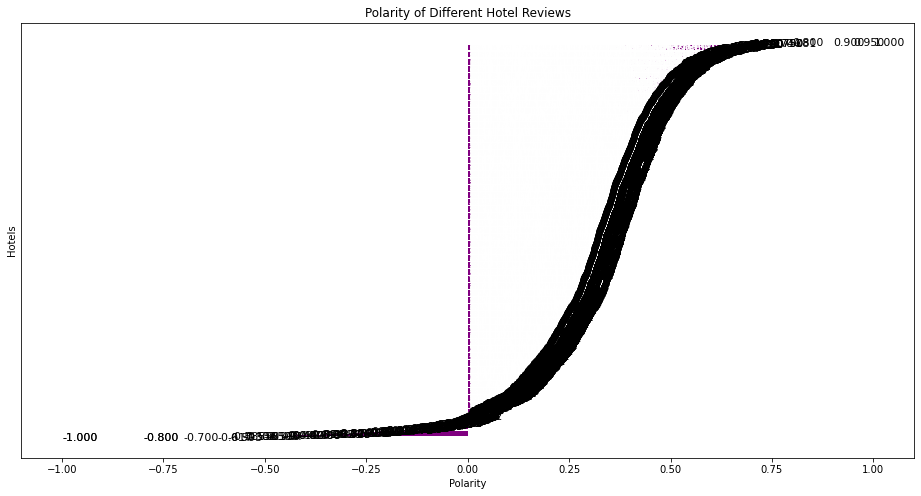

In [38]:
 #plot polarities of reviews for each hotels and their comparision
product_polarity_sorted=pd.DataFrame(df.groupby('Hotel')['polarity'].mean().sort_values(ascending=True))

plt.figure(figsize=(16,8))
plt.xlabel('Polarity')
plt.ylabel('Hotels')
plt.title('Polarity of Different Hotel Reviews')
polarity_graph=plt.barh(np.arange(len(product_polarity_sorted.index)),product_polarity_sorted['polarity'],color='purple',)

# Writing product names on bar
for bar,product in zip(polarity_graph,product_polarity_sorted.index):
  plt.text(0.005,bar.get_y()+bar.get_width(),'{}'.format(product),va='center',fontsize=11,color='white')

# Writing polarity values on graph
for bar,polarity in zip(polarity_graph,product_polarity_sorted['polarity']):
  plt.text(bar.get_width()+0.001,bar.get_y()+bar.get_width(),'%.3f'%polarity,va='center',fontsize=11,color='black')
  
plt.yticks([])
plt.show()

In [43]:
# Function for creating a column token
def token (text):
    token = [w for w in nltk.word_tokenize(text)]
    return token

# To create token feature
df['token'] = df['Text_Clean'].apply(token)

In [44]:
# Function for creating a column to see the length of the review text
def length(text):
    length = len([w for w in nltk.word_tokenize(text)])
    return length

# Apply length function to create review length feature
df['review_length'] = df['Reviews'].apply(length)
df.head(3)

Hotel_id  ... review_length
0         0  ...           209
1         1  ...            60
2         1  ...            67

[3 rows x 16 columns]